##### Copyright 2018 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image captioning with visual attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/image_captioning">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Given an image like the example below, our goal is to generate a caption such as "a surfer riding on a wave".

![Man Surfing](https://tensorflow.org/images/surf.jpg)

*[Image Source](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg); License: Public Domain*

To accomplish this, you'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

This notebook is an end-to-end example. When you run the notebook, it downloads the [MS-COCO](http://cocodataset.org/#home) dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model.

In this example, you will train a model on a relatively small amount of data—the first 30,000 captions  for about 20,000 images (because there are multiple captions per image in the dataset).

In [2]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

## Download and prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train our model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

**Caution: large download ahead**. You'll use the training set, which is a 13GB file.

In [3]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

     8192/252872794 [..............................] - ETA: 2s

    16384/252872794 [..............................] - ETA: 48:16

    49152/252872794 [..............................] - ETA: 32:13

   106496/252872794 [..............................] - ETA: 21:48

   229376/252872794 [..............................] - ETA: 13:48

   466944/252872794 [..............................] - ETA: 8:21 

   942080/252872794 [..............................] - ETA: 4:58

  1900544/252872794 [..............................] - ETA: 2:52

  3809280/252872794 [..............................] - ETA: 1:37

  4825088/252872794 [..............................] - ETA: 1:27

  7954432/252872794 [..............................] - ETA: 58s 

  9592832/252872794 [>.............................] - ETA: 52s

 12738560/252872794 [>.............................] - ETA: 42s

 15884288/252872794 [>.............................] - ETA: 36s

 17358848/252872794 [=>............................] - ETA: 35s

 20504576/252872794 [=>............................] - ETA: 32s

 22134784/252872794 [=>............................] - ETA: 31s

 24510464/252872794 [=>............................] - ETA: 29s

 26918912/252872794 [==>...........................] - ETA: 28s

 29360128/252872794 [==>...........................] - ETA: 27s

 31825920/252872794 [==>...........................] - ETA: 26s

 34316288/252872794 [===>..........................] - ETA: 25s

 36831232/252872794 [===>..........................] - ETA: 23s

 36839424/252872794 [===>..........................] - ETA: 24s

 39370752/252872794 [===>..........................] - ETA: 23s

 40165376/252872794 [===>..........................] - ETA: 24s

 43302912/252872794 [====>.........................] - ETA: 22s

 45105152/252872794 [====>.........................] - ETA: 22s

 46923776/252872794 [====>.........................] - ETA: 22s

 48611328/252872794 [====>.........................] - ETA: 22s

 50528256/252872794 [====>.........................] - ETA: 21s

 51830784/252872794 [=====>........................] - ETA: 22s

 53157888/252872794 [=====>........................] - ETA: 22s

 54501376/252872794 [=====>........................] - ETA: 21s

 55386112/252872794 [=====>........................] - ETA: 21s

 55869440/252872794 [=====>........................] - ETA: 21s

 57253888/252872794 [=====>........................] - ETA: 21s

 58654720/252872794 [=====>........................] - ETA: 21s

 60063744/252872794 [======>.......................] - ETA: 21s

 61497344/252872794 [======>.......................] - ETA: 21s

 62930944/252872794 [======>.......................] - ETA: 21s

 64389120/252872794 [======>.......................] - ETA: 21s

 65847296/252872794 [======>.......................] - ETA: 21s

 67321856/252872794 [======>.......................] - ETA: 21s

 67330048/252872794 [======>.......................] - ETA: 21s

 68812800/252872794 [=======>......................] - ETA: 21s

 70303744/252872794 [=======>......................] - ETA: 20s

 70729728/252872794 [=======>......................] - ETA: 20s

 71802880/252872794 [=======>......................] - ETA: 20s

 71811072/252872794 [=======>......................] - ETA: 20s

 73318400/252872794 [=======>......................] - ETA: 20s

 73326592/252872794 [=======>......................] - ETA: 20s

 74833920/252872794 [=======>......................] - ETA: 20s

 74842112/252872794 [=======>......................] - ETA: 20s

 75276288/252872794 [=======>......................] - ETA: 20s

 76365824/252872794 [========>.....................] - ETA: 20s

 76800000/252872794 [========>.....................] - ETA: 20s

 77897728/252872794 [========>.....................] - ETA: 20s

 77905920/252872794 [========>.....................] - ETA: 20s

 79437824/252872794 [========>.....................] - ETA: 20s

 79872000/252872794 [========>.....................] - ETA: 20s

 80977920/252872794 [========>.....................] - ETA: 19s

 80994304/252872794 [========>.....................] - ETA: 20s

 82526208/252872794 [========>.....................] - ETA: 19s

 82542592/252872794 [========>.....................] - ETA: 19s

 84082688/252872794 [========>.....................] - ETA: 19s

 84090880/252872794 [========>.....................] - ETA: 19s

 85639168/252872794 [=========>....................] - ETA: 19s

 85647360/252872794 [=========>....................] - ETA: 19s

 87195648/252872794 [=========>....................] - ETA: 19s

 87212032/252872794 [=========>....................] - ETA: 19s

 88760320/252872794 [=========>....................] - ETA: 19s

 88776704/252872794 [=========>....................] - ETA: 19s

 90324992/252872794 [=========>....................] - ETA: 18s

 90349568/252872794 [=========>....................] - ETA: 19s

 91897856/252872794 [=========>....................] - ETA: 18s

 91914240/252872794 [=========>....................] - ETA: 18s

 93470720/252872794 [==========>...................] - ETA: 18s

 93487104/252872794 [==========>...................] - ETA: 18s

 95043584/252872794 [==========>...................] - ETA: 18s

 95068160/252872794 [==========>...................] - ETA: 18s

 96616448/252872794 [==========>...................] - ETA: 18s

 96641024/252872794 [==========>...................] - ETA: 18s

 98189312/252872794 [==========>...................] - ETA: 18s

 98222080/252872794 [==========>...................] - ETA: 18s

 99770368/252872794 [==========>...................] - ETA: 17s

 99794944/252872794 [==========>...................] - ETA: 17s

100712448/252872794 [==========>...................] - ETA: 17s

102711296/252872794 [===========>..................] - ETA: 17s

102727680/252872794 [===========>..................] - ETA: 17s

103104512/252872794 [===========>..................] - ETA: 17s

103833600/252872794 [===========>..................] - ETA: 17s

103858176/252872794 [===========>..................] - ETA: 17s

104980480/252872794 [===========>..................] - ETA: 17s

105005056/252872794 [===========>..................] - ETA: 17s

106160128/252872794 [===========>..................] - ETA: 17s

106184704/252872794 [===========>..................] - ETA: 17s

107356160/252872794 [===========>..................] - ETA: 17s

107380736/252872794 [===========>..................] - ETA: 17s

108576768/252872794 [===========>..................] - ETA: 17s

108609536/252872794 [===========>..................] - ETA: 17s

109830144/252872794 [============>.................] - ETA: 17s

109854720/252872794 [============>.................] - ETA: 17s

111099904/252872794 [============>.................] - ETA: 16s

111132672/252872794 [============>.................] - ETA: 17s

112386048/252872794 [============>.................] - ETA: 16s

112418816/252872794 [============>.................] - ETA: 16s

113696768/252872794 [============>.................] - ETA: 16s

113729536/252872794 [============>.................] - ETA: 16s

115023872/252872794 [============>.................] - ETA: 16s

115064832/252872794 [============>.................] - ETA: 16s

116375552/252872794 [============>.................] - ETA: 16s

116416512/252872794 [============>.................] - ETA: 16s

117735424/252872794 [============>.................] - ETA: 16s

117776384/252872794 [============>.................] - ETA: 16s

119119872/252872794 [=============>................] - ETA: 16s

119160832/252872794 [=============>................] - ETA: 16s

120520704/252872794 [=============>................] - ETA: 16s

120561664/252872794 [=============>................] - ETA: 16s

121929728/252872794 [=============>................] - ETA: 15s

121970688/252872794 [=============>................] - ETA: 15s

123355136/252872794 [=============>................] - ETA: 15s

123396096/252872794 [=============>................] - ETA: 15s

124796928/252872794 [=============>................] - ETA: 15s

124837888/252872794 [=============>................] - ETA: 15s

126246912/252872794 [=============>................] - ETA: 15s

126287872/252872794 [=============>................] - ETA: 15s

127705088/252872794 [==============>...............] - ETA: 15s

127754240/252872794 [==============>...............] - ETA: 15s

129179648/252872794 [==============>...............] - ETA: 15s

129228800/252872794 [==============>...............] - ETA: 15s

130662400/252872794 [==============>...............] - ETA: 14s

130711552/252872794 [==============>...............] - ETA: 14s

132153344/252872794 [==============>...............] - ETA: 14s

132202496/252872794 [==============>...............] - ETA: 14s

133660672/252872794 [==============>...............] - ETA: 14s

133701632/252872794 [==============>...............] - ETA: 14s

135168000/252872794 [===============>..............] - ETA: 14s

135217152/252872794 [===============>..............] - ETA: 14s

136683520/252872794 [===============>..............] - ETA: 14s

136732672/252872794 [===============>..............] - ETA: 14s

137035776/252872794 [===============>..............] - ETA: 14s

139386880/252872794 [===============>..............] - ETA: 13s

139419648/252872794 [===============>..............] - ETA: 13s

140468224/252872794 [===============>..............] - ETA: 13s

140500992/252872794 [===============>..............] - ETA: 13s

141557760/252872794 [===============>..............] - ETA: 13s

141582336/252872794 [===============>..............] - ETA: 13s

141910016/252872794 [===============>..............] - ETA: 13s

142671872/252872794 [===============>..............] - ETA: 13s

142712832/252872794 [===============>..............] - ETA: 13s

143802368/252872794 [================>.............] - ETA: 13s

143835136/252872794 [================>.............] - ETA: 13s

144941056/252872794 [================>.............] - ETA: 13s

144982016/252872794 [================>.............] - ETA: 13s

146096128/252872794 [================>.............] - ETA: 13s

146137088/252872794 [================>.............] - ETA: 13s

147259392/252872794 [================>.............] - ETA: 13s

147300352/252872794 [================>.............] - ETA: 13s

148439040/252872794 [================>.............] - ETA: 13s

148480000/252872794 [================>.............] - ETA: 13s

149626880/252872794 [================>.............] - ETA: 12s

149676032/252872794 [================>.............] - ETA: 12s

150831104/252872794 [================>.............] - ETA: 12s

150872064/252872794 [================>.............] - ETA: 12s

151117824/252872794 [================>.............] - ETA: 12s

152969216/252872794 [=================>............] - ETA: 12s

153001984/252872794 [=================>............] - ETA: 12s

153821184/252872794 [=================>............] - ETA: 12s

153845760/252872794 [=================>............] - ETA: 12s

154083328/252872794 [=================>............] - ETA: 12s

154697728/252872794 [=================>............] - ETA: 12s

154730496/252872794 [=================>............] - ETA: 12s

155582464/252872794 [=================>............] - ETA: 12s

155615232/252872794 [=================>............] - ETA: 12s

156475392/252872794 [=================>............] - ETA: 12s

156508160/252872794 [=================>............] - ETA: 12s

156721152/252872794 [=================>............] - ETA: 12s

157384704/252872794 [=================>............] - ETA: 12s

157417472/252872794 [=================>............] - ETA: 12s

157638656/252872794 [=================>............] - ETA: 12s

158302208/252872794 [=================>............] - ETA: 12s

158334976/252872794 [=================>............] - ETA: 12s

158564352/252872794 [=================>............] - ETA: 12s

159236096/252872794 [=================>............] - ETA: 12s

159268864/252872794 [=================>............] - ETA: 12s

159498240/252872794 [=================>............] - ETA: 12s

160178176/252872794 [==================>...........] - ETA: 12s

160210944/252872794 [==================>...........] - ETA: 12s

160440320/252872794 [==================>...........] - ETA: 12s

161128448/252872794 [==================>...........] - ETA: 11s

161161216/252872794 [==================>...........] - ETA: 11s

161390592/252872794 [==================>...........] - ETA: 11s

162086912/252872794 [==================>...........] - ETA: 11s

162119680/252872794 [==================>...........] - ETA: 11s

162349056/252872794 [==================>...........] - ETA: 11s

163012608/252872794 [==================>...........] - ETA: 11s

163078144/252872794 [==================>...........] - ETA: 11s

163315712/252872794 [==================>...........] - ETA: 11s

163987456/252872794 [==================>...........] - ETA: 11s

164052992/252872794 [==================>...........] - ETA: 11s

164290560/252872794 [==================>...........] - ETA: 11s

164962304/252872794 [==================>...........] - ETA: 11s

165036032/252872794 [==================>...........] - ETA: 11s

165273600/252872794 [==================>...........] - ETA: 11s

165945344/252872794 [==================>...........] - ETA: 11s

166019072/252872794 [==================>...........] - ETA: 11s

166264832/252872794 [==================>...........] - ETA: 11s

166936576/252872794 [==================>...........] - ETA: 11s

167010304/252872794 [==================>...........] - ETA: 11s

167256064/252872794 [==================>...........] - ETA: 11s

167927808/252872794 [==================>...........] - ETA: 11s

168009728/252872794 [==================>...........] - ETA: 11s

168255488/252872794 [==================>...........] - ETA: 11s

168935424/252872794 [===================>..........] - ETA: 11s

169009152/252872794 [===================>..........] - ETA: 11s

169254912/252872794 [===================>..........] - ETA: 11s

169934848/252872794 [===================>..........] - ETA: 11s

170016768/252872794 [===================>..........] - ETA: 11s

170270720/252872794 [===================>..........] - ETA: 11s

170942464/252872794 [===================>..........] - ETA: 10s

171024384/252872794 [===================>..........] - ETA: 10s

171278336/252872794 [===================>..........] - ETA: 10s

171958272/252872794 [===================>..........] - ETA: 10s

172032000/252872794 [===================>..........] - ETA: 10s

172285952/252872794 [===================>..........] - ETA: 10s

172974080/252872794 [===================>..........] - ETA: 10s

173047808/252872794 [===================>..........] - ETA: 10s

173301760/252872794 [===================>..........] - ETA: 10s

173989888/252872794 [===================>..........] - ETA: 10s

174071808/252872794 [===================>..........] - ETA: 10s

174325760/252872794 [===================>..........] - ETA: 10s

174792704/252872794 [===================>..........] - ETA: 10s

175980544/252872794 [===================>..........] - ETA: 10s

176021504/252872794 [===================>..........] - ETA: 10s

176201728/252872794 [===================>..........] - ETA: 10s

176226304/252872794 [===================>..........] - ETA: 10s

177250304/252872794 [====================>.........] - ETA: 10s

177291264/252872794 [====================>.........] - ETA: 10s

177430528/252872794 [====================>.........] - ETA: 10s

177766400/252872794 [====================>.........] - ETA: 10s

177807360/252872794 [====================>.........] - ETA: 10s

177946624/252872794 [====================>.........] - ETA: 10s

178282496/252872794 [====================>.........] - ETA: 10s

178331648/252872794 [====================>.........] - ETA: 10s

178479104/252872794 [====================>.........] - ETA: 10s

178814976/252872794 [====================>.........] - ETA: 10s

178864128/252872794 [====================>.........] - ETA: 10s

179011584/252872794 [====================>.........] - ETA: 10s

179355648/252872794 [====================>.........] - ETA: 10s

179404800/252872794 [====================>.........] - ETA: 10s

179552256/252872794 [====================>.........] - ETA: 10s

179904512/252872794 [====================>.........] - ETA: 10s

179953664/252872794 [====================>.........] - ETA: 10s

180109312/252872794 [====================>.........] - ETA: 10s

180461568/252872794 [====================>.........] - ETA: 10s

180510720/252872794 [====================>.........] - ETA: 10s

180666368/252872794 [====================>.........] - ETA: 10s

181026816/252872794 [====================>.........] - ETA: 10s

181067776/252872794 [====================>.........] - ETA: 10s

181231616/252872794 [====================>.........] - ETA: 10s

181592064/252872794 [====================>.........] - ETA: 10s

181641216/252872794 [====================>.........] - ETA: 10s

181805056/252872794 [====================>.........] - ETA: 10s

182173696/252872794 [====================>.........] - ETA: 10s

182214656/252872794 [====================>.........] - ETA: 10s

182378496/252872794 [====================>.........] - ETA: 10s

182747136/252872794 [====================>.........] - ETA: 10s

182796288/252872794 [====================>.........] - ETA: 10s

182960128/252872794 [====================>.........] - ETA: 10s

183336960/252872794 [====================>.........] - ETA: 9s 

183377920/252872794 [====================>.........] - ETA: 9s

183549952/252872794 [====================>.........] - ETA: 9s

183918592/252872794 [====================>.........] - ETA: 9s

183967744/252872794 [====================>.........] - ETA: 9s

184139776/252872794 [====================>.........] - ETA: 9s

184516608/252872794 [====================>.........] - ETA: 9s

184557568/252872794 [====================>.........] - ETA: 9s

184737792/252872794 [====================>.........] - ETA: 9s

185114624/252872794 [====================>.........] - ETA: 9s

185155584/252872794 [====================>.........] - ETA: 9s

185335808/252872794 [====================>.........] - ETA: 9s

185712640/252872794 [=====================>........] - ETA: 9s

185753600/252872794 [=====================>........] - ETA: 9s

185933824/252872794 [=====================>........] - ETA: 9s

186310656/252872794 [=====================>........] - ETA: 9s

186359808/252872794 [=====================>........] - ETA: 9s

186540032/252872794 [=====================>........] - ETA: 9s

186916864/252872794 [=====================>........] - ETA: 9s

186966016/252872794 [=====================>........] - ETA: 9s

187146240/252872794 [=====================>........] - ETA: 9s

187523072/252872794 [=====================>........] - ETA: 9s

187572224/252872794 [=====================>........] - ETA: 9s

187752448/252872794 [=====================>........] - ETA: 9s

188129280/252872794 [=====================>........] - ETA: 9s

188178432/252872794 [=====================>........] - ETA: 9s

188366848/252872794 [=====================>........] - ETA: 9s

188743680/252872794 [=====================>........] - ETA: 9s

189390848/252872794 [=====================>........] - ETA: 9s

189513728/252872794 [=====================>........] - ETA: 9s

189775872/252872794 [=====================>........] - ETA: 9s

189816832/252872794 [=====================>........] - ETA: 9s

189947904/252872794 [=====================>........] - ETA: 9s

190218240/252872794 [=====================>........] - ETA: 9s

190251008/252872794 [=====================>........] - ETA: 9s

190390272/252872794 [=====================>........] - ETA: 9s

190660608/252872794 [=====================>........] - ETA: 9s

190701568/252872794 [=====================>........] - ETA: 9s

190832640/252872794 [=====================>........] - ETA: 9s

191119360/252872794 [=====================>........] - ETA: 9s

191160320/252872794 [=====================>........] - ETA: 9s

191291392/252872794 [=====================>........] - ETA: 9s

191578112/252872794 [=====================>........] - ETA: 9s

191619072/252872794 [=====================>........] - ETA: 9s

191758336/252872794 [=====================>........] - ETA: 9s

192053248/252872794 [=====================>........] - ETA: 9s

192094208/252872794 [=====================>........] - ETA: 9s

192233472/252872794 [=====================>........] - ETA: 9s

192528384/252872794 [=====================>........] - ETA: 9s

192569344/252872794 [=====================>........] - ETA: 9s

192708608/252872794 [=====================>........] - ETA: 9s

193003520/252872794 [=====================>........] - ETA: 9s

193044480/252872794 [=====================>........] - ETA: 9s

193191936/252872794 [=====================>........] - ETA: 9s

193486848/252872794 [=====================>........] - ETA: 9s

193536000/252872794 [=====================>........] - ETA: 9s

193683456/252872794 [=====================>........] - ETA: 9s

193978368/252872794 [======================>.......] - ETA: 9s

194027520/252872794 [======================>.......] - ETA: 9s

194174976/252872794 [======================>.......] - ETA: 9s

194437120/252872794 [======================>.......] - ETA: 9s

194977792/252872794 [======================>.......] - ETA: 9s

194994176/252872794 [======================>.......] - ETA: 9s

195100672/252872794 [======================>.......] - ETA: 9s

195305472/252872794 [======================>.......] - ETA: 9s

195338240/252872794 [======================>.......] - ETA: 9s

195444736/252872794 [======================>.......] - ETA: 9s

195657728/252872794 [======================>.......] - ETA: 9s

195690496/252872794 [======================>.......] - ETA: 9s

195796992/252872794 [======================>.......] - ETA: 9s

196018176/252872794 [======================>.......] - ETA: 8s

196050944/252872794 [======================>.......] - ETA: 9s

196165632/252872794 [======================>.......] - ETA: 8s

196378624/252872794 [======================>.......] - ETA: 8s

196419584/252872794 [======================>.......] - ETA: 8s

196534272/252872794 [======================>.......] - ETA: 8s

196755456/252872794 [======================>.......] - ETA: 8s

196788224/252872794 [======================>.......] - ETA: 8s

196911104/252872794 [======================>.......] - ETA: 8s

197132288/252872794 [======================>.......] - ETA: 8s

197173248/252872794 [======================>.......] - ETA: 8s

197287936/252872794 [======================>.......] - ETA: 8s

197517312/252872794 [======================>.......] - ETA: 8s

197558272/252872794 [======================>.......] - ETA: 8s

197681152/252872794 [======================>.......] - ETA: 8s

197910528/252872794 [======================>.......] - ETA: 8s

197951488/252872794 [======================>.......] - ETA: 8s

198066176/252872794 [======================>.......] - ETA: 8s

198303744/252872794 [======================>.......] - ETA: 8s

198344704/252872794 [======================>.......] - ETA: 8s

198467584/252872794 [======================>.......] - ETA: 8s

198696960/252872794 [======================>.......] - ETA: 8s

198746112/252872794 [======================>.......] - ETA: 8s

198868992/252872794 [======================>.......] - ETA: 8s

199106560/252872794 [======================>.......] - ETA: 8s

199147520/252872794 [======================>.......] - ETA: 8s

199270400/252872794 [======================>.......] - ETA: 8s

199507968/252872794 [======================>.......] - ETA: 8s

199557120/252872794 [======================>.......] - ETA: 8s

199680000/252872794 [======================>.......] - ETA: 8s

199917568/252872794 [======================>.......] - ETA: 8s

199966720/252872794 [======================>.......] - ETA: 8s

200089600/252872794 [======================>.......] - ETA: 8s

200327168/252872794 [======================>.......] - ETA: 8s

200376320/252872794 [======================>.......] - ETA: 8s

200507392/252872794 [======================>.......] - ETA: 8s

200744960/252872794 [======================>.......] - ETA: 8s

200785920/252872794 [======================>.......] - ETA: 8s

200916992/252872794 [======================>.......] - ETA: 8s

201162752/252872794 [======================>.......] - ETA: 8s

201203712/252872794 [======================>.......] - ETA: 8s

201334784/252872794 [======================>.......] - ETA: 8s

201580544/252872794 [======================>.......] - ETA: 8s

201621504/252872794 [======================>.......] - ETA: 8s

201752576/252872794 [======================>.......] - ETA: 8s

201998336/252872794 [======================>.......] - ETA: 8s

202039296/252872794 [======================>.......] - ETA: 8s

202170368/252872794 [======================>.......] - ETA: 8s

202416128/252872794 [=======================>......] - ETA: 8s

202465280/252872794 [=======================>......] - ETA: 8s

202596352/252872794 [=======================>......] - ETA: 8s

202833920/252872794 [=======================>......] - ETA: 8s

202883072/252872794 [=======================>......] - ETA: 8s

203014144/252872794 [=======================>......] - ETA: 8s

203259904/252872794 [=======================>......] - ETA: 8s

203309056/252872794 [=======================>......] - ETA: 8s

203440128/252872794 [=======================>......] - ETA: 8s

203677696/252872794 [=======================>......] - ETA: 8s

203726848/252872794 [=======================>......] - ETA: 8s

203866112/252872794 [=======================>......] - ETA: 8s

204103680/252872794 [=======================>......] - ETA: 8s

204152832/252872794 [=======================>......] - ETA: 8s

204283904/252872794 [=======================>......] - ETA: 8s

204529664/252872794 [=======================>......] - ETA: 8s

204578816/252872794 [=======================>......] - ETA: 8s

204709888/252872794 [=======================>......] - ETA: 8s

204947456/252872794 [=======================>......] - ETA: 8s

204996608/252872794 [=======================>......] - ETA: 8s

205127680/252872794 [=======================>......] - ETA: 8s

205373440/252872794 [=======================>......] - ETA: 8s

205422592/252872794 [=======================>......] - ETA: 8s

205553664/252872794 [=======================>......] - ETA: 8s

205791232/252872794 [=======================>......] - ETA: 8s

205840384/252872794 [=======================>......] - ETA: 8s

205971456/252872794 [=======================>......] - ETA: 8s

206217216/252872794 [=======================>......] - ETA: 8s

206266368/252872794 [=======================>......] - ETA: 8s

206397440/252872794 [=======================>......] - ETA: 8s

206643200/252872794 [=======================>......] - ETA: 8s

206692352/252872794 [=======================>......] - ETA: 8s

206823424/252872794 [=======================>......] - ETA: 8s

207060992/252872794 [=======================>......] - ETA: 7s

207110144/252872794 [=======================>......] - ETA: 7s

207241216/252872794 [=======================>......] - ETA: 7s

207486976/252872794 [=======================>......] - ETA: 7s

207536128/252872794 [=======================>......] - ETA: 7s

207667200/252872794 [=======================>......] - ETA: 7s

207912960/252872794 [=======================>......] - ETA: 7s

207953920/252872794 [=======================>......] - ETA: 7s

208084992/252872794 [=======================>......] - ETA: 7s

208150528/252872794 [=======================>......] - ETA: 7s

208707584/252872794 [=======================>......] - ETA: 7s

208732160/252872794 [=======================>......] - ETA: 7s

208805888/252872794 [=======================>......] - ETA: 7s

208953344/252872794 [=======================>......] - ETA: 7s

209313792/252872794 [=======================>......] - ETA: 7s

209338368/252872794 [=======================>......] - ETA: 7s

209510400/252872794 [=======================>......] - ETA: 7s

209534976/252872794 [=======================>......] - ETA: 7s

209592320/252872794 [=======================>......] - ETA: 7s

209739776/252872794 [=======================>......] - ETA: 7s

209764352/252872794 [=======================>......] - ETA: 7s

209821696/252872794 [=======================>......] - ETA: 7s

209969152/252872794 [=======================>......] - ETA: 7s

209993728/252872794 [=======================>......] - ETA: 7s

210051072/252872794 [=======================>......] - ETA: 7s

210198528/252872794 [=======================>......] - ETA: 7s

210231296/252872794 [=======================>......] - ETA: 7s

210288640/252872794 [=======================>......] - ETA: 7s

210444288/252872794 [=======================>......] - ETA: 7s

210468864/252872794 [=======================>......] - ETA: 7s

210534400/252872794 [=======================>......] - ETA: 7s

210681856/252872794 [=======================>......] - ETA: 7s

210714624/252872794 [=======================>......] - ETA: 7s

210780160/252872794 [========================>.....] - ETA: 7s

210935808/252872794 [========================>.....] - ETA: 7s

210960384/252872794 [========================>.....] - ETA: 7s

211025920/252872794 [========================>.....] - ETA: 7s

211181568/252872794 [========================>.....] - ETA: 7s

211214336/252872794 [========================>.....] - ETA: 7s

211279872/252872794 [========================>.....] - ETA: 7s

211435520/252872794 [========================>.....] - ETA: 7s

211468288/252872794 [========================>.....] - ETA: 7s

211533824/252872794 [========================>.....] - ETA: 7s

211689472/252872794 [========================>.....] - ETA: 7s

211722240/252872794 [========================>.....] - ETA: 7s

211787776/252872794 [========================>.....] - ETA: 7s

211943424/252872794 [========================>.....] - ETA: 7s

211976192/252872794 [========================>.....] - ETA: 7s

212041728/252872794 [========================>.....] - ETA: 7s

212205568/252872794 [========================>.....] - ETA: 7s

212238336/252872794 [========================>.....] - ETA: 7s

212303872/252872794 [========================>.....] - ETA: 7s

212459520/252872794 [========================>.....] - ETA: 7s

212492288/252872794 [========================>.....] - ETA: 7s

212566016/252872794 [========================>.....] - ETA: 7s

212721664/252872794 [========================>.....] - ETA: 7s

212754432/252872794 [========================>.....] - ETA: 7s

212828160/252872794 [========================>.....] - ETA: 7s

212983808/252872794 [========================>.....] - ETA: 7s

213016576/252872794 [========================>.....] - ETA: 7s

213090304/252872794 [========================>.....] - ETA: 7s

213245952/252872794 [========================>.....] - ETA: 7s

213286912/252872794 [========================>.....] - ETA: 7s

213352448/252872794 [========================>.....] - ETA: 7s

213516288/252872794 [========================>.....] - ETA: 7s

213549056/252872794 [========================>.....] - ETA: 7s

213622784/252872794 [========================>.....] - ETA: 7s

213778432/252872794 [========================>.....] - ETA: 7s

213811200/252872794 [========================>.....] - ETA: 7s

213884928/252872794 [========================>.....] - ETA: 7s

214040576/252872794 [========================>.....] - ETA: 7s

214073344/252872794 [========================>.....] - ETA: 7s

214147072/252872794 [========================>.....] - ETA: 7s

214302720/252872794 [========================>.....] - ETA: 7s

214343680/252872794 [========================>.....] - ETA: 7s

214409216/252872794 [========================>.....] - ETA: 7s

214564864/252872794 [========================>.....] - ETA: 7s

214605824/252872794 [========================>.....] - ETA: 7s

214671360/252872794 [========================>.....] - ETA: 7s

214827008/252872794 [========================>.....] - ETA: 7s

214867968/252872794 [========================>.....] - ETA: 7s

214941696/252872794 [========================>.....] - ETA: 7s

215097344/252872794 [========================>.....] - ETA: 7s

215130112/252872794 [========================>.....] - ETA: 7s

215203840/252872794 [========================>.....] - ETA: 7s

215359488/252872794 [========================>.....] - ETA: 7s

215392256/252872794 [========================>.....] - ETA: 7s

215465984/252872794 [========================>.....] - ETA: 7s

215621632/252872794 [========================>.....] - ETA: 7s

215662592/252872794 [========================>.....] - ETA: 7s

215728128/252872794 [========================>.....] - ETA: 7s

215883776/252872794 [========================>.....] - ETA: 7s

215924736/252872794 [========================>.....] - ETA: 7s

215990272/252872794 [========================>.....] - ETA: 7s

216154112/252872794 [========================>.....] - ETA: 7s

216186880/252872794 [========================>.....] - ETA: 7s

216260608/252872794 [========================>.....] - ETA: 7s

216416256/252872794 [========================>.....] - ETA: 7s

216449024/252872794 [========================>.....] - ETA: 7s

216522752/252872794 [========================>.....] - ETA: 7s

216678400/252872794 [========================>.....] - ETA: 7s

216719360/252872794 [========================>.....] - ETA: 7s

216784896/252872794 [========================>.....] - ETA: 7s

216940544/252872794 [========================>.....] - ETA: 7s

216981504/252872794 [========================>.....] - ETA: 7s

217047040/252872794 [========================>.....] - ETA: 7s

217210880/252872794 [========================>.....] - ETA: 7s

217243648/252872794 [========================>.....] - ETA: 7s

217317376/252872794 [========================>.....] - ETA: 7s

217473024/252872794 [========================>.....] - ETA: 7s

217513984/252872794 [========================>.....] - ETA: 7s

217579520/252872794 [========================>.....] - ETA: 7s

217735168/252872794 [========================>.....] - ETA: 7s

217784320/252872794 [========================>.....] - ETA: 7s

217849856/252872794 [========================>.....] - ETA: 6s

218005504/252872794 [========================>.....] - ETA: 6s

218046464/252872794 [========================>.....] - ETA: 6s

218120192/252872794 [========================>.....] - ETA: 6s

218275840/252872794 [========================>.....] - ETA: 6s

218316800/252872794 [========================>.....] - ETA: 6s

218390528/252872794 [========================>.....] - ETA: 6s

218546176/252872794 [========================>.....] - ETA: 6s

218587136/252872794 [========================>.....] - ETA: 6s

218660864/252872794 [========================>.....] - ETA: 6s

218816512/252872794 [========================>.....] - ETA: 6s

218865664/252872794 [========================>.....] - ETA: 6s

218939392/252872794 [========================>.....] - ETA: 6s

219086848/252872794 [========================>.....] - ETA: 6s

219136000/252872794 [========================>.....] - ETA: 6s

219209728/252872794 [=========================>....] - ETA: 6s

219365376/252872794 [=========================>....] - ETA: 6s

219414528/252872794 [=========================>....] - ETA: 6s

219488256/252872794 [=========================>....] - ETA: 6s

219643904/252872794 [=========================>....] - ETA: 6s

219701248/252872794 [=========================>....] - ETA: 6s

219774976/252872794 [=========================>....] - ETA: 6s

219930624/252872794 [=========================>....] - ETA: 6s

219979776/252872794 [=========================>....] - ETA: 6s

220053504/252872794 [=========================>....] - ETA: 6s

220217344/252872794 [=========================>....] - ETA: 6s

220266496/252872794 [=========================>....] - ETA: 6s

220348416/252872794 [=========================>....] - ETA: 6s

220504064/252872794 [=========================>....] - ETA: 6s

220561408/252872794 [=========================>....] - ETA: 6s

220635136/252872794 [=========================>....] - ETA: 6s

220798976/252872794 [=========================>....] - ETA: 6s

220856320/252872794 [=========================>....] - ETA: 6s

220938240/252872794 [=========================>....] - ETA: 6s

221102080/252872794 [=========================>....] - ETA: 6s

221159424/252872794 [=========================>....] - ETA: 6s

221241344/252872794 [=========================>....] - ETA: 6s

221413376/252872794 [=========================>....] - ETA: 6s

221462528/252872794 [=========================>....] - ETA: 6s

221544448/252872794 [=========================>....] - ETA: 6s

221716480/252872794 [=========================>....] - ETA: 6s

221773824/252872794 [=========================>....] - ETA: 6s

221863936/252872794 [=========================>....] - ETA: 6s

222044160/252872794 [=========================>....] - ETA: 6s

222093312/252872794 [=========================>....] - ETA: 6s

222183424/252872794 [=========================>....] - ETA: 6s

222355456/252872794 [=========================>....] - ETA: 6s

222420992/252872794 [=========================>....] - ETA: 6s

222511104/252872794 [=========================>....] - ETA: 6s

222691328/252872794 [=========================>....] - ETA: 6s

222756864/252872794 [=========================>....] - ETA: 6s

222846976/252872794 [=========================>....] - ETA: 6s

223027200/252872794 [=========================>....] - ETA: 6s

223100928/252872794 [=========================>....] - ETA: 6s

223191040/252872794 [=========================>....] - ETA: 6s

223379456/252872794 [=========================>....] - ETA: 6s

223453184/252872794 [=========================>....] - ETA: 6s

223543296/252872794 [=========================>....] - ETA: 6s

223739904/252872794 [=========================>....] - ETA: 6s

223813632/252872794 [=========================>....] - ETA: 6s

223903744/252872794 [=========================>....] - ETA: 6s

224100352/252872794 [=========================>....] - ETA: 6s

224182272/252872794 [=========================>....] - ETA: 6s

224280576/252872794 [=========================>....] - ETA: 6s

224485376/252872794 [=========================>....] - ETA: 6s

224559104/252872794 [=========================>....] - ETA: 6s

224665600/252872794 [=========================>....] - ETA: 5s

224878592/252872794 [=========================>....] - ETA: 5s

224952320/252872794 [=========================>....] - ETA: 5s

225058816/252872794 [=========================>....] - ETA: 5s

225280000/252872794 [=========================>....] - ETA: 5s

225361920/252872794 [=========================>....] - ETA: 5s

225468416/252872794 [=========================>....] - ETA: 5s

225689600/252872794 [=========================>....] - ETA: 5s

225779712/252872794 [=========================>....] - ETA: 5s

225894400/252872794 [=========================>....] - ETA: 5s

226123776/252872794 [=========================>....] - ETA: 5s

226213888/252872794 [=========================>....] - ETA: 5s

226328576/252872794 [=========================>....] - ETA: 5s

226566144/252872794 [=========================>....] - ETA: 5s

226656256/252872794 [=========================>....] - ETA: 5s

226779136/252872794 [=========================>....] - ETA: 5s

227024896/252872794 [=========================>....] - ETA: 5s

227123200/252872794 [=========================>....] - ETA: 5s

227246080/252872794 [=========================>....] - ETA: 5s

227500032/252872794 [=========================>....] - ETA: 5s

227598336/252872794 [==========================>...] - ETA: 5s

227729408/252872794 [==========================>...] - ETA: 5s

227991552/252872794 [==========================>...] - ETA: 5s

228098048/252872794 [==========================>...] - ETA: 5s

228229120/252872794 [==========================>...] - ETA: 5s

228507648/252872794 [==========================>...] - ETA: 5s

228614144/252872794 [==========================>...] - ETA: 5s

228753408/252872794 [==========================>...] - ETA: 5s

229031936/252872794 [==========================>...] - ETA: 5s

229146624/252872794 [==========================>...] - ETA: 5s

229294080/252872794 [==========================>...] - ETA: 5s

229588992/252872794 [==========================>...] - ETA: 5s

229695488/252872794 [==========================>...] - ETA: 5s

229851136/252872794 [==========================>...] - ETA: 4s

230154240/252872794 [==========================>...] - ETA: 4s

230268928/252872794 [==========================>...] - ETA: 4s

230432768/252872794 [==========================>...] - ETA: 4s

230744064/252872794 [==========================>...] - ETA: 4s

230866944/252872794 [==========================>...] - ETA: 4s

231038976/252872794 [==========================>...] - ETA: 4s

231358464/252872794 [==========================>...] - ETA: 4s

231489536/252872794 [==========================>...] - ETA: 4s

231661568/252872794 [==========================>...] - ETA: 4s

231997440/252872794 [==========================>...] - ETA: 4s

232128512/252872794 [==========================>...] - ETA: 4s

232316928/252872794 [==========================>...] - ETA: 4s

232660992/252872794 [==========================>...] - ETA: 4s

232800256/252872794 [==========================>...] - ETA: 4s

232988672/252872794 [==========================>...] - ETA: 4s

233349120/252872794 [==========================>...] - ETA: 4s

233496576/252872794 [==========================>...] - ETA: 4s

233693184/252872794 [==========================>...] - ETA: 4s

234070016/252872794 [==========================>...] - ETA: 4s

234217472/252872794 [==========================>...] - ETA: 4s

234422272/252872794 [==========================>...] - ETA: 4s

234815488/252872794 [==========================>...] - ETA: 3s

234962944/252872794 [==========================>...] - ETA: 3s

235184128/252872794 [==========================>...] - ETA: 3s

235585536/252872794 [==========================>...] - ETA: 3s

235741184/252872794 [==========================>...] - ETA: 3s

235970560/252872794 [==========================>...] - ETA: 3s

236388352/252872794 [===========================>..] - ETA: 3s

236552192/252872794 [===========================>..] - ETA: 3s

236789760/252872794 [===========================>..] - ETA: 3s

237223936/252872794 [===========================>..] - ETA: 3s

237395968/252872794 [===========================>..] - ETA: 3s

237641728/252872794 [===========================>..] - ETA: 3s

238092288/252872794 [===========================>..] - ETA: 3s

238272512/252872794 [===========================>..] - ETA: 3s

238526464/252872794 [===========================>..] - ETA: 3s

238993408/252872794 [===========================>..] - ETA: 3s

239181824/252872794 [===========================>..] - ETA: 2s

239452160/252872794 [===========================>..] - ETA: 2s

239935488/252872794 [===========================>..] - ETA: 2s

240123904/252872794 [===========================>..] - ETA: 2s

240410624/252872794 [===========================>..] - ETA: 2s

240910336/252872794 [===========================>..] - ETA: 2s

241106944/252872794 [===========================>..] - ETA: 2s

241401856/252872794 [===========================>..] - ETA: 2s

241926144/252872794 [===========================>..] - ETA: 2s

242122752/252872794 [===========================>..] - ETA: 2s

242434048/252872794 [===========================>..] - ETA: 2s

242974720/252872794 [===========================>..] - ETA: 2s

243187712/252872794 [===========================>..] - ETA: 2s

243507200/252872794 [===========================>..] - ETA: 2s

244064256/252872794 [===========================>..] - ETA: 1s

244285440/252872794 [===========================>..] - ETA: 1s

244621312/252872794 [============================>.] - ETA: 1s

245202944/252872794 [============================>.] - ETA: 1s

245432320/252872794 [============================>.] - ETA: 1s

245776384/252872794 [============================>.] - ETA: 1s

246382592/252872794 [============================>.] - ETA: 1s

246611968/252872794 [============================>.] - ETA: 1s

246980608/252872794 [============================>.] - ETA: 1s

247603200/252872794 [============================>.] - ETA: 1s

247848960/252872794 [============================>.] - ETA: 1s

248225792/252872794 [============================>.] - ETA: 1s

248872960/252872794 [============================>.] - ETA: 0s

249126912/252872794 [============================>.] - ETA: 0s

249520128/252872794 [============================>.] - ETA: 0s

250191872/252872794 [============================>.] - ETA: 0s

250454016/252872794 [============================>.] - ETA: 0s

250863616/252872794 [============================>.] - ETA: 0s

251551744/252872794 [============================>.] - ETA: 0s

251830272/252872794 [============================>.] - ETA: 0s

252256256/252872794 [============================>.] - ETA: 0s

252878848/252872794 [==============================] - 54s 0us/step


       8192/13510573713 [..............................] - ETA: 2:06

      16384/13510573713 [..............................] - ETA: 42:27:49

      49152/13510573713 [..............................] - ETA: 28:22:34

     106496/13510573713 [..............................] - ETA: 19:05:07

     204800/13510573713 [..............................] - ETA: 13:19:44

     425984/13510573713 [..............................] - ETA: 8:02:42 

     860160/13510573713 [..............................] - ETA: 4:47:42

    1728512/13510573713 [..............................] - ETA: 2:47:22

    3465216/13510573713 [..............................] - ETA: 1:35:33

    6602752/13510573713 [..............................] - ETA: 56:28  

    9748480/13510573713 [..............................] - ETA: 42:32

   12886016/13510573713 [..............................] - ETA: 35:25

   16023552/13510573713 [..............................] - ETA: 31:05

   19169280/13510573713 [..............................] - ETA: 28:09

   22306816/13510573713 [..............................] - ETA: 26:04

   25444352/13510573713 [..............................] - ETA: 24:29

   28581888/13510573713 [..............................] - ETA: 23:15

   31694848/13510573713 [..............................] - ETA: 22:17

   34824192/13510573713 [..............................] - ETA: 21:28

   37945344/13510573713 [..............................] - ETA: 20:48

   41050112/13510573713 [..............................] - ETA: 20:14

   44187648/13510573713 [..............................] - ETA: 19:44

   47292416/13510573713 [..............................] - ETA: 19:19

   50438144/13510573713 [..............................] - ETA: 18:56

   53477376/13510573713 [..............................] - ETA: 18:25

   53583872/13510573713 [..............................] - ETA: 18:40

   56565760/13510573713 [..............................] - ETA: 18:09

   56647680/13510573713 [..............................] - ETA: 18:19

   59695104/13510573713 [..............................] - ETA: 17:53

   59736064/13510573713 [..............................] - ETA: 18:04

   62832640/13510573713 [..............................] - ETA: 17:39

   62849024/13510573713 [..............................] - ETA: 17:50

   65970176/13510573713 [..............................] - ETA: 17:27

   65978368/13510573713 [..............................] - ETA: 17:37

   69107712/13510573713 [..............................] - ETA: 17:15

   69124096/13510573713 [..............................] - ETA: 17:25

   72245248/13510573713 [..............................] - ETA: 17:04

   72261632/13510573713 [..............................] - ETA: 17:14

   75382784/13510573713 [..............................] - ETA: 16:55

   75399168/13510573713 [..............................] - ETA: 17:04

   78520320/13510573713 [..............................] - ETA: 16:46

   78536704/13510573713 [..............................] - ETA: 16:54

   81657856/13510573713 [..............................] - ETA: 16:37

   81674240/13510573713 [..............................] - ETA: 16:46

   84795392/13510573713 [..............................] - ETA: 16:30

   84811776/13510573713 [..............................] - ETA: 16:38

   87924736/13510573713 [..............................] - ETA: 16:23

   87949312/13510573713 [..............................] - ETA: 16:30

   91062272/13510573713 [..............................] - ETA: 16:16

   91095040/13510573713 [..............................] - ETA: 16:23

   94175232/13510573713 [..............................] - ETA: 16:10

   94224384/13510573713 [..............................] - ETA: 16:17

   97296384/13510573713 [..............................] - ETA: 16:04

   97361920/13510573713 [..............................] - ETA: 16:11

  100417536/13510573713 [..............................] - ETA: 15:59

  100483072/13510573713 [..............................] - ETA: 16:05

  103546880/13510573713 [..............................] - ETA: 15:54

  103604224/13510573713 [..............................] - ETA: 16:00

  106676224/13510573713 [..............................] - ETA: 15:49

  106725376/13510573713 [..............................] - ETA: 15:55

  109813760/13510573713 [..............................] - ETA: 15:44

  109846528/13510573713 [..............................] - ETA: 15:50

  112943104/13510573713 [..............................] - ETA: 15:40

  112975872/13510573713 [..............................] - ETA: 15:46

  116080640/13510573713 [..............................] - ETA: 15:36

  116113408/13510573713 [..............................] - ETA: 15:41

  119226368/13510573713 [..............................] - ETA: 15:32

  119242752/13510573713 [..............................] - ETA: 15:37

  122372096/13510573713 [..............................] - ETA: 15:32

  124239872/13510573713 [..............................] - ETA: 15:24

  125509632/13510573713 [..............................] - ETA: 15:24

  125517824/13510573713 [..............................] - ETA: 15:30

  128647168/13510573713 [..............................] - ETA: 15:21

  128663552/13510573713 [..............................] - ETA: 15:28

  131792896/13510573713 [..............................] - ETA: 15:22

  133644288/13510573713 [..............................] - ETA: 15:14

  134930432/13510573713 [..............................] - ETA: 15:14

  134938624/13510573713 [..............................] - ETA: 15:19

  138067968/13510573713 [..............................] - ETA: 15:11

  138084352/13510573713 [..............................] - ETA: 15:16

  141213696/13510573713 [..............................] - ETA: 15:12

  143056896/13510573713 [..............................] - ETA: 15:05

  144351232/13510573713 [..............................] - ETA: 15:06

  144367616/13510573713 [..............................] - ETA: 15:12

  147488768/13510573713 [..............................] - ETA: 15:03

  147505152/13510573713 [..............................] - ETA: 15:08

  150626304/13510573713 [..............................] - ETA: 15:01

  150642688/13510573713 [..............................] - ETA: 15:05

  153763840/13510573713 [..............................] - ETA: 14:58

  153788416/13510573713 [..............................] - ETA: 15:02

  156901376/13510573713 [..............................] - ETA: 14:56

  156925952/13510573713 [..............................] - ETA: 15:00

  160038912/13510573713 [..............................] - ETA: 14:53

  160063488/13510573713 [..............................] - ETA: 14:58

  163176448/13510573713 [..............................] - ETA: 14:51

  163201024/13510573713 [..............................] - ETA: 14:55

  166322176/13510573713 [..............................] - ETA: 14:52

  168140800/13510573713 [..............................] - ETA: 14:47

  169443328/13510573713 [..............................] - ETA: 14:47

  169476096/13510573713 [..............................] - ETA: 14:51

  172572672/13510573713 [..............................] - ETA: 14:45

  172613632/13510573713 [..............................] - ETA: 14:49

  175718400/13510573713 [..............................] - ETA: 14:43

  175751168/13510573713 [..............................] - ETA: 14:47

  178847744/13510573713 [..............................] - ETA: 14:38

  178864128/13510573713 [..............................] - ETA: 14:44

  180609024/13510573713 [..............................] - ETA: 14:40

  181985280/13510573713 [..............................] - ETA: 14:37

  182009856/13510573713 [..............................] - ETA: 14:43

  183738368/13510573713 [..............................] - ETA: 14:38

  185122816/13510573713 [..............................] - ETA: 14:35

  185139200/13510573713 [..............................] - ETA: 14:41

  186884096/13510573713 [..............................] - ETA: 14:36

  188260352/13510573713 [..............................] - ETA: 14:33

  188276736/13510573713 [..............................] - ETA: 14:39

  190021632/13510573713 [..............................] - ETA: 14:34

  191397888/13510573713 [..............................] - ETA: 14:32

  191414272/13510573713 [..............................] - ETA: 14:37

  193159168/13510573713 [..............................] - ETA: 14:33

  194527232/13510573713 [..............................] - ETA: 14:30

  194551808/13510573713 [..............................] - ETA: 14:36

  196296704/13510573713 [..............................] - ETA: 14:31

  197632000/13510573713 [..............................] - ETA: 14:29

  197689344/13510573713 [..............................] - ETA: 14:34

  199442432/13510573713 [..............................] - ETA: 14:30

  200695808/13510573713 [..............................] - ETA: 14:28

  200826880/13510573713 [..............................] - ETA: 14:33

  202579968/13510573713 [..............................] - ETA: 14:28

  203808768/13510573713 [..............................] - ETA: 14:26

  203948032/13510573713 [..............................] - ETA: 14:31

  205725696/13510573713 [..............................] - ETA: 14:27

  206921728/13510573713 [..............................] - ETA: 14:25

  207036416/13510573713 [..............................] - ETA: 14:30

  208863232/13510573713 [..............................] - ETA: 14:25

  210059264/13510573713 [..............................] - ETA: 14:24

  210141184/13510573713 [..............................] - ETA: 14:29

  212000768/13510573713 [..............................] - ETA: 14:24

  213204992/13510573713 [..............................] - ETA: 14:22

  213237760/13510573713 [..............................] - ETA: 14:27

  215146496/13510573713 [..............................] - ETA: 14:23

  216342528/13510573713 [..............................] - ETA: 14:21

  216367104/13510573713 [..............................] - ETA: 14:26

  218275840/13510573713 [..............................] - ETA: 14:21

  219480064/13510573713 [..............................] - ETA: 14:20

  219504640/13510573713 [..............................] - ETA: 14:25

  221405184/13510573713 [..............................] - ETA: 14:20

  222609408/13510573713 [..............................] - ETA: 14:19

  222642176/13510573713 [..............................] - ETA: 14:23

  224559104/13510573713 [..............................] - ETA: 14:19

  225738752/13510573713 [..............................] - ETA: 14:17

  225787904/13510573713 [..............................] - ETA: 14:22

  227696640/13510573713 [..............................] - ETA: 14:18

  228868096/13510573713 [..............................] - ETA: 14:16

  228925440/13510573713 [..............................] - ETA: 14:21

  230834176/13510573713 [..............................] - ETA: 14:17

  232005632/13510573713 [..............................] - ETA: 14:15

  232062976/13510573713 [..............................] - ETA: 14:20

  233971712/13510573713 [..............................] - ETA: 14:15

  235143168/13510573713 [..............................] - ETA: 14:14

  235184128/13510573713 [..............................] - ETA: 14:19

  237117440/13510573713 [..............................] - ETA: 14:14

  238280704/13510573713 [..............................] - ETA: 14:13

  238321664/13510573713 [..............................] - ETA: 14:17

  240254976/13510573713 [..............................] - ETA: 14:13

  241426432/13510573713 [..............................] - ETA: 14:12

  241451008/13510573713 [..............................] - ETA: 14:16

  243400704/13510573713 [..............................] - ETA: 14:12

  244555776/13510573713 [..............................] - ETA: 14:11

  244588544/13510573713 [..............................] - ETA: 14:15

  246546432/13510573713 [..............................] - ETA: 14:11

  247701504/13510573713 [..............................] - ETA: 14:10

  247726080/13510573713 [..............................] - ETA: 14:14

  249692160/13510573713 [..............................] - ETA: 14:10

  250847232/13510573713 [..............................] - ETA: 14:09

  250863616/13510573713 [..............................] - ETA: 14:13

  252829696/13510573713 [..............................] - ETA: 14:09

  253992960/13510573713 [..............................] - ETA: 14:08

  254009344/13510573713 [..............................] - ETA: 14:12

  257122304/13510573713 [..............................] - ETA: 14:07

  257146880/13510573713 [..............................] - ETA: 14:11

  259096576/13510573713 [..............................] - ETA: 14:07

  260268032/13510573713 [..............................] - ETA: 14:06

  260292608/13510573713 [..............................] - ETA: 14:10

  263389184/13510573713 [..............................] - ETA: 14:05

  263430144/13510573713 [..............................] - ETA: 14:09

  265371648/13510573713 [..............................] - ETA: 14:05

  266534912/13510573713 [..............................] - ETA: 14:04

  266575872/13510573713 [..............................] - ETA: 14:08

  269656064/13510573713 [..............................] - ETA: 14:03

  269721600/13510573713 [..............................] - ETA: 14:07

  272793600/13510573713 [..............................] - ETA: 14:02

  272850944/13510573713 [..............................] - ETA: 14:06

  274751488/13510573713 [..............................] - ETA: 14:03

  275939328/13510573713 [..............................] - ETA: 14:01

  275988480/13510573713 [..............................] - ETA: 14:05

  277880832/13510573713 [..............................] - ETA: 14:02

  279076864/13510573713 [..............................] - ETA: 14:00

  279134208/13510573713 [..............................] - ETA: 14:04

  281034752/13510573713 [..............................] - ETA: 14:01

  282230784/13510573713 [..............................] - ETA: 14:00

  282271744/13510573713 [..............................] - ETA: 14:03

  284139520/13510573713 [..............................] - ETA: 14:00

  285261824/13510573713 [..............................] - ETA: 13:59

  285409280/13510573713 [..............................] - ETA: 14:03

  287285248/13510573713 [..............................] - ETA: 13:59

  288399360/13510573713 [..............................] - ETA: 13:58

  288538624/13510573713 [..............................] - ETA: 14:02

  290422784/13510573713 [..............................] - ETA: 13:58

  291520512/13510573713 [..............................] - ETA: 13:57

  291676160/13510573713 [..............................] - ETA: 14:01

  293568512/13510573713 [..............................] - ETA: 13:58

  294666240/13510573713 [..............................] - ETA: 13:57

  294756352/13510573713 [..............................] - ETA: 14:00

  296697856/13510573713 [..............................] - ETA: 13:57

  297795584/13510573713 [..............................] - ETA: 13:56

  297877504/13510573713 [..............................] - ETA: 13:59

  299819008/13510573713 [..............................] - ETA: 13:56

  300941312/13510573713 [..............................] - ETA: 13:55

  300982272/13510573713 [..............................] - ETA: 13:59

  302956544/13510573713 [..............................] - ETA: 13:55

  304087040/13510573713 [..............................] - ETA: 13:54

  304111616/13510573713 [..............................] - ETA: 13:58

  306094080/13510573713 [..............................] - ETA: 13:55

  307224576/13510573713 [..............................] - ETA: 13:54

  307240960/13510573713 [..............................] - ETA: 13:57

  309231616/13510573713 [..............................] - ETA: 13:54

  310362112/13510573713 [..............................] - ETA: 13:53

  310378496/13510573713 [..............................] - ETA: 13:57

  312369152/13510573713 [..............................] - ETA: 13:53

  313491456/13510573713 [..............................] - ETA: 13:52

  313524224/13510573713 [..............................] - ETA: 13:56

  315514880/13510573713 [..............................] - ETA: 13:52

  316628992/13510573713 [..............................] - ETA: 13:52

  316661760/13510573713 [..............................] - ETA: 13:55

  318652416/13510573713 [..............................] - ETA: 13:52

  319766528/13510573713 [..............................] - ETA: 13:51

  319807488/13510573713 [..............................] - ETA: 13:55

  322486272/13510573713 [..............................] - ETA: 13:50

  322928640/13510573713 [..............................] - ETA: 13:52

  322961408/13510573713 [..............................] - ETA: 13:55

  325812224/13510573713 [..............................] - ETA: 13:50

  326074368/13510573713 [..............................] - ETA: 13:53

  327974912/13510573713 [..............................] - ETA: 13:50

  328998912/13510573713 [..............................] - ETA: 13:49

  329211904/13510573713 [..............................] - ETA: 13:52

  331104256/13510573713 [..............................] - ETA: 13:49

  332120064/13510573713 [..............................] - ETA: 13:49

  332341248/13510573713 [..............................] - ETA: 13:52

  334249984/13510573713 [..............................] - ETA: 13:49

  335265792/13510573713 [..............................] - ETA: 13:48

  335478784/13510573713 [..............................] - ETA: 13:51

  337395712/13510573713 [..............................] - ETA: 13:48

  338395136/13510573713 [..............................] - ETA: 13:47

  338599936/13510573713 [..............................] - ETA: 13:50

  340533248/13510573713 [..............................] - ETA: 13:47

  341532672/13510573713 [..............................] - ETA: 13:47

  341737472/13510573713 [..............................] - ETA: 13:50

  343670784/13510573713 [..............................] - ETA: 13:47

  344662016/13510573713 [..............................] - ETA: 13:46

  344875008/13510573713 [..............................] - ETA: 13:49

  346824704/13510573713 [..............................] - ETA: 13:46

  347815936/13510573713 [..............................] - ETA: 13:46

  348012544/13510573713 [..............................] - ETA: 13:48

  349954048/13510573713 [..............................] - ETA: 13:45

  350953472/13510573713 [..............................] - ETA: 13:45

  351150080/13510573713 [..............................] - ETA: 13:48

  353091584/13510573713 [..............................] - ETA: 13:45

  354091008/13510573713 [..............................] - ETA: 13:44

  354222080/13510573713 [..............................] - ETA: 13:47

  356237312/13510573713 [..............................] - ETA: 13:44

  357220352/13510573713 [..............................] - ETA: 13:44

  357335040/13510573713 [..............................] - ETA: 13:47

  359366656/13510573713 [..............................] - ETA: 13:44

  360374272/13510573713 [..............................] - ETA: 13:43

  360456192/13510573713 [..............................] - ETA: 13:46

  362504192/13510573713 [..............................] - ETA: 13:43

  363511808/13510573713 [..............................] - ETA: 13:43

  363593728/13510573713 [..............................] - ETA: 13:45

  365658112/13510573713 [..............................] - ETA: 13:42

  366649344/13510573713 [..............................] - ETA: 13:42

  366706688/13510573713 [..............................] - ETA: 13:45

  368795648/13510573713 [..............................] - ETA: 13:42

  369795072/13510573713 [..............................] - ETA: 13:41

  369827840/13510573713 [..............................] - ETA: 13:44

  371933184/13510573713 [..............................] - ETA: 13:41

  372932608/13510573713 [..............................] - ETA: 13:41

  372957184/13510573713 [..............................] - ETA: 13:44

  375078912/13510573713 [..............................] - ETA: 13:41

  376078336/13510573713 [..............................] - ETA: 13:40

  376094720/13510573713 [..............................] - ETA: 13:43

  378216448/13510573713 [..............................] - ETA: 13:40

  379215872/13510573713 [..............................] - ETA: 13:40

  379232256/13510573713 [..............................] - ETA: 13:43

  381362176/13510573713 [..............................] - ETA: 13:40

  382361600/13510573713 [..............................] - ETA: 13:41

  382394368/13510573713 [..............................] - ETA: 13:43

  385392640/13510573713 [..............................] - ETA: 13:39

  385507328/13510573713 [..............................] - ETA: 13:42

  387645440/13510573713 [..............................] - ETA: 13:39

  388644864/13510573713 [..............................] - ETA: 13:40

  388669440/13510573713 [..............................] - ETA: 13:42

  391667712/13510573713 [..............................] - ETA: 13:38

  391790592/13510573713 [..............................] - ETA: 13:40

  393904128/13510573713 [..............................] - ETA: 13:38

  394846208/13510573713 [..............................] - ETA: 13:37

  394936320/13510573713 [..............................] - ETA: 13:40

  397877248/13510573713 [..............................] - ETA: 13:35

  398024704/13510573713 [..............................] - ETA: 13:38

  398090240/13510573713 [..............................] - ETA: 13:40

  401047552/13510573713 [..............................] - ETA: 13:36

  401186816/13510573713 [..............................] - ETA: 13:39

  403333120/13510573713 [..............................] - ETA: 13:36

  404267008/13510573713 [..............................] - ETA: 13:36

  404324352/13510573713 [..............................] - ETA: 13:38

  406478848/13510573713 [..............................] - ETA: 13:35

  407396352/13510573713 [..............................] - ETA: 13:35

  407461888/13510573713 [..............................] - ETA: 13:38

  409608192/13510573713 [..............................] - ETA: 13:35

  410533888/13510573713 [..............................] - ETA: 13:35

  410607616/13510573713 [..............................] - ETA: 13:37

  413229056/13510573713 [..............................] - ETA: 13:34

  413712384/13510573713 [..............................] - ETA: 13:35

  413761536/13510573713 [..............................] - ETA: 13:37

  416522240/13510573713 [..............................] - ETA: 13:34

  416874496/13510573713 [..............................] - ETA: 13:36

  419012608/13510573713 [..............................] - ETA: 13:34

  419979264/13510573713 [..............................] - ETA: 13:33

  420003840/13510573713 [..............................] - ETA: 13:36

  422158336/13510573713 [..............................] - ETA: 13:33

  423116800/13510573713 [..............................] - ETA: 13:33

  423149568/13510573713 [..............................] - ETA: 13:35

  425295872/13510573713 [..............................] - ETA: 13:33

  426049536/13510573713 [..............................] - ETA: 13:33

  426287104/13510573713 [..............................] - ETA: 13:35

  428441600/13510573713 [..............................] - ETA: 13:32

  429195264/13510573713 [..............................] - ETA: 13:32

  429432832/13510573713 [..............................] - ETA: 13:34

  432046080/13510573713 [..............................] - ETA: 13:31

  432406528/13510573713 [..............................] - ETA: 13:33

  432586752/13510573713 [..............................] - ETA: 13:35

  435249152/13510573713 [..............................] - ETA: 13:32

  435593216/13510573713 [..............................] - ETA: 13:34

  437862400/13510573713 [..............................] - ETA: 13:31

  438624256/13510573713 [..............................] - ETA: 13:31

  438722560/13510573713 [..............................] - ETA: 13:33

  441008128/13510573713 [..............................] - ETA: 13:30

  441778176/13510573713 [..............................] - ETA: 13:30

  441851904/13510573713 [..............................] - ETA: 13:33

  444153856/13510573713 [..............................] - ETA: 13:30

  444915712/13510573713 [..............................] - ETA: 13:30

  444981248/13510573713 [..............................] - ETA: 13:32

  447201280/13510573713 [..............................] - ETA: 13:30

  448061440/13510573713 [..............................] - ETA: 13:31

  448200704/13510573713 [..............................] - ETA: 13:32

  450912256/13510573713 [>.............................] - ETA: 13:29

  451231744/13510573713 [>.............................] - ETA: 13:31

  453476352/13510573713 [>.............................] - ETA: 13:29

  454336512/13510573713 [>.............................] - ETA: 13:28

  454369280/13510573713 [>.............................] - ETA: 13:31

  456613888/13510573713 [>.............................] - ETA: 13:28

  457482240/13510573713 [>.............................] - ETA: 13:28

  457515008/13510573713 [>.............................] - ETA: 13:30

  459751424/13510573713 [>.............................] - ETA: 13:28

  460611584/13510573713 [>.............................] - ETA: 13:28

  460652544/13510573713 [>.............................] - ETA: 13:30

  462880768/13510573713 [>.............................] - ETA: 13:27

  463568896/13510573713 [>.............................] - ETA: 13:27

  463790080/13510573713 [>.............................] - ETA: 13:29

  466018304/13510573713 [>.............................] - ETA: 13:27

  466722816/13510573713 [>.............................] - ETA: 13:27

  466927616/13510573713 [>.............................] - ETA: 13:29

  469164032/13510573713 [>.............................] - ETA: 13:26

  470040576/13510573713 [>.............................] - ETA: 13:26

  470073344/13510573713 [>.............................] - ETA: 13:30

  473186304/13510573713 [>.............................] - ETA: 13:27

  473219072/13510573713 [>.............................] - ETA: 13:29

  475037696/13510573713 [>.............................] - ETA: 13:28

  476340224/13510573713 [>.............................] - ETA: 13:28

  476430336/13510573713 [>.............................] - ETA: 13:29

  479453184/13510573713 [>.............................] - ETA: 13:26

  479502336/13510573713 [>.............................] - ETA: 13:28

  481288192/13510573713 [>.............................] - ETA: 13:27

  482615296/13510573713 [>.............................] - ETA: 13:27

  482664448/13510573713 [>.............................] - ETA: 13:29

  485695488/13510573713 [>.............................] - ETA: 13:25

  485777408/13510573713 [>.............................] - ETA: 13:27

  487579648/13510573713 [>.............................] - ETA: 13:26

  488857600/13510573713 [>.............................] - ETA: 13:26

  488931328/13510573713 [>.............................] - ETA: 13:28

  491978752/13510573713 [>.............................] - ETA: 13:25

  492027904/13510573713 [>.............................] - ETA: 13:26

  493862912/13510573713 [>.............................] - ETA: 13:25

  495132672/13510573713 [>.............................] - ETA: 13:25

  495190016/13510573713 [>.............................] - ETA: 13:27

  498262016/13510573713 [>.............................] - ETA: 13:24

  498294784/13510573713 [>.............................] - ETA: 13:26

  500080640/13510573713 [>.............................] - ETA: 13:24

  501407744/13510573713 [>.............................] - ETA: 13:24

  501448704/13510573713 [>.............................] - ETA: 13:26

  504528896/13510573713 [>.............................] - ETA: 13:23

  504561664/13510573713 [>.............................] - ETA: 13:25

  506355712/13510573713 [>.............................] - ETA: 13:24

  507674624/13510573713 [>.............................] - ETA: 13:24

  507715584/13510573713 [>.............................] - ETA: 13:25

  510779392/13510573713 [>.............................] - ETA: 13:22

  510844928/13510573713 [>.............................] - ETA: 13:24

  512614400/13510573713 [>.............................] - ETA: 13:23

  513933312/13510573713 [>.............................] - ETA: 13:23

  513998848/13510573713 [>.............................] - ETA: 13:24

  517038080/13510573713 [>.............................] - ETA: 13:21

  517087232/13510573713 [>.............................] - ETA: 13:23

  518283264/13510573713 [>.............................] - ETA: 13:23

  520183808/13510573713 [>.............................] - ETA: 13:21

  520232960/13510573713 [>.............................] - ETA: 13:23

  521428992/13510573713 [>.............................] - ETA: 13:22

  523329536/13510573713 [>.............................] - ETA: 13:22

  523386880/13510573713 [>.............................] - ETA: 13:23

  526467072/13510573713 [>.............................] - ETA: 13:20

  526483456/13510573713 [>.............................] - ETA: 13:22

  527654912/13510573713 [>.............................] - ETA: 13:21

  529612800/13510573713 [>.............................] - ETA: 13:20

  529629184/13510573713 [>.............................] - ETA: 13:22

  530800640/13510573713 [>.............................] - ETA: 13:21

  532750336/13510573713 [>.............................] - ETA: 13:19

  532766720/13510573713 [>.............................] - ETA: 13:21

  533946368/13510573713 [>.............................] - ETA: 13:21

  535879680/13510573713 [>.............................] - ETA: 13:19

  535912448/13510573713 [>.............................] - ETA: 13:21

  537092096/13510573713 [>.............................] - ETA: 13:20

  539017216/13510573713 [>.............................] - ETA: 13:19

  539049984/13510573713 [>.............................] - ETA: 13:21

  540229632/13510573713 [>.............................] - ETA: 13:20

  542162944/13510573713 [>.............................] - ETA: 13:19

  542203904/13510573713 [>.............................] - ETA: 13:21

  545300480/13510573713 [>.............................] - ETA: 13:18

  545316864/13510573713 [>.............................] - ETA: 13:20

  546512896/13510573713 [>.............................] - ETA: 13:19

  548438016/13510573713 [>.............................] - ETA: 13:18

  548462592/13510573713 [>.............................] - ETA: 13:19

  549658624/13510573713 [>.............................] - ETA: 13:19

  551575552/13510573713 [>.............................] - ETA: 13:17

  551600128/13510573713 [>.............................] - ETA: 13:19

  552796160/13510573713 [>.............................] - ETA: 13:18

  554713088/13510573713 [>.............................] - ETA: 13:17

  554737664/13510573713 [>.............................] - ETA: 13:19

  555941888/13510573713 [>.............................] - ETA: 13:18

  557850624/13510573713 [>.............................] - ETA: 13:17

  557875200/13510573713 [>.............................] - ETA: 13:18

  559071232/13510573713 [>.............................] - ETA: 13:18

  560988160/13510573713 [>.............................] - ETA: 13:16

  561012736/13510573713 [>.............................] - ETA: 13:18

  562208768/13510573713 [>.............................] - ETA: 13:17

  564125696/13510573713 [>.............................] - ETA: 13:16

  564158464/13510573713 [>.............................] - ETA: 13:17

  565362688/13510573713 [>.............................] - ETA: 13:17

  567255040/13510573713 [>.............................] - ETA: 13:15

  567296000/13510573713 [>.............................] - ETA: 13:17

  568492032/13510573713 [>.............................] - ETA: 13:17

  570384384/13510573713 [>.............................] - ETA: 13:15

  570433536/13510573713 [>.............................] - ETA: 13:17

  571629568/13510573713 [>.............................] - ETA: 13:16

  573521920/13510573713 [>.............................] - ETA: 13:15

  573562880/13510573713 [>.............................] - ETA: 13:16

  574775296/13510573713 [>.............................] - ETA: 13:16

  576651264/13510573713 [>.............................] - ETA: 13:14

  576684032/13510573713 [>.............................] - ETA: 13:16

  577921024/13510573713 [>.............................] - ETA: 13:15

  579788800/13510573713 [>.............................] - ETA: 13:14

  579821568/13510573713 [>.............................] - ETA: 13:16

  581050368/13510573713 [>.............................] - ETA: 13:15

  582934528/13510573713 [>.............................] - ETA: 13:14

  582950912/13510573713 [>.............................] - ETA: 13:15

  584187904/13510573713 [>.............................] - ETA: 13:15

  586072064/13510573713 [>.............................] - ETA: 13:13

  586088448/13510573713 [>.............................] - ETA: 13:15

  587333632/13510573713 [>.............................] - ETA: 13:14

  589209600/13510573713 [>.............................] - ETA: 13:13

  589225984/13510573713 [>.............................] - ETA: 13:15

  590454784/13510573713 [>.............................] - ETA: 13:14

  592347136/13510573713 [>.............................] - ETA: 13:13

  592363520/13510573713 [>.............................] - ETA: 13:14

  593600512/13510573713 [>.............................] - ETA: 13:14

  595468288/13510573713 [>.............................] - ETA: 13:12

  595509248/13510573713 [>.............................] - ETA: 13:14

  596738048/13510573713 [>.............................] - ETA: 13:13

  598605824/13510573713 [>.............................] - ETA: 13:12

  598646784/13510573713 [>.............................] - ETA: 13:14

  599859200/13510573713 [>.............................] - ETA: 13:13

  601735168/13510573713 [>.............................] - ETA: 13:12

  601767936/13510573713 [>.............................] - ETA: 13:13

  602988544/13510573713 [>.............................] - ETA: 13:13

  604872704/13510573713 [>.............................] - ETA: 13:11

  604905472/13510573713 [>.............................] - ETA: 13:13

  606117888/13510573713 [>.............................] - ETA: 13:12

  608010240/13510573713 [>.............................] - ETA: 13:11

  608034816/13510573713 [>.............................] - ETA: 13:13

  609271808/13510573713 [>.............................] - ETA: 13:12

  611147776/13510573713 [>.............................] - ETA: 13:11

  611172352/13510573713 [>.............................] - ETA: 13:12

  612409344/13510573713 [>.............................] - ETA: 13:12

  614285312/13510573713 [>.............................] - ETA: 13:10

  614301696/13510573713 [>.............................] - ETA: 13:12

  615538688/13510573713 [>.............................] - ETA: 13:11

  617414656/13510573713 [>.............................] - ETA: 13:10

  617439232/13510573713 [>.............................] - ETA: 13:12

  618684416/13510573713 [>.............................] - ETA: 13:11

  620560384/13510573713 [>.............................] - ETA: 13:10

  620576768/13510573713 [>.............................] - ETA: 13:11

  621821952/13510573713 [>.............................] - ETA: 13:11

  623697920/13510573713 [>.............................] - ETA: 13:09

  623714304/13510573713 [>.............................] - ETA: 13:11

  624967680/13510573713 [>.............................] - ETA: 13:10

  626827264/13510573713 [>.............................] - ETA: 13:09

  626851840/13510573713 [>.............................] - ETA: 13:11

  628105216/13510573713 [>.............................] - ETA: 13:10

  629972992/13510573713 [>.............................] - ETA: 13:09

  629989376/13510573713 [>.............................] - ETA: 13:10

  631242752/13510573713 [>.............................] - ETA: 13:10

  633102336/13510573713 [>.............................] - ETA: 13:08

  633126912/13510573713 [>.............................] - ETA: 13:10

  634388480/13510573713 [>.............................] - ETA: 13:09

  636231680/13510573713 [>.............................] - ETA: 13:08

  636264448/13510573713 [>.............................] - ETA: 13:10

  637534208/13510573713 [>.............................] - ETA: 13:09

  639369216/13510573713 [>.............................] - ETA: 13:08

  639401984/13510573713 [>.............................] - ETA: 13:09

  640671744/13510573713 [>.............................] - ETA: 13:09

  642506752/13510573713 [>.............................] - ETA: 13:08

  642531328/13510573713 [>.............................] - ETA: 13:09

  643817472/13510573713 [>.............................] - ETA: 13:08

  645644288/13510573713 [>.............................] - ETA: 13:07

  645668864/13510573713 [>.............................] - ETA: 13:09

  646955008/13510573713 [>.............................] - ETA: 13:08

  648790016/13510573713 [>.............................] - ETA: 13:07

  648806400/13510573713 [>.............................] - ETA: 13:08

  650100736/13510573713 [>.............................] - ETA: 13:08

  651927552/13510573713 [>.............................] - ETA: 13:07

  651943936/13510573713 [>.............................] - ETA: 13:08

  653238272/13510573713 [>.............................] - ETA: 13:07

  655065088/13510573713 [>.............................] - ETA: 13:06

  655081472/13510573713 [>.............................] - ETA: 13:08

  656375808/13510573713 [>.............................] - ETA: 13:07

  658210816/13510573713 [>.............................] - ETA: 13:06

  658219008/13510573713 [>.............................] - ETA: 13:07

  659521536/13510573713 [>.............................] - ETA: 13:07

  661356544/13510573713 [>.............................] - ETA: 13:06

  661372928/13510573713 [>.............................] - ETA: 13:08

  664502272/13510573713 [>.............................] - ETA: 13:07

  665796608/13510573713 [>.............................] - ETA: 13:06

  667631616/13510573713 [>.............................] - ETA: 13:06

  667648000/13510573713 [>.............................] - ETA: 13:07

  670769152/13510573713 [>.............................] - ETA: 13:05

  670793728/13510573713 [>.............................] - ETA: 13:07

  673906688/13510573713 [>.............................] - ETA: 13:05

  673931264/13510573713 [>.............................] - ETA: 13:06

  677036032/13510573713 [>.............................] - ETA: 13:05

  677068800/13510573713 [>.............................] - ETA: 13:06

  680165376/13510573713 [>.............................] - ETA: 13:05

  680206336/13510573713 [>.............................] - ETA: 13:06

  683302912/13510573713 [>.............................] - ETA: 13:04

  683319296/13510573713 [>.............................] - ETA: 13:05

  684638208/13510573713 [>.............................] - ETA: 13:04

  686440448/13510573713 [>.............................] - ETA: 13:03

  686456832/13510573713 [>.............................] - ETA: 13:05

  687775744/13510573713 [>.............................] - ETA: 13:04

  689577984/13510573713 [>.............................] - ETA: 13:03

  689602560/13510573713 [>.............................] - ETA: 13:04

  690921472/13510573713 [>.............................] - ETA: 13:04

  692707328/13510573713 [>.............................] - ETA: 13:03

  692740096/13510573713 [>.............................] - ETA: 13:04

  694042624/13510573713 [>.............................] - ETA: 13:03

  695844864/13510573713 [>.............................] - ETA: 13:02

  695869440/13510573713 [>.............................] - ETA: 13:04

  697180160/13510573713 [>.............................] - ETA: 13:03

  698974208/13510573713 [>.............................] - ETA: 13:02

  699006976/13510573713 [>.............................] - ETA: 13:03

  700317696/13510573713 [>.............................] - ETA: 13:03

  702103552/13510573713 [>.............................] - ETA: 13:02

  702136320/13510573713 [>.............................] - ETA: 13:03

  703455232/13510573713 [>.............................] - ETA: 13:02

  705241088/13510573713 [>.............................] - ETA: 13:02

  705273856/13510573713 [>.............................] - ETA: 13:03

  706600960/13510573713 [>.............................] - ETA: 13:02

  708378624/13510573713 [>.............................] - ETA: 13:01

  708403200/13510573713 [>.............................] - ETA: 13:02

  709730304/13510573713 [>.............................] - ETA: 13:02

  711507968/13510573713 [>.............................] - ETA: 13:01

  711540736/13510573713 [>.............................] - ETA: 13:02

  712867840/13510573713 [>.............................] - ETA: 13:02

  714645504/13510573713 [>.............................] - ETA: 13:01

  714670080/13510573713 [>.............................] - ETA: 13:02

  715997184/13510573713 [>.............................] - ETA: 13:01

  717758464/13510573713 [>.............................] - ETA: 13:00

  717807616/13510573713 [>.............................] - ETA: 13:02

  719142912/13510573713 [>.............................] - ETA: 13:01

  720896000/13510573713 [>.............................] - ETA: 13:00

  720945152/13510573713 [>.............................] - ETA: 13:01

  722280448/13510573713 [>.............................] - ETA: 13:01

  724025344/13510573713 [>.............................] - ETA: 13:00

  724082688/13510573713 [>.............................] - ETA: 13:01

  725417984/13510573713 [>.............................] - ETA: 13:00

  727171072/13510573713 [>.............................] - ETA: 12:59

  727220224/13510573713 [>.............................] - ETA: 13:01

  728555520/13510573713 [>.............................] - ETA: 13:00

  730316800/13510573713 [>.............................] - ETA: 12:59

  730349568/13510573713 [>.............................] - ETA: 13:00

  731693056/13510573713 [>.............................] - ETA: 13:00

  733454336/13510573713 [>.............................] - ETA: 12:59

  733478912/13510573713 [>.............................] - ETA: 13:00

  734830592/13510573713 [>.............................] - ETA: 12:59

  736600064/13510573713 [>.............................] - ETA: 12:59

  736624640/13510573713 [>.............................] - ETA: 13:00

  737976320/13510573713 [>.............................] - ETA: 12:59

  739737600/13510573713 [>.............................] - ETA: 12:58

  739762176/13510573713 [>.............................] - ETA: 13:00

  741113856/13510573713 [>.............................] - ETA: 12:59

  742875136/13510573713 [>.............................] - ETA: 12:58

  742907904/13510573713 [>.............................] - ETA: 13:00

  746012672/13510573713 [>.............................] - ETA: 12:58

  746045440/13510573713 [>.............................] - ETA: 12:59

  747372544/13510573713 [>.............................] - ETA: 12:58

  749142016/13510573713 [>.............................] - ETA: 12:57

  749182976/13510573713 [>.............................] - ETA: 12:59

  750510080/13510573713 [>.............................] - ETA: 12:58

  752279552/13510573713 [>.............................] - ETA: 12:57

  752320512/13510573713 [>.............................] - ETA: 12:58

  753647616/13510573713 [>.............................] - ETA: 12:58

  755417088/13510573713 [>.............................] - ETA: 12:57

  755466240/13510573713 [>.............................] - ETA: 12:58

  756785152/13510573713 [>.............................] - ETA: 12:58

  758554624/13510573713 [>.............................] - ETA: 12:57

  758595584/13510573713 [>.............................] - ETA: 12:58

  759922688/13510573713 [>.............................] - ETA: 12:57

  761692160/13510573713 [>.............................] - ETA: 12:56

  761724928/13510573713 [>.............................] - ETA: 12:58

  763060224/13510573713 [>.............................] - ETA: 12:57

  764829696/13510573713 [>.............................] - ETA: 12:56

  764862464/13510573713 [>.............................] - ETA: 12:57

  766197760/13510573713 [>.............................] - ETA: 12:57

  767975424/13510573713 [>.............................] - ETA: 12:56

  768000000/13510573713 [>.............................] - ETA: 12:57

  769335296/13510573713 [>.............................] - ETA: 12:56

  771112960/13510573713 [>.............................] - ETA: 12:56

  771137536/13510573713 [>.............................] - ETA: 12:57

  772481024/13510573713 [>.............................] - ETA: 12:56

  774250496/13510573713 [>.............................] - ETA: 12:55

  774275072/13510573713 [>.............................] - ETA: 12:56

  775618560/13510573713 [>.............................] - ETA: 12:56

  777396224/13510573713 [>.............................] - ETA: 12:55

  777412608/13510573713 [>.............................] - ETA: 12:56

  778747904/13510573713 [>.............................] - ETA: 12:56

  780533760/13510573713 [>.............................] - ETA: 12:55

  780550144/13510573713 [>.............................] - ETA: 12:56

  781885440/13510573713 [>.............................] - ETA: 12:55

  783671296/13510573713 [>.............................] - ETA: 12:54

  783695872/13510573713 [>.............................] - ETA: 12:56

  785031168/13510573713 [>.............................] - ETA: 12:55

  786817024/13510573713 [>.............................] - ETA: 12:54

  786833408/13510573713 [>.............................] - ETA: 12:55

  788168704/13510573713 [>.............................] - ETA: 12:55

  789954560/13510573713 [>.............................] - ETA: 12:54

  789979136/13510573713 [>.............................] - ETA: 12:55

  791306240/13510573713 [>.............................] - ETA: 12:54

  793100288/13510573713 [>.............................] - ETA: 12:54

  793116672/13510573713 [>.............................] - ETA: 12:55

  794443776/13510573713 [>.............................] - ETA: 12:54

  796229632/13510573713 [>.............................] - ETA: 12:53

  796254208/13510573713 [>.............................] - ETA: 12:55

  797581312/13510573713 [>.............................] - ETA: 12:54

  799350784/13510573713 [>.............................] - ETA: 12:53

  799399936/13510573713 [>.............................] - ETA: 12:54

  800710656/13510573713 [>.............................] - ETA: 12:54

  802496512/13510573713 [>.............................] - ETA: 12:53

  802537472/13510573713 [>.............................] - ETA: 12:54

  803831808/13510573713 [>.............................] - ETA: 12:53

  805625856/13510573713 [>.............................] - ETA: 12:53

  805683200/13510573713 [>.............................] - ETA: 12:54

  808763392/13510573713 [>.............................] - ETA: 12:52

  808820736/13510573713 [>.............................] - ETA: 12:53

  810123264/13510573713 [>.............................] - ETA: 12:53

  811892736/13510573713 [>.............................] - ETA: 12:52

  811950080/13510573713 [>.............................] - ETA: 12:53

  813268992/13510573713 [>.............................] - ETA: 12:53

  815013888/13510573713 [>.............................] - ETA: 12:52

  815087616/13510573713 [>.............................] - ETA: 12:53

  816406528/13510573713 [>.............................] - ETA: 12:52

  818143232/13510573713 [>.............................] - ETA: 12:52

  818233344/13510573713 [>.............................] - ETA: 12:53

  819552256/13510573713 [>.............................] - ETA: 12:52

  821256192/13510573713 [>.............................] - ETA: 12:51

  821370880/13510573713 [>.............................] - ETA: 12:52

  822689792/13510573713 [>.............................] - ETA: 12:52

  824385536/13510573713 [>.............................] - ETA: 12:51

  824508416/13510573713 [>.............................] - ETA: 12:52

  825835520/13510573713 [>.............................] - ETA: 12:52

  827523072/13510573713 [>.............................] - ETA: 12:51

  827645952/13510573713 [>.............................] - ETA: 12:52

  828973056/13510573713 [>.............................] - ETA: 12:51

  830660608/13510573713 [>.............................] - ETA: 12:51

  830783488/13510573713 [>.............................] - ETA: 12:52

  832118784/13510573713 [>.............................] - ETA: 12:51

  833789952/13510573713 [>.............................] - ETA: 12:50

  833921024/13510573713 [>.............................] - ETA: 12:51

  835248128/13510573713 [>.............................] - ETA: 12:51

  836927488/13510573713 [>.............................] - ETA: 12:50

  837050368/13510573713 [>.............................] - ETA: 12:51

  838385664/13510573713 [>.............................] - ETA: 12:51

  840056832/13510573713 [>.............................] - ETA: 12:50

  840187904/13510573713 [>.............................] - ETA: 12:51

  841531392/13510573713 [>.............................] - ETA: 12:50

  843186176/13510573713 [>.............................] - ETA: 12:50

  843317248/13510573713 [>.............................] - ETA: 12:51

  844660736/13510573713 [>.............................] - ETA: 12:50

  846323712/13510573713 [>.............................] - ETA: 12:49

  846446592/13510573713 [>.............................] - ETA: 12:50

  847806464/13510573713 [>.............................] - ETA: 12:50

  849469440/13510573713 [>.............................] - ETA: 12:49

  849584128/13510573713 [>.............................] - ETA: 12:50

  850944000/13510573713 [>.............................] - ETA: 12:50

  852606976/13510573713 [>.............................] - ETA: 12:49

  852721664/13510573713 [>.............................] - ETA: 12:50

  854089728/13510573713 [>.............................] - ETA: 12:49

  855695360/13510573713 [>.............................] - ETA: 12:49

  855810048/13510573713 [>.............................] - ETA: 12:50

  857227264/13510573713 [>.............................] - ETA: 12:49

  858841088/13510573713 [>.............................] - ETA: 12:49

  858923008/13510573713 [>.............................] - ETA: 12:50

  860372992/13510573713 [>.............................] - ETA: 12:49

  861978624/13510573713 [>.............................] - ETA: 12:48

  862060544/13510573713 [>.............................] - ETA: 12:49

  863502336/13510573713 [>.............................] - ETA: 12:49

  865099776/13510573713 [>.............................] - ETA: 12:48

  865198080/13510573713 [>.............................] - ETA: 12:49

  866648064/13510573713 [>.............................] - ETA: 12:48

  868245504/13510573713 [>.............................] - ETA: 12:48

  868319232/13510573713 [>.............................] - ETA: 12:49

  869793792/13510573713 [>.............................] - ETA: 12:48

  871374848/13510573713 [>.............................] - ETA: 12:48

  871448576/13510573713 [>.............................] - ETA: 12:49

  872931328/13510573713 [>.............................] - ETA: 12:48

  874487808/13510573713 [>.............................] - ETA: 12:47

  874586112/13510573713 [>.............................] - ETA: 12:48

  876077056/13510573713 [>.............................] - ETA: 12:48

  877633536/13510573713 [>.............................] - ETA: 12:47

  877723648/13510573713 [>.............................] - ETA: 12:48

  879214592/13510573713 [>.............................] - ETA: 12:48

  880730112/13510573713 [>.............................] - ETA: 12:47

  880820224/13510573713 [>.............................] - ETA: 12:48

  882352128/13510573713 [>.............................] - ETA: 12:47

  883802112/13510573713 [>.............................] - ETA: 12:47

  883949568/13510573713 [>.............................] - ETA: 12:48

  885489664/13510573713 [>.............................] - ETA: 12:47

  886947840/13510573713 [>.............................] - ETA: 12:46

  887054336/13510573713 [>.............................] - ETA: 12:47

  888635392/13510573713 [>.............................] - ETA: 12:47

  890085376/13510573713 [>.............................] - ETA: 12:46

  890142720/13510573713 [>.............................] - ETA: 12:47

  891772928/13510573713 [>.............................] - ETA: 12:47

  893222912/13510573713 [>.............................] - ETA: 12:46

  893263872/13510573713 [>.............................] - ETA: 12:47

  894918656/13510573713 [>.............................] - ETA: 12:46

  896352256/13510573713 [>.............................] - ETA: 12:46

  896393216/13510573713 [>.............................] - ETA: 12:47

  898056192/13510573713 [>.............................] - ETA: 12:46

  899489792/13510573713 [>.............................] - ETA: 12:45

  899530752/13510573713 [>.............................] - ETA: 12:47

  901201920/13510573713 [=>............................] - ETA: 12:46

  902635520/13510573713 [=>............................] - ETA: 12:45

  902676480/13510573713 [=>............................] - ETA: 12:46

  904339456/13510573713 [=>............................] - ETA: 12:46

  905764864/13510573713 [=>............................] - ETA: 12:45

  905805824/13510573713 [=>............................] - ETA: 12:46

  907485184/13510573713 [=>............................] - ETA: 12:45

  908902400/13510573713 [=>............................] - ETA: 12:45

  908935168/13510573713 [=>............................] - ETA: 12:46

  910622720/13510573713 [=>............................] - ETA: 12:45

  912039936/13510573713 [=>............................] - ETA: 12:45

  912072704/13510573713 [=>............................] - ETA: 12:46

  913760256/13510573713 [=>............................] - ETA: 12:45

  915152896/13510573713 [=>............................] - ETA: 12:44

  915210240/13510573713 [=>............................] - ETA: 12:45

  916897792/13510573713 [=>............................] - ETA: 12:45

  918274048/13510573713 [=>............................] - ETA: 12:44

  918339584/13510573713 [=>............................] - ETA: 12:45

  920027136/13510573713 [=>............................] - ETA: 12:44

  921411584/13510573713 [=>............................] - ETA: 12:44

  921460736/13510573713 [=>............................] - ETA: 12:45

  923172864/13510573713 [=>............................] - ETA: 12:44

  924524544/13510573713 [=>............................] - ETA: 12:44

  924581888/13510573713 [=>............................] - ETA: 12:45

  926310400/13510573713 [=>............................] - ETA: 12:44

  927653888/13510573713 [=>............................] - ETA: 12:43

  927711232/13510573713 [=>............................] - ETA: 12:44

  929439744/13510573713 [=>............................] - ETA: 12:44

  930791424/13510573713 [=>............................] - ETA: 12:43

  930832384/13510573713 [=>............................] - ETA: 12:44

  932585472/13510573713 [=>............................] - ETA: 12:43

  933920768/13510573713 [=>............................] - ETA: 12:43

  933961728/13510573713 [=>............................] - ETA: 12:44

  935723008/13510573713 [=>............................] - ETA: 12:43

  937058304/13510573713 [=>............................] - ETA: 12:43

  937091072/13510573713 [=>............................] - ETA: 12:44

  938819584/13510573713 [=>............................] - ETA: 12:43

  940187648/13510573713 [=>............................] - ETA: 12:42

  940228608/13510573713 [=>............................] - ETA: 12:43

  941948928/13510573713 [=>............................] - ETA: 12:43

  943325184/13510573713 [=>............................] - ETA: 12:42

  943366144/13510573713 [=>............................] - ETA: 12:43

  945086464/13510573713 [=>............................] - ETA: 12:43

  946462720/13510573713 [=>............................] - ETA: 12:42

  946495488/13510573713 [=>............................] - ETA: 12:43

  948224000/13510573713 [=>............................] - ETA: 12:42

  949600256/13510573713 [=>............................] - ETA: 12:42

  949633024/13510573713 [=>............................] - ETA: 12:43

  951353344/13510573713 [=>............................] - ETA: 12:42

  952745984/13510573713 [=>............................] - ETA: 12:42

  952762368/13510573713 [=>............................] - ETA: 12:43

  954490880/13510573713 [=>............................] - ETA: 12:42

  955883520/13510573713 [=>............................] - ETA: 12:41

  955899904/13510573713 [=>............................] - ETA: 12:42

  957628416/13510573713 [=>............................] - ETA: 12:42

  959021056/13510573713 [=>............................] - ETA: 12:41

  959037440/13510573713 [=>............................] - ETA: 12:42

  960765952/13510573713 [=>............................] - ETA: 12:41

  962158592/13510573713 [=>............................] - ETA: 12:41

  962174976/13510573713 [=>............................] - ETA: 12:42

  963895296/13510573713 [=>............................] - ETA: 12:41

  965296128/13510573713 [=>............................] - ETA: 12:41

  965312512/13510573713 [=>............................] - ETA: 12:42

  967032832/13510573713 [=>............................] - ETA: 12:41

  968433664/13510573713 [=>............................] - ETA: 12:40

  968458240/13510573713 [=>............................] - ETA: 12:41

  970145792/13510573713 [=>............................] - ETA: 12:41

  971571200/13510573713 [=>............................] - ETA: 12:40

  971587584/13510573713 [=>............................] - ETA: 12:41

  973283328/13510573713 [=>............................] - ETA: 12:40

  974708736/13510573713 [=>............................] - ETA: 12:40

  974725120/13510573713 [=>............................] - ETA: 12:41

  976420864/13510573713 [=>............................] - ETA: 12:40

  977838080/13510573713 [=>............................] - ETA: 12:40

  977862656/13510573713 [=>............................] - ETA: 12:41

  979550208/13510573713 [=>............................] - ETA: 12:40

  980975616/13510573713 [=>............................] - ETA: 12:39

  981000192/13510573713 [=>............................] - ETA: 12:40

  982663168/13510573713 [=>............................] - ETA: 12:40

  984096768/13510573713 [=>............................] - ETA: 12:39

  984145920/13510573713 [=>............................] - ETA: 12:40

  985800704/13510573713 [=>............................] - ETA: 12:40

  987234304/13510573713 [=>............................] - ETA: 12:39

  987275264/13510573713 [=>............................] - ETA: 12:40

  988938240/13510573713 [=>............................] - ETA: 12:39

  990371840/13510573713 [=>............................] - ETA: 12:39

  990404608/13510573713 [=>............................] - ETA: 12:40

  992075776/13510573713 [=>............................] - ETA: 12:39

  993509376/13510573713 [=>............................] - ETA: 12:39

  993533952/13510573713 [=>............................] - ETA: 12:39

  995221504/13510573713 [=>............................] - ETA: 12:39

  996646912/13510573713 [=>............................] - ETA: 12:38

  996671488/13510573713 [=>............................] - ETA: 12:39

  998342656/13510573713 [=>............................] - ETA: 12:39

  999792640/13510573713 [=>............................] - ETA: 12:38

  999809024/13510573713 [=>............................] - ETA: 12:39

 1001480192/13510573713 [=>............................] - ETA: 12:38

 1002930176/13510573713 [=>............................] - ETA: 12:38

 1002946560/13510573713 [=>............................] - ETA: 12:39

 1004617728/13510573713 [=>............................] - ETA: 12:38

 1006075904/13510573713 [=>............................] - ETA: 12:38

 1006092288/13510573713 [=>............................] - ETA: 12:39

 1009213440/13510573713 [=>............................] - ETA: 12:37

 1009221632/13510573713 [=>............................] - ETA: 12:38

 1010876416/13510573713 [=>............................] - ETA: 12:38

 1012334592/13510573713 [=>............................] - ETA: 12:37

 1012367360/13510573713 [=>............................] - ETA: 12:38

 1014022144/13510573713 [=>............................] - ETA: 12:37

 1015472128/13510573713 [=>............................] - ETA: 12:37

 1015504896/13510573713 [=>............................] - ETA: 12:38

 1017135104/13510573713 [=>............................] - ETA: 12:37

 1018593280/13510573713 [=>............................] - ETA: 12:37

 1018634240/13510573713 [=>............................] - ETA: 12:38

 1020272640/13510573713 [=>............................] - ETA: 12:37

 1021689856/13510573713 [=>............................] - ETA: 12:37

 1021771776/13510573713 [=>............................] - ETA: 12:37

 1023410176/13510573713 [=>............................] - ETA: 12:37

 1024819200/13510573713 [=>............................] - ETA: 12:36

 1024892928/13510573713 [=>............................] - ETA: 12:37

 1026539520/13510573713 [=>............................] - ETA: 12:37

 1027956736/13510573713 [=>............................] - ETA: 12:36

 1028005888/13510573713 [=>............................] - ETA: 12:37

 1029685248/13510573713 [=>............................] - ETA: 12:36

 1031094272/13510573713 [=>............................] - ETA: 12:36

 1031135232/13510573713 [=>............................] - ETA: 12:37

 1032822784/13510573713 [=>............................] - ETA: 12:36

 1034231808/13510573713 [=>............................] - ETA: 12:36

 1034256384/13510573713 [=>............................] - ETA: 12:37

 1035927552/13510573713 [=>............................] - ETA: 12:36

 1037369344/13510573713 [=>............................] - ETA: 12:35

 1037393920/13510573713 [=>............................] - ETA: 12:36

 1039048704/13510573713 [=>............................] - ETA: 12:36

 1040506880/13510573713 [=>............................] - ETA: 12:35

 1040531456/13510573713 [=>............................] - ETA: 12:36

 1042161664/13510573713 [=>............................] - ETA: 12:35

 1043628032/13510573713 [=>............................] - ETA: 12:35

 1043660800/13510573713 [=>............................] - ETA: 12:36

 1045307392/13510573713 [=>............................] - ETA: 12:35

 1046773760/13510573713 [=>............................] - ETA: 12:35

 1046798336/13510573713 [=>............................] - ETA: 12:36

 1048444928/13510573713 [=>............................] - ETA: 12:35

 1049919488/13510573713 [=>............................] - ETA: 12:35

 1049952256/13510573713 [=>............................] - ETA: 12:36

 1053048832/13510573713 [=>............................] - ETA: 12:34

 1053065216/13510573713 [=>............................] - ETA: 12:35

 1054703616/13510573713 [=>............................] - ETA: 12:35

 1056169984/13510573713 [=>............................] - ETA: 12:34

 1056210944/13510573713 [=>............................] - ETA: 12:35

 1057841152/13510573713 [=>............................] - ETA: 12:34

 1059307520/13510573713 [=>............................] - ETA: 12:34

 1059348480/13510573713 [=>............................] - ETA: 12:35

 1060978688/13510573713 [=>............................] - ETA: 12:34

 1062445056/13510573713 [=>............................] - ETA: 12:34

 1062486016/13510573713 [=>............................] - ETA: 12:34

 1064116224/13510573713 [=>............................] - ETA: 12:34

 1065590784/13510573713 [=>............................] - ETA: 12:33

 1065615360/13510573713 [=>............................] - ETA: 12:34

 1067204608/13510573713 [=>............................] - ETA: 12:34

 1068728320/13510573713 [=>............................] - ETA: 12:33

 1068752896/13510573713 [=>............................] - ETA: 12:34

 1070350336/13510573713 [=>............................] - ETA: 12:33

 1071865856/13510573713 [=>............................] - ETA: 12:33

 1071890432/13510573713 [=>............................] - ETA: 12:34

 1073487872/13510573713 [=>............................] - ETA: 12:33

 1074995200/13510573713 [=>............................] - ETA: 12:33

 1075027968/13510573713 [=>............................] - ETA: 12:34

 1076625408/13510573713 [=>............................] - ETA: 12:33

 1078132736/13510573713 [=>............................] - ETA: 12:32

 1078165504/13510573713 [=>............................] - ETA: 12:33

 1079754752/13510573713 [=>............................] - ETA: 12:33

 1081270272/13510573713 [=>............................] - ETA: 12:32

 1081303040/13510573713 [=>............................] - ETA: 12:33

 1082900480/13510573713 [=>............................] - ETA: 12:33

 1084399616/13510573713 [=>............................] - ETA: 12:32

 1084440576/13510573713 [=>............................] - ETA: 12:33

 1086029824/13510573713 [=>............................] - ETA: 12:32

 1087438848/13510573713 [=>............................] - ETA: 12:32

 1087578112/13510573713 [=>............................] - ETA: 12:33

 1089134592/13510573713 [=>............................] - ETA: 12:32

 1090510848/13510573713 [=>............................] - ETA: 12:32

 1090699264/13510573713 [=>............................] - ETA: 12:32

 1091575808/13510573713 [=>............................] - ETA: 12:32

 1093648384/13510573713 [=>............................] - ETA: 12:31

 1093779456/13510573713 [=>............................] - ETA: 12:32

 1094729728/13510573713 [=>............................] - ETA: 12:32

 1096777728/13510573713 [=>............................] - ETA: 12:31

 1096851456/13510573713 [=>............................] - ETA: 12:32

 1097859072/13510573713 [=>............................] - ETA: 12:32

 1099898880/13510573713 [=>............................] - ETA: 12:31

 1099956224/13510573713 [=>............................] - ETA: 12:32

 1101004800/13510573713 [=>............................] - ETA: 12:32

 1103036416/13510573713 [=>............................] - ETA: 12:31

 1103085568/13510573713 [=>............................] - ETA: 12:32

 1104150528/13510573713 [=>............................] - ETA: 12:31

 1106173952/13510573713 [=>............................] - ETA: 12:31

 1106198528/13510573713 [=>............................] - ETA: 12:31

 1107296256/13510573713 [=>............................] - ETA: 12:31

 1109311488/13510573713 [=>............................] - ETA: 12:30

 1109336064/13510573713 [=>............................] - ETA: 12:31

 1110401024/13510573713 [=>............................] - ETA: 12:31

 1112457216/13510573713 [=>............................] - ETA: 12:31

 1112481792/13510573713 [=>............................] - ETA: 12:31

 1115594752/13510573713 [=>............................] - ETA: 12:30

 1115611136/13510573713 [=>............................] - ETA: 12:31

 1116659712/13510573713 [=>............................] - ETA: 12:31

 1118732288/13510573713 [=>............................] - ETA: 12:30

 1118748672/13510573713 [=>............................] - ETA: 12:31

 1119797248/13510573713 [=>............................] - ETA: 12:30

 1121853440/13510573713 [=>............................] - ETA: 12:29

 1121886208/13510573713 [=>............................] - ETA: 12:30

 1122918400/13510573713 [=>............................] - ETA: 12:30

 1124982784/13510573713 [=>............................] - ETA: 12:29

 1125023744/13510573713 [=>............................] - ETA: 12:30

 1126055936/13510573713 [=>............................] - ETA: 12:30

 1128112128/13510573713 [=>............................] - ETA: 12:29

 1128161280/13510573713 [=>............................] - ETA: 12:30

 1129193472/13510573713 [=>............................] - ETA: 12:30

 1131233280/13510573713 [=>............................] - ETA: 12:29

 1131298816/13510573713 [=>............................] - ETA: 12:30

 1132339200/13510573713 [=>............................] - ETA: 12:29

 1134379008/13510573713 [=>............................] - ETA: 12:29

 1134436352/13510573713 [=>............................] - ETA: 12:29

 1135443968/13510573713 [=>............................] - ETA: 12:29

 1137516544/13510573713 [=>............................] - ETA: 12:28

 1137573888/13510573713 [=>............................] - ETA: 12:29

 1138573312/13510573713 [=>............................] - ETA: 12:29

 1140662272/13510573713 [=>............................] - ETA: 12:28

 1140703232/13510573713 [=>............................] - ETA: 12:29

 1141710848/13510573713 [=>............................] - ETA: 12:29

 1143767040/13510573713 [=>............................] - ETA: 12:28

 1143840768/13510573713 [=>............................] - ETA: 12:29

 1144848384/13510573713 [=>............................] - ETA: 12:29

 1146896384/13510573713 [=>............................] - ETA: 12:28

 1146970112/13510573713 [=>............................] - ETA: 12:29

 1148002304/13510573713 [=>............................] - ETA: 12:28

 1150017536/13510573713 [=>............................] - ETA: 12:28

 1150107648/13510573713 [=>............................] - ETA: 12:28

 1151115264/13510573713 [=>............................] - ETA: 12:28

 1153155072/13510573713 [=>............................] - ETA: 12:27

 1153245184/13510573713 [=>............................] - ETA: 12:28

 1154252800/13510573713 [=>............................] - ETA: 12:28

 1156284416/13510573713 [=>............................] - ETA: 12:27

 1156390912/13510573713 [=>............................] - ETA: 12:28

 1157382144/13510573713 [=>............................] - ETA: 12:28

 1159405568/13510573713 [=>............................] - ETA: 12:27

 1159512064/13510573713 [=>............................] - ETA: 12:28

 1160519680/13510573713 [=>............................] - ETA: 12:27

 1162534912/13510573713 [=>............................] - ETA: 12:27

 1162641408/13510573713 [=>............................] - ETA: 12:27

 1163657216/13510573713 [=>............................] - ETA: 12:27

 1165672448/13510573713 [=>............................] - ETA: 12:26

 1165778944/13510573713 [=>............................] - ETA: 12:27

 1166794752/13510573713 [=>............................] - ETA: 12:27

 1168793600/13510573713 [=>............................] - ETA: 12:26

 1168900096/13510573713 [=>............................] - ETA: 12:27

 1169940480/13510573713 [=>............................] - ETA: 12:27

 1171931136/13510573713 [=>............................] - ETA: 12:26

 1172045824/13510573713 [=>............................] - ETA: 12:27

 1173086208/13510573713 [=>............................] - ETA: 12:27

 1175068672/13510573713 [=>............................] - ETA: 12:26

 1175175168/13510573713 [=>............................] - ETA: 12:27

 1176223744/13510573713 [=>............................] - ETA: 12:26

 1178198016/13510573713 [=>............................] - ETA: 12:26

 1178304512/13510573713 [=>............................] - ETA: 12:26

 1179361280/13510573713 [=>............................] - ETA: 12:26

 1181335552/13510573713 [=>............................] - ETA: 12:25

 1181433856/13510573713 [=>............................] - ETA: 12:26

 1182507008/13510573713 [=>............................] - ETA: 12:26

 1184473088/13510573713 [=>............................] - ETA: 12:25

 1184563200/13510573713 [=>............................] - ETA: 12:26

 1185652736/13510573713 [=>............................] - ETA: 12:26

 1187618816/13510573713 [=>............................] - ETA: 12:25

 1187692544/13510573713 [=>............................] - ETA: 12:26

 1188798464/13510573713 [=>............................] - ETA: 12:25

 1190739968/13510573713 [=>............................] - ETA: 12:25

 1190805504/13510573713 [=>............................] - ETA: 12:25

 1191936000/13510573713 [=>............................] - ETA: 12:25

 1193885696/13510573713 [=>............................] - ETA: 12:25

 1193926656/13510573713 [=>............................] - ETA: 12:25

 1195065344/13510573713 [=>............................] - ETA: 12:25

 1197023232/13510573713 [=>............................] - ETA: 12:24

 1197056000/13510573713 [=>............................] - ETA: 12:25

 1198211072/13510573713 [=>............................] - ETA: 12:25

 1200152576/13510573713 [=>............................] - ETA: 12:24

 1200193536/13510573713 [=>............................] - ETA: 12:25

 1201348608/13510573713 [=>............................] - ETA: 12:25

 1203290112/13510573713 [=>............................] - ETA: 12:24

 1203331072/13510573713 [=>............................] - ETA: 12:25

 1204486144/13510573713 [=>............................] - ETA: 12:24

 1206435840/13510573713 [=>............................] - ETA: 12:24

 1206468608/13510573713 [=>............................] - ETA: 12:24

 1207623680/13510573713 [=>............................] - ETA: 12:24

 1209573376/13510573713 [=>............................] - ETA: 12:23

 1209606144/13510573713 [=>............................] - ETA: 12:24

 1210769408/13510573713 [=>............................] - ETA: 12:24

 1212710912/13510573713 [=>............................] - ETA: 12:23

 1212735488/13510573713 [=>............................] - ETA: 12:24

 1213915136/13510573713 [=>............................] - ETA: 12:24

 1215856640/13510573713 [=>............................] - ETA: 12:23

 1215889408/13510573713 [=>............................] - ETA: 12:24

 1218994176/13510573713 [=>............................] - ETA: 12:23

 1219010560/13510573713 [=>............................] - ETA: 12:24

 1220173824/13510573713 [=>............................] - ETA: 12:23

 1222131712/13510573713 [=>............................] - ETA: 12:23

 1222148096/13510573713 [=>............................] - ETA: 12:23

 1223213056/13510573713 [=>............................] - ETA: 12:23

 1225269248/13510573713 [=>............................] - ETA: 12:22

 1225293824/13510573713 [=>............................] - ETA: 12:24

 1228398592/13510573713 [=>............................] - ETA: 12:22

 1228431360/13510573713 [=>............................] - ETA: 12:23

 1229488128/13510573713 [=>............................] - ETA: 12:23

 1231478784/13510573713 [=>............................] - ETA: 12:22

 1231560704/13510573713 [=>............................] - ETA: 12:23

 1232609280/13510573713 [=>............................] - ETA: 12:22

 1234608128/13510573713 [=>............................] - ETA: 12:22

 1234698240/13510573713 [=>............................] - ETA: 12:22

 1235746816/13510573713 [=>............................] - ETA: 12:22

 1237745664/13510573713 [=>............................] - ETA: 12:22

 1237803008/13510573713 [=>............................] - ETA: 12:22

 1238859776/13510573713 [=>............................] - ETA: 12:22

 1240883200/13510573713 [=>............................] - ETA: 12:21

 1240915968/13510573713 [=>............................] - ETA: 12:22

 1242013696/13510573713 [=>............................] - ETA: 12:22

 1244012544/13510573713 [=>............................] - ETA: 12:21

 1244045312/13510573713 [=>............................] - ETA: 12:22

 1245151232/13510573713 [=>............................] - ETA: 12:22

 1247150080/13510573713 [=>............................] - ETA: 12:21

 1247174656/13510573713 [=>............................] - ETA: 12:22

 1248288768/13510573713 [=>............................] - ETA: 12:21

 1250271232/13510573713 [=>............................] - ETA: 12:21

 1250312192/13510573713 [=>............................] - ETA: 12:21

 1251426304/13510573713 [=>............................] - ETA: 12:21

 1253400576/13510573713 [=>............................] - ETA: 12:20

 1253449728/13510573713 [=>............................] - ETA: 12:21

 1254572032/13510573713 [=>............................] - ETA: 12:21

 1256521728/13510573713 [=>............................] - ETA: 12:20

 1256570880/13510573713 [=>............................] - ETA: 12:21

 1257709568/13510573713 [=>............................] - ETA: 12:21

 1259659264/13510573713 [=>............................] - ETA: 12:20

 1259700224/13510573713 [=>............................] - ETA: 12:21

 1260847104/13510573713 [=>............................] - ETA: 12:21

 1262788608/13510573713 [=>............................] - ETA: 12:20

 1262829568/13510573713 [=>............................] - ETA: 12:21

 1263984640/13510573713 [=>............................] - ETA: 12:20

 1265926144/13510573713 [=>............................] - ETA: 12:20

 1265958912/13510573713 [=>............................] - ETA: 12:20

 1267122176/13510573713 [=>............................] - ETA: 12:20

 1269063680/13510573713 [=>............................] - ETA: 12:19

 1269088256/13510573713 [=>............................] - ETA: 12:20

 1270259712/13510573713 [=>............................] - ETA: 12:20

 1272209408/13510573713 [=>............................] - ETA: 12:20

 1272242176/13510573713 [=>............................] - ETA: 12:20

 1275346944/13510573713 [=>............................] - ETA: 12:19

 1275363328/13510573713 [=>............................] - ETA: 12:20

 1276534784/13510573713 [=>............................] - ETA: 12:19

 1278459904/13510573713 [=>............................] - ETA: 12:19

 1278500864/13510573713 [=>............................] - ETA: 12:20

 1279680512/13510573713 [=>............................] - ETA: 12:19

 1281597440/13510573713 [=>............................] - ETA: 12:19

 1281638400/13510573713 [=>............................] - ETA: 12:19

 1282826240/13510573713 [=>............................] - ETA: 12:19

 1284743168/13510573713 [=>............................] - ETA: 12:18

 1284759552/13510573713 [=>............................] - ETA: 12:19

 1285963776/13510573713 [=>............................] - ETA: 12:19

 1287888896/13510573713 [=>............................] - ETA: 12:18

 1287913472/13510573713 [=>............................] - ETA: 12:19

 1291010048/13510573713 [=>............................] - ETA: 12:18

 1291034624/13510573713 [=>............................] - ETA: 12:19

 1292247040/13510573713 [=>............................] - ETA: 12:18

 1294106624/13510573713 [=>............................] - ETA: 12:18

 1294180352/13510573713 [=>............................] - ETA: 12:18

 1295392768/13510573713 [=>............................] - ETA: 12:18

 1297244160/13510573713 [=>............................] - ETA: 12:18

 1297309696/13510573713 [=>............................] - ETA: 12:18

 1298530304/13510573713 [=>............................] - ETA: 12:18

 1300381696/13510573713 [=>............................] - ETA: 12:17

 1300422656/13510573713 [=>............................] - ETA: 12:18

 1301667840/13510573713 [=>............................] - ETA: 12:18

 1303511040/13510573713 [=>............................] - ETA: 12:17

 1303552000/13510573713 [=>............................] - ETA: 12:18

 1304805376/13510573713 [=>............................] - ETA: 12:17

 1306648576/13510573713 [=>............................] - ETA: 12:17

 1306681344/13510573713 [=>............................] - ETA: 12:18

 1307951104/13510573713 [=>............................] - ETA: 12:17

 1309786112/13510573713 [=>............................] - ETA: 12:17

 1309810688/13510573713 [=>............................] - ETA: 12:17

 1311096832/13510573713 [=>............................] - ETA: 12:17

 1312923648/13510573713 [=>............................] - ETA: 12:16

 1312948224/13510573713 [=>............................] - ETA: 12:17

 1314234368/13510573713 [=>............................] - ETA: 12:17

 1316061184/13510573713 [=>............................] - ETA: 12:16

 1316085760/13510573713 [=>............................] - ETA: 12:17

 1317371904/13510573713 [=>............................] - ETA: 12:17

 1319198720/13510573713 [=>............................] - ETA: 12:16

 1319223296/13510573713 [=>............................] - ETA: 12:17

 1320517632/13510573713 [=>............................] - ETA: 12:16

 1322336256/13510573713 [=>............................] - ETA: 12:16

 1322352640/13510573713 [=>............................] - ETA: 12:17

 1323663360/13510573713 [=>............................] - ETA: 12:16

 1325457408/13510573713 [=>............................] - ETA: 12:16

 1325490176/13510573713 [=>............................] - ETA: 12:16

 1326800896/13510573713 [=>............................] - ETA: 12:16

 1328594944/13510573713 [=>............................] - ETA: 12:15

 1328627712/13510573713 [=>............................] - ETA: 12:16

 1329938432/13510573713 [=>............................] - ETA: 12:16

 1331724288/13510573713 [=>............................] - ETA: 12:15

 1331757056/13510573713 [=>............................] - ETA: 12:16

 1333108736/13510573713 [=>............................] - ETA: 12:16

 1334853632/13510573713 [=>............................] - ETA: 12:15

 1334894592/13510573713 [=>............................] - ETA: 12:16

 1336254464/13510573713 [=>............................] - ETA: 12:15

 1337991168/13510573713 [=>............................] - ETA: 12:15

 1338023936/13510573713 [=>............................] - ETA: 12:15

 1339400192/13510573713 [=>............................] - ETA: 12:15

 1341128704/13510573713 [=>............................] - ETA: 12:14

 1341153280/13510573713 [=>............................] - ETA: 12:15

 1342537728/13510573713 [=>............................] - ETA: 12:15

 1344258048/13510573713 [=>............................] - ETA: 12:14

 1344290816/13510573713 [=>............................] - ETA: 12:15

 1345683456/13510573713 [=>............................] - ETA: 12:15

 1347411968/13510573713 [=>............................] - ETA: 12:14

 1347436544/13510573713 [=>............................] - ETA: 12:15

 1350516736/13510573713 [=>............................] - ETA: 12:14

 1350557696/13510573713 [=>............................] - ETA: 12:14

 1351966720/13510573713 [==>...........................] - ETA: 12:14

 1353670656/13510573713 [==>...........................] - ETA: 12:14

 1353703424/13510573713 [==>...........................] - ETA: 12:15

 1356759040/13510573713 [==>...........................] - ETA: 12:13

 1356816384/13510573713 [==>...........................] - ETA: 12:14

 1358249984/13510573713 [==>...........................] - ETA: 12:14

 1359921152/13510573713 [==>...........................] - ETA: 12:13

 1359970304/13510573713 [==>...........................] - ETA: 12:14

 1363025920/13510573713 [==>...........................] - ETA: 12:13

 1363083264/13510573713 [==>...........................] - ETA: 12:14

 1364533248/13510573713 [==>...........................] - ETA: 12:13

 1366163456/13510573713 [==>...........................] - ETA: 12:13

 1366220800/13510573713 [==>...........................] - ETA: 12:13

 1367678976/13510573713 [==>...........................] - ETA: 12:13

 1369317376/13510573713 [==>...........................] - ETA: 12:13

 1369366528/13510573713 [==>...........................] - ETA: 12:13

 1372405760/13510573713 [==>...........................] - ETA: 12:12

 1372471296/13510573713 [==>...........................] - ETA: 12:13

 1373970432/13510573713 [==>...........................] - ETA: 12:12

 1375559680/13510573713 [==>...........................] - ETA: 12:12

 1375625216/13510573713 [==>...........................] - ETA: 12:13

 1378664448/13510573713 [==>...........................] - ETA: 12:12

 1378713600/13510573713 [==>...........................] - ETA: 12:12

 1380253696/13510573713 [==>...........................] - ETA: 12:12

 1381818368/13510573713 [==>...........................] - ETA: 12:12

 1381867520/13510573713 [==>...........................] - ETA: 12:12

 1384931328/13510573713 [==>...........................] - ETA: 12:11

 1384972288/13510573713 [==>...........................] - ETA: 12:12

 1386528768/13510573713 [==>...........................] - ETA: 12:11

 1388077056/13510573713 [==>...........................] - ETA: 12:11

 1388126208/13510573713 [==>...........................] - ETA: 12:12

 1391181824/13510573713 [==>...........................] - ETA: 12:11

 1391247360/13510573713 [==>...........................] - ETA: 12:11

 1392812032/13510573713 [==>...........................] - ETA: 12:11

 1394335744/13510573713 [==>...........................] - ETA: 12:11

 1394401280/13510573713 [==>...........................] - ETA: 12:12

 1397358592/13510573713 [==>...........................] - ETA: 12:10

 1397489664/13510573713 [==>...........................] - ETA: 12:11

 1399078912/13510573713 [==>...........................] - ETA: 12:11

 1400528896/13510573713 [==>...........................] - ETA: 12:10

 1400651776/13510573713 [==>...........................] - ETA: 12:11

 1403633664/13510573713 [==>...........................] - ETA: 12:10

 1403731968/13510573713 [==>...........................] - ETA: 12:11

 1405362176/13510573713 [==>...........................] - ETA: 12:10

 1406771200/13510573713 [==>...........................] - ETA: 12:10

 1406869504/13510573713 [==>...........................] - ETA: 12:10

 1408507904/13510573713 [==>...........................] - ETA: 12:10

 1409916928/13510573713 [==>...........................] - ETA: 12:10

 1410023424/13510573713 [==>...........................] - ETA: 12:10

 1413021696/13510573713 [==>...........................] - ETA: 12:09

 1413095424/13510573713 [==>...........................] - ETA: 12:10

 1414766592/13510573713 [==>...........................] - ETA: 12:09

 1416167424/13510573713 [==>...........................] - ETA: 12:09

 1416257536/13510573713 [==>...........................] - ETA: 12:10

 1419288576/13510573713 [==>...........................] - ETA: 12:09

 1419329536/13510573713 [==>...........................] - ETA: 12:09

 1421000704/13510573713 [==>...........................] - ETA: 12:09

 1422442496/13510573713 [==>...........................] - ETA: 12:09

 1422491648/13510573713 [==>...........................] - ETA: 12:10

 1425571840/13510573713 [==>...........................] - ETA: 12:08

 1425596416/13510573713 [==>...........................] - ETA: 12:09

 1427267584/13510573713 [==>...........................] - ETA: 12:08

 1428717568/13510573713 [==>...........................] - ETA: 12:08

 1428750336/13510573713 [==>...........................] - ETA: 12:09

 1431838720/13510573713 [==>...........................] - ETA: 12:08

 1431871488/13510573713 [==>...........................] - ETA: 12:09

 1433550848/13510573713 [==>...........................] - ETA: 12:08

 1434976256/13510573713 [==>...........................] - ETA: 12:08

 1435009024/13510573713 [==>...........................] - ETA: 12:08

 1436696576/13510573713 [==>...........................] - ETA: 12:08

 1438130176/13510573713 [==>...........................] - ETA: 12:08

 1438154752/13510573713 [==>...........................] - ETA: 12:08

 1441243136/13510573713 [==>...........................] - ETA: 12:07

 1441284096/13510573713 [==>...........................] - ETA: 12:08

 1442971648/13510573713 [==>...........................] - ETA: 12:07

 1444388864/13510573713 [==>...........................] - ETA: 12:07

 1444429824/13510573713 [==>...........................] - ETA: 12:08

 1447518208/13510573713 [==>...........................] - ETA: 12:07

 1447559168/13510573713 [==>...........................] - ETA: 12:07

 1449222144/13510573713 [==>...........................] - ETA: 12:07

 1450655744/13510573713 [==>...........................] - ETA: 12:06

 1450688512/13510573713 [==>...........................] - ETA: 12:07

 1452367872/13510573713 [==>...........................] - ETA: 12:07

 1453785088/13510573713 [==>...........................] - ETA: 12:06

 1453834240/13510573713 [==>...........................] - ETA: 12:07

 1455497216/13510573713 [==>...........................] - ETA: 12:06

 1456881664/13510573713 [==>...........................] - ETA: 12:06

 1456971776/13510573713 [==>...........................] - ETA: 12:07

 1458626560/13510573713 [==>...........................] - ETA: 12:06

 1460011008/13510573713 [==>...........................] - ETA: 12:06

 1460109312/13510573713 [==>...........................] - ETA: 12:06

 1461772288/13510573713 [==>...........................] - ETA: 12:06

 1463132160/13510573713 [==>...........................] - ETA: 12:06

 1463246848/13510573713 [==>...........................] - ETA: 12:06

 1464909824/13510573713 [==>...........................] - ETA: 12:06

 1466277888/13510573713 [==>...........................] - ETA: 12:05

 1466392576/13510573713 [==>...........................] - ETA: 12:06

 1469407232/13510573713 [==>...........................] - ETA: 12:05

 1469521920/13510573713 [==>...........................] - ETA: 12:06

 1471193088/13510573713 [==>...........................] - ETA: 12:05

 1472544768/13510573713 [==>...........................] - ETA: 12:05

 1472626688/13510573713 [==>...........................] - ETA: 12:06

 1474330624/13510573713 [==>...........................] - ETA: 12:05

 1475665920/13510573713 [==>...........................] - ETA: 12:05

 1475764224/13510573713 [==>...........................] - ETA: 12:05

 1477468160/13510573713 [==>...........................] - ETA: 12:05

 1478803456/13510573713 [==>...........................] - ETA: 12:04

 1478868992/13510573713 [==>...........................] - ETA: 12:05

 1480622080/13510573713 [==>...........................] - ETA: 12:05

 1481949184/13510573713 [==>...........................] - ETA: 12:05

 1482022912/13510573713 [==>...........................] - ETA: 12:05

 1485070336/13510573713 [==>...........................] - ETA: 12:04

 1485103104/13510573713 [==>...........................] - ETA: 12:05

 1486897152/13510573713 [==>...........................] - ETA: 12:04

 1488216064/13510573713 [==>...........................] - ETA: 12:04

 1488240640/13510573713 [==>...........................] - ETA: 12:04

 1490026496/13510573713 [==>...........................] - ETA: 12:04

 1491353600/13510573713 [==>...........................] - ETA: 12:04

 1491369984/13510573713 [==>...........................] - ETA: 12:04

 1493147648/13510573713 [==>...........................] - ETA: 12:04

 1494482944/13510573713 [==>...........................] - ETA: 12:03

 1494507520/13510573713 [==>...........................] - ETA: 12:04

 1496301568/13510573713 [==>...........................] - ETA: 12:03

 1497628672/13510573713 [==>...........................] - ETA: 12:03

 1497661440/13510573713 [==>...........................] - ETA: 12:04

 1500749824/13510573713 [==>...........................] - ETA: 12:03

 1500782592/13510573713 [==>...........................] - ETA: 12:04

 1502584832/13510573713 [==>...........................] - ETA: 12:03

 1503895552/13510573713 [==>...........................] - ETA: 12:03

 1503911936/13510573713 [==>...........................] - ETA: 12:03

 1505566720/13510573713 [==>...........................] - ETA: 12:03

 1507033088/13510573713 [==>...........................] - ETA: 12:02

 1507049472/13510573713 [==>...........................] - ETA: 12:03

 1508720640/13510573713 [==>...........................] - ETA: 12:03

 1510178816/13510573713 [==>...........................] - ETA: 12:03

 1510195200/13510573713 [==>...........................] - ETA: 12:03

 1513308160/13510573713 [==>...........................] - ETA: 12:02

 1513324544/13510573713 [==>...........................] - ETA: 12:03

 1514749952/13510573713 [==>...........................] - ETA: 12:02

 1516421120/13510573713 [==>...........................] - ETA: 12:02

 1516462080/13510573713 [==>...........................] - ETA: 12:02

 1517895680/13510573713 [==>...........................] - ETA: 12:02

 1519566848/13510573713 [==>...........................] - ETA: 12:02

 1519607808/13510573713 [==>...........................] - ETA: 12:02

 1521008640/13510573713 [==>...........................] - ETA: 12:02

 1522704384/13510573713 [==>...........................] - ETA: 12:01

 1522728960/13510573713 [==>...........................] - ETA: 12:02

 1524154368/13510573713 [==>...........................] - ETA: 12:02

 1525850112/13510573713 [==>...........................] - ETA: 12:01

 1525882880/13510573713 [==>...........................] - ETA: 12:02

 1528971264/13510573713 [==>...........................] - ETA: 12:01

 1529004032/13510573713 [==>...........................] - ETA: 12:01

 1530429440/13510573713 [==>...........................] - ETA: 12:01

 1532125184/13510573713 [==>...........................] - ETA: 12:01

 1532149760/13510573713 [==>...........................] - ETA: 12:02

 1535254528/13510573713 [==>...........................] - ETA: 12:00

 1535279104/13510573713 [==>...........................] - ETA: 12:01

 1536704512/13510573713 [==>...........................] - ETA: 12:01

 1538400256/13510573713 [==>...........................] - ETA: 12:01

 1538424832/13510573713 [==>...........................] - ETA: 12:01

 1541529600/13510573713 [==>...........................] - ETA: 12:00

 1541554176/13510573713 [==>...........................] - ETA: 12:01

 1542987776/13510573713 [==>...........................] - ETA: 12:00

 1544683520/13510573713 [==>...........................] - ETA: 12:00

 1544699904/13510573713 [==>...........................] - ETA: 12:01

 1547804672/13510573713 [==>...........................] - ETA: 12:00

 1547829248/13510573713 [==>...........................] - ETA: 12:00

 1549246464/13510573713 [==>...........................] - ETA: 12:00

 1550950400/13510573713 [==>...........................] - ETA: 12:00

 1550974976/13510573713 [==>...........................] - ETA: 12:00

 1554055168/13510573713 [==>...........................] - ETA: 11:59

 1554104320/13510573713 [==>...........................] - ETA: 12:00

 1555505152/13510573713 [==>...........................] - ETA: 11:59

 1557209088/13510573713 [==>...........................] - ETA: 11:59

 1557250048/13510573713 [==>...........................] - ETA: 12:00

 1560322048/13510573713 [==>...........................] - ETA: 11:59

 1560363008/13510573713 [==>...........................] - ETA: 11:59

 1561788416/13510573713 [==>...........................] - ETA: 11:59

 1563451392/13510573713 [==>...........................] - ETA: 11:58

 1563492352/13510573713 [==>...........................] - ETA: 11:59

 1564934144/13510573713 [==>...........................] - ETA: 11:59

 1566597120/13510573713 [==>...........................] - ETA: 11:59

 1566646272/13510573713 [==>...........................] - ETA: 11:59

 1569693696/13510573713 [==>...........................] - ETA: 11:58

 1569751040/13510573713 [==>...........................] - ETA: 11:59

 1571209216/13510573713 [==>...........................] - ETA: 11:58

 1572847616/13510573713 [==>...........................] - ETA: 11:58

 1572904960/13510573713 [==>...........................] - ETA: 11:59

 1575952384/13510573713 [==>...........................] - ETA: 11:58

 1576001536/13510573713 [==>...........................] - ETA: 11:58

 1577476096/13510573713 [==>...........................] - ETA: 11:58

 1579098112/13510573713 [==>...........................] - ETA: 11:58

 1579155456/13510573713 [==>...........................] - ETA: 11:58

 1582211072/13510573713 [==>...........................] - ETA: 11:57

 1582252032/13510573713 [==>...........................] - ETA: 11:58

 1583742976/13510573713 [==>...........................] - ETA: 11:57

 1585364992/13510573713 [==>...........................] - ETA: 11:57

 1585397760/13510573713 [==>...........................] - ETA: 11:58

 1588477952/13510573713 [==>...........................] - ETA: 11:57

 1588510720/13510573713 [==>...........................] - ETA: 11:57

 1590026240/13510573713 [==>...........................] - ETA: 11:57

 1591623680/13510573713 [==>...........................] - ETA: 11:57

 1591664640/13510573713 [==>...........................] - ETA: 11:57

 1594753024/13510573713 [==>...........................] - ETA: 11:56

 1594777600/13510573713 [==>...........................] - ETA: 11:57

 1596284928/13510573713 [==>...........................] - ETA: 11:56

 1597898752/13510573713 [==>...........................] - ETA: 11:56

 1597923328/13510573713 [==>...........................] - ETA: 11:57

 1601028096/13510573713 [==>...........................] - ETA: 11:56

 1601044480/13510573713 [==>...........................] - ETA: 11:56

 1602543616/13510573713 [==>...........................] - ETA: 11:56

 1604173824/13510573713 [==>...........................] - ETA: 11:56

 1604198400/13510573713 [==>...........................] - ETA: 11:56

 1607286784/13510573713 [==>...........................] - ETA: 11:55

 1607319552/13510573713 [==>...........................] - ETA: 11:56

 1608826880/13510573713 [==>...........................] - ETA: 11:56

 1610432512/13510573713 [==>...........................] - ETA: 11:55

 1610473472/13510573713 [==>...........................] - ETA: 11:56

 1613512704/13510573713 [==>...........................] - ETA: 11:55

 1613586432/13510573713 [==>...........................] - ETA: 11:56

 1615069184/13510573713 [==>...........................] - ETA: 11:55

 1616666624/13510573713 [==>...........................] - ETA: 11:55

 1616732160/13510573713 [==>...........................] - ETA: 11:56

 1619771392/13510573713 [==>...........................] - ETA: 11:55

 1619828736/13510573713 [==>...........................] - ETA: 11:55

 1621352448/13510573713 [==>...........................] - ETA: 11:55

 1622925312/13510573713 [==>...........................] - ETA: 11:55

 1622982656/13510573713 [==>...........................] - ETA: 11:55

 1626013696/13510573713 [==>...........................] - ETA: 11:54

 1626071040/13510573713 [==>...........................] - ETA: 11:55

 1627635712/13510573713 [==>...........................] - ETA: 11:54

 1629167616/13510573713 [==>...........................] - ETA: 11:54

 1629224960/13510573713 [==>...........................] - ETA: 11:55

 1632280576/13510573713 [==>...........................] - ETA: 11:54

 1632321536/13510573713 [==>...........................] - ETA: 11:54

 1633918976/13510573713 [==>...........................] - ETA: 11:54

 1635426304/13510573713 [==>...........................] - ETA: 11:54

 1635475456/13510573713 [==>...........................] - ETA: 11:54

 1638531072/13510573713 [==>...........................] - ETA: 11:53

 1638580224/13510573713 [==>...........................] - ETA: 11:54

 1640194048/13510573713 [==>...........................] - ETA: 11:53

 1641684992/13510573713 [==>...........................] - ETA: 11:53

 1641725952/13510573713 [==>...........................] - ETA: 11:54

 1644789760/13510573713 [==>...........................] - ETA: 11:53

 1644830720/13510573713 [==>...........................] - ETA: 11:53

 1646477312/13510573713 [==>...........................] - ETA: 11:53

 1647935488/13510573713 [==>...........................] - ETA: 11:53

 1647984640/13510573713 [==>...........................] - ETA: 11:53

 1651048448/13510573713 [==>...........................] - ETA: 11:52

 1651089408/13510573713 [==>...........................] - ETA: 11:53

 1652752384/13510573713 [==>...........................] - ETA: 11:52

 1654202368/13510573713 [==>...........................] - ETA: 11:52

 1654243328/13510573713 [==>...........................] - ETA: 11:53

 1657036800/13510573713 [==>...........................] - ETA: 11:52

 1657348096/13510573713 [==>...........................] - ETA: 11:53

 1659035648/13510573713 [==>...........................] - ETA: 11:52

 1660256256/13510573713 [==>...........................] - ETA: 11:52

 1660502016/13510573713 [==>...........................] - ETA: 11:53

 1663303680/13510573713 [==>...........................] - ETA: 11:52

 1663459328/13510573713 [==>...........................] - ETA: 11:52

 1665302528/13510573713 [==>...........................] - ETA: 11:52

 1666457600/13510573713 [==>...........................] - ETA: 11:51

 1666580480/13510573713 [==>...........................] - ETA: 11:52

 1668440064/13510573713 [==>...........................] - ETA: 11:51

 1669586944/13510573713 [==>...........................] - ETA: 11:51

 1669693440/13510573713 [==>...........................] - ETA: 11:52

 1671577600/13510573713 [==>...........................] - ETA: 11:51

 1672716288/13510573713 [==>...........................] - ETA: 11:51

 1672790016/13510573713 [==>...........................] - ETA: 11:52

 1674723328/13510573713 [==>...........................] - ETA: 11:51

 1675862016/13510573713 [==>...........................] - ETA: 11:51

 1675952128/13510573713 [==>...........................] - ETA: 11:52

 1678950400/13510573713 [==>...........................] - ETA: 11:51

 1679024128/13510573713 [==>...........................] - ETA: 11:51

 1680998400/13510573713 [==>...........................] - ETA: 11:51

 1682096128/13510573713 [==>...........................] - ETA: 11:51

 1682178048/13510573713 [==>...........................] - ETA: 11:51

 1685209088/13510573713 [==>...........................] - ETA: 11:50

 1685258240/13510573713 [==>...........................] - ETA: 11:51

 1687281664/13510573713 [==>...........................] - ETA: 11:50

 1688363008/13510573713 [==>...........................] - ETA: 11:50

 1688420352/13510573713 [==>...........................] - ETA: 11:51

 1691467776/13510573713 [==>...........................] - ETA: 11:50

 1691533312/13510573713 [==>...........................] - ETA: 11:50

 1693556736/13510573713 [==>...........................] - ETA: 11:50

 1694621696/13510573713 [==>...........................] - ETA: 11:50

 1694679040/13510573713 [==>...........................] - ETA: 11:50

 1697718272/13510573713 [==>...........................] - ETA: 11:49

 1697800192/13510573713 [==>...........................] - ETA: 11:50

 1699823616/13510573713 [==>...........................] - ETA: 11:49

 1700872192/13510573713 [==>...........................] - ETA: 11:49

 1700954112/13510573713 [==>...........................] - ETA: 11:50

 1703878656/13510573713 [==>...........................] - ETA: 11:49

 1704083456/13510573713 [==>...........................] - ETA: 11:49

 1705975808/13510573713 [==>...........................] - ETA: 11:49

 1707040768/13510573713 [==>...........................] - ETA: 11:49

 1707212800/13510573713 [==>...........................] - ETA: 11:49

 1708908544/13510573713 [==>...........................] - ETA: 11:49

 1710161920/13510573713 [==>...........................] - ETA: 11:48

 1710350336/13510573713 [==>...........................] - ETA: 11:49

 1712054272/13510573713 [==>...........................] - ETA: 11:48

 1713315840/13510573713 [==>...........................] - ETA: 11:49

 1713504256/13510573713 [==>...........................] - ETA: 11:49

 1716371456/13510573713 [==>...........................] - ETA: 11:48

 1716576256/13510573713 [==>...........................] - ETA: 11:49

 1718304768/13510573713 [==>...........................] - ETA: 11:48

 1719533568/13510573713 [==>...........................] - ETA: 11:48

 1719738368/13510573713 [==>...........................] - ETA: 11:49

 1722605568/13510573713 [==>...........................] - ETA: 11:48

 1722843136/13510573713 [==>...........................] - ETA: 11:48

 1724448768/13510573713 [==>...........................] - ETA: 11:48

 1725751296/13510573713 [==>...........................] - ETA: 11:47

 1725980672/13510573713 [==>...........................] - ETA: 11:48

 1727504384/13510573713 [==>...........................] - ETA: 11:48

 1728888832/13510573713 [==>...........................] - ETA: 11:47

 1729110016/13510573713 [==>...........................] - ETA: 11:48

 1730658304/13510573713 [==>...........................] - ETA: 11:47

 1732034560/13510573713 [==>...........................] - ETA: 11:47

 1732263936/13510573713 [==>...........................] - ETA: 11:48

 1735139328/13510573713 [==>...........................] - ETA: 11:47

 1735376896/13510573713 [==>...........................] - ETA: 11:47

 1736843264/13510573713 [==>...........................] - ETA: 11:47

 1738276864/13510573713 [==>...........................] - ETA: 11:47

 1738498048/13510573713 [==>...........................] - ETA: 11:47

 1739988992/13510573713 [==>...........................] - ETA: 11:47

 1741422592/13510573713 [==>...........................] - ETA: 11:46

 1741635584/13510573713 [==>...........................] - ETA: 11:47

 1743085568/13510573713 [==>...........................] - ETA: 11:46

 1744560128/13510573713 [==>...........................] - ETA: 11:46

 1744764928/13510573713 [==>...........................] - ETA: 11:47

 1746116608/13510573713 [==>...........................] - ETA: 11:46

 1747697664/13510573713 [==>...........................] - ETA: 11:46

 1747902464/13510573713 [==>...........................] - ETA: 11:46

 1749221376/13510573713 [==>...........................] - ETA: 11:46

 1750835200/13510573713 [==>...........................] - ETA: 11:46

 1751040000/13510573713 [==>...........................] - ETA: 11:46

 1752350720/13510573713 [==>...........................] - ETA: 11:46

 1753972736/13510573713 [==>...........................] - ETA: 11:45

 1754161152/13510573713 [==>...........................] - ETA: 11:46

 1755463680/13510573713 [==>...........................] - ETA: 11:46

 1757110272/13510573713 [==>...........................] - ETA: 11:45

 1757306880/13510573713 [==>...........................] - ETA: 11:46

 1758601216/13510573713 [==>...........................] - ETA: 11:45

 1760247808/13510573713 [==>...........................] - ETA: 11:45

 1760428032/13510573713 [==>...........................] - ETA: 11:46

 1761738752/13510573713 [==>...........................] - ETA: 11:45

 1763393536/13510573713 [==>...........................] - ETA: 11:45

 1763581952/13510573713 [==>...........................] - ETA: 11:46

 1766522880/13510573713 [==>...........................] - ETA: 11:45

 1766703104/13510573713 [==>...........................] - ETA: 11:45

 1768022016/13510573713 [==>...........................] - ETA: 11:45

 1769668608/13510573713 [==>...........................] - ETA: 11:44

 1769840640/13510573713 [==>...........................] - ETA: 11:45

 1771159552/13510573713 [==>...........................] - ETA: 11:45

 1772814336/13510573713 [==>...........................] - ETA: 11:44

 1772937216/13510573713 [==>...........................] - ETA: 11:45

 1774305280/13510573713 [==>...........................] - ETA: 11:44

 1775943680/13510573713 [==>...........................] - ETA: 11:44

 1776066560/13510573713 [==>...........................] - ETA: 11:44

 1777434624/13510573713 [==>...........................] - ETA: 11:44

 1779056640/13510573713 [==>...........................] - ETA: 11:44

 1779179520/13510573713 [==>...........................] - ETA: 11:44

 1780432896/13510573713 [==>...........................] - ETA: 11:44

 1782177792/13510573713 [==>...........................] - ETA: 11:44

 1782300672/13510573713 [==>...........................] - ETA: 11:44

 1783537664/13510573713 [==>...........................] - ETA: 11:44

 1785323520/13510573713 [==>...........................] - ETA: 11:43

 1785438208/13510573713 [==>...........................] - ETA: 11:44

 1786691584/13510573713 [==>...........................] - ETA: 11:44

 1788469248/13510573713 [==>...........................] - ETA: 11:43

 1788583936/13510573713 [==>...........................] - ETA: 11:44

 1791524864/13510573713 [==>...........................] - ETA: 11:43

 1791639552/13510573713 [==>...........................] - ETA: 11:43

 1792958464/13510573713 [==>...........................] - ETA: 11:43

 1794654208/13510573713 [==>...........................] - ETA: 11:43

 1794768896/13510573713 [==>...........................] - ETA: 11:43

 1796055040/13510573713 [==>...........................] - ETA: 11:43

 1797791744/13510573713 [==>...........................] - ETA: 11:43

 1797922816/13510573713 [==>...........................] - ETA: 11:43

 1800880128/13510573713 [==>...........................] - ETA: 11:42

 1800962048/13510573713 [==>...........................] - ETA: 11:43

 1802280960/13510573713 [===>..........................] - ETA: 11:43

 1804017664/13510573713 [===>..........................] - ETA: 11:42

 1804099584/13510573713 [===>..........................] - ETA: 11:43

 1805434880/13510573713 [===>..........................] - ETA: 11:42

 1807171584/13510573713 [===>..........................] - ETA: 11:42

 1807253504/13510573713 [===>..........................] - ETA: 11:43

 1810235392/13510573713 [===>..........................] - ETA: 11:42

 1810341888/13510573713 [===>..........................] - ETA: 11:42

 1811701760/13510573713 [===>..........................] - ETA: 11:42

 1813397504/13510573713 [===>..........................] - ETA: 11:42

 1813495808/13510573713 [===>..........................] - ETA: 11:42

 1816526848/13510573713 [===>..........................] - ETA: 11:42

 1816625152/13510573713 [===>..........................] - ETA: 11:42

 1819639808/13510573713 [===>..........................] - ETA: 11:41

 1819680768/13510573713 [===>..........................] - ETA: 11:42

 1821106176/13510573713 [===>..........................] - ETA: 11:41

 1822777344/13510573713 [===>..........................] - ETA: 11:41

 1822818304/13510573713 [===>..........................] - ETA: 11:41

 1824210944/13510573713 [===>..........................] - ETA: 11:41

 1825882112/13510573713 [===>..........................] - ETA: 11:41

 1825947648/13510573713 [===>..........................] - ETA: 11:41

 1827340288/13510573713 [===>..........................] - ETA: 11:41

 1829019648/13510573713 [===>..........................] - ETA: 11:40

 1829076992/13510573713 [===>..........................] - ETA: 11:41

 1830412288/13510573713 [===>..........................] - ETA: 11:41

 1832140800/13510573713 [===>..........................] - ETA: 11:40

 1832189952/13510573713 [===>..........................] - ETA: 11:41

 1833566208/13510573713 [===>..........................] - ETA: 11:40

 1835294720/13510573713 [===>..........................] - ETA: 11:40

 1835343872/13510573713 [===>..........................] - ETA: 11:41

 1838415872/13510573713 [===>..........................] - ETA: 11:40

 1838448640/13510573713 [===>..........................] - ETA: 11:40

 1839824896/13510573713 [===>..........................] - ETA: 11:40

 1841561600/13510573713 [===>..........................] - ETA: 11:40

 1841594368/13510573713 [===>..........................] - ETA: 11:40

 1844674560/13510573713 [===>..........................] - ETA: 11:39

 1844715520/13510573713 [===>..........................] - ETA: 11:40

 1846108160/13510573713 [===>..........................] - ETA: 11:40

 1847812096/13510573713 [===>..........................] - ETA: 11:39

 1847844864/13510573713 [===>..........................] - ETA: 11:40

 1849253888/13510573713 [===>..........................] - ETA: 11:39

 1850957824/13510573713 [===>..........................] - ETA: 11:39

 1850990592/13510573713 [===>..........................] - ETA: 11:40

 1854095360/13510573713 [===>..........................] - ETA: 11:39

 1854111744/13510573713 [===>..........................] - ETA: 11:39

 1855537152/13510573713 [===>..........................] - ETA: 11:39

 1857241088/13510573713 [===>..........................] - ETA: 11:39

 1857257472/13510573713 [===>..........................] - ETA: 11:39

 1860370432/13510573713 [===>..........................] - ETA: 11:38

 1860386816/13510573713 [===>..........................] - ETA: 11:39

 1861787648/13510573713 [===>..........................] - ETA: 11:39

 1863516160/13510573713 [===>..........................] - ETA: 11:38

 1863532544/13510573713 [===>..........................] - ETA: 11:39

 1866653696/13510573713 [===>..........................] - ETA: 11:38

 1866670080/13510573713 [===>..........................] - ETA: 11:38

 1868054528/13510573713 [===>..........................] - ETA: 11:38

 1869791232/13510573713 [===>..........................] - ETA: 11:38

 1869807616/13510573713 [===>..........................] - ETA: 11:38

 1871200256/13510573713 [===>..........................] - ETA: 11:38

 1872936960/13510573713 [===>..........................] - ETA: 11:38

 1872953344/13510573713 [===>..........................] - ETA: 11:38

 1875968000/13510573713 [===>..........................] - ETA: 11:37

 1876082688/13510573713 [===>..........................] - ETA: 11:38

 1877090304/13510573713 [===>..........................] - ETA: 11:38

 1879105536/13510573713 [===>..........................] - ETA: 11:37

 1879220224/13510573713 [===>..........................] - ETA: 11:38

 1880244224/13510573713 [===>..........................] - ETA: 11:37

 1882243072/13510573713 [===>..........................] - ETA: 11:37

 1882308608/13510573713 [===>..........................] - ETA: 11:37

 1883373568/13510573713 [===>..........................] - ETA: 11:37

 1885356032/13510573713 [===>..........................] - ETA: 11:37

 1885446144/13510573713 [===>..........................] - ETA: 11:37

 1886502912/13510573713 [===>..........................] - ETA: 11:37

 1888493568/13510573713 [===>..........................] - ETA: 11:36

 1888567296/13510573713 [===>..........................] - ETA: 11:37

 1889640448/13510573713 [===>..........................] - ETA: 11:37

 1891614720/13510573713 [===>..........................] - ETA: 11:36

 1891672064/13510573713 [===>..........................] - ETA: 11:37

 1892753408/13510573713 [===>..........................] - ETA: 11:37

 1894760448/13510573713 [===>..........................] - ETA: 11:36

 1894801408/13510573713 [===>..........................] - ETA: 11:37

 1895874560/13510573713 [===>..........................] - ETA: 11:36

 1897865216/13510573713 [===>..........................] - ETA: 11:36

 1897922560/13510573713 [===>..........................] - ETA: 11:36

 1898971136/13510573713 [===>..........................] - ETA: 11:36

 1900953600/13510573713 [===>..........................] - ETA: 11:36

 1901060096/13510573713 [===>..........................] - ETA: 11:36

 1902075904/13510573713 [===>..........................] - ETA: 11:36

 1904082944/13510573713 [===>..........................] - ETA: 11:35

 1904173056/13510573713 [===>..........................] - ETA: 11:36

 1905197056/13510573713 [===>..........................] - ETA: 11:36

 1907228672/13510573713 [===>..........................] - ETA: 11:35

 1907277824/13510573713 [===>..........................] - ETA: 11:36

 1908285440/13510573713 [===>..........................] - ETA: 11:36

 1910374400/13510573713 [===>..........................] - ETA: 11:35

 1910398976/13510573713 [===>..........................] - ETA: 11:36

 1911390208/13510573713 [===>..........................] - ETA: 11:35

 1913511936/13510573713 [===>..........................] - ETA: 11:35

 1913528320/13510573713 [===>..........................] - ETA: 11:35

 1914544128/13510573713 [===>..........................] - ETA: 11:35

 1916657664/13510573713 [===>..........................] - ETA: 11:35

 1916682240/13510573713 [===>..........................] - ETA: 11:35

 1919795200/13510573713 [===>..........................] - ETA: 11:34

 1919803392/13510573713 [===>..........................] - ETA: 11:35

 1920802816/13510573713 [===>..........................] - ETA: 11:35

 1922932736/13510573713 [===>..........................] - ETA: 11:34

 1922949120/13510573713 [===>..........................] - ETA: 11:35

 1923948544/13510573713 [===>..........................] - ETA: 11:35

 1926045696/13510573713 [===>..........................] - ETA: 11:34

 1926086656/13510573713 [===>..........................] - ETA: 11:34

 1927086080/13510573713 [===>..........................] - ETA: 11:34

 1929183232/13510573713 [===>..........................] - ETA: 11:34

 1929224192/13510573713 [===>..........................] - ETA: 11:34

 1930223616/13510573713 [===>..........................] - ETA: 11:34

 1932304384/13510573713 [===>..........................] - ETA: 11:34

 1932353536/13510573713 [===>..........................] - ETA: 11:34

 1933369344/13510573713 [===>..........................] - ETA: 11:34

 1935433728/13510573713 [===>..........................] - ETA: 11:33

 1935482880/13510573713 [===>..........................] - ETA: 11:34

 1936506880/13510573713 [===>..........................] - ETA: 11:34

 1938571264/13510573713 [===>..........................] - ETA: 11:33

 1938612224/13510573713 [===>..........................] - ETA: 11:34

 1939619840/13510573713 [===>..........................] - ETA: 11:33

 1941700608/13510573713 [===>..........................] - ETA: 11:33

 1941741568/13510573713 [===>..........................] - ETA: 11:33

 1942773760/13510573713 [===>..........................] - ETA: 11:33

 1944821760/13510573713 [===>..........................] - ETA: 11:33

 1944870912/13510573713 [===>..........................] - ETA: 11:33

 1945903104/13510573713 [===>..........................] - ETA: 11:33

 1947959296/13510573713 [===>..........................] - ETA: 11:33

 1948000256/13510573713 [===>..........................] - ETA: 11:33

 1949048832/13510573713 [===>..........................] - ETA: 11:33

 1951088640/13510573713 [===>..........................] - ETA: 11:32

 1951129600/13510573713 [===>..........................] - ETA: 11:33

 1952186368/13510573713 [===>..........................] - ETA: 11:33

 1954201600/13510573713 [===>..........................] - ETA: 11:32

 1954258944/13510573713 [===>..........................] - ETA: 11:33

 1955323904/13510573713 [===>..........................] - ETA: 11:32

 1957339136/13510573713 [===>..........................] - ETA: 11:32

 1957388288/13510573713 [===>..........................] - ETA: 11:32

 1958469632/13510573713 [===>..........................] - ETA: 11:32

 1960468480/13510573713 [===>..........................] - ETA: 11:32

 1960509440/13510573713 [===>..........................] - ETA: 11:32

 1961615360/13510573713 [===>..........................] - ETA: 11:32

 1963589632/13510573713 [===>..........................] - ETA: 11:31

 1963638784/13510573713 [===>..........................] - ETA: 11:32

 1964752896/13510573713 [===>..........................] - ETA: 11:32

 1966727168/13510573713 [===>..........................] - ETA: 11:31

 1966776320/13510573713 [===>..........................] - ETA: 11:32

 1967890432/13510573713 [===>..........................] - ETA: 11:32

 1969848320/13510573713 [===>..........................] - ETA: 11:31

 1969897472/13510573713 [===>..........................] - ETA: 11:32

 1971036160/13510573713 [===>..........................] - ETA: 11:31

 1972985856/13510573713 [===>..........................] - ETA: 11:31

 1973026816/13510573713 [===>..........................] - ETA: 11:31

 1974173696/13510573713 [===>..........................] - ETA: 11:31

 1976115200/13510573713 [===>..........................] - ETA: 11:31

 1976156160/13510573713 [===>..........................] - ETA: 11:31

 1977311232/13510573713 [===>..........................] - ETA: 11:31

 1979260928/13510573713 [===>..........................] - ETA: 11:30

 1979285504/13510573713 [===>..........................] - ETA: 11:31

 1980456960/13510573713 [===>..........................] - ETA: 11:31

 1982390272/13510573713 [===>..........................] - ETA: 11:30

 1982414848/13510573713 [===>..........................] - ETA: 11:31

 1983602688/13510573713 [===>..........................] - ETA: 11:31

 1985511424/13510573713 [===>..........................] - ETA: 11:30

 1985552384/13510573713 [===>..........................] - ETA: 11:30

 1986748416/13510573713 [===>..........................] - ETA: 11:30

 1988648960/13510573713 [===>..........................] - ETA: 11:30

 1988681728/13510573713 [===>..........................] - ETA: 11:30

 1989885952/13510573713 [===>..........................] - ETA: 11:30

 1991786496/13510573713 [===>..........................] - ETA: 11:30

 1991811072/13510573713 [===>..........................] - ETA: 11:30

 1992859648/13510573713 [===>..........................] - ETA: 11:30

 1994924032/13510573713 [===>..........................] - ETA: 11:29

 1994948608/13510573713 [===>..........................] - ETA: 11:30

 1995964416/13510573713 [===>..........................] - ETA: 11:30

 1998061568/13510573713 [===>..........................] - ETA: 11:29

 1998077952/13510573713 [===>..........................] - ETA: 11:30

 1999110144/13510573713 [===>..........................] - ETA: 11:30

 2001174528/13510573713 [===>..........................] - ETA: 11:29

 2001223680/13510573713 [===>..........................] - ETA: 11:29

 2002190336/13510573713 [===>..........................] - ETA: 11:29

 2004320256/13510573713 [===>..........................] - ETA: 11:29

 2004361216/13510573713 [===>..........................] - ETA: 11:29

 2005311488/13510573713 [===>..........................] - ETA: 11:29

 2007449600/13510573713 [===>..........................] - ETA: 11:29

 2007482368/13510573713 [===>..........................] - ETA: 11:29

 2008440832/13510573713 [===>..........................] - ETA: 11:29

 2010578944/13510573713 [===>..........................] - ETA: 11:28

 2010619904/13510573713 [===>..........................] - ETA: 11:29

 2011553792/13510573713 [===>..........................] - ETA: 11:29

 2013716480/13510573713 [===>..........................] - ETA: 11:28

 2013749248/13510573713 [===>..........................] - ETA: 11:29

 2014707712/13510573713 [===>..........................] - ETA: 11:29

 2016854016/13510573713 [===>..........................] - ETA: 11:28

 2016878592/13510573713 [===>..........................] - ETA: 11:28

 2017837056/13510573713 [===>..........................] - ETA: 11:28

 2019983360/13510573713 [===>..........................] - ETA: 11:28

 2020016128/13510573713 [===>..........................] - ETA: 11:28

 2020892672/13510573713 [===>..........................] - ETA: 11:28

 2023112704/13510573713 [===>..........................] - ETA: 11:28

 2023153664/13510573713 [===>..........................] - ETA: 11:28

 2024038400/13510573713 [===>..........................] - ETA: 11:28

 2026242048/13510573713 [===>..........................] - ETA: 11:27

 2026283008/13510573713 [===>..........................] - ETA: 11:28

 2027175936/13510573713 [===>..........................] - ETA: 11:28

 2029387776/13510573713 [===>..........................] - ETA: 11:27

 2029412352/13510573713 [===>..........................] - ETA: 11:28

 2030305280/13510573713 [===>..........................] - ETA: 11:28

 2032508928/13510573713 [===>..........................] - ETA: 11:27

 2032541696/13510573713 [===>..........................] - ETA: 11:27

 2033442816/13510573713 [===>..........................] - ETA: 11:27

 2035654656/13510573713 [===>..........................] - ETA: 11:27

 2035687424/13510573713 [===>..........................] - ETA: 11:27

 2036580352/13510573713 [===>..........................] - ETA: 11:27

 2038636544/13510573713 [===>..........................] - ETA: 11:27

 2038816768/13510573713 [===>..........................] - ETA: 11:27

 2039717888/13510573713 [===>..........................] - ETA: 11:27

 2041749504/13510573713 [===>..........................] - ETA: 11:26

 2041946112/13510573713 [===>..........................] - ETA: 11:27

 2042847232/13510573713 [===>..........................] - ETA: 11:27

 2044846080/13510573713 [===>..........................] - ETA: 11:26

 2045001728/13510573713 [===>..........................] - ETA: 11:27

 2046001152/13510573713 [===>..........................] - ETA: 11:26

 2047967232/13510573713 [===>..........................] - ETA: 11:26

 2048114688/13510573713 [===>..........................] - ETA: 11:26

 2049130496/13510573713 [===>..........................] - ETA: 11:26

 2051096576/13510573713 [===>..........................] - ETA: 11:26

 2051235840/13510573713 [===>..........................] - ETA: 11:26

 2052210688/13510573713 [===>..........................] - ETA: 11:26

 2054217728/13510573713 [===>..........................] - ETA: 11:26

 2054316032/13510573713 [===>..........................] - ETA: 11:26

 2055348224/13510573713 [===>..........................] - ETA: 11:26

 2057330688/13510573713 [===>..........................] - ETA: 11:25

 2057428992/13510573713 [===>..........................] - ETA: 11:26

 2058485760/13510573713 [===>..........................] - ETA: 11:26

 2060443648/13510573713 [===>..........................] - ETA: 11:25

 2060550144/13510573713 [===>..........................] - ETA: 11:26

 2061623296/13510573713 [===>..........................] - ETA: 11:25

 2063581184/13510573713 [===>..........................] - ETA: 11:25

 2063663104/13510573713 [===>..........................] - ETA: 11:25

 2064760832/13510573713 [===>..........................] - ETA: 11:25

 2066702336/13510573713 [===>..........................] - ETA: 11:25

 2066759680/13510573713 [===>..........................] - ETA: 11:25

 2067898368/13510573713 [===>..........................] - ETA: 11:25

 2069839872/13510573713 [===>..........................] - ETA: 11:25

 2069880832/13510573713 [===>..........................] - ETA: 11:25

 2071044096/13510573713 [===>..........................] - ETA: 11:25

 2072977408/13510573713 [===>..........................] - ETA: 11:24

 2073010176/13510573713 [===>..........................] - ETA: 11:25

 2074181632/13510573713 [===>..........................] - ETA: 11:25

 2076114944/13510573713 [===>..........................] - ETA: 11:24

 2076139520/13510573713 [===>..........................] - ETA: 11:25

 2077310976/13510573713 [===>..........................] - ETA: 11:24

 2079252480/13510573713 [===>..........................] - ETA: 11:24

 2079277056/13510573713 [===>..........................] - ETA: 11:24

 2080464896/13510573713 [===>..........................] - ETA: 11:24

 2082398208/13510573713 [===>..........................] - ETA: 11:24

 2082422784/13510573713 [===>..........................] - ETA: 11:24

 2085527552/13510573713 [===>..........................] - ETA: 11:24

 2085552128/13510573713 [===>..........................] - ETA: 11:24

 2086715392/13510573713 [===>..........................] - ETA: 11:24

 2088665088/13510573713 [===>..........................] - ETA: 11:23

 2088689664/13510573713 [===>..........................] - ETA: 11:24

 2089869312/13510573713 [===>..........................] - ETA: 11:24

 2091810816/13510573713 [===>..........................] - ETA: 11:23

 2091835392/13510573713 [===>..........................] - ETA: 11:24

 2094923776/13510573713 [===>..........................] - ETA: 11:23

 2094956544/13510573713 [===>..........................] - ETA: 11:23

 2096144384/13510573713 [===>..........................] - ETA: 11:23

 2098053120/13510573713 [===>..........................] - ETA: 11:23

 2098094080/13510573713 [===>..........................] - ETA: 11:23

 2099273728/13510573713 [===>..........................] - ETA: 11:23

 2101182464/13510573713 [===>..........................] - ETA: 11:22

 2101223424/13510573713 [===>..........................] - ETA: 11:23

 2102419456/13510573713 [===>..........................] - ETA: 11:23

 2104311808/13510573713 [===>..........................] - ETA: 11:22

 2104352768/13510573713 [===>..........................] - ETA: 11:23

 2105565184/13510573713 [===>..........................] - ETA: 11:23

 2107465728/13510573713 [===>..........................] - ETA: 11:22

 2107498496/13510573713 [===>..........................] - ETA: 11:23

 2110603264/13510573713 [===>..........................] - ETA: 11:22

 2110627840/13510573713 [===>..........................] - ETA: 11:23

 2113724416/13510573713 [===>..........................] - ETA: 11:22

 2113757184/13510573713 [===>..........................] - ETA: 11:22

 2114977792/13510573713 [===>..........................] - ETA: 11:22

 2116878336/13510573713 [===>..........................] - ETA: 11:22

 2116902912/13510573713 [===>..........................] - ETA: 11:22

 2119999488/13510573713 [===>..........................] - ETA: 11:21

 2120040448/13510573713 [===>..........................] - ETA: 11:22

 2123145216/13510573713 [===>..........................] - ETA: 11:21

 2123177984/13510573713 [===>..........................] - ETA: 11:21

 2124259328/13510573713 [===>..........................] - ETA: 11:21

 2126282752/13510573713 [===>..........................] - ETA: 11:21

 2126315520/13510573713 [===>..........................] - ETA: 11:21

 2127347712/13510573713 [===>..........................] - ETA: 11:21

 2129412096/13510573713 [===>..........................] - ETA: 11:21

 2129453056/13510573713 [===>..........................] - ETA: 11:21

 2130501632/13510573713 [===>..........................] - ETA: 11:21

 2132549632/13510573713 [===>..........................] - ETA: 11:20

 2132590592/13510573713 [===>..........................] - ETA: 11:21

 2133540864/13510573713 [===>..........................] - ETA: 11:21

 2135678976/13510573713 [===>..........................] - ETA: 11:20

 2135728128/13510573713 [===>..........................] - ETA: 11:21

 2136686592/13510573713 [===>..........................] - ETA: 11:21

 2138808320/13510573713 [===>..........................] - ETA: 11:20

 2138857472/13510573713 [===>..........................] - ETA: 11:20

 2139299840/13510573713 [===>..........................] - ETA: 11:21

 2141954048/13510573713 [===>..........................] - ETA: 11:20

 2141978624/13510573713 [===>..........................] - ETA: 11:20

 2142404608/13510573713 [===>..........................] - ETA: 11:20

 2145083392/13510573713 [===>..........................] - ETA: 11:20

 2145107968/13510573713 [===>..........................] - ETA: 11:20

 2145558528/13510573713 [===>..........................] - ETA: 11:20

 2148196352/13510573713 [===>..........................] - ETA: 11:19

 2148245504/13510573713 [===>..........................] - ETA: 11:20

 2148679680/13510573713 [===>..........................] - ETA: 11:20

 2151325696/13510573713 [===>..........................] - ETA: 11:19

 2151383040/13510573713 [===>..........................] - ETA: 11:20

 2151776256/13510573713 [===>..........................] - ETA: 11:20

 2154463232/13510573713 [===>..........................] - ETA: 11:19

 2154504192/13510573713 [===>..........................] - ETA: 11:19

 2154921984/13510573713 [===>..........................] - ETA: 11:20

 2157608960/13510573713 [===>..........................] - ETA: 11:19

 2157633536/13510573713 [===>..........................] - ETA: 11:19

 2158059520/13510573713 [===>..........................] - ETA: 11:19

 2160738304/13510573713 [===>..........................] - ETA: 11:19

 2160762880/13510573713 [===>..........................] - ETA: 11:19

 2161205248/13510573713 [===>..........................] - ETA: 11:19

 2163867648/13510573713 [===>..........................] - ETA: 11:18

 2163900416/13510573713 [===>..........................] - ETA: 11:19

 2164342784/13510573713 [===>..........................] - ETA: 11:19

 2167013376/13510573713 [===>..........................] - ETA: 11:18

 2167037952/13510573713 [===>..........................] - ETA: 11:19

 2167472128/13510573713 [===>..........................] - ETA: 11:19

 2170150912/13510573713 [===>..........................] - ETA: 11:18

 2170167296/13510573713 [===>..........................] - ETA: 11:18

 2170601472/13510573713 [===>..........................] - ETA: 11:18

 2173280256/13510573713 [===>..........................] - ETA: 11:18

 2173304832/13510573713 [===>..........................] - ETA: 11:18

 2173739008/13510573713 [===>..........................] - ETA: 11:18

 2176417792/13510573713 [===>..........................] - ETA: 11:18

 2176442368/13510573713 [===>..........................] - ETA: 11:18

 2176884736/13510573713 [===>..........................] - ETA: 11:18

 2179555328/13510573713 [===>..........................] - ETA: 11:17

 2179579904/13510573713 [===>..........................] - ETA: 11:18

 2180030464/13510573713 [===>..........................] - ETA: 11:18

 2182692864/13510573713 [===>..........................] - ETA: 11:17

 2182709248/13510573713 [===>..........................] - ETA: 11:18

 2183168000/13510573713 [===>..........................] - ETA: 11:18

 2185805824/13510573713 [===>..........................] - ETA: 11:17

 2185846784/13510573713 [===>..........................] - ETA: 11:17

 2186313728/13510573713 [===>..........................] - ETA: 11:17

 2188943360/13510573713 [===>..........................] - ETA: 11:17

 2188992512/13510573713 [===>..........................] - ETA: 11:17

 2189451264/13510573713 [===>..........................] - ETA: 11:17

 2192080896/13510573713 [===>..........................] - ETA: 11:17

 2192113664/13510573713 [===>..........................] - ETA: 11:17

 2192596992/13510573713 [===>..........................] - ETA: 11:17

 2195226624/13510573713 [===>..........................] - ETA: 11:17

 2195259392/13510573713 [===>..........................] - ETA: 11:17

 2198372352/13510573713 [===>..........................] - ETA: 11:16

 2198388736/13510573713 [===>..........................] - ETA: 11:17

 2201501696/13510573713 [===>..........................] - ETA: 11:16

 2201518080/13510573713 [===>..........................] - ETA: 11:16

 2202025984/13510573713 [===>..........................] - ETA: 11:16

 2204614656/13510573713 [===>..........................] - ETA: 11:16

 2204663808/13510573713 [===>..........................] - ETA: 11:16

 2207744000/13510573713 [===>..........................] - ETA: 11:16

 2207801344/13510573713 [===>..........................] - ETA: 11:16

 2208301056/13510573713 [===>..........................] - ETA: 11:16

 2210881536/13510573713 [===>..........................] - ETA: 11:15

 2210922496/13510573713 [===>..........................] - ETA: 11:16

 2211438592/13510573713 [===>..........................] - ETA: 11:16

 2214010880/13510573713 [===>..........................] - ETA: 11:15

 2214051840/13510573713 [===>..........................] - ETA: 11:16

 2214584320/13510573713 [===>..........................] - ETA: 11:16

 2217148416/13510573713 [===>..........................] - ETA: 11:15

 2217189376/13510573713 [===>..........................] - ETA: 11:15

 2217721856/13510573713 [===>..........................] - ETA: 11:15

 2220285952/13510573713 [===>..........................] - ETA: 11:15

 2220310528/13510573713 [===>..........................] - ETA: 11:15

 2220728320/13510573713 [===>..........................] - ETA: 11:15

 2223415296/13510573713 [===>..........................] - ETA: 11:15

 2223448064/13510573713 [===>..........................] - ETA: 11:15

 2223800320/13510573713 [===>..........................] - ETA: 11:15

 2226536448/13510573713 [===>..........................] - ETA: 11:14

 2226577408/13510573713 [===>..........................] - ETA: 11:15

 2226946048/13510573713 [===>..........................] - ETA: 11:15

 2229641216/13510573713 [===>..........................] - ETA: 11:14

 2229714944/13510573713 [===>..........................] - ETA: 11:15

 2230091776/13510573713 [===>..........................] - ETA: 11:15

 2232803328/13510573713 [===>..........................] - ETA: 11:14

 2232860672/13510573713 [===>..........................] - ETA: 11:15

 2235777024/13510573713 [===>..........................] - ETA: 11:14

 2235973632/13510573713 [===>..........................] - ETA: 11:14

 2236383232/13510573713 [===>..........................] - ETA: 11:14

 2238922752/13510573713 [===>..........................] - ETA: 11:14

 2239111168/13510573713 [===>..........................] - ETA: 11:14

 2239520768/13510573713 [===>..........................] - ETA: 11:14

 2242068480/13510573713 [===>..........................] - ETA: 11:13

 2242248704/13510573713 [===>..........................] - ETA: 11:14

 2242658304/13510573713 [===>..........................] - ETA: 11:14

 2245206016/13510573713 [===>..........................] - ETA: 11:13

 2245378048/13510573713 [===>..........................] - ETA: 11:14

 2245804032/13510573713 [===>..........................] - ETA: 11:14

 2248343552/13510573713 [===>..........................] - ETA: 11:13

 2248523776/13510573713 [===>..........................] - ETA: 11:13

 2251489280/13510573713 [===>..........................] - ETA: 11:13

 2251653120/13510573713 [===>..........................] - ETA: 11:13

 2252087296/13510573713 [====>.........................] - ETA: 11:13

 2254626816/13510573713 [====>.........................] - ETA: 11:13

 2254798848/13510573713 [====>.........................] - ETA: 11:13

 2255216640/13510573713 [====>.........................] - ETA: 11:13

 2257772544/13510573713 [====>.........................] - ETA: 11:12

 2257936384/13510573713 [====>.........................] - ETA: 11:13

 2258362368/13510573713 [====>.........................] - ETA: 11:13

 2260918272/13510573713 [====>.........................] - ETA: 11:12

 2261073920/13510573713 [====>.........................] - ETA: 11:12

 2261499904/13510573713 [====>.........................] - ETA: 11:13

 2264055808/13510573713 [====>.........................] - ETA: 11:12

 2264211456/13510573713 [====>.........................] - ETA: 11:12

 2264645632/13510573713 [====>.........................] - ETA: 11:12

 2267201536/13510573713 [====>.........................] - ETA: 11:12

 2267357184/13510573713 [====>.........................] - ETA: 11:12

 2267783168/13510573713 [====>.........................] - ETA: 11:12

 2270339072/13510573713 [====>.........................] - ETA: 11:12

 2270494720/13510573713 [====>.........................] - ETA: 11:12

 2270806016/13510573713 [====>.........................] - ETA: 11:12

 2273476608/13510573713 [====>.........................] - ETA: 11:11

 2273632256/13510573713 [====>.........................] - ETA: 11:12

 2273959936/13510573713 [====>.........................] - ETA: 11:12

 2276614144/13510573713 [====>.........................] - ETA: 11:11

 2276777984/13510573713 [====>.........................] - ETA: 11:12

 2279751680/13510573713 [====>.........................] - ETA: 11:11

 2279907328/13510573713 [====>.........................] - ETA: 11:11

 2280161280/13510573713 [====>.........................] - ETA: 11:11

 2282889216/13510573713 [====>.........................] - ETA: 11:11

 2283036672/13510573713 [====>.........................] - ETA: 11:11

 2283307008/13510573713 [====>.........................] - ETA: 11:11

 2286026752/13510573713 [====>.........................] - ETA: 11:11

 2286166016/13510573713 [====>.........................] - ETA: 11:11

 2286436352/13510573713 [====>.........................] - ETA: 11:11

 2289164288/13510573713 [====>.........................] - ETA: 11:10

 2289303552/13510573713 [====>.........................] - ETA: 11:11

 2289582080/13510573713 [====>.........................] - ETA: 11:11

 2292301824/13510573713 [====>.........................] - ETA: 11:10

 2292441088/13510573713 [====>.........................] - ETA: 11:10

 2292727808/13510573713 [====>.........................] - ETA: 11:11

 2295431168/13510573713 [====>.........................] - ETA: 11:10

 2295578624/13510573713 [====>.........................] - ETA: 11:10

 2295865344/13510573713 [====>.........................] - ETA: 11:10

 2298568704/13510573713 [====>.........................] - ETA: 11:10

 2298716160/13510573713 [====>.........................] - ETA: 11:10

 2299002880/13510573713 [====>.........................] - ETA: 11:10

 2301706240/13510573713 [====>.........................] - ETA: 11:10

 2301861888/13510573713 [====>.........................] - ETA: 11:10

 2304835584/13510573713 [====>.........................] - ETA: 11:09

 2304999424/13510573713 [====>.........................] - ETA: 11:10

 2305286144/13510573713 [====>.........................] - ETA: 11:10

 2307956736/13510573713 [====>.........................] - ETA: 11:09

 2308145152/13510573713 [====>.........................] - ETA: 11:10

 2311086080/13510573713 [====>.........................] - ETA: 11:09

 2311290880/13510573713 [====>.........................] - ETA: 11:09

 2314215424/13510573713 [====>.........................] - ETA: 11:09

 2314428416/13510573713 [====>.........................] - ETA: 11:09

 2314690560/13510573713 [====>.........................] - ETA: 11:09

 2317352960/13510573713 [====>.........................] - ETA: 11:09

 2317565952/13510573713 [====>.........................] - ETA: 11:09

 2317836288/13510573713 [====>.........................] - ETA: 11:09

 2320490496/13510573713 [====>.........................] - ETA: 11:08

 2320703488/13510573713 [====>.........................] - ETA: 11:09

 2320973824/13510573713 [====>.........................] - ETA: 11:09

 2323628032/13510573713 [====>.........................] - ETA: 11:08

 2323849216/13510573713 [====>.........................] - ETA: 11:08

 2324119552/13510573713 [====>.........................] - ETA: 11:09

 2326765568/13510573713 [====>.........................] - ETA: 11:08

 2326994944/13510573713 [====>.........................] - ETA: 11:08

 2329911296/13510573713 [====>.........................] - ETA: 11:08

 2330140672/13510573713 [====>.........................] - ETA: 11:08

 2333048832/13510573713 [====>.........................] - ETA: 11:08

 2333270016/13510573713 [====>.........................] - ETA: 11:08

 2333548544/13510573713 [====>.........................] - ETA: 11:08

 2336194560/13510573713 [====>.........................] - ETA: 11:07

 2336415744/13510573713 [====>.........................] - ETA: 11:08

 2339332096/13510573713 [====>.........................] - ETA: 11:07

 2339561472/13510573713 [====>.........................] - ETA: 11:08

 2342469632/13510573713 [====>.........................] - ETA: 11:07

 2342690816/13510573713 [====>.........................] - ETA: 11:07

 2342969344/13510573713 [====>.........................] - ETA: 11:07

 2345607168/13510573713 [====>.........................] - ETA: 11:07

 2345820160/13510573713 [====>.........................] - ETA: 11:07

 2346115072/13510573713 [====>.........................] - ETA: 11:07

 2348752896/13510573713 [====>.........................] - ETA: 11:06

 2348965888/13510573713 [====>.........................] - ETA: 11:07

 2349228032/13510573713 [====>.........................] - ETA: 11:07

 2351898624/13510573713 [====>.........................] - ETA: 11:06

 2352111616/13510573713 [====>.........................] - ETA: 11:07

 2355036160/13510573713 [====>.........................] - ETA: 11:06

 2355240960/13510573713 [====>.........................] - ETA: 11:06

 2355470336/13510573713 [====>.........................] - ETA: 11:07

 2358181888/13510573713 [====>.........................] - ETA: 11:06

 2358386688/13510573713 [====>.........................] - ETA: 11:06

 2361319424/13510573713 [====>.........................] - ETA: 11:06

 2361384960/13510573713 [====>.........................] - ETA: 11:06

 2361778176/13510573713 [====>.........................] - ETA: 11:06

 2364465152/13510573713 [====>.........................] - ETA: 11:06

 2364563456/13510573713 [====>.........................] - ETA: 11:06

 2367602688/13510573713 [====>.........................] - ETA: 11:05

 2367627264/13510573713 [====>.........................] - ETA: 11:06

 2367971328/13510573713 [====>.........................] - ETA: 11:06

 2370748416/13510573713 [====>.........................] - ETA: 11:05

 2370789376/13510573713 [====>.........................] - ETA: 11:06

 2373885952/13510573713 [====>.........................] - ETA: 11:05

 2373902336/13510573713 [====>.........................] - ETA: 11:05

 2374254592/13510573713 [====>.........................] - ETA: 11:05

 2377023488/13510573713 [====>.........................] - ETA: 11:05

 2377039872/13510573713 [====>.........................] - ETA: 11:05

 2377392128/13510573713 [====>.........................] - ETA: 11:05

 2380161024/13510573713 [====>.........................] - ETA: 11:04

 2380177408/13510573713 [====>.........................] - ETA: 11:05

 2380283904/13510573713 [====>.........................] - ETA: 11:05

 2383306752/13510573713 [====>.........................] - ETA: 11:04

 2383331328/13510573713 [====>.........................] - ETA: 11:05

 2386444288/13510573713 [====>.........................] - ETA: 11:04

 2386452480/13510573713 [====>.........................] - ETA: 11:04

 2386575360/13510573713 [====>.........................] - ETA: 11:05

 2389581824/13510573713 [====>.........................] - ETA: 11:04

 2389598208/13510573713 [====>.........................] - ETA: 11:04

 2389712896/13510573713 [====>.........................] - ETA: 11:04

 2392727552/13510573713 [====>.........................] - ETA: 11:04

 2392752128/13510573713 [====>.........................] - ETA: 11:04

 2395873280/13510573713 [====>.........................] - ETA: 11:04

 2395996160/13510573713 [====>.........................] - ETA: 11:04

 2399010816/13510573713 [====>.........................] - ETA: 11:03

 2399019008/13510573713 [====>.........................] - ETA: 11:04

 2399141888/13510573713 [====>.........................] - ETA: 11:04

 2402148352/13510573713 [====>.........................] - ETA: 11:03

 2402164736/13510573713 [====>.........................] - ETA: 11:03

 2402279424/13510573713 [====>.........................] - ETA: 11:04

 2405294080/13510573713 [====>.........................] - ETA: 11:03

 2405310464/13510573713 [====>.........................] - ETA: 11:03

 2408431616/13510573713 [====>.........................] - ETA: 11:03

 2408448000/13510573713 [====>.........................] - ETA: 11:03

 2411577344/13510573713 [====>.........................] - ETA: 11:02

 2411585536/13510573713 [====>.........................] - ETA: 11:03

 2411659264/13510573713 [====>.........................] - ETA: 11:03

 2414714880/13510573713 [====>.........................] - ETA: 11:02

 2414731264/13510573713 [====>.........................] - ETA: 11:03

 2417852416/13510573713 [====>.........................] - ETA: 11:02

 2417868800/13510573713 [====>.........................] - ETA: 11:02

 2417934336/13510573713 [====>.........................] - ETA: 11:03

 2420998144/13510573713 [====>.........................] - ETA: 11:02

 2421014528/13510573713 [====>.........................] - ETA: 11:02

 2424135680/13510573713 [====>.........................] - ETA: 11:02

 2424152064/13510573713 [====>.........................] - ETA: 11:02

 2427273216/13510573713 [====>.........................] - ETA: 11:01

 2427289600/13510573713 [====>.........................] - ETA: 11:02

 2427355136/13510573713 [====>.........................] - ETA: 11:02

 2430410752/13510573713 [====>.........................] - ETA: 11:01

 2430427136/13510573713 [====>.........................] - ETA: 11:02

 2430492672/13510573713 [====>.........................] - ETA: 11:02

 2433556480/13510573713 [====>.........................] - ETA: 11:01

 2433572864/13510573713 [====>.........................] - ETA: 11:02

 2436694016/13510573713 [====>.........................] - ETA: 11:01

 2436702208/13510573713 [====>.........................] - ETA: 11:01

 2436775936/13510573713 [====>.........................] - ETA: 11:01

 2439831552/13510573713 [====>.........................] - ETA: 11:01

 2439847936/13510573713 [====>.........................] - ETA: 11:01

 2439905280/13510573713 [====>.........................] - ETA: 11:01

 2442969088/13510573713 [====>.........................] - ETA: 11:00

 2442985472/13510573713 [====>.........................] - ETA: 11:01

 2443059200/13510573713 [====>.........................] - ETA: 11:01

 2446114816/13510573713 [====>.........................] - ETA: 11:00

 2446131200/13510573713 [====>.........................] - ETA: 11:01

 2449252352/13510573713 [====>.........................] - ETA: 11:00

 2449260544/13510573713 [====>.........................] - ETA: 11:00

 2449334272/13510573713 [====>.........................] - ETA: 11:01

 2452398080/13510573713 [====>.........................] - ETA: 11:00

 2452406272/13510573713 [====>.........................] - ETA: 11:00

 2455535616/13510573713 [====>.........................] - ETA: 11:00

 2455543808/13510573713 [====>.........................] - ETA: 11:00

 2455601152/13510573713 [====>.........................] - ETA: 11:00

 2458681344/13510573713 [====>.........................] - ETA: 10:59

 2458689536/13510573713 [====>.........................] - ETA: 11:00

 2461827072/13510573713 [====>.........................] - ETA: 10:59

 2461835264/13510573713 [====>.........................] - ETA: 11:00

 2464964608/13510573713 [====>.........................] - ETA: 10:59

 2464972800/13510573713 [====>.........................] - ETA: 10:59

 2464989184/13510573713 [====>.........................] - ETA: 11:00

 2468110336/13510573713 [====>.........................] - ETA: 10:59

 2468118528/13510573713 [====>.........................] - ETA: 10:59

 2471247872/13510573713 [====>.........................] - ETA: 10:59

 2471256064/13510573713 [====>.........................] - ETA: 10:59

 2474393600/13510573713 [====>.........................] - ETA: 10:58

 2474401792/13510573713 [====>.........................] - ETA: 10:59

 2477514752/13510573713 [====>.........................] - ETA: 10:58

 2477547520/13510573713 [====>.........................] - ETA: 10:59

 2480644096/13510573713 [====>.........................] - ETA: 10:58

 2480685056/13510573713 [====>.........................] - ETA: 10:59

 2483789824/13510573713 [====>.........................] - ETA: 10:58

 2483814400/13510573713 [====>.........................] - ETA: 10:58

 2486927360/13510573713 [====>.........................] - ETA: 10:58

 2486951936/13510573713 [====>.........................] - ETA: 10:58

 2490056704/13510573713 [====>.........................] - ETA: 10:57

 2490081280/13510573713 [====>.........................] - ETA: 10:58

 2493202432/13510573713 [====>.........................] - ETA: 10:57

 2493218816/13510573713 [====>.........................] - ETA: 10:58

 2496339968/13510573713 [====>.........................] - ETA: 10:57

 2496356352/13510573713 [====>.........................] - ETA: 10:58

 2499477504/13510573713 [====>.........................] - ETA: 10:57

 2499493888/13510573713 [====>.........................] - ETA: 10:57

 2502615040/13510573713 [====>.........................] - ETA: 10:57

 2502631424/13510573713 [====>.........................] - ETA: 10:57

 2505752576/13510573713 [====>.........................] - ETA: 10:56

 2505768960/13510573713 [====>.........................] - ETA: 10:57

 2508865536/13510573713 [====>.........................] - ETA: 10:56

 2508906496/13510573713 [====>.........................] - ETA: 10:57

 2512003072/13510573713 [====>.........................] - ETA: 10:56

 2512044032/13510573713 [====>.........................] - ETA: 10:57

 2515140608/13510573713 [====>.........................] - ETA: 10:56

 2515165184/13510573713 [====>.........................] - ETA: 10:56

 2518286336/13510573713 [====>.........................] - ETA: 10:56

 2518302720/13510573713 [====>.........................] - ETA: 10:56

 2521423872/13510573713 [====>.........................] - ETA: 10:55

 2521440256/13510573713 [====>.........................] - ETA: 10:56

 2524569600/13510573713 [====>.........................] - ETA: 10:55

 2524577792/13510573713 [====>.........................] - ETA: 10:56

 2527707136/13510573713 [====>.........................] - ETA: 10:55

 2527723520/13510573713 [====>.........................] - ETA: 10:56

 2530852864/13510573713 [====>.........................] - ETA: 10:55

 2530861056/13510573713 [====>.........................] - ETA: 10:55

 2533990400/13510573713 [====>.........................] - ETA: 10:55

 2533998592/13510573713 [====>.........................] - ETA: 10:55

 2537119744/13510573713 [====>.........................] - ETA: 10:54

 2537144320/13510573713 [====>.........................] - ETA: 10:55

 2540257280/13510573713 [====>.........................] - ETA: 10:54

 2540281856/13510573713 [====>.........................] - ETA: 10:55

 2543394816/13510573713 [====>.........................] - ETA: 10:54

 2543419392/13510573713 [====>.........................] - ETA: 10:54

 2546540544/13510573713 [====>.........................] - ETA: 10:54

 2546556928/13510573713 [====>.........................] - ETA: 10:54

 2549678080/13510573713 [====>.........................] - ETA: 10:54

 2549694464/13510573713 [====>.........................] - ETA: 10:54

 2552815616/13510573713 [====>.........................] - ETA: 10:53

 2552832000/13510573713 [====>.........................] - ETA: 10:54

 2555944960/13510573713 [====>.........................] - ETA: 10:53

 2555969536/13510573713 [====>.........................] - ETA: 10:54

 2559082496/13510573713 [====>.........................] - ETA: 10:53

 2559115264/13510573713 [====>.........................] - ETA: 10:53

 2562220032/13510573713 [====>.........................] - ETA: 10:53

 2562244608/13510573713 [====>.........................] - ETA: 10:53

 2565357568/13510573713 [====>.........................] - ETA: 10:53

 2565382144/13510573713 [====>.........................] - ETA: 10:53

 2568486912/13510573713 [====>.........................] - ETA: 10:52

 2568519680/13510573713 [====>.........................] - ETA: 10:53

 2571624448/13510573713 [====>.........................] - ETA: 10:52

 2571649024/13510573713 [====>.........................] - ETA: 10:53

 2574761984/13510573713 [====>.........................] - ETA: 10:52

 2574786560/13510573713 [====>.........................] - ETA: 10:52

 2577907712/13510573713 [====>.........................] - ETA: 10:52

 2577924096/13510573713 [====>.........................] - ETA: 10:52

 2581053440/13510573713 [====>.........................] - ETA: 10:52

 2581061632/13510573713 [====>.........................] - ETA: 10:52

 2584190976/13510573713 [====>.........................] - ETA: 10:51

 2584199168/13510573713 [====>.........................] - ETA: 10:52

 2587336704/13510573713 [====>.........................] - ETA: 10:51

 2587344896/13510573713 [====>.........................] - ETA: 10:52

 2590474240/13510573713 [====>.........................] - ETA: 10:51

 2590482432/13510573713 [====>.........................] - ETA: 10:51

 2593603584/13510573713 [====>.........................] - ETA: 10:51

 2593628160/13510573713 [====>.........................] - ETA: 10:51

 2596741120/13510573713 [====>.........................] - ETA: 10:51

 2596765696/13510573713 [====>.........................] - ETA: 10:51

 2599878656/13510573713 [====>.........................] - ETA: 10:50

 2599903232/13510573713 [====>.........................] - ETA: 10:51

 2603008000/13510573713 [====>.........................] - ETA: 10:50

 2603032576/13510573713 [====>.........................] - ETA: 10:51

 2606153728/13510573713 [====>.........................] - ETA: 10:50

 2606170112/13510573713 [====>.........................] - ETA: 10:50

 2609291264/13510573713 [====>.........................] - ETA: 10:50

 2609307648/13510573713 [====>.........................] - ETA: 10:50

 2612428800/13510573713 [====>.........................] - ETA: 10:50

 2612445184/13510573713 [====>.........................] - ETA: 10:50

 2615558144/13510573713 [====>.........................] - ETA: 10:49

 2615582720/13510573713 [====>.........................] - ETA: 10:50

 2618695680/13510573713 [====>.........................] - ETA: 10:49

 2618720256/13510573713 [====>.........................] - ETA: 10:50

 2621841408/13510573713 [====>.........................] - ETA: 10:49

 2621857792/13510573713 [====>.........................] - ETA: 10:49

 2624978944/13510573713 [====>.........................] - ETA: 10:49

 2624995328/13510573713 [====>.........................] - ETA: 10:49

 2628108288/13510573713 [====>.........................] - ETA: 10:49

 2628132864/13510573713 [====>.........................] - ETA: 10:49

 2631237632/13510573713 [====>.........................] - ETA: 10:48

 2631270400/13510573713 [====>.........................] - ETA: 10:49

 2634383360/13510573713 [====>.........................] - ETA: 10:48

 2634407936/13510573713 [====>.........................] - ETA: 10:49

 2637520896/13510573713 [====>.........................] - ETA: 10:48

 2637537280/13510573713 [====>.........................] - ETA: 10:48

 2640658432/13510573713 [====>.........................] - ETA: 10:48

 2640674816/13510573713 [====>.........................] - ETA: 10:48

 2643795968/13510573713 [====>.........................] - ETA: 10:48

 2643812352/13510573713 [====>.........................] - ETA: 10:48

 2646933504/13510573713 [====>.........................] - ETA: 10:47

 2646949888/13510573713 [====>.........................] - ETA: 10:48

 2650071040/13510573713 [====>.........................] - ETA: 10:47

 2650087424/13510573713 [====>.........................] - ETA: 10:48

 2653184000/13510573713 [====>.........................] - ETA: 10:47

 2653224960/13510573713 [====>.........................] - ETA: 10:48

 2656313344/13510573713 [====>.........................] - ETA: 10:47

 2656370688/13510573713 [====>.........................] - ETA: 10:47

 2659450880/13510573713 [====>.........................] - ETA: 10:47

 2659491840/13510573713 [====>.........................] - ETA: 10:47

 2662588416/13510573713 [====>.........................] - ETA: 10:46

 2662621184/13510573713 [====>.........................] - ETA: 10:47

 2665725952/13510573713 [====>.........................] - ETA: 10:46

 2665750528/13510573713 [====>.........................] - ETA: 10:47

 2668838912/13510573713 [====>.........................] - ETA: 10:46

 2668879872/13510573713 [====>.........................] - ETA: 10:47

 2671960064/13510573713 [====>.........................] - ETA: 10:46

 2672017408/13510573713 [====>.........................] - ETA: 10:46

 2675105792/13510573713 [====>.........................] - ETA: 10:46

 2675146752/13510573713 [====>.........................] - ETA: 10:46

 2678235136/13510573713 [====>.........................] - ETA: 10:45

 2678267904/13510573713 [====>.........................] - ETA: 10:46

 2681339904/13510573713 [====>.........................] - ETA: 10:45

 2681405440/13510573713 [====>.........................] - ETA: 10:46

 2684469248/13510573713 [====>.........................] - ETA: 10:45

 2684534784/13510573713 [====>.........................] - ETA: 10:46

 2687606784/13510573713 [====>.........................] - ETA: 10:45

 2687647744/13510573713 [====>.........................] - ETA: 10:45

 2690752512/13510573713 [====>.........................] - ETA: 10:45

 2690777088/13510573713 [====>.........................] - ETA: 10:45

 2693890048/13510573713 [====>.........................] - ETA: 10:44

 2693914624/13510573713 [====>.........................] - ETA: 10:45

 2697035776/13510573713 [====>.........................] - ETA: 10:44

 2697052160/13510573713 [====>.........................] - ETA: 10:45

 2700173312/13510573713 [====>.........................] - ETA: 10:44

 2700189696/13510573713 [====>.........................] - ETA: 10:45

 2703310848/13510573713 [=====>........................] - ETA: 10:44

 2703327232/13510573713 [=====>........................] - ETA: 10:44

 2706448384/13510573713 [=====>........................] - ETA: 10:44

 2706464768/13510573713 [=====>........................] - ETA: 10:44

 2709585920/13510573713 [=====>........................] - ETA: 10:43

 2709610496/13510573713 [=====>........................] - ETA: 10:44

 2712731648/13510573713 [=====>........................] - ETA: 10:43

 2712748032/13510573713 [=====>........................] - ETA: 10:44

 2715877376/13510573713 [=====>........................] - ETA: 10:43

 2715885568/13510573713 [=====>........................] - ETA: 10:44

 2719014912/13510573713 [=====>........................] - ETA: 10:43

 2719023104/13510573713 [=====>........................] - ETA: 10:43

 2722152448/13510573713 [=====>........................] - ETA: 10:43

 2722160640/13510573713 [=====>........................] - ETA: 10:43

 2725273600/13510573713 [=====>........................] - ETA: 10:43

 2725298176/13510573713 [=====>........................] - ETA: 10:43

 2728411136/13510573713 [=====>........................] - ETA: 10:42

 2728427520/13510573713 [=====>........................] - ETA: 10:43

 2731548672/13510573713 [=====>........................] - ETA: 10:42

 2731565056/13510573713 [=====>........................] - ETA: 10:43

 2734694400/13510573713 [=====>........................] - ETA: 10:42

 2734702592/13510573713 [=====>........................] - ETA: 10:42

 2737831936/13510573713 [=====>........................] - ETA: 10:42

 2737848320/13510573713 [=====>........................] - ETA: 10:42

 2740969472/13510573713 [=====>........................] - ETA: 10:42

 2740985856/13510573713 [=====>........................] - ETA: 10:42

 2744107008/13510573713 [=====>........................] - ETA: 10:41

 2744123392/13510573713 [=====>........................] - ETA: 10:42

 2747252736/13510573713 [=====>........................] - ETA: 10:41

 2747269120/13510573713 [=====>........................] - ETA: 10:42

 2750382080/13510573713 [=====>........................] - ETA: 10:41

 2750406656/13510573713 [=====>........................] - ETA: 10:41

 2753511424/13510573713 [=====>........................] - ETA: 10:41

 2753544192/13510573713 [=====>........................] - ETA: 10:41

 2756648960/13510573713 [=====>........................] - ETA: 10:41

 2756673536/13510573713 [=====>........................] - ETA: 10:41

 2759794688/13510573713 [=====>........................] - ETA: 10:40

 2759811072/13510573713 [=====>........................] - ETA: 10:41

 2762924032/13510573713 [=====>........................] - ETA: 10:40

 2762948608/13510573713 [=====>........................] - ETA: 10:41

 2766069760/13510573713 [=====>........................] - ETA: 10:40

 2766086144/13510573713 [=====>........................] - ETA: 10:40

 2769215488/13510573713 [=====>........................] - ETA: 10:40

 2769223680/13510573713 [=====>........................] - ETA: 10:40

 2772353024/13510573713 [=====>........................] - ETA: 10:40

 2772361216/13510573713 [=====>........................] - ETA: 10:40

 2775482368/13510573713 [=====>........................] - ETA: 10:39

 2775506944/13510573713 [=====>........................] - ETA: 10:40

 2778619904/13510573713 [=====>........................] - ETA: 10:39

 2778644480/13510573713 [=====>........................] - ETA: 10:40

 2781757440/13510573713 [=====>........................] - ETA: 10:39

 2781782016/13510573713 [=====>........................] - ETA: 10:39

 2784894976/13510573713 [=====>........................] - ETA: 10:39

 2784911360/13510573713 [=====>........................] - ETA: 10:39

 2788040704/13510573713 [=====>........................] - ETA: 10:39

 2788057088/13510573713 [=====>........................] - ETA: 10:39

 2791178240/13510573713 [=====>........................] - ETA: 10:38

 2791194624/13510573713 [=====>........................] - ETA: 10:39

 2794323968/13510573713 [=====>........................] - ETA: 10:38

 2794340352/13510573713 [=====>........................] - ETA: 10:39

 2797461504/13510573713 [=====>........................] - ETA: 10:38

 2797477888/13510573713 [=====>........................] - ETA: 10:38

 2800607232/13510573713 [=====>........................] - ETA: 10:38

 2800623616/13510573713 [=====>........................] - ETA: 10:38

 2803744768/13510573713 [=====>........................] - ETA: 10:38

 2803769344/13510573713 [=====>........................] - ETA: 10:38

 2806865920/13510573713 [=====>........................] - ETA: 10:37

 2806906880/13510573713 [=====>........................] - ETA: 10:38

 2810011648/13510573713 [=====>........................] - ETA: 10:37

 2810044416/13510573713 [=====>........................] - ETA: 10:38

 2813157376/13510573713 [=====>........................] - ETA: 10:37

 2813190144/13510573713 [=====>........................] - ETA: 10:37

 2816294912/13510573713 [=====>........................] - ETA: 10:37

 2816311296/13510573713 [=====>........................] - ETA: 10:37

 2817581056/13510573713 [=====>........................] - ETA: 10:37

 2819440640/13510573713 [=====>........................] - ETA: 10:37

 2819457024/13510573713 [=====>........................] - ETA: 10:37

 2822578176/13510573713 [=====>........................] - ETA: 10:36

 2822586368/13510573713 [=====>........................] - ETA: 10:37

 2823086080/13510573713 [=====>........................] - ETA: 10:37

 2825715712/13510573713 [=====>........................] - ETA: 10:36

 2825732096/13510573713 [=====>........................] - ETA: 10:37

 2828853248/13510573713 [=====>........................] - ETA: 10:36

 2828869632/13510573713 [=====>........................] - ETA: 10:36

 2829049856/13510573713 [=====>........................] - ETA: 10:36

 2831998976/13510573713 [=====>........................] - ETA: 10:36

 2832007168/13510573713 [=====>........................] - ETA: 10:36

 2832162816/13510573713 [=====>........................] - ETA: 10:36

 2835136512/13510573713 [=====>........................] - ETA: 10:36

 2835152896/13510573713 [=====>........................] - ETA: 10:36

 2835267584/13510573713 [=====>........................] - ETA: 10:36

 2838282240/13510573713 [=====>........................] - ETA: 10:35

 2838290432/13510573713 [=====>........................] - ETA: 10:36

 2838421504/13510573713 [=====>........................] - ETA: 10:36

 2841419776/13510573713 [=====>........................] - ETA: 10:35

 2841436160/13510573713 [=====>........................] - ETA: 10:36

 2844565504/13510573713 [=====>........................] - ETA: 10:35

 2844581888/13510573713 [=====>........................] - ETA: 10:35

 2847694848/13510573713 [=====>........................] - ETA: 10:35

 2847711232/13510573713 [=====>........................] - ETA: 10:35

 2847817728/13510573713 [=====>........................] - ETA: 10:35

 2850832384/13510573713 [=====>........................] - ETA: 10:35

 2850856960/13510573713 [=====>........................] - ETA: 10:35

 2850963456/13510573713 [=====>........................] - ETA: 10:35

 2853978112/13510573713 [=====>........................] - ETA: 10:35

 2854002688/13510573713 [=====>........................] - ETA: 10:35

 2857115648/13510573713 [=====>........................] - ETA: 10:34

 2857132032/13510573713 [=====>........................] - ETA: 10:34

 2857246720/13510573713 [=====>........................] - ETA: 10:35

 2860261376/13510573713 [=====>........................] - ETA: 10:34

 2860277760/13510573713 [=====>........................] - ETA: 10:34

 2863398912/13510573713 [=====>........................] - ETA: 10:34

 2863415296/13510573713 [=====>........................] - ETA: 10:34

 2866536448/13510573713 [=====>........................] - ETA: 10:34

 2866552832/13510573713 [=====>........................] - ETA: 10:34

 2866675712/13510573713 [=====>........................] - ETA: 10:34

 2869673984/13510573713 [=====>........................] - ETA: 10:33

 2869690368/13510573713 [=====>........................] - ETA: 10:34

 2869813248/13510573713 [=====>........................] - ETA: 10:34

 2872819712/13510573713 [=====>........................] - ETA: 10:33

 2872827904/13510573713 [=====>........................] - ETA: 10:33

 2872950784/13510573713 [=====>........................] - ETA: 10:34

 2875965440/13510573713 [=====>........................] - ETA: 10:33

 2875981824/13510573713 [=====>........................] - ETA: 10:33

 2879094784/13510573713 [=====>........................] - ETA: 10:33

 2879111168/13510573713 [=====>........................] - ETA: 10:33

 2879242240/13510573713 [=====>........................] - ETA: 10:33

 2882199552/13510573713 [=====>........................] - ETA: 10:33

 2882256896/13510573713 [=====>........................] - ETA: 10:33

 2885337088/13510573713 [=====>........................] - ETA: 10:32

 2885394432/13510573713 [=====>........................] - ETA: 10:33

 2885525504/13510573713 [=====>........................] - ETA: 10:33

 2888474624/13510573713 [=====>........................] - ETA: 10:32

 2888507392/13510573713 [=====>........................] - ETA: 10:33

 2888663040/13510573713 [=====>........................] - ETA: 10:33

 2891612160/13510573713 [=====>........................] - ETA: 10:32

 2891636736/13510573713 [=====>........................] - ETA: 10:32

 2891800576/13510573713 [=====>........................] - ETA: 10:32

 2894741504/13510573713 [=====>........................] - ETA: 10:32

 2894774272/13510573713 [=====>........................] - ETA: 10:32

 2894938112/13510573713 [=====>........................] - ETA: 10:32

 2897887232/13510573713 [=====>........................] - ETA: 10:32

 2897911808/13510573713 [=====>........................] - ETA: 10:32

 2898059264/13510573713 [=====>........................] - ETA: 10:32

 2901008384/13510573713 [=====>........................] - ETA: 10:32

 2901049344/13510573713 [=====>........................] - ETA: 10:32

 2901188608/13510573713 [=====>........................] - ETA: 10:32

 2904145920/13510573713 [=====>........................] - ETA: 10:31

 2904195072/13510573713 [=====>........................] - ETA: 10:32

 2904317952/13510573713 [=====>........................] - ETA: 10:32

 2907283456/13510573713 [=====>........................] - ETA: 10:31

 2907332608/13510573713 [=====>........................] - ETA: 10:31

 2907406336/13510573713 [=====>........................] - ETA: 10:31

 2910420992/13510573713 [=====>........................] - ETA: 10:31

 2910461952/13510573713 [=====>........................] - ETA: 10:31

 2910527488/13510573713 [=====>........................] - ETA: 10:31

 2913533952/13510573713 [=====>........................] - ETA: 10:31

 2913599488/13510573713 [=====>........................] - ETA: 10:31

 2913665024/13510573713 [=====>........................] - ETA: 10:31

 2916679680/13510573713 [=====>........................] - ETA: 10:31

 2916737024/13510573713 [=====>........................] - ETA: 10:31

 2916794368/13510573713 [=====>........................] - ETA: 10:31

 2919817216/13510573713 [=====>........................] - ETA: 10:30

 2919849984/13510573713 [=====>........................] - ETA: 10:31

 2919931904/13510573713 [=====>........................] - ETA: 10:31

 2922954752/13510573713 [=====>........................] - ETA: 10:30

 2922979328/13510573713 [=====>........................] - ETA: 10:30

 2923053056/13510573713 [=====>........................] - ETA: 10:31

 2926100480/13510573713 [=====>........................] - ETA: 10:30

 2926116864/13510573713 [=====>........................] - ETA: 10:30

 2926190592/13510573713 [=====>........................] - ETA: 10:30

 2929238016/13510573713 [=====>........................] - ETA: 10:30

 2929254400/13510573713 [=====>........................] - ETA: 10:30

 2929336320/13510573713 [=====>........................] - ETA: 10:30

 2932375552/13510573713 [=====>........................] - ETA: 10:30

 2932400128/13510573713 [=====>........................] - ETA: 10:30

 2935513088/13510573713 [=====>........................] - ETA: 10:29

 2935537664/13510573713 [=====>........................] - ETA: 10:30

 2935595008/13510573713 [=====>........................] - ETA: 10:30

 2938658816/13510573713 [=====>........................] - ETA: 10:29

 2938675200/13510573713 [=====>........................] - ETA: 10:29

 2938724352/13510573713 [=====>........................] - ETA: 10:30

 2941796352/13510573713 [=====>........................] - ETA: 10:29

 2941812736/13510573713 [=====>........................] - ETA: 10:29

 2941870080/13510573713 [=====>........................] - ETA: 10:29

 2944925696/13510573713 [=====>........................] - ETA: 10:29

 2944958464/13510573713 [=====>........................] - ETA: 10:29

 2948071424/13510573713 [=====>........................] - ETA: 10:29

 2948096000/13510573713 [=====>........................] - ETA: 10:29

 2948145152/13510573713 [=====>........................] - ETA: 10:29

 2951208960/13510573713 [=====>........................] - ETA: 10:28

 2951241728/13510573713 [=====>........................] - ETA: 10:29

 2954346496/13510573713 [=====>........................] - ETA: 10:28

 2954371072/13510573713 [=====>........................] - ETA: 10:28

 2954420224/13510573713 [=====>........................] - ETA: 10:29

 2957459456/13510573713 [=====>........................] - ETA: 10:28

 2957508608/13510573713 [=====>........................] - ETA: 10:28

 2957549568/13510573713 [=====>........................] - ETA: 10:28

 2960596992/13510573713 [=====>........................] - ETA: 10:28

 2960646144/13510573713 [=====>........................] - ETA: 10:28

 2960687104/13510573713 [=====>........................] - ETA: 10:28

 2963718144/13510573713 [=====>........................] - ETA: 10:28

 2963783680/13510573713 [=====>........................] - ETA: 10:28

 2963824640/13510573713 [=====>........................] - ETA: 10:28

 2966847488/13510573713 [=====>........................] - ETA: 10:27

 2966913024/13510573713 [=====>........................] - ETA: 10:28

 2966978560/13510573713 [=====>........................] - ETA: 10:28

 2969985024/13510573713 [=====>........................] - ETA: 10:27

 2970034176/13510573713 [=====>........................] - ETA: 10:27

 2970107904/13510573713 [=====>........................] - ETA: 10:28

 2973122560/13510573713 [=====>........................] - ETA: 10:27

 2973155328/13510573713 [=====>........................] - ETA: 10:27

 2973253632/13510573713 [=====>........................] - ETA: 10:27

 2976260096/13510573713 [=====>........................] - ETA: 10:27

 2976284672/13510573713 [=====>........................] - ETA: 10:27

 2976391168/13510573713 [=====>........................] - ETA: 10:27

 2979373056/13510573713 [=====>........................] - ETA: 10:27

 2979422208/13510573713 [=====>........................] - ETA: 10:27

 2979536896/13510573713 [=====>........................] - ETA: 10:27

 2982502400/13510573713 [=====>........................] - ETA: 10:26

 2982559744/13510573713 [=====>........................] - ETA: 10:27

 2982682624/13510573713 [=====>........................] - ETA: 10:27

 2985631744/13510573713 [=====>........................] - ETA: 10:26

 2985680896/13510573713 [=====>........................] - ETA: 10:26

 2985820160/13510573713 [=====>........................] - ETA: 10:27

 2988761088/13510573713 [=====>........................] - ETA: 10:26

 2988810240/13510573713 [=====>........................] - ETA: 10:26

 2988957696/13510573713 [=====>........................] - ETA: 10:26

 2991898624/13510573713 [=====>........................] - ETA: 10:26

 2991939584/13510573713 [=====>........................] - ETA: 10:26

 2992103424/13510573713 [=====>........................] - ETA: 10:26

 2995027968/13510573713 [=====>........................] - ETA: 10:26

 2995060736/13510573713 [=====>........................] - ETA: 10:26

 2995240960/13510573713 [=====>........................] - ETA: 10:26

 2998165504/13510573713 [=====>........................] - ETA: 10:25

 2998198272/13510573713 [=====>........................] - ETA: 10:26

 2998386688/13510573713 [=====>........................] - ETA: 10:26

 3001286656/13510573713 [=====>........................] - ETA: 10:25

 3001327616/13510573713 [=====>........................] - ETA: 10:25

 3001532416/13510573713 [=====>........................] - ETA: 10:26

 3004424192/13510573713 [=====>........................] - ETA: 10:25

 3004465152/13510573713 [=====>........................] - ETA: 10:25

 3004678144/13510573713 [=====>........................] - ETA: 10:25

 3007528960/13510573713 [=====>........................] - ETA: 10:25

 3007586304/13510573713 [=====>........................] - ETA: 10:25

 3007815680/13510573713 [=====>........................] - ETA: 10:25

 3010633728/13510573713 [=====>........................] - ETA: 10:25

 3010723840/13510573713 [=====>........................] - ETA: 10:25

 3010953216/13510573713 [=====>........................] - ETA: 10:25

 3013754880/13510573713 [=====>........................] - ETA: 10:25

 3013836800/13510573713 [=====>........................] - ETA: 10:25

 3014090752/13510573713 [=====>........................] - ETA: 10:25

 3016892416/13510573713 [=====>........................] - ETA: 10:24

 3016949760/13510573713 [=====>........................] - ETA: 10:25

 3017236480/13510573713 [=====>........................] - ETA: 10:25

 3020029952/13510573713 [=====>........................] - ETA: 10:24

 3020062720/13510573713 [=====>........................] - ETA: 10:24

 3020374016/13510573713 [=====>........................] - ETA: 10:24

 3023167488/13510573713 [=====>........................] - ETA: 10:24

 3023192064/13510573713 [=====>........................] - ETA: 10:24

 3023519744/13510573713 [=====>........................] - ETA: 10:24

 3026313216/13510573713 [=====>........................] - ETA: 10:24

 3026329600/13510573713 [=====>........................] - ETA: 10:24

 3026657280/13510573713 [=====>........................] - ETA: 10:24

 3029450752/13510573713 [=====>........................] - ETA: 10:24

 3029467136/13510573713 [=====>........................] - ETA: 10:24

 3029786624/13510573713 [=====>........................] - ETA: 10:24

 3032588288/13510573713 [=====>........................] - ETA: 10:23

 3032604672/13510573713 [=====>........................] - ETA: 10:24

 3032924160/13510573713 [=====>........................] - ETA: 10:24

 3035717632/13510573713 [=====>........................] - ETA: 10:23

 3035742208/13510573713 [=====>........................] - ETA: 10:23

 3036061696/13510573713 [=====>........................] - ETA: 10:23

 3038855168/13510573713 [=====>........................] - ETA: 10:23

 3038879744/13510573713 [=====>........................] - ETA: 10:23

 3039207424/13510573713 [=====>........................] - ETA: 10:23

 3041992704/13510573713 [=====>........................] - ETA: 10:23

 3042017280/13510573713 [=====>........................] - ETA: 10:23

 3042344960/13510573713 [=====>........................] - ETA: 10:23

 3045130240/13510573713 [=====>........................] - ETA: 10:23

 3045154816/13510573713 [=====>........................] - ETA: 10:23

 3045482496/13510573713 [=====>........................] - ETA: 10:23

 3048267776/13510573713 [=====>........................] - ETA: 10:22

 3048284160/13510573713 [=====>........................] - ETA: 10:23

 3048620032/13510573713 [=====>........................] - ETA: 10:23

 3051413504/13510573713 [=====>........................] - ETA: 10:22

 3051421696/13510573713 [=====>........................] - ETA: 10:22

 3051757568/13510573713 [=====>........................] - ETA: 10:22

 3054551040/13510573713 [=====>........................] - ETA: 10:22

 3054567424/13510573713 [=====>........................] - ETA: 10:22

 3054878720/13510573713 [=====>........................] - ETA: 10:22

 3057696768/13510573713 [=====>........................] - ETA: 10:22

 3057704960/13510573713 [=====>........................] - ETA: 10:22

 3058016256/13510573713 [=====>........................] - ETA: 10:22

 3060817920/13510573713 [=====>........................] - ETA: 10:22

 3060850688/13510573713 [=====>........................] - ETA: 10:22

 3063930880/13510573713 [=====>........................] - ETA: 10:21

 3063988224/13510573713 [=====>........................] - ETA: 10:22

 3064274944/13510573713 [=====>........................] - ETA: 10:22

 3067068416/13510573713 [=====>........................] - ETA: 10:21

 3067125760/13510573713 [=====>........................] - ETA: 10:21

 3067404288/13510573713 [=====>........................] - ETA: 10:21

 3070205952/13510573713 [=====>........................] - ETA: 10:21

 3070238720/13510573713 [=====>........................] - ETA: 10:21

 3070541824/13510573713 [=====>........................] - ETA: 10:21

 3073343488/13510573713 [=====>........................] - ETA: 10:21

 3073368064/13510573713 [=====>........................] - ETA: 10:21

 3073679360/13510573713 [=====>........................] - ETA: 10:21

 3076489216/13510573713 [=====>........................] - ETA: 10:21

 3076521984/13510573713 [=====>........................] - ETA: 10:21

 3079626752/13510573713 [=====>........................] - ETA: 10:20

 3079643136/13510573713 [=====>........................] - ETA: 10:21

 3079946240/13510573713 [=====>........................] - ETA: 10:21

 3082764288/13510573713 [=====>........................] - ETA: 10:20

 3082780672/13510573713 [=====>........................] - ETA: 10:20

 3083059200/13510573713 [=====>........................] - ETA: 10:21

 3085910016/13510573713 [=====>........................] - ETA: 10:20

 3085926400/13510573713 [=====>........................] - ETA: 10:20

 3089047552/13510573713 [=====>........................] - ETA: 10:20

 3089063936/13510573713 [=====>........................] - ETA: 10:20

 3089334272/13510573713 [=====>........................] - ETA: 10:20

 3092185088/13510573713 [=====>........................] - ETA: 10:20

 3092201472/13510573713 [=====>........................] - ETA: 10:20

 3092471808/13510573713 [=====>........................] - ETA: 10:20

 3095330816/13510573713 [=====>........................] - ETA: 10:20

 3095347200/13510573713 [=====>........................] - ETA: 10:20

 3098468352/13510573713 [=====>........................] - ETA: 10:19

 3098476544/13510573713 [=====>........................] - ETA: 10:19

 3098746880/13510573713 [=====>........................] - ETA: 10:20

 3101605888/13510573713 [=====>........................] - ETA: 10:19

 3101622272/13510573713 [=====>........................] - ETA: 10:19

 3104743424/13510573713 [=====>........................] - ETA: 10:19

 3104768000/13510573713 [=====>........................] - ETA: 10:19

 3107889152/13510573713 [=====>........................] - ETA: 10:19

 3107905536/13510573713 [=====>........................] - ETA: 10:19

 3108134912/13510573713 [=====>........................] - ETA: 10:19

 3111026688/13510573713 [=====>........................] - ETA: 10:18

 3111043072/13510573713 [=====>........................] - ETA: 10:19

 3111280640/13510573713 [=====>........................] - ETA: 10:19

 3114164224/13510573713 [=====>........................] - ETA: 10:18

 3114188800/13510573713 [=====>........................] - ETA: 10:18

 3114401792/13510573713 [=====>........................] - ETA: 10:19

 3117309952/13510573713 [=====>........................] - ETA: 10:18

 3117326336/13510573713 [=====>........................] - ETA: 10:18

 3117539328/13510573713 [=====>........................] - ETA: 10:18

 3120439296/13510573713 [=====>........................] - ETA: 10:18

 3120472064/13510573713 [=====>........................] - ETA: 10:18

 3123568640/13510573713 [=====>........................] - ETA: 10:18

 3123609600/13510573713 [=====>........................] - ETA: 10:18

 3123806208/13510573713 [=====>........................] - ETA: 10:18

 3126697984/13510573713 [=====>........................] - ETA: 10:17

 3126738944/13510573713 [=====>........................] - ETA: 10:18

 3126951936/13510573713 [=====>........................] - ETA: 10:18

 3129819136/13510573713 [=====>........................] - ETA: 10:17

 3129868288/13510573713 [=====>........................] - ETA: 10:17

 3130064896/13510573713 [=====>........................] - ETA: 10:18

 3132948480/13510573713 [=====>........................] - ETA: 10:17

 3132997632/13510573713 [=====>........................] - ETA: 10:17

 3133161472/13510573713 [=====>........................] - ETA: 10:17

 3136086016/13510573713 [=====>........................] - ETA: 10:17

 3136126976/13510573713 [=====>........................] - ETA: 10:17

 3136299008/13510573713 [=====>........................] - ETA: 10:17

 3139223552/13510573713 [=====>........................] - ETA: 10:17

 3139248128/13510573713 [=====>........................] - ETA: 10:17

 3139452928/13510573713 [=====>........................] - ETA: 10:17

 3142352896/13510573713 [=====>........................] - ETA: 10:17

 3142385664/13510573713 [=====>........................] - ETA: 10:17

 3142590464/13510573713 [=====>........................] - ETA: 10:17

 3145474048/13510573713 [=====>........................] - ETA: 10:16

 3145523200/13510573713 [=====>........................] - ETA: 10:17

 3145728000/13510573713 [=====>........................] - ETA: 10:17

 3148603392/13510573713 [=====>........................] - ETA: 10:16

 3148660736/13510573713 [=====>........................] - ETA: 10:16

 3148873728/13510573713 [=====>........................] - ETA: 10:16

 3151740928/13510573713 [=====>........................] - ETA: 10:16

 3151781888/13510573713 [=====>........................] - ETA: 10:16

 3152011264/13510573713 [=====>........................] - ETA: 10:16

 3154878464/13510573713 [======>.......................] - ETA: 10:16

 3154911232/13510573713 [======>.......................] - ETA: 10:16

 3155148800/13510573713 [======>.......................] - ETA: 10:16

 3158024192/13510573713 [======>.......................] - ETA: 10:16

 3158040576/13510573713 [======>.......................] - ETA: 10:16

 3158286336/13510573713 [======>.......................] - ETA: 10:16

 3161153536/13510573713 [======>.......................] - ETA: 10:15

 3161178112/13510573713 [======>.......................] - ETA: 10:16

 3161415680/13510573713 [======>.......................] - ETA: 10:16

 3164299264/13510573713 [======>.......................] - ETA: 10:15

 3164315648/13510573713 [======>.......................] - ETA: 10:15

 3164545024/13510573713 [======>.......................] - ETA: 10:15

 3167436800/13510573713 [======>.......................] - ETA: 10:15

 3167453184/13510573713 [======>.......................] - ETA: 10:15

 3167682560/13510573713 [======>.......................] - ETA: 10:15

 3170574336/13510573713 [======>.......................] - ETA: 10:15

 3170590720/13510573713 [======>.......................] - ETA: 10:15

 3170811904/13510573713 [======>.......................] - ETA: 10:15

 3173711872/13510573713 [======>.......................] - ETA: 10:15

 3173728256/13510573713 [======>.......................] - ETA: 10:15

 3173949440/13510573713 [======>.......................] - ETA: 10:15

 3176857600/13510573713 [======>.......................] - ETA: 10:14

 3176873984/13510573713 [======>.......................] - ETA: 10:15

 3179995136/13510573713 [======>.......................] - ETA: 10:14

 3180011520/13510573713 [======>.......................] - ETA: 10:15

 3183132672/13510573713 [======>.......................] - ETA: 10:14

 3183149056/13510573713 [======>.......................] - ETA: 10:14

 3183362048/13510573713 [======>.......................] - ETA: 10:14

 3186270208/13510573713 [======>.......................] - ETA: 10:14

 3186286592/13510573713 [======>.......................] - ETA: 10:14

 3186499584/13510573713 [======>.......................] - ETA: 10:14

 3189399552/13510573713 [======>.......................] - ETA: 10:14

 3189424128/13510573713 [======>.......................] - ETA: 10:14

 3189645312/13510573713 [======>.......................] - ETA: 10:14

 3192528896/13510573713 [======>.......................] - ETA: 10:13

 3192569856/13510573713 [======>.......................] - ETA: 10:14

 3192766464/13510573713 [======>.......................] - ETA: 10:14

 3195674624/13510573713 [======>.......................] - ETA: 10:13

 3195699200/13510573713 [======>.......................] - ETA: 10:13

 3195904000/13510573713 [======>.......................] - ETA: 10:14

 3198803968/13510573713 [======>.......................] - ETA: 10:13

 3198828544/13510573713 [======>.......................] - ETA: 10:13

 3199041536/13510573713 [======>.......................] - ETA: 10:13

 3201941504/13510573713 [======>.......................] - ETA: 10:13

 3201966080/13510573713 [======>.......................] - ETA: 10:13

 3202179072/13510573713 [======>.......................] - ETA: 10:13

 3205079040/13510573713 [======>.......................] - ETA: 10:13

 3205103616/13510573713 [======>.......................] - ETA: 10:13

 3205308416/13510573713 [======>.......................] - ETA: 10:13

 3208216576/13510573713 [======>.......................] - ETA: 10:12

 3208241152/13510573713 [======>.......................] - ETA: 10:13

 3208445952/13510573713 [======>.......................] - ETA: 10:13

 3211337728/13510573713 [======>.......................] - ETA: 10:12

 3211378688/13510573713 [======>.......................] - ETA: 10:12

 3211583488/13510573713 [======>.......................] - ETA: 10:13

 3214467072/13510573713 [======>.......................] - ETA: 10:12

 3214508032/13510573713 [======>.......................] - ETA: 10:12

 3214712832/13510573713 [======>.......................] - ETA: 10:12

 3217604608/13510573713 [======>.......................] - ETA: 10:12

 3217645568/13510573713 [======>.......................] - ETA: 10:12

 3217850368/13510573713 [======>.......................] - ETA: 10:12

 3220733952/13510573713 [======>.......................] - ETA: 10:12

 3220766720/13510573713 [======>.......................] - ETA: 10:12

 3220938752/13510573713 [======>.......................] - ETA: 10:12

 3223871488/13510573713 [======>.......................] - ETA: 10:11

 3223904256/13510573713 [======>.......................] - ETA: 10:12

 3224051712/13510573713 [======>.......................] - ETA: 10:12

 3227009024/13510573713 [======>.......................] - ETA: 10:11

 3227041792/13510573713 [======>.......................] - ETA: 10:11

 3227156480/13510573713 [======>.......................] - ETA: 10:12

 3230146560/13510573713 [======>.......................] - ETA: 10:11

 3230179328/13510573713 [======>.......................] - ETA: 10:11

 3230294016/13510573713 [======>.......................] - ETA: 10:11

 3233292288/13510573713 [======>.......................] - ETA: 10:11

 3233316864/13510573713 [======>.......................] - ETA: 10:11

 3233374208/13510573713 [======>.......................] - ETA: 10:11

 3236421632/13510573713 [======>.......................] - ETA: 10:11

 3236446208/13510573713 [======>.......................] - ETA: 10:11

 3236487168/13510573713 [======>.......................] - ETA: 10:11

 3239518208/13510573713 [======>.......................] - ETA: 10:10

 3239583744/13510573713 [======>.......................] - ETA: 10:11

 3239616512/13510573713 [======>.......................] - ETA: 10:11

 3242655744/13510573713 [======>.......................] - ETA: 10:10

 3242729472/13510573713 [======>.......................] - ETA: 10:10

 3242754048/13510573713 [======>.......................] - ETA: 10:11

 3245785088/13510573713 [======>.......................] - ETA: 10:10

 3245842432/13510573713 [======>.......................] - ETA: 10:10

 3245883392/13510573713 [======>.......................] - ETA: 10:10

 3248930816/13510573713 [======>.......................] - ETA: 10:10

 3248955392/13510573713 [======>.......................] - ETA: 10:10

 3249029120/13510573713 [======>.......................] - ETA: 10:10

 3252068352/13510573713 [======>.......................] - ETA: 10:10

 3252084736/13510573713 [======>.......................] - ETA: 10:10

 3252150272/13510573713 [======>.......................] - ETA: 10:10

 3255205888/13510573713 [======>.......................] - ETA: 10:10

 3255222272/13510573713 [======>.......................] - ETA: 10:10

 3255271424/13510573713 [======>.......................] - ETA: 10:10

 3258351616/13510573713 [======>.......................] - ETA: 10:09

 3258359808/13510573713 [======>.......................] - ETA: 10:10

 3258392576/13510573713 [======>.......................] - ETA: 10:10

 3261480960/13510573713 [======>.......................] - ETA: 10:09

 3261505536/13510573713 [======>.......................] - ETA: 10:09

 3261521920/13510573713 [======>.......................] - ETA: 10:10

 3264610304/13510573713 [======>.......................] - ETA: 10:09

 3264643072/13510573713 [======>.......................] - ETA: 10:09

 3264659456/13510573713 [======>.......................] - ETA: 10:09

 3267723264/13510573713 [======>.......................] - ETA: 10:09

 3267780608/13510573713 [======>.......................] - ETA: 10:09

 3267796992/13510573713 [======>.......................] - ETA: 10:09

 3270868992/13510573713 [======>.......................] - ETA: 10:09

 3270909952/13510573713 [======>.......................] - ETA: 10:09

 3270934528/13510573713 [======>.......................] - ETA: 10:09

 3273998336/13510573713 [======>.......................] - ETA: 10:08

 3274031104/13510573713 [======>.......................] - ETA: 10:09

 3274072064/13510573713 [======>.......................] - ETA: 10:09

 3277144064/13510573713 [======>.......................] - ETA: 10:08

 3277168640/13510573713 [======>.......................] - ETA: 10:08

 3277209600/13510573713 [======>.......................] - ETA: 10:09

 3280281600/13510573713 [======>.......................] - ETA: 10:08

 3280306176/13510573713 [======>.......................] - ETA: 10:08

 3280330752/13510573713 [======>.......................] - ETA: 10:08

 3283410944/13510573713 [======>.......................] - ETA: 10:08

 3283443712/13510573713 [======>.......................] - ETA: 10:08

 3283468288/13510573713 [======>.......................] - ETA: 10:08

 3286532096/13510573713 [======>.......................] - ETA: 10:08

 3286581248/13510573713 [======>.......................] - ETA: 10:08

 3286597632/13510573713 [======>.......................] - ETA: 10:08

 3289661440/13510573713 [======>.......................] - ETA: 10:07

 3289710592/13510573713 [======>.......................] - ETA: 10:08

 3289735168/13510573713 [======>.......................] - ETA: 10:08

 3292774400/13510573713 [======>.......................] - ETA: 10:07

 3292856320/13510573713 [======>.......................] - ETA: 10:07

 3292872704/13510573713 [======>.......................] - ETA: 10:08

 3295911936/13510573713 [======>.......................] - ETA: 10:07

 3295993856/13510573713 [======>.......................] - ETA: 10:07

 3296010240/13510573713 [======>.......................] - ETA: 10:07

 3299041280/13510573713 [======>.......................] - ETA: 10:07

 3299131392/13510573713 [======>.......................] - ETA: 10:07

 3299147776/13510573713 [======>.......................] - ETA: 10:07

 3302178816/13510573713 [======>.......................] - ETA: 10:07

 3302244352/13510573713 [======>.......................] - ETA: 10:07

 3302285312/13510573713 [======>.......................] - ETA: 10:07

 3305299968/13510573713 [======>.......................] - ETA: 10:06

 3305365504/13510573713 [======>.......................] - ETA: 10:07

 3305422848/13510573713 [======>.......................] - ETA: 10:07

 3308421120/13510573713 [======>.......................] - ETA: 10:06

 3308503040/13510573713 [======>.......................] - ETA: 10:06

 3308544000/13510573713 [======>.......................] - ETA: 10:07

 3311517696/13510573713 [======>.......................] - ETA: 10:06

 3311632384/13510573713 [======>.......................] - ETA: 10:06

 3311673344/13510573713 [======>.......................] - ETA: 10:06

 3314655232/13510573713 [======>.......................] - ETA: 10:06

 3314737152/13510573713 [======>.......................] - ETA: 10:06

 3314802688/13510573713 [======>.......................] - ETA: 10:06

 3317768192/13510573713 [======>.......................] - ETA: 10:06

 3317841920/13510573713 [======>.......................] - ETA: 10:06

 3317932032/13510573713 [======>.......................] - ETA: 10:06

 3320905728/13510573713 [======>.......................] - ETA: 10:06

 3320963072/13510573713 [======>.......................] - ETA: 10:06

 3321053184/13510573713 [======>.......................] - ETA: 10:06

 3324043264/13510573713 [======>.......................] - ETA: 10:05

 3324076032/13510573713 [======>.......................] - ETA: 10:06

 3324157952/13510573713 [======>.......................] - ETA: 10:06

 3327156224/13510573713 [======>.......................] - ETA: 10:05

 3327205376/13510573713 [======>.......................] - ETA: 10:05

 3327270912/13510573713 [======>.......................] - ETA: 10:05

 3330293760/13510573713 [======>.......................] - ETA: 10:05

 3330342912/13510573713 [======>.......................] - ETA: 10:05

 3330383872/13510573713 [======>.......................] - ETA: 10:05

 3333431296/13510573713 [======>.......................] - ETA: 10:05

 3333464064/13510573713 [======>.......................] - ETA: 10:05

 3333513216/13510573713 [======>.......................] - ETA: 10:05

 3336577024/13510573713 [======>.......................] - ETA: 10:05

 3336617984/13510573713 [======>.......................] - ETA: 10:05

 3339714560/13510573713 [======>.......................] - ETA: 10:04

 3339730944/13510573713 [======>.......................] - ETA: 10:05

 3339763712/13510573713 [======>.......................] - ETA: 10:05

 3342852096/13510573713 [======>.......................] - ETA: 10:04

 3342868480/13510573713 [======>.......................] - ETA: 10:04

 3342893056/13510573713 [======>.......................] - ETA: 10:05

 3345973248/13510573713 [======>.......................] - ETA: 10:04

 3346006016/13510573713 [======>.......................] - ETA: 10:04

 3347005440/13510573713 [======>.......................] - ETA: 10:04

 3349102592/13510573713 [======>.......................] - ETA: 10:04

 3349151744/13510573713 [======>.......................] - ETA: 10:04

 3349168128/13510573713 [======>.......................] - ETA: 10:04

 3352240128/13510573713 [======>.......................] - ETA: 10:04

 3352281088/13510573713 [======>.......................] - ETA: 10:04

 3352313856/13510573713 [======>.......................] - ETA: 10:04

 3355369472/13510573713 [======>.......................] - ETA: 10:03

 3355410432/13510573713 [======>.......................] - ETA: 10:04

 3355451392/13510573713 [======>.......................] - ETA: 10:04

 3358490624/13510573713 [======>.......................] - ETA: 10:03

 3358556160/13510573713 [======>.......................] - ETA: 10:03

 3358588928/13510573713 [======>.......................] - ETA: 10:04

 3361628160/13510573713 [======>.......................] - ETA: 10:03

 3361685504/13510573713 [======>.......................] - ETA: 10:03

 3361726464/13510573713 [======>.......................] - ETA: 10:03

 3364765696/13510573713 [======>.......................] - ETA: 10:03

 3364831232/13510573713 [======>.......................] - ETA: 10:03

 3364864000/13510573713 [======>.......................] - ETA: 10:03

 3367895040/13510573713 [======>.......................] - ETA: 10:03

 3367952384/13510573713 [======>.......................] - ETA: 10:03

 3367993344/13510573713 [======>.......................] - ETA: 10:03

 3371024384/13510573713 [======>.......................] - ETA: 10:02

 3371089920/13510573713 [======>.......................] - ETA: 10:03

 3371139072/13510573713 [======>.......................] - ETA: 10:03

 3374161920/13510573713 [======>.......................] - ETA: 10:02

 3374227456/13510573713 [======>.......................] - ETA: 10:02

 3374268416/13510573713 [======>.......................] - ETA: 10:03

 3377299456/13510573713 [======>.......................] - ETA: 10:02

 3377364992/13510573713 [======>.......................] - ETA: 10:02

 3377405952/13510573713 [======>.......................] - ETA: 10:02

 3380420608/13510573713 [======>.......................] - ETA: 10:02

 3380502528/13510573713 [======>.......................] - ETA: 10:02

 3380535296/13510573713 [======>.......................] - ETA: 10:02

 3383549952/13510573713 [======>.......................] - ETA: 10:02

 3383648256/13510573713 [======>.......................] - ETA: 10:02

 3383672832/13510573713 [======>.......................] - ETA: 10:02

 3386695680/13510573713 [======>.......................] - ETA: 10:01

 3386785792/13510573713 [======>.......................] - ETA: 10:02

 3386810368/13510573713 [======>.......................] - ETA: 10:02

 3389833216/13510573713 [======>.......................] - ETA: 10:01

 3389923328/13510573713 [======>.......................] - ETA: 10:01

 3389947904/13510573713 [======>.......................] - ETA: 10:02

 3392970752/13510573713 [======>.......................] - ETA: 10:01

 3393060864/13510573713 [======>.......................] - ETA: 10:01

 3393085440/13510573713 [======>.......................] - ETA: 10:01

 3396091904/13510573713 [======>.......................] - ETA: 10:01

 3396198400/13510573713 [======>.......................] - ETA: 10:01

 3396231168/13510573713 [======>.......................] - ETA: 10:01

 3399213056/13510573713 [======>.......................] - ETA: 10:01

 3399335936/13510573713 [======>.......................] - ETA: 10:01

 3399368704/13510573713 [======>.......................] - ETA: 10:01

 3402358784/13510573713 [======>.......................] - ETA: 10:00

 3402481664/13510573713 [======>.......................] - ETA: 10:01

 3402506240/13510573713 [======>.......................] - ETA: 10:01

 3405496320/13510573713 [======>.......................] - ETA: 10:00

 3405619200/13510573713 [======>.......................] - ETA: 10:00

 3405643776/13510573713 [======>.......................] - ETA: 10:01

 3408625664/13510573713 [======>.......................] - ETA: 10:00

 3408756736/13510573713 [======>.......................] - ETA: 10:00

 3408781312/13510573713 [======>.......................] - ETA: 10:00

 3411763200/13510573713 [======>.......................] - ETA: 10:00

 3411894272/13510573713 [======>.......................] - ETA: 10:00

 3411918848/13510573713 [======>.......................] - ETA: 10:00

 3414900736/13510573713 [======>.......................] - ETA: 10:00

 3415031808/13510573713 [======>.......................] - ETA: 10:00

 3415064576/13510573713 [======>.......................] - ETA: 10:00

 3418013696/13510573713 [======>.......................] - ETA: 10:00

 3418169344/13510573713 [======>.......................] - ETA: 10:00

 3418202112/13510573713 [======>.......................] - ETA: 10:00

 3421159424/13510573713 [======>.......................] - ETA: 9:59 

 3421306880/13510573713 [======>.......................] - ETA: 10:00

 3421339648/13510573713 [======>.......................] - ETA: 10:00

 3424296960/13510573713 [======>.......................] - ETA: 9:59 

 3424444416/13510573713 [======>.......................] - ETA: 9:59

 3424477184/13510573713 [======>.......................] - ETA: 9:59

 3427434496/13510573713 [======>.......................] - ETA: 9:59

 3427573760/13510573713 [======>.......................] - ETA: 9:59

 3427606528/13510573713 [======>.......................] - ETA: 9:59

 3430572032/13510573713 [======>.......................] - ETA: 9:59

 3430711296/13510573713 [======>.......................] - ETA: 9:59

 3430760448/13510573713 [======>.......................] - ETA: 9:59

 3433709568/13510573713 [======>.......................] - ETA: 9:59

 3433848832/13510573713 [======>.......................] - ETA: 9:59

 3433897984/13510573713 [======>.......................] - ETA: 9:59

 3436830720/13510573713 [======>.......................] - ETA: 9:58

 3436986368/13510573713 [======>.......................] - ETA: 9:59

 3437035520/13510573713 [======>.......................] - ETA: 9:59

 3439960064/13510573713 [======>.......................] - ETA: 9:58

 3440107520/13510573713 [======>.......................] - ETA: 9:58

 3440173056/13510573713 [======>.......................] - ETA: 9:58

 3443097600/13510573713 [======>.......................] - ETA: 9:58

 3443236864/13510573713 [======>.......................] - ETA: 9:58

 3443302400/13510573713 [======>.......................] - ETA: 9:58

 3446235136/13510573713 [======>.......................] - ETA: 9:58

 3446374400/13510573713 [======>.......................] - ETA: 9:58

 3446431744/13510573713 [======>.......................] - ETA: 9:58

 3449348096/13510573713 [======>.......................] - ETA: 9:58

 3449511936/13510573713 [======>.......................] - ETA: 9:58

 3449561088/13510573713 [======>.......................] - ETA: 9:58

 3452485632/13510573713 [======>.......................] - ETA: 9:57

 3452649472/13510573713 [======>.......................] - ETA: 9:58

 3452690432/13510573713 [======>.......................] - ETA: 9:58

 3455598592/13510573713 [======>.......................] - ETA: 9:57

 3455770624/13510573713 [======>.......................] - ETA: 9:57

 3455827968/13510573713 [======>.......................] - ETA: 9:58

 3458736128/13510573713 [======>.......................] - ETA: 9:57

 3458908160/13510573713 [======>.......................] - ETA: 9:57

 3458957312/13510573713 [======>.......................] - ETA: 9:57

 3461865472/13510573713 [======>.......................] - ETA: 9:57

 3462037504/13510573713 [======>.......................] - ETA: 9:57

 3462086656/13510573713 [======>.......................] - ETA: 9:57

 3465011200/13510573713 [======>.......................] - ETA: 9:57

 3465158656/13510573713 [======>.......................] - ETA: 9:57

 3465224192/13510573713 [======>.......................] - ETA: 9:57

 3468148736/13510573713 [======>.......................] - ETA: 9:56

 3468288000/13510573713 [======>.......................] - ETA: 9:57

 3468353536/13510573713 [======>.......................] - ETA: 9:57

 3471269888/13510573713 [======>.......................] - ETA: 9:56

 3471409152/13510573713 [======>.......................] - ETA: 9:56

 3471482880/13510573713 [======>.......................] - ETA: 9:57

 3474415616/13510573713 [======>.......................] - ETA: 9:56

 3474497536/13510573713 [======>.......................] - ETA: 9:56

 3474620416/13510573713 [======>.......................] - ETA: 9:56

 3477536768/13510573713 [======>.......................] - ETA: 9:56

 3477610496/13510573713 [======>.......................] - ETA: 9:56

 3477749760/13510573713 [======>.......................] - ETA: 9:56

 3480657920/13510573713 [======>.......................] - ETA: 9:56

 3480731648/13510573713 [======>.......................] - ETA: 9:56

 3480879104/13510573713 [======>.......................] - ETA: 9:56

 3483787264/13510573713 [======>.......................] - ETA: 9:55

 3483869184/13510573713 [======>.......................] - ETA: 9:56

 3484008448/13510573713 [======>.......................] - ETA: 9:56

 3486932992/13510573713 [======>.......................] - ETA: 9:55

 3486998528/13510573713 [======>.......................] - ETA: 9:55

 3487145984/13510573713 [======>.......................] - ETA: 9:56

 3490070528/13510573713 [======>.......................] - ETA: 9:55

 3490127872/13510573713 [======>.......................] - ETA: 9:55

 3490250752/13510573713 [======>.......................] - ETA: 9:55

 3493208064/13510573713 [======>.......................] - ETA: 9:55

 3493265408/13510573713 [======>.......................] - ETA: 9:55

 3493371904/13510573713 [======>.......................] - ETA: 9:55

 3496345600/13510573713 [======>.......................] - ETA: 9:55

 3496394752/13510573713 [======>.......................] - ETA: 9:55

 3496484864/13510573713 [======>.......................] - ETA: 9:55

 3499474944/13510573713 [======>.......................] - ETA: 9:55

 3499524096/13510573713 [======>.......................] - ETA: 9:55

 3499614208/13510573713 [======>.......................] - ETA: 9:55

 3502530560/13510573713 [======>.......................] - ETA: 9:54

 3502661632/13510573713 [======>.......................] - ETA: 9:55

 3502751744/13510573713 [======>.......................] - ETA: 9:55

 3505668096/13510573713 [======>.......................] - ETA: 9:54

 3505790976/13510573713 [======>.......................] - ETA: 9:54

 3505881088/13510573713 [======>.......................] - ETA: 9:54

 3508813824/13510573713 [======>.......................] - ETA: 9:54

 3508871168/13510573713 [======>.......................] - ETA: 9:54

 3508994048/13510573713 [======>.......................] - ETA: 9:54

 3511951360/13510573713 [======>.......................] - ETA: 9:54

 3511984128/13510573713 [======>.......................] - ETA: 9:54

 3512115200/13510573713 [======>.......................] - ETA: 9:54

 3515088896/13510573713 [======>.......................] - ETA: 9:54

 3515113472/13510573713 [======>.......................] - ETA: 9:54

 3515252736/13510573713 [======>.......................] - ETA: 9:54

 3518177280/13510573713 [======>.......................] - ETA: 9:53

 3518251008/13510573713 [======>.......................] - ETA: 9:54

 3518373888/13510573713 [======>.......................] - ETA: 9:54

 3521290240/13510573713 [======>.......................] - ETA: 9:53

 3521388544/13510573713 [======>.......................] - ETA: 9:53

 3521470464/13510573713 [======>.......................] - ETA: 9:54

 3524411392/13510573713 [======>.......................] - ETA: 9:53

 3524501504/13510573713 [======>.......................] - ETA: 9:53

 3524575232/13510573713 [======>.......................] - ETA: 9:53

 3527540736/13510573713 [======>.......................] - ETA: 9:53

 3527606272/13510573713 [======>.......................] - ETA: 9:53

 3527704576/13510573713 [======>.......................] - ETA: 9:53

 3530678272/13510573713 [======>.......................] - ETA: 9:53

 3530719232/13510573713 [======>.......................] - ETA: 9:53

 3530842112/13510573713 [======>.......................] - ETA: 9:53

 3533807616/13510573713 [======>.......................] - ETA: 9:52

 3533840384/13510573713 [======>.......................] - ETA: 9:53

 3533971456/13510573713 [======>.......................] - ETA: 9:53

 3536945152/13510573713 [======>.......................] - ETA: 9:52

 3536977920/13510573713 [======>.......................] - ETA: 9:52

 3537108992/13510573713 [======>.......................] - ETA: 9:53

 3540082688/13510573713 [======>.......................] - ETA: 9:52

 3540115456/13510573713 [======>.......................] - ETA: 9:52

 3540238336/13510573713 [======>.......................] - ETA: 9:52

 3543195648/13510573713 [======>.......................] - ETA: 9:52

 3543261184/13510573713 [======>.......................] - ETA: 9:52

 3543384064/13510573713 [======>.......................] - ETA: 9:52

 3546333184/13510573713 [======>.......................] - ETA: 9:52

 3546398720/13510573713 [======>.......................] - ETA: 9:52

 3546521600/13510573713 [======>.......................] - ETA: 9:52

 3549446144/13510573713 [======>.......................] - ETA: 9:51

 3549536256/13510573713 [======>.......................] - ETA: 9:52

 3549634560/13510573713 [======>.......................] - ETA: 9:52

 3552575488/13510573713 [======>.......................] - ETA: 9:51

 3552673792/13510573713 [======>.......................] - ETA: 9:51

 3552772096/13510573713 [======>.......................] - ETA: 9:52

 3555704832/13510573713 [======>.......................] - ETA: 9:51

 3555803136/13510573713 [======>.......................] - ETA: 9:51

 3555868672/13510573713 [======>.......................] - ETA: 9:51

 3558834176/13510573713 [======>.......................] - ETA: 9:51

 3558940672/13510573713 [======>.......................] - ETA: 9:51

 3558989824/13510573713 [======>.......................] - ETA: 9:51

 3561971712/13510573713 [======>.......................] - ETA: 9:51

 3562070016/13510573713 [======>.......................] - ETA: 9:51

 3562127360/13510573713 [======>.......................] - ETA: 9:51

 3565076480/13510573713 [======>.......................] - ETA: 9:51

 3565215744/13510573713 [======>.......................] - ETA: 9:51

 3565273088/13510573713 [======>.......................] - ETA: 9:51

 3568205824/13510573713 [======>.......................] - ETA: 9:50

 3568336896/13510573713 [======>.......................] - ETA: 9:51

 3568410624/13510573713 [======>.......................] - ETA: 9:51

 3571318784/13510573713 [======>.......................] - ETA: 9:50

 3571474432/13510573713 [======>.......................] - ETA: 9:50

 3571539968/13510573713 [======>.......................] - ETA: 9:50

 3574464512/13510573713 [======>.......................] - ETA: 9:50

 3574611968/13510573713 [======>.......................] - ETA: 9:50

 3574669312/13510573713 [======>.......................] - ETA: 9:50

 3577593856/13510573713 [======>.......................] - ETA: 9:50

 3577749504/13510573713 [======>.......................] - ETA: 9:50

 3577806848/13510573713 [======>.......................] - ETA: 9:50

 3580715008/13510573713 [======>.......................] - ETA: 9:50

 3580878848/13510573713 [======>.......................] - ETA: 9:50

 3580928000/13510573713 [======>.......................] - ETA: 9:50

 3583852544/13510573713 [======>.......................] - ETA: 9:49

 3584008192/13510573713 [======>.......................] - ETA: 9:50

 3584065536/13510573713 [======>.......................] - ETA: 9:50

 3586998272/13510573713 [======>.......................] - ETA: 9:49

 3587137536/13510573713 [======>.......................] - ETA: 9:49

 3587211264/13510573713 [======>.......................] - ETA: 9:50

 3590135808/13510573713 [======>.......................] - ETA: 9:49

 3590275072/13510573713 [======>.......................] - ETA: 9:49

 3590348800/13510573713 [======>.......................] - ETA: 9:49

 3593281536/13510573713 [======>.......................] - ETA: 9:49

 3593412608/13510573713 [======>.......................] - ETA: 9:49

 3593486336/13510573713 [======>.......................] - ETA: 9:49

 3596410880/13510573713 [======>.......................] - ETA: 9:49

 3596541952/13510573713 [======>.......................] - ETA: 9:49

 3596632064/13510573713 [======>.......................] - ETA: 9:49

 3599548416/13510573713 [======>.......................] - ETA: 9:48

 3599679488/13510573713 [======>.......................] - ETA: 9:49

 3599769600/13510573713 [======>.......................] - ETA: 9:49

 3602661376/13510573713 [======>.......................] - ETA: 9:48

 3602817024/13510573713 [======>.......................] - ETA: 9:48

 3602923520/13510573713 [=======>......................] - ETA: 9:49

 3605798912/13510573713 [=======>......................] - ETA: 9:48

 3605962752/13510573713 [=======>......................] - ETA: 9:48

 3608936448/13510573713 [=======>......................] - ETA: 9:48

 3609092096/13510573713 [=======>......................] - ETA: 9:48

 3609198592/13510573713 [=======>......................] - ETA: 9:48

 3612057600/13510573713 [=======>......................] - ETA: 9:48

 3612221440/13510573713 [=======>......................] - ETA: 9:48

 3612319744/13510573713 [=======>......................] - ETA: 9:48

 3615195136/13510573713 [=======>......................] - ETA: 9:47

 3615358976/13510573713 [=======>......................] - ETA: 9:48

 3615457280/13510573713 [=======>......................] - ETA: 9:48

 3618332672/13510573713 [=======>......................] - ETA: 9:47

 3618496512/13510573713 [=======>......................] - ETA: 9:47

 3618603008/13510573713 [=======>......................] - ETA: 9:48

 3621470208/13510573713 [=======>......................] - ETA: 9:47

 3621634048/13510573713 [=======>......................] - ETA: 9:47

 3621740544/13510573713 [=======>......................] - ETA: 9:47

 3624599552/13510573713 [=======>......................] - ETA: 9:47

 3624730624/13510573713 [=======>......................] - ETA: 9:47

 3624869888/13510573713 [=======>......................] - ETA: 9:47

 3627737088/13510573713 [=======>......................] - ETA: 9:47

 3627859968/13510573713 [=======>......................] - ETA: 9:47

 3627999232/13510573713 [=======>......................] - ETA: 9:47

 3630858240/13510573713 [=======>......................] - ETA: 9:47

 3630981120/13510573713 [=======>......................] - ETA: 9:47

 3631128576/13510573713 [=======>......................] - ETA: 9:47

 3633995776/13510573713 [=======>......................] - ETA: 9:46

 3634094080/13510573713 [=======>......................] - ETA: 9:47

 3634274304/13510573713 [=======>......................] - ETA: 9:47

 3637141504/13510573713 [=======>......................] - ETA: 9:46

 3637223424/13510573713 [=======>......................] - ETA: 9:46

 3637420032/13510573713 [=======>......................] - ETA: 9:46

 3640270848/13510573713 [=======>......................] - ETA: 9:46

 3640352768/13510573713 [=======>......................] - ETA: 9:46

 3640524800/13510573713 [=======>......................] - ETA: 9:46

 3643375616/13510573713 [=======>......................] - ETA: 9:46

 3643465728/13510573713 [=======>......................] - ETA: 9:46

 3643613184/13510573713 [=======>......................] - ETA: 9:46

 3646496768/13510573713 [=======>......................] - ETA: 9:46

 3646595072/13510573713 [=======>......................] - ETA: 9:46

 3646734336/13510573713 [=======>......................] - ETA: 9:46

 3649617920/13510573713 [=======>......................] - ETA: 9:45

 3649732608/13510573713 [=======>......................] - ETA: 9:46

 3649871872/13510573713 [=======>......................] - ETA: 9:46

 3652763648/13510573713 [=======>......................] - ETA: 9:45

 3652861952/13510573713 [=======>......................] - ETA: 9:45

 3652976640/13510573713 [=======>......................] - ETA: 9:45

 3655901184/13510573713 [=======>......................] - ETA: 9:45

 3655983104/13510573713 [=======>......................] - ETA: 9:45

 3656114176/13510573713 [=======>......................] - ETA: 9:45

 3659046912/13510573713 [=======>......................] - ETA: 9:45

 3659112448/13510573713 [=======>......................] - ETA: 9:45

 3659259904/13510573713 [=======>......................] - ETA: 9:45

 3662176256/13510573713 [=======>......................] - ETA: 9:45

 3662233600/13510573713 [=======>......................] - ETA: 9:45

 3662397440/13510573713 [=======>......................] - ETA: 9:45

 3665305600/13510573713 [=======>......................] - ETA: 9:44

 3665362944/13510573713 [=======>......................] - ETA: 9:45

 3665551360/13510573713 [=======>......................] - ETA: 9:45

 3668418560/13510573713 [=======>......................] - ETA: 9:44

 3668500480/13510573713 [=======>......................] - ETA: 9:44

 3668688896/13510573713 [=======>......................] - ETA: 9:45

 3671556096/13510573713 [=======>......................] - ETA: 9:44

 3671638016/13510573713 [=======>......................] - ETA: 9:44

 3671818240/13510573713 [=======>......................] - ETA: 9:44

 3674701824/13510573713 [=======>......................] - ETA: 9:44

 3674742784/13510573713 [=======>......................] - ETA: 9:44

 3674931200/13510573713 [=======>......................] - ETA: 9:44

 3677831168/13510573713 [=======>......................] - ETA: 9:44

 3677872128/13510573713 [=======>......................] - ETA: 9:44

 3678076928/13510573713 [=======>......................] - ETA: 9:44

 3680968704/13510573713 [=======>......................] - ETA: 9:43

 3681001472/13510573713 [=======>......................] - ETA: 9:44

 3681214464/13510573713 [=======>......................] - ETA: 9:44

 3684048896/13510573713 [=======>......................] - ETA: 9:43

 3684139008/13510573713 [=======>......................] - ETA: 9:43

 3684352000/13510573713 [=======>......................] - ETA: 9:44

 3687178240/13510573713 [=======>......................] - ETA: 9:43

 3687276544/13510573713 [=======>......................] - ETA: 9:43

 3687497728/13510573713 [=======>......................] - ETA: 9:43

 3690291200/13510573713 [=======>......................] - ETA: 9:43

 3690373120/13510573713 [=======>......................] - ETA: 9:43

 3690643456/13510573713 [=======>......................] - ETA: 9:43

 3693428736/13510573713 [=======>......................] - ETA: 9:43

 3693486080/13510573713 [=======>......................] - ETA: 9:43

 3693789184/13510573713 [=======>......................] - ETA: 9:43

 3696541696/13510573713 [=======>......................] - ETA: 9:43

 3696607232/13510573713 [=======>......................] - ETA: 9:43

 3696926720/13510573713 [=======>......................] - ETA: 9:43

 3699671040/13510573713 [=======>......................] - ETA: 9:42

 3699736576/13510573713 [=======>......................] - ETA: 9:43

 3700072448/13510573713 [=======>......................] - ETA: 9:43

 3702800384/13510573713 [=======>......................] - ETA: 9:42

 3702849536/13510573713 [=======>......................] - ETA: 9:42

 3703193600/13510573713 [=======>......................] - ETA: 9:42

 3705921536/13510573713 [=======>......................] - ETA: 9:42

 3705970688/13510573713 [=======>......................] - ETA: 9:42

 3706298368/13510573713 [=======>......................] - ETA: 9:42

 3709059072/13510573713 [=======>......................] - ETA: 9:42

 3709100032/13510573713 [=======>......................] - ETA: 9:42

 3709444096/13510573713 [=======>......................] - ETA: 9:42

 3712188416/13510573713 [=======>......................] - ETA: 9:42

 3712237568/13510573713 [=======>......................] - ETA: 9:42

 3712565248/13510573713 [=======>......................] - ETA: 9:42

 3715325952/13510573713 [=======>......................] - ETA: 9:41

 3715358720/13510573713 [=======>......................] - ETA: 9:42

 3715710976/13510573713 [=======>......................] - ETA: 9:42

 3718422528/13510573713 [=======>......................] - ETA: 9:41

 3718488064/13510573713 [=======>......................] - ETA: 9:41

 3718848512/13510573713 [=======>......................] - ETA: 9:41

 3721560064/13510573713 [=======>......................] - ETA: 9:41

 3721625600/13510573713 [=======>......................] - ETA: 9:41

 3721986048/13510573713 [=======>......................] - ETA: 9:41

 3724697600/13510573713 [=======>......................] - ETA: 9:41

 3724738560/13510573713 [=======>......................] - ETA: 9:41

 3725131776/13510573713 [=======>......................] - ETA: 9:41

 3727785984/13510573713 [=======>......................] - ETA: 9:41

 3727867904/13510573713 [=======>......................] - ETA: 9:41

 3728269312/13510573713 [=======>......................] - ETA: 9:41

 3730915328/13510573713 [=======>......................] - ETA: 9:40

 3731005440/13510573713 [=======>......................] - ETA: 9:41

 3731406848/13510573713 [=======>......................] - ETA: 9:41

 3734052864/13510573713 [=======>......................] - ETA: 9:40

 3734110208/13510573713 [=======>......................] - ETA: 9:40

 3734552576/13510573713 [=======>......................] - ETA: 9:40

 3737182208/13510573713 [=======>......................] - ETA: 9:40

 3737239552/13510573713 [=======>......................] - ETA: 9:40

 3737690112/13510573713 [=======>......................] - ETA: 9:40

 3740319744/13510573713 [=======>......................] - ETA: 9:40

 3740368896/13510573713 [=======>......................] - ETA: 9:40

 3740835840/13510573713 [=======>......................] - ETA: 9:40

 3743449088/13510573713 [=======>......................] - ETA: 9:40

 3743490048/13510573713 [=======>......................] - ETA: 9:40

 3743981568/13510573713 [=======>......................] - ETA: 9:40

 3746586624/13510573713 [=======>......................] - ETA: 9:39

 3746619392/13510573713 [=======>......................] - ETA: 9:40

 3747119104/13510573713 [=======>......................] - ETA: 9:40

 3749715968/13510573713 [=======>......................] - ETA: 9:39

 3749748736/13510573713 [=======>......................] - ETA: 9:39

 3750256640/13510573713 [=======>......................] - ETA: 9:40

 3752853504/13510573713 [=======>......................] - ETA: 9:39

 3752886272/13510573713 [=======>......................] - ETA: 9:39

 3753394176/13510573713 [=======>......................] - ETA: 9:39

 3755999232/13510573713 [=======>......................] - ETA: 9:39

 3756015616/13510573713 [=======>......................] - ETA: 9:39

 3756539904/13510573713 [=======>......................] - ETA: 9:39

 3759136768/13510573713 [=======>......................] - ETA: 9:39

 3759153152/13510573713 [=======>......................] - ETA: 9:39

 3759685632/13510573713 [=======>......................] - ETA: 9:39

 3762249728/13510573713 [=======>......................] - ETA: 9:39

 3762290688/13510573713 [=======>......................] - ETA: 9:39

 3762823168/13510573713 [=======>......................] - ETA: 9:39

 3765379072/13510573713 [=======>......................] - ETA: 9:38

 3765428224/13510573713 [=======>......................] - ETA: 9:39

 3765968896/13510573713 [=======>......................] - ETA: 9:39

 3768508416/13510573713 [=======>......................] - ETA: 9:38

 3768549376/13510573713 [=======>......................] - ETA: 9:38

 3769106432/13510573713 [=======>......................] - ETA: 9:38

 3771645952/13510573713 [=======>......................] - ETA: 9:38

 3771678720/13510573713 [=======>......................] - ETA: 9:38

 3772243968/13510573713 [=======>......................] - ETA: 9:38

 3774783488/13510573713 [=======>......................] - ETA: 9:38

 3774808064/13510573713 [=======>......................] - ETA: 9:38

 3775389696/13510573713 [=======>......................] - ETA: 9:38

 3777912832/13510573713 [=======>......................] - ETA: 9:38

 3777937408/13510573713 [=======>......................] - ETA: 9:38

 3778535424/13510573713 [=======>......................] - ETA: 9:38

 3781058560/13510573713 [=======>......................] - ETA: 9:37

 3781091328/13510573713 [=======>......................] - ETA: 9:38

 3784187904/13510573713 [=======>......................] - ETA: 9:37

 3784212480/13510573713 [=======>......................] - ETA: 9:37

 3784802304/13510573713 [=======>......................] - ETA: 9:37

 3787325440/13510573713 [=======>......................] - ETA: 9:37

 3787350016/13510573713 [=======>......................] - ETA: 9:37

 3787948032/13510573713 [=======>......................] - ETA: 9:37

 3790454784/13510573713 [=======>......................] - ETA: 9:37

 3790487552/13510573713 [=======>......................] - ETA: 9:37

 3791093760/13510573713 [=======>......................] - ETA: 9:37

 3793600512/13510573713 [=======>......................] - ETA: 9:37

 3793616896/13510573713 [=======>......................] - ETA: 9:37

 3794214912/13510573713 [=======>......................] - ETA: 9:37

 3796688896/13510573713 [=======>......................] - ETA: 9:36

 3796754432/13510573713 [=======>......................] - ETA: 9:37

 3797344256/13510573713 [=======>......................] - ETA: 9:37

 3799826432/13510573713 [=======>......................] - ETA: 9:36

 3799891968/13510573713 [=======>......................] - ETA: 9:36

 3800489984/13510573713 [=======>......................] - ETA: 9:36

 3802963968/13510573713 [=======>......................] - ETA: 9:36

 3803004928/13510573713 [=======>......................] - ETA: 9:36

 3803627520/13510573713 [=======>......................] - ETA: 9:36

 3806101504/13510573713 [=======>......................] - ETA: 9:36

 3806126080/13510573713 [=======>......................] - ETA: 9:36

 3806765056/13510573713 [=======>......................] - ETA: 9:36

 3809239040/13510573713 [=======>......................] - ETA: 9:36

 3809255424/13510573713 [=======>......................] - ETA: 9:36

 3809910784/13510573713 [=======>......................] - ETA: 9:36

 3812384768/13510573713 [=======>......................] - ETA: 9:36

 3812409344/13510573713 [=======>......................] - ETA: 9:36

 3815514112/13510573713 [=======>......................] - ETA: 9:35

 3815538688/13510573713 [=======>......................] - ETA: 9:35

 3816185856/13510573713 [=======>......................] - ETA: 9:35

 3818651648/13510573713 [=======>......................] - ETA: 9:35

 3818676224/13510573713 [=======>......................] - ETA: 9:35

 3819331584/13510573713 [=======>......................] - ETA: 9:35

 3821789184/13510573713 [=======>......................] - ETA: 9:35

 3821813760/13510573713 [=======>......................] - ETA: 9:35

 3822477312/13510573713 [=======>......................] - ETA: 9:35

 3824926720/13510573713 [=======>......................] - ETA: 9:35

 3824951296/13510573713 [=======>......................] - ETA: 9:35

 3825614848/13510573713 [=======>......................] - ETA: 9:35

 3828072448/13510573713 [=======>......................] - ETA: 9:35

 3828080640/13510573713 [=======>......................] - ETA: 9:35

 3828752384/13510573713 [=======>......................] - ETA: 9:35

 3831209984/13510573713 [=======>......................] - ETA: 9:34

 3831226368/13510573713 [=======>......................] - ETA: 9:35

 3831889920/13510573713 [=======>......................] - ETA: 9:35

 3834347520/13510573713 [=======>......................] - ETA: 9:34

 3834363904/13510573713 [=======>......................] - ETA: 9:34

 3835027456/13510573713 [=======>......................] - ETA: 9:34

 3837476864/13510573713 [=======>......................] - ETA: 9:34

 3837501440/13510573713 [=======>......................] - ETA: 9:34

 3838173184/13510573713 [=======>......................] - ETA: 9:34

 3840598016/13510573713 [=======>......................] - ETA: 9:34

 3840638976/13510573713 [=======>......................] - ETA: 9:34

 3841318912/13510573713 [=======>......................] - ETA: 9:34

 3843727360/13510573713 [=======>......................] - ETA: 9:34

 3843776512/13510573713 [=======>......................] - ETA: 9:34

 3844456448/13510573713 [=======>......................] - ETA: 9:34

 3846832128/13510573713 [=======>......................] - ETA: 9:33

 3846905856/13510573713 [=======>......................] - ETA: 9:34

 3847593984/13510573713 [=======>......................] - ETA: 9:34

 3849969664/13510573713 [=======>......................] - ETA: 9:33

 3850027008/13510573713 [=======>......................] - ETA: 9:33

 3850731520/13510573713 [=======>......................] - ETA: 9:33

 3853115392/13510573713 [=======>......................] - ETA: 9:33

 3853148160/13510573713 [=======>......................] - ETA: 9:33

 3853877248/13510573713 [=======>......................] - ETA: 9:33

 3856244736/13510573713 [=======>......................] - ETA: 9:33

 3856277504/13510573713 [=======>......................] - ETA: 9:33

 3857022976/13510573713 [=======>......................] - ETA: 9:33

 3859365888/13510573713 [=======>......................] - ETA: 9:33

 3859415040/13510573713 [=======>......................] - ETA: 9:33

 3860160512/13510573713 [=======>......................] - ETA: 9:33

 3862503424/13510573713 [=======>......................] - ETA: 9:32

 3862552576/13510573713 [=======>......................] - ETA: 9:33

 3863306240/13510573713 [=======>......................] - ETA: 9:33

 3865640960/13510573713 [=======>......................] - ETA: 9:32

 3865690112/13510573713 [=======>......................] - ETA: 9:32

 3866443776/13510573713 [=======>......................] - ETA: 9:32

 3868786688/13510573713 [=======>......................] - ETA: 9:32

 3868819456/13510573713 [=======>......................] - ETA: 9:32

 3869581312/13510573713 [=======>......................] - ETA: 9:32

 3871924224/13510573713 [=======>......................] - ETA: 9:32

 3871948800/13510573713 [=======>......................] - ETA: 9:32

 3872735232/13510573713 [=======>......................] - ETA: 9:32

 3875037184/13510573713 [=======>......................] - ETA: 9:32

 3875086336/13510573713 [=======>......................] - ETA: 9:32

 3875872768/13510573713 [=======>......................] - ETA: 9:32

 3878174720/13510573713 [=======>......................] - ETA: 9:31

 3878232064/13510573713 [=======>......................] - ETA: 9:32

 3881320448/13510573713 [=======>......................] - ETA: 9:31

 3881353216/13510573713 [=======>......................] - ETA: 9:31

 3882139648/13510573713 [=======>......................] - ETA: 9:31

 3884433408/13510573713 [=======>......................] - ETA: 9:31

 3884482560/13510573713 [=======>......................] - ETA: 9:31

 3885268992/13510573713 [=======>......................] - ETA: 9:31

 3887570944/13510573713 [=======>......................] - ETA: 9:31

 3887620096/13510573713 [=======>......................] - ETA: 9:31

 3888406528/13510573713 [=======>......................] - ETA: 9:31

 3890700288/13510573713 [=======>......................] - ETA: 9:31

 3890741248/13510573713 [=======>......................] - ETA: 9:31

 3891544064/13510573713 [=======>......................] - ETA: 9:31

 3893829632/13510573713 [=======>......................] - ETA: 9:31

 3893870592/13510573713 [=======>......................] - ETA: 9:31

 3894681600/13510573713 [=======>......................] - ETA: 9:31

 3896967168/13510573713 [=======>......................] - ETA: 9:30

 3896999936/13510573713 [=======>......................] - ETA: 9:31

 3897819136/13510573713 [=======>......................] - ETA: 9:30

 3900104704/13510573713 [=======>......................] - ETA: 9:30

 3900129280/13510573713 [=======>......................] - ETA: 9:30

 3900956672/13510573713 [=======>......................] - ETA: 9:30

 3903242240/13510573713 [=======>......................] - ETA: 9:30

 3903266816/13510573713 [=======>......................] - ETA: 9:30

 3904094208/13510573713 [=======>......................] - ETA: 9:30

 3906387968/13510573713 [=======>......................] - ETA: 9:30

 3906404352/13510573713 [=======>......................] - ETA: 9:30

 3907239936/13510573713 [=======>......................] - ETA: 9:30

 3909533696/13510573713 [=======>......................] - ETA: 9:30

 3909550080/13510573713 [=======>......................] - ETA: 9:30

 3912671232/13510573713 [=======>......................] - ETA: 9:29

 3912679424/13510573713 [=======>......................] - ETA: 9:30

 3913531392/13510573713 [=======>......................] - ETA: 9:30

 3915808768/13510573713 [=======>......................] - ETA: 9:29

 3915825152/13510573713 [=======>......................] - ETA: 9:29

 3918946304/13510573713 [=======>......................] - ETA: 9:29

 3918962688/13510573713 [=======>......................] - ETA: 9:29

 3919790080/13510573713 [=======>......................] - ETA: 9:29

 3922083840/13510573713 [=======>......................] - ETA: 9:29

 3922100224/13510573713 [=======>......................] - ETA: 9:29

 3922935808/13510573713 [=======>......................] - ETA: 9:29

 3925213184/13510573713 [=======>......................] - ETA: 9:29

 3925237760/13510573713 [=======>......................] - ETA: 9:29

 3926032384/13510573713 [=======>......................] - ETA: 9:29

 3928350720/13510573713 [=======>......................] - ETA: 9:28

 3928375296/13510573713 [=======>......................] - ETA: 9:29

 3929169920/13510573713 [=======>......................] - ETA: 9:29

 3931496448/13510573713 [=======>......................] - ETA: 9:28

 3931512832/13510573713 [=======>......................] - ETA: 9:28

 3932307456/13510573713 [=======>......................] - ETA: 9:28

 3934633984/13510573713 [=======>......................] - ETA: 9:28

 3934650368/13510573713 [=======>......................] - ETA: 9:28

 3935453184/13510573713 [=======>......................] - ETA: 9:28

 3937779712/13510573713 [=======>......................] - ETA: 9:28

 3937787904/13510573713 [=======>......................] - ETA: 9:28

 3938566144/13510573713 [=======>......................] - ETA: 9:28

 3940909056/13510573713 [=======>......................] - ETA: 9:28

 3940933632/13510573713 [=======>......................] - ETA: 9:28

 3944046592/13510573713 [=======>......................] - ETA: 9:27

 3944071168/13510573713 [=======>......................] - ETA: 9:28

 3944841216/13510573713 [=======>......................] - ETA: 9:28

 3947175936/13510573713 [=======>......................] - ETA: 9:27

 3947208704/13510573713 [=======>......................] - ETA: 9:27

 3947995136/13510573713 [=======>......................] - ETA: 9:27

 3950321664/13510573713 [=======>......................] - ETA: 9:27

 3950338048/13510573713 [=======>......................] - ETA: 9:27

 3951124480/13510573713 [=======>......................] - ETA: 9:27

 3953451008/13510573713 [=======>......................] - ETA: 9:27

 3953475584/13510573713 [=======>......................] - ETA: 9:27

 3954270208/13510573713 [=======>......................] - ETA: 9:27

 3956580352/13510573713 [=======>......................] - ETA: 9:27

 3956613120/13510573713 [=======>......................] - ETA: 9:27

 3957407744/13510573713 [=======>......................] - ETA: 9:27

 3959717888/13510573713 [=======>......................] - ETA: 9:27

 3959750656/13510573713 [=======>......................] - ETA: 9:27

 3960545280/13510573713 [=======>......................] - ETA: 9:27

 3962847232/13510573713 [=======>......................] - ETA: 9:26

 3962880000/13510573713 [=======>......................] - ETA: 9:27

 3963674624/13510573713 [=======>......................] - ETA: 9:26

 3965976576/13510573713 [=======>......................] - ETA: 9:26

 3966009344/13510573713 [=======>......................] - ETA: 9:26

 3966812160/13510573713 [=======>......................] - ETA: 9:26

 3969122304/13510573713 [=======>......................] - ETA: 9:26

 3969138688/13510573713 [=======>......................] - ETA: 9:26

 3969949696/13510573713 [=======>......................] - ETA: 9:26

 3972259840/13510573713 [=======>......................] - ETA: 9:26

 3972276224/13510573713 [=======>......................] - ETA: 9:26

 3973087232/13510573713 [=======>......................] - ETA: 9:26

 3975397376/13510573713 [=======>......................] - ETA: 9:26

 3975413760/13510573713 [=======>......................] - ETA: 9:26

 3976224768/13510573713 [=======>......................] - ETA: 9:26

 3978534912/13510573713 [=======>......................] - ETA: 9:25

 3978559488/13510573713 [=======>......................] - ETA: 9:26

 3981656064/13510573713 [=======>......................] - ETA: 9:25

 3981697024/13510573713 [=======>......................] - ETA: 9:25

 3982491648/13510573713 [=======>......................] - ETA: 9:25

 3984777216/13510573713 [=======>......................] - ETA: 9:25

 3984834560/13510573713 [=======>......................] - ETA: 9:25

 3985645568/13510573713 [=======>......................] - ETA: 9:25

 3987914752/13510573713 [=======>......................] - ETA: 9:25

 3987955712/13510573713 [=======>......................] - ETA: 9:25

 3988774912/13510573713 [=======>......................] - ETA: 9:25

 3991052288/13510573713 [=======>......................] - ETA: 9:25

 3991085056/13510573713 [=======>......................] - ETA: 9:25

 3991904256/13510573713 [=======>......................] - ETA: 9:25

 3994198016/13510573713 [=======>......................] - ETA: 9:24

 3994214400/13510573713 [=======>......................] - ETA: 9:25

 3995049984/13510573713 [=======>......................] - ETA: 9:25

 3997327360/13510573713 [=======>......................] - ETA: 9:24

 3997351936/13510573713 [=======>......................] - ETA: 9:24

 3998187520/13510573713 [=======>......................] - ETA: 9:24

 4000464896/13510573713 [=======>......................] - ETA: 9:24

 4000489472/13510573713 [=======>......................] - ETA: 9:24

 4001333248/13510573713 [=======>......................] - ETA: 9:24

 4003610624/13510573713 [=======>......................] - ETA: 9:24

 4003635200/13510573713 [=======>......................] - ETA: 9:24

 4006748160/13510573713 [=======>......................] - ETA: 9:24

 4006764544/13510573713 [=======>......................] - ETA: 9:24

 4007608320/13510573713 [=======>......................] - ETA: 9:24

 4009885696/13510573713 [=======>......................] - ETA: 9:23

 4009902080/13510573713 [=======>......................] - ETA: 9:24

 4010745856/13510573713 [=======>......................] - ETA: 9:24

 4013023232/13510573713 [=======>......................] - ETA: 9:23

 4013039616/13510573713 [=======>......................] - ETA: 9:23

 4013891584/13510573713 [=======>......................] - ETA: 9:23

 4016160768/13510573713 [=======>......................] - ETA: 9:23

 4016177152/13510573713 [=======>......................] - ETA: 9:23

 4017012736/13510573713 [=======>......................] - ETA: 9:23

 4019298304/13510573713 [=======>......................] - ETA: 9:23

 4019314688/13510573713 [=======>......................] - ETA: 9:23

 4020142080/13510573713 [=======>......................] - ETA: 9:23

 4022435840/13510573713 [=======>......................] - ETA: 9:23

 4022452224/13510573713 [=======>......................] - ETA: 9:23

 4023271424/13510573713 [=======>......................] - ETA: 9:23

 4025565184/13510573713 [=======>......................] - ETA: 9:23

 4025589760/13510573713 [=======>......................] - ETA: 9:23

 4026425344/13510573713 [=======>......................] - ETA: 9:23

 4028702720/13510573713 [=======>......................] - ETA: 9:22

 4028727296/13510573713 [=======>......................] - ETA: 9:23

 4029562880/13510573713 [=======>......................] - ETA: 9:22

 4031840256/13510573713 [=======>......................] - ETA: 9:22

 4031864832/13510573713 [=======>......................] - ETA: 9:22

 4032700416/13510573713 [=======>......................] - ETA: 9:22

 4034977792/13510573713 [=======>......................] - ETA: 9:22

 4035002368/13510573713 [=======>......................] - ETA: 9:22

 4035837952/13510573713 [=======>......................] - ETA: 9:22

 4038107136/13510573713 [=======>......................] - ETA: 9:22

 4038139904/13510573713 [=======>......................] - ETA: 9:22

 4038975488/13510573713 [=======>......................] - ETA: 9:22

 4041244672/13510573713 [=======>......................] - ETA: 9:22

 4041277440/13510573713 [=======>......................] - ETA: 9:22

 4042121216/13510573713 [=======>......................] - ETA: 9:22

 4044382208/13510573713 [=======>......................] - ETA: 9:21

 4044406784/13510573713 [=======>......................] - ETA: 9:22

 4045266944/13510573713 [=======>......................] - ETA: 9:22

 4047527936/13510573713 [=======>......................] - ETA: 9:21

 4047544320/13510573713 [=======>......................] - ETA: 9:21

 4048404480/13510573713 [=======>......................] - ETA: 9:21

 4050665472/13510573713 [=======>......................] - ETA: 9:21

 4050681856/13510573713 [=======>......................] - ETA: 9:21

 4051550208/13510573713 [=======>......................] - ETA: 9:21

 4053778432/13510573713 [========>.....................] - ETA: 9:21

 4053819392/13510573713 [========>.....................] - ETA: 9:21

 4054695936/13510573713 [========>.....................] - ETA: 9:21

 4056915968/13510573713 [========>.....................] - ETA: 9:21

 4056965120/13510573713 [========>.....................] - ETA: 9:21

 4057833472/13510573713 [========>.....................] - ETA: 9:21

 4060053504/13510573713 [========>.....................] - ETA: 9:20

 4060086272/13510573713 [========>.....................] - ETA: 9:21

 4060979200/13510573713 [========>.....................] - ETA: 9:21

 4063199232/13510573713 [========>.....................] - ETA: 9:20

 4063215616/13510573713 [========>.....................] - ETA: 9:20

 4064116736/13510573713 [========>.....................] - ETA: 9:20

 4066336768/13510573713 [========>.....................] - ETA: 9:20

 4066353152/13510573713 [========>.....................] - ETA: 9:20

 4067254272/13510573713 [========>.....................] - ETA: 9:20

 4069474304/13510573713 [========>.....................] - ETA: 9:20

 4069490688/13510573713 [========>.....................] - ETA: 9:20

 4070400000/13510573713 [========>.....................] - ETA: 9:20

 4072611840/13510573713 [========>.....................] - ETA: 9:20

 4072636416/13510573713 [========>.....................] - ETA: 9:20

 4075757568/13510573713 [========>.....................] - ETA: 9:19

 4075773952/13510573713 [========>.....................] - ETA: 9:20

 4076683264/13510573713 [========>.....................] - ETA: 9:20

 4078895104/13510573713 [========>.....................] - ETA: 9:19

 4078911488/13510573713 [========>.....................] - ETA: 9:19

 4079820800/13510573713 [========>.....................] - ETA: 9:19

 4082032640/13510573713 [========>.....................] - ETA: 9:19

 4082049024/13510573713 [========>.....................] - ETA: 9:19

 4082966528/13510573713 [========>.....................] - ETA: 9:19

 4085178368/13510573713 [========>.....................] - ETA: 9:19

 4085194752/13510573713 [========>.....................] - ETA: 9:19

 4088324096/13510573713 [========>.....................] - ETA: 9:19

 4088340480/13510573713 [========>.....................] - ETA: 9:19

 4091461632/13510573713 [========>.....................] - ETA: 9:19

 4091469824/13510573713 [========>.....................] - ETA: 9:19

 4092387328/13510573713 [========>.....................] - ETA: 9:19

 4094599168/13510573713 [========>.....................] - ETA: 9:18

 4094615552/13510573713 [========>.....................] - ETA: 9:19

 4097736704/13510573713 [========>.....................] - ETA: 9:18

 4097753088/13510573713 [========>.....................] - ETA: 9:18

 4098670592/13510573713 [========>.....................] - ETA: 9:18

 4100874240/13510573713 [========>.....................] - ETA: 9:18

 4100890624/13510573713 [========>.....................] - ETA: 9:18

 4101816320/13510573713 [========>.....................] - ETA: 9:18

 4104011776/13510573713 [========>.....................] - ETA: 9:18

 4104028160/13510573713 [========>.....................] - ETA: 9:18

 4104945664/13510573713 [========>.....................] - ETA: 9:18

 4107149312/13510573713 [========>.....................] - ETA: 9:18

 4107165696/13510573713 [========>.....................] - ETA: 9:18

 4108083200/13510573713 [========>.....................] - ETA: 9:18

 4110286848/13510573713 [========>.....................] - ETA: 9:17

 4110303232/13510573713 [========>.....................] - ETA: 9:18

 4111220736/13510573713 [========>.....................] - ETA: 9:17

 4113424384/13510573713 [========>.....................] - ETA: 9:17

 4113440768/13510573713 [========>.....................] - ETA: 9:17

 4114366464/13510573713 [========>.....................] - ETA: 9:17

 4116553728/13510573713 [========>.....................] - ETA: 9:17

 4116578304/13510573713 [========>.....................] - ETA: 9:17

 4117504000/13510573713 [========>.....................] - ETA: 9:17

 4119699456/13510573713 [========>.....................] - ETA: 9:17

 4119715840/13510573713 [========>.....................] - ETA: 9:17

 4120649728/13510573713 [========>.....................] - ETA: 9:17

 4122836992/13510573713 [========>.....................] - ETA: 9:17

 4122853376/13510573713 [========>.....................] - ETA: 9:17

 4123762688/13510573713 [========>.....................] - ETA: 9:17

 4125958144/13510573713 [========>.....................] - ETA: 9:16

 4125990912/13510573713 [========>.....................] - ETA: 9:17

 4126900224/13510573713 [========>.....................] - ETA: 9:17

 4129095680/13510573713 [========>.....................] - ETA: 9:16

 4129136640/13510573713 [========>.....................] - ETA: 9:16

 4132225024/13510573713 [========>.....................] - ETA: 9:16

 4132257792/13510573713 [========>.....................] - ETA: 9:16

 4133183488/13510573713 [========>.....................] - ETA: 9:16

 4135354368/13510573713 [========>.....................] - ETA: 9:16

 4135395328/13510573713 [========>.....................] - ETA: 9:16

 4136329216/13510573713 [========>.....................] - ETA: 9:16

 4138491904/13510573713 [========>.....................] - ETA: 9:16

 4138524672/13510573713 [========>.....................] - ETA: 9:16

 4139474944/13510573713 [========>.....................] - ETA: 9:16

 4141629440/13510573713 [========>.....................] - ETA: 9:15

 4141654016/13510573713 [========>.....................] - ETA: 9:16

 4142612480/13510573713 [========>.....................] - ETA: 9:16

 4144775168/13510573713 [========>.....................] - ETA: 9:15

 4144791552/13510573713 [========>.....................] - ETA: 9:15

 4145750016/13510573713 [========>.....................] - ETA: 9:15

 4147904512/13510573713 [========>.....................] - ETA: 9:15

 4147929088/13510573713 [========>.....................] - ETA: 9:15

 4148895744/13510573713 [========>.....................] - ETA: 9:15

 4151042048/13510573713 [========>.....................] - ETA: 9:15

 4151066624/13510573713 [========>.....................] - ETA: 9:15

 4152041472/13510573713 [========>.....................] - ETA: 9:15

 4154179584/13510573713 [========>.....................] - ETA: 9:15

 4154204160/13510573713 [========>.....................] - ETA: 9:15

 4155179008/13510573713 [========>.....................] - ETA: 9:15

 4157317120/13510573713 [========>.....................] - ETA: 9:15

 4157341696/13510573713 [========>.....................] - ETA: 9:15

 4158324736/13510573713 [========>.....................] - ETA: 9:15

 4160454656/13510573713 [========>.....................] - ETA: 9:14

 4160479232/13510573713 [========>.....................] - ETA: 9:15

 4161470464/13510573713 [========>.....................] - ETA: 9:14

 4163592192/13510573713 [========>.....................] - ETA: 9:14

 4163616768/13510573713 [========>.....................] - ETA: 9:14

 4164608000/13510573713 [========>.....................] - ETA: 9:14

 4166729728/13510573713 [========>.....................] - ETA: 9:14

 4166754304/13510573713 [========>.....................] - ETA: 9:14

 4167737344/13510573713 [========>.....................] - ETA: 9:14

 4169875456/13510573713 [========>.....................] - ETA: 9:14

 4169900032/13510573713 [========>.....................] - ETA: 9:14

 4173012992/13510573713 [========>.....................] - ETA: 9:14

 4173029376/13510573713 [========>.....................] - ETA: 9:14

 4174020608/13510573713 [========>.....................] - ETA: 9:14

 4176150528/13510573713 [========>.....................] - ETA: 9:13

 4176166912/13510573713 [========>.....................] - ETA: 9:14

 4177158144/13510573713 [========>.....................] - ETA: 9:13

 4179288064/13510573713 [========>.....................] - ETA: 9:13

 4179304448/13510573713 [========>.....................] - ETA: 9:13

 4180295680/13510573713 [========>.....................] - ETA: 9:13

 4182425600/13510573713 [========>.....................] - ETA: 9:13

 4182450176/13510573713 [========>.....................] - ETA: 9:13

 4183441408/13510573713 [========>.....................] - ETA: 9:13

 4185563136/13510573713 [========>.....................] - ETA: 9:13

 4185579520/13510573713 [========>.....................] - ETA: 9:13

 4186578944/13510573713 [========>.....................] - ETA: 9:13

 4188708864/13510573713 [========>.....................] - ETA: 9:13

 4188717056/13510573713 [========>.....................] - ETA: 9:13

 4189724672/13510573713 [========>.....................] - ETA: 9:13

 4191846400/13510573713 [========>.....................] - ETA: 9:12

 4191862784/13510573713 [========>.....................] - ETA: 9:13

 4192862208/13510573713 [========>.....................] - ETA: 9:13

 4194983936/13510573713 [========>.....................] - ETA: 9:12

 4195000320/13510573713 [========>.....................] - ETA: 9:12

 4196007936/13510573713 [========>.....................] - ETA: 9:12

 4198121472/13510573713 [========>.....................] - ETA: 9:12

 4198137856/13510573713 [========>.....................] - ETA: 9:12

 4199153664/13510573713 [========>.....................] - ETA: 9:12

 4201259008/13510573713 [========>.....................] - ETA: 9:12

 4201283584/13510573713 [========>.....................] - ETA: 9:12

 4204404736/13510573713 [========>.....................] - ETA: 9:12

 4204421120/13510573713 [========>.....................] - ETA: 9:12

 4205428736/13510573713 [========>.....................] - ETA: 9:12

 4207534080/13510573713 [========>.....................] - ETA: 9:11

 4207558656/13510573713 [========>.....................] - ETA: 9:12

 4208566272/13510573713 [========>.....................] - ETA: 9:12

 4210679808/13510573713 [========>.....................] - ETA: 9:11

 4210696192/13510573713 [========>.....................] - ETA: 9:11

 4211712000/13510573713 [========>.....................] - ETA: 9:11

 4213817344/13510573713 [========>.....................] - ETA: 9:11

 4213833728/13510573713 [========>.....................] - ETA: 9:11

 4214849536/13510573713 [========>.....................] - ETA: 9:11

 4216954880/13510573713 [========>.....................] - ETA: 9:11

 4216971264/13510573713 [========>.....................] - ETA: 9:11

 4217987072/13510573713 [========>.....................] - ETA: 9:11

 4220092416/13510573713 [========>.....................] - ETA: 9:11

 4220116992/13510573713 [========>.....................] - ETA: 9:11

 4223229952/13510573713 [========>.....................] - ETA: 9:11

 4223254528/13510573713 [========>.....................] - ETA: 9:11

 4224270336/13510573713 [========>.....................] - ETA: 9:11

 4226367488/13510573713 [========>.....................] - ETA: 9:10

 4226392064/13510573713 [========>.....................] - ETA: 9:10

 4227416064/13510573713 [========>.....................] - ETA: 9:10

 4229513216/13510573713 [========>.....................] - ETA: 9:10

 4229537792/13510573713 [========>.....................] - ETA: 9:10

 4232650752/13510573713 [========>.....................] - ETA: 9:10

 4232667136/13510573713 [========>.....................] - ETA: 9:10

 4233699328/13510573713 [========>.....................] - ETA: 9:10

 4235780096/13510573713 [========>.....................] - ETA: 9:10

 4235804672/13510573713 [========>.....................] - ETA: 9:10

 4236845056/13510573713 [========>.....................] - ETA: 9:10

 4238909440/13510573713 [========>.....................] - ETA: 9:10

 4238942208/13510573713 [========>.....................] - ETA: 9:10

 4239982592/13510573713 [========>.....................] - ETA: 9:10

 4242038784/13510573713 [========>.....................] - ETA: 9:09

 4242079744/13510573713 [========>.....................] - ETA: 9:10

 4243128320/13510573713 [========>.....................] - ETA: 9:09

 4245176320/13510573713 [========>.....................] - ETA: 9:09

 4245209088/13510573713 [========>.....................] - ETA: 9:09

 4246274048/13510573713 [========>.....................] - ETA: 9:09

 4248313856/13510573713 [========>.....................] - ETA: 9:09

 4248346624/13510573713 [========>.....................] - ETA: 9:09

 4249411584/13510573713 [========>.....................] - ETA: 9:09

 4251451392/13510573713 [========>.....................] - ETA: 9:09

 4251475968/13510573713 [========>.....................] - ETA: 9:09

 4252549120/13510573713 [========>.....................] - ETA: 9:09

 4254588928/13510573713 [========>.....................] - ETA: 9:09

 4254613504/13510573713 [========>.....................] - ETA: 9:09

 4255686656/13510573713 [========>.....................] - ETA: 9:09

 4257734656/13510573713 [========>.....................] - ETA: 9:08

 4257751040/13510573713 [========>.....................] - ETA: 9:09

 4258832384/13510573713 [========>.....................] - ETA: 9:08

 4260855808/13510573713 [========>.....................] - ETA: 9:08

 4260888576/13510573713 [========>.....................] - ETA: 9:08

 4261969920/13510573713 [========>.....................] - ETA: 9:08

 4263985152/13510573713 [========>.....................] - ETA: 9:08

 4264026112/13510573713 [========>.....................] - ETA: 9:08

 4265115648/13510573713 [========>.....................] - ETA: 9:08

 4267122688/13510573713 [========>.....................] - ETA: 9:08

 4267155456/13510573713 [========>.....................] - ETA: 9:08

 4268253184/13510573713 [========>.....................] - ETA: 9:08

 4270260224/13510573713 [========>.....................] - ETA: 9:08

 4270292992/13510573713 [========>.....................] - ETA: 9:08

 4271407104/13510573713 [========>.....................] - ETA: 9:08

 4273405952/13510573713 [========>.....................] - ETA: 9:07

 4273422336/13510573713 [========>.....................] - ETA: 9:08

 4274544640/13510573713 [========>.....................] - ETA: 9:08

 4276543488/13510573713 [========>.....................] - ETA: 9:07

 4276559872/13510573713 [========>.....................] - ETA: 9:07

 4277682176/13510573713 [========>.....................] - ETA: 9:07

 4279681024/13510573713 [========>.....................] - ETA: 9:07

 4279697408/13510573713 [========>.....................] - ETA: 9:07

 4280827904/13510573713 [========>.....................] - ETA: 9:07

 4282802176/13510573713 [========>.....................] - ETA: 9:07

 4282843136/13510573713 [========>.....................] - ETA: 9:07

 4285915136/13510573713 [========>.....................] - ETA: 9:07

 4285980672/13510573713 [========>.....................] - ETA: 9:07

 4287102976/13510573713 [========>.....................] - ETA: 9:07

 4289044480/13510573713 [========>.....................] - ETA: 9:07

 4289101824/13510573713 [========>.....................] - ETA: 9:07

 4290240512/13510573713 [========>.....................] - ETA: 9:07

 4292173824/13510573713 [========>.....................] - ETA: 9:06

 4292222976/13510573713 [========>.....................] - ETA: 9:07

 4293386240/13510573713 [========>.....................] - ETA: 9:06

 4295311360/13510573713 [========>.....................] - ETA: 9:06

 4295352320/13510573713 [========>.....................] - ETA: 9:06

 4296531968/13510573713 [========>.....................] - ETA: 9:06

 4298448896/13510573713 [========>.....................] - ETA: 9:06

 4298481664/13510573713 [========>.....................] - ETA: 9:06

 4299669504/13510573713 [========>.....................] - ETA: 9:06

 4301578240/13510573713 [========>.....................] - ETA: 9:06

 4301611008/13510573713 [========>.....................] - ETA: 9:06

 4302807040/13510573713 [========>.....................] - ETA: 9:06

 4304715776/13510573713 [========>.....................] - ETA: 9:06

 4304748544/13510573713 [========>.....................] - ETA: 9:06

 4305952768/13510573713 [========>.....................] - ETA: 9:06

 4307853312/13510573713 [========>.....................] - ETA: 9:05

 4307877888/13510573713 [========>.....................] - ETA: 9:06

 4309090304/13510573713 [========>.....................] - ETA: 9:05

 4310982656/13510573713 [========>.....................] - ETA: 9:05

 4311015424/13510573713 [========>.....................] - ETA: 9:05

 4312227840/13510573713 [========>.....................] - ETA: 9:05

 4314112000/13510573713 [========>.....................] - ETA: 9:05

 4314144768/13510573713 [========>.....................] - ETA: 9:05

 4315365376/13510573713 [========>.....................] - ETA: 9:05

 4317249536/13510573713 [========>.....................] - ETA: 9:05

 4317282304/13510573713 [========>.....................] - ETA: 9:05

 4318511104/13510573713 [========>.....................] - ETA: 9:05

 4320387072/13510573713 [========>.....................] - ETA: 9:05

 4320411648/13510573713 [========>.....................] - ETA: 9:05

 4321648640/13510573713 [========>.....................] - ETA: 9:05

 4323491840/13510573713 [========>.....................] - ETA: 9:04

 4323549184/13510573713 [========>.....................] - ETA: 9:05

 4324794368/13510573713 [========>.....................] - ETA: 9:04

 4326596608/13510573713 [========>.....................] - ETA: 9:04

 4326686720/13510573713 [========>.....................] - ETA: 9:04

 4327931904/13510573713 [========>.....................] - ETA: 9:04

 4329709568/13510573713 [========>.....................] - ETA: 9:04

 4329799680/13510573713 [========>.....................] - ETA: 9:04

 4331069440/13510573713 [========>.....................] - ETA: 9:04

 4332838912/13510573713 [========>.....................] - ETA: 9:04

 4332912640/13510573713 [========>.....................] - ETA: 9:04

 4334215168/13510573713 [========>.....................] - ETA: 9:04

 4335951872/13510573713 [========>.....................] - ETA: 9:04

 4336025600/13510573713 [========>.....................] - ETA: 9:04

 4337352704/13510573713 [========>.....................] - ETA: 9:04

 4339064832/13510573713 [========>.....................] - ETA: 9:04

 4339146752/13510573713 [========>.....................] - ETA: 9:04

 4340498432/13510573713 [========>.....................] - ETA: 9:04

 4342194176/13510573713 [========>.....................] - ETA: 9:03

 4342259712/13510573713 [========>.....................] - ETA: 9:03

 4343635968/13510573713 [========>.....................] - ETA: 9:03

 4345331712/13510573713 [========>.....................] - ETA: 9:03

 4345372672/13510573713 [========>.....................] - ETA: 9:03

 4346773504/13510573713 [========>.....................] - ETA: 9:03

 4348469248/13510573713 [========>.....................] - ETA: 9:03

 4348493824/13510573713 [========>.....................] - ETA: 9:03

 4349919232/13510573713 [========>.....................] - ETA: 9:03

 4351606784/13510573713 [========>.....................] - ETA: 9:03

 4351631360/13510573713 [========>.....................] - ETA: 9:03

 4353064960/13510573713 [========>.....................] - ETA: 9:03

 4354744320/13510573713 [========>.....................] - ETA: 9:03

 4354768896/13510573713 [========>.....................] - ETA: 9:03

 4356202496/13510573713 [========>.....................] - ETA: 9:03

 4357857280/13510573713 [========>.....................] - ETA: 9:02

 4357898240/13510573713 [========>.....................] - ETA: 9:03

 4359348224/13510573713 [========>.....................] - ETA: 9:02

 4360978432/13510573713 [========>.....................] - ETA: 9:02

 4361043968/13510573713 [========>.....................] - ETA: 9:02

 4362485760/13510573713 [========>.....................] - ETA: 9:02

 4364115968/13510573713 [========>.....................] - ETA: 9:02

 4364165120/13510573713 [========>.....................] - ETA: 9:02

 4365631488/13510573713 [========>.....................] - ETA: 9:02

 4367253504/13510573713 [========>.....................] - ETA: 9:02

 4367286272/13510573713 [========>.....................] - ETA: 9:02

 4368777216/13510573713 [========>.....................] - ETA: 9:02

 4370382848/13510573713 [========>.....................] - ETA: 9:02

 4370415616/13510573713 [========>.....................] - ETA: 9:02

 4371906560/13510573713 [========>.....................] - ETA: 9:02

 4373512192/13510573713 [========>.....................] - ETA: 9:01

 4373553152/13510573713 [========>.....................] - ETA: 9:02

 4375044096/13510573713 [========>.....................] - ETA: 9:01

 4376649728/13510573713 [========>.....................] - ETA: 9:01

 4376682496/13510573713 [========>.....................] - ETA: 9:01

 4378189824/13510573713 [========>.....................] - ETA: 9:01

 4379779072/13510573713 [========>.....................] - ETA: 9:01

 4379811840/13510573713 [========>.....................] - ETA: 9:01

 4381335552/13510573713 [========>.....................] - ETA: 9:01

 4382924800/13510573713 [========>.....................] - ETA: 9:01

 4382949376/13510573713 [========>.....................] - ETA: 9:01

 4384473088/13510573713 [========>.....................] - ETA: 9:01

 4386054144/13510573713 [========>.....................] - ETA: 9:01

 4386078720/13510573713 [========>.....................] - ETA: 9:01

 4387618816/13510573713 [========>.....................] - ETA: 9:01

 4389191680/13510573713 [========>.....................] - ETA: 9:01

 4389216256/13510573713 [========>.....................] - ETA: 9:01

 4390756352/13510573713 [========>.....................] - ETA: 9:00

 4392312832/13510573713 [========>.....................] - ETA: 9:00

 4392353792/13510573713 [========>.....................] - ETA: 9:00

 4393893888/13510573713 [========>.....................] - ETA: 9:00

 4395442176/13510573713 [========>.....................] - ETA: 9:00

 4395483136/13510573713 [========>.....................] - ETA: 9:00

 4397039616/13510573713 [========>.....................] - ETA: 9:00

 4398587904/13510573713 [========>.....................] - ETA: 9:00

 4398612480/13510573713 [========>.....................] - ETA: 9:00

 4400177152/13510573713 [========>.....................] - ETA: 9:00

 4401733632/13510573713 [========>.....................] - ETA: 9:00

 4401766400/13510573713 [========>.....................] - ETA: 9:00

 4404846592/13510573713 [========>.....................] - ETA: 9:00

 4404879360/13510573713 [========>.....................] - ETA: 9:00

 4406452224/13510573713 [========>.....................] - ETA: 9:00

 4407975936/13510573713 [========>.....................] - ETA: 8:59

 4408025088/13510573713 [========>.....................] - ETA: 9:00

 4409581568/13510573713 [========>.....................] - ETA: 8:59

 4411056128/13510573713 [========>.....................] - ETA: 8:59

 4411154432/13510573713 [========>.....................] - ETA: 8:59

 4412727296/13510573713 [========>.....................] - ETA: 8:59

 4414185472/13510573713 [========>.....................] - ETA: 8:59

 4414283776/13510573713 [========>.....................] - ETA: 8:59

 4415856640/13510573713 [========>.....................] - ETA: 8:59

 4417306624/13510573713 [========>.....................] - ETA: 8:59

 4417380352/13510573713 [========>.....................] - ETA: 8:59

 4419002368/13510573713 [========>.....................] - ETA: 8:59

 4420427776/13510573713 [========>.....................] - ETA: 8:59

 4420493312/13510573713 [========>.....................] - ETA: 8:59

 4422131712/13510573713 [========>.....................] - ETA: 8:59

 4423565312/13510573713 [========>.....................] - ETA: 8:58

 4423614464/13510573713 [========>.....................] - ETA: 8:59

 4425269248/13510573713 [========>.....................] - ETA: 8:58

 4426694656/13510573713 [========>.....................] - ETA: 8:58

 4426735616/13510573713 [========>.....................] - ETA: 8:58

 4428406784/13510573713 [========>.....................] - ETA: 8:58

 4429832192/13510573713 [========>.....................] - ETA: 8:58

 4429864960/13510573713 [========>.....................] - ETA: 8:58

 4431544320/13510573713 [========>.....................] - ETA: 8:58

 4432969728/13510573713 [========>.....................] - ETA: 8:58

 4432994304/13510573713 [========>.....................] - ETA: 8:58

 4434681856/13510573713 [========>.....................] - ETA: 8:58

 4436107264/13510573713 [========>.....................] - ETA: 8:58

 4436131840/13510573713 [========>.....................] - ETA: 8:58

 4437811200/13510573713 [========>.....................] - ETA: 8:58

 4439228416/13510573713 [========>.....................] - ETA: 8:57

 4439269376/13510573713 [========>.....................] - ETA: 8:58

 4440956928/13510573713 [========>.....................] - ETA: 8:57

 4442349568/13510573713 [========>.....................] - ETA: 8:57

 4442398720/13510573713 [========>.....................] - ETA: 8:57

 4444094464/13510573713 [========>.....................] - ETA: 8:57

 4445487104/13510573713 [========>.....................] - ETA: 8:57

 4445536256/13510573713 [========>.....................] - ETA: 8:57

 4447223808/13510573713 [========>.....................] - ETA: 8:57

 4448616448/13510573713 [========>.....................] - ETA: 8:57

 4448657408/13510573713 [========>.....................] - ETA: 8:57

 4450361344/13510573713 [========>.....................] - ETA: 8:57

 4451753984/13510573713 [========>.....................] - ETA: 8:57

 4451786752/13510573713 [========>.....................] - ETA: 8:57

 4453498880/13510573713 [========>.....................] - ETA: 8:57

 4454891520/13510573713 [========>.....................] - ETA: 8:57

 4454924288/13510573713 [========>.....................] - ETA: 8:57

 4456644608/13510573713 [========>.....................] - ETA: 8:56

 4458029056/13510573713 [========>.....................] - ETA: 8:56

 4458053632/13510573713 [========>.....................] - ETA: 8:57

 4459790336/13510573713 [========>.....................] - ETA: 8:56

 4461166592/13510573713 [========>.....................] - ETA: 8:56

 4461182976/13510573713 [========>.....................] - ETA: 8:56

 4462927872/13510573713 [========>.....................] - ETA: 8:56

 4464312320/13510573713 [========>.....................] - ETA: 8:56

 4464328704/13510573713 [========>.....................] - ETA: 8:56

 4466073600/13510573713 [========>.....................] - ETA: 8:56

 4467449856/13510573713 [========>.....................] - ETA: 8:56

 4467466240/13510573713 [========>.....................] - ETA: 8:56

 4469194752/13510573713 [========>.....................] - ETA: 8:56

 4470587392/13510573713 [========>.....................] - ETA: 8:56

 4470603776/13510573713 [========>.....................] - ETA: 8:56

 4472332288/13510573713 [========>.....................] - ETA: 8:56

 4473724928/13510573713 [========>.....................] - ETA: 8:55

 4473741312/13510573713 [========>.....................] - ETA: 8:56

 4475469824/13510573713 [========>.....................] - ETA: 8:55

 4476862464/13510573713 [========>.....................] - ETA: 8:55

 4476887040/13510573713 [========>.....................] - ETA: 8:55

 4480000000/13510573713 [========>.....................] - ETA: 8:55

 4480024576/13510573713 [========>.....................] - ETA: 8:55

 4481671168/13510573713 [========>.....................] - ETA: 8:55

 4483129344/13510573713 [========>.....................] - ETA: 8:55

 4483162112/13510573713 [========>.....................] - ETA: 8:55

 4484734976/13510573713 [========>.....................] - ETA: 8:55

 4486266880/13510573713 [========>.....................] - ETA: 8:55

 4486299648/13510573713 [========>.....................] - ETA: 8:55

 4487692288/13510573713 [========>.....................] - ETA: 8:55

 4489412608/13510573713 [========>.....................] - ETA: 8:54

 4489428992/13510573713 [========>.....................] - ETA: 8:55

 4490715136/13510573713 [========>.....................] - ETA: 8:54

 4492533760/13510573713 [========>.....................] - ETA: 8:54

 4492566528/13510573713 [========>.....................] - ETA: 8:54

 4493852672/13510573713 [========>.....................] - ETA: 8:54

 4495671296/13510573713 [========>.....................] - ETA: 8:54

 4495704064/13510573713 [========>.....................] - ETA: 8:54

 4496998400/13510573713 [========>.....................] - ETA: 8:54

 4498522112/13510573713 [========>.....................] - ETA: 8:54

 4498833408/13510573713 [========>.....................] - ETA: 8:54

 4500111360/13510573713 [========>.....................] - ETA: 8:54

 4501544960/13510573713 [========>.....................] - ETA: 8:54

 4501970944/13510573713 [========>.....................] - ETA: 8:54

 4503240704/13510573713 [========>.....................] - ETA: 8:54

 4504592384/13510573713 [=========>....................] - ETA: 8:54

 4504944640/13510573713 [=========>....................] - ETA: 8:54

 4506370048/13510573713 [=========>....................] - ETA: 8:54

 4507656192/13510573713 [=========>....................] - ETA: 8:53

 4508000256/13510573713 [=========>....................] - ETA: 8:54

 4509499392/13510573713 [=========>....................] - ETA: 8:53

 4510752768/13510573713 [=========>....................] - ETA: 8:53

 4511047680/13510573713 [=========>....................] - ETA: 8:53

 4512628736/13510573713 [=========>....................] - ETA: 8:53

 4513873920/13510573713 [=========>....................] - ETA: 8:53

 4514078720/13510573713 [=========>....................] - ETA: 8:53

 4515774464/13510573713 [=========>....................] - ETA: 8:53

 4516978688/13510573713 [=========>....................] - ETA: 8:53

 4517167104/13510573713 [=========>....................] - ETA: 8:53

 4518895616/13510573713 [=========>....................] - ETA: 8:53

 4520108032/13510573713 [=========>....................] - ETA: 8:53

 4520230912/13510573713 [=========>....................] - ETA: 8:53

 4522033152/13510573713 [=========>....................] - ETA: 8:53

 4523237376/13510573713 [=========>....................] - ETA: 8:52

 4523335680/13510573713 [=========>....................] - ETA: 8:53

 4525162496/13510573713 [=========>....................] - ETA: 8:52

 4526383104/13510573713 [=========>....................] - ETA: 8:52

 4526432256/13510573713 [=========>....................] - ETA: 8:52

 4528308224/13510573713 [=========>....................] - ETA: 8:52

 4529520640/13510573713 [=========>....................] - ETA: 8:52

 4529545216/13510573713 [=========>....................] - ETA: 8:52

 4531445760/13510573713 [=========>....................] - ETA: 8:52

 4532641792/13510573713 [=========>....................] - ETA: 8:52

 4532682752/13510573713 [=========>....................] - ETA: 8:52

 4534591488/13510573713 [=========>....................] - ETA: 8:52

 4535762944/13510573713 [=========>....................] - ETA: 8:52

 4535812096/13510573713 [=========>....................] - ETA: 8:52

 4537729024/13510573713 [=========>....................] - ETA: 8:52

 4538892288/13510573713 [=========>....................] - ETA: 8:52

 4538941440/13510573713 [=========>....................] - ETA: 8:52

 4540874752/13510573713 [=========>....................] - ETA: 8:51

 4542046208/13510573713 [=========>....................] - ETA: 8:51

 4542095360/13510573713 [=========>....................] - ETA: 8:52

 4545167360/13510573713 [=========>....................] - ETA: 8:51

 4545200128/13510573713 [=========>....................] - ETA: 8:51

 4547149824/13510573713 [=========>....................] - ETA: 8:51

 4548288512/13510573713 [=========>....................] - ETA: 8:51

 4548329472/13510573713 [=========>....................] - ETA: 8:51

 4550287360/13510573713 [=========>....................] - ETA: 8:51

 4551385088/13510573713 [=========>....................] - ETA: 8:51

 4551467008/13510573713 [=========>....................] - ETA: 8:51

 4553433088/13510573713 [=========>....................] - ETA: 8:51

 4554514432/13510573713 [=========>....................] - ETA: 8:51

 4554596352/13510573713 [=========>....................] - ETA: 8:51

 4556537856/13510573713 [=========>....................] - ETA: 8:51

 4557643776/13510573713 [=========>....................] - ETA: 8:50

 4557701120/13510573713 [=========>....................] - ETA: 8:51

 4559659008/13510573713 [=========>....................] - ETA: 8:50

 4560773120/13510573713 [=========>....................] - ETA: 8:50

 4560822272/13510573713 [=========>....................] - ETA: 8:50

 4562804736/13510573713 [=========>....................] - ETA: 8:50

 4563902464/13510573713 [=========>....................] - ETA: 8:50

 4563943424/13510573713 [=========>....................] - ETA: 8:50

 4565942272/13510573713 [=========>....................] - ETA: 8:50

 4567023616/13510573713 [=========>....................] - ETA: 8:50

 4567072768/13510573713 [=========>....................] - ETA: 8:50

 4569079808/13510573713 [=========>....................] - ETA: 8:50

 4570136576/13510573713 [=========>....................] - ETA: 8:50

 4570202112/13510573713 [=========>....................] - ETA: 8:50

 4572209152/13510573713 [=========>....................] - ETA: 8:50

 4573265920/13510573713 [=========>....................] - ETA: 8:49

 4573331456/13510573713 [=========>....................] - ETA: 8:50

 4575330304/13510573713 [=========>....................] - ETA: 8:49

 4576403456/13510573713 [=========>....................] - ETA: 8:49

 4576444416/13510573713 [=========>....................] - ETA: 8:49

 4578484224/13510573713 [=========>....................] - ETA: 8:49

 4579532800/13510573713 [=========>....................] - ETA: 8:49

 4579573760/13510573713 [=========>....................] - ETA: 8:49

 4581621760/13510573713 [=========>....................] - ETA: 8:49

 4582670336/13510573713 [=========>....................] - ETA: 8:49

 4582703104/13510573713 [=========>....................] - ETA: 8:49

 4584759296/13510573713 [=========>....................] - ETA: 8:49

 4585799680/13510573713 [=========>....................] - ETA: 8:49

 4585832448/13510573713 [=========>....................] - ETA: 8:49

 4587782144/13510573713 [=========>....................] - ETA: 8:49

 4588920832/13510573713 [=========>....................] - ETA: 8:49

 4588961792/13510573713 [=========>....................] - ETA: 8:49

 4590936064/13510573713 [=========>....................] - ETA: 8:48

 4592050176/13510573713 [=========>....................] - ETA: 8:48

 4592099328/13510573713 [=========>....................] - ETA: 8:49

 4594065408/13510573713 [=========>....................] - ETA: 8:48

 4595187712/13510573713 [=========>....................] - ETA: 8:48

 4595228672/13510573713 [=========>....................] - ETA: 8:48

 4597178368/13510573713 [=========>....................] - ETA: 8:48

 4598317056/13510573713 [=========>....................] - ETA: 8:48

 4598358016/13510573713 [=========>....................] - ETA: 8:48

 4600315904/13510573713 [=========>....................] - ETA: 8:48

 4601438208/13510573713 [=========>....................] - ETA: 8:48

 4601487360/13510573713 [=========>....................] - ETA: 8:48

 4603453440/13510573713 [=========>....................] - ETA: 8:48

 4604559360/13510573713 [=========>....................] - ETA: 8:48

 4604616704/13510573713 [=========>....................] - ETA: 8:48

 4606590976/13510573713 [=========>....................] - ETA: 8:48

 4607696896/13510573713 [=========>....................] - ETA: 8:47

 4607737856/13510573713 [=========>....................] - ETA: 8:48

 4609736704/13510573713 [=========>....................] - ETA: 8:47

 4610842624/13510573713 [=========>....................] - ETA: 8:47

 4610891776/13510573713 [=========>....................] - ETA: 8:47

 4613947392/13510573713 [=========>....................] - ETA: 8:47

 4613996544/13510573713 [=========>....................] - ETA: 8:47

 4615987200/13510573713 [=========>....................] - ETA: 8:47

 4616945664/13510573713 [=========>....................] - ETA: 8:47

 4617117696/13510573713 [=========>....................] - ETA: 8:47

 4619141120/13510573713 [=========>....................] - ETA: 8:47

 4620132352/13510573713 [=========>....................] - ETA: 8:47

 4620271616/13510573713 [=========>....................] - ETA: 8:47

 4623106048/13510573713 [=========>....................] - ETA: 8:47

 4623302656/13510573713 [=========>....................] - ETA: 8:47

 4624908288/13510573713 [=========>....................] - ETA: 8:46

 4626202624/13510573713 [=========>....................] - ETA: 8:46

 4626440192/13510573713 [=========>....................] - ETA: 8:46

 4628054016/13510573713 [=========>....................] - ETA: 8:46

 4629315584/13510573713 [=========>....................] - ETA: 8:46

 4629577728/13510573713 [=========>....................] - ETA: 8:46

 4631158784/13510573713 [=========>....................] - ETA: 8:46

 4632453120/13510573713 [=========>....................] - ETA: 8:46

 4632690688/13510573713 [=========>....................] - ETA: 8:46

 4634271744/13510573713 [=========>....................] - ETA: 8:46

 4635582464/13510573713 [=========>....................] - ETA: 8:46

 4635828224/13510573713 [=========>....................] - ETA: 8:46

 4637401088/13510573713 [=========>....................] - ETA: 8:46

 4638711808/13510573713 [=========>....................] - ETA: 8:46

 4638883840/13510573713 [=========>....................] - ETA: 8:46

 4640530432/13510573713 [=========>....................] - ETA: 8:46

 4641816576/13510573713 [=========>....................] - ETA: 8:45

 4642004992/13510573713 [=========>....................] - ETA: 8:46

 4643643392/13510573713 [=========>....................] - ETA: 8:45

 4644937728/13510573713 [=========>....................] - ETA: 8:45

 4645101568/13510573713 [=========>....................] - ETA: 8:45

 4646764544/13510573713 [=========>....................] - ETA: 8:45

 4648050688/13510573713 [=========>....................] - ETA: 8:45

 4648173568/13510573713 [=========>....................] - ETA: 8:45

 4649885696/13510573713 [=========>....................] - ETA: 8:45

 4651114496/13510573713 [=========>....................] - ETA: 8:45

 4651261952/13510573713 [=========>....................] - ETA: 8:45

 4653039616/13510573713 [=========>....................] - ETA: 8:45

 4654202880/13510573713 [=========>....................] - ETA: 8:45

 4654366720/13510573713 [=========>....................] - ETA: 8:45

 4656160768/13510573713 [=========>....................] - ETA: 8:45

 4657332224/13510573713 [=========>....................] - ETA: 8:44

 4657446912/13510573713 [=========>....................] - ETA: 8:45

 4659265536/13510573713 [=========>....................] - ETA: 8:44

 4660461568/13510573713 [=========>....................] - ETA: 8:44

 4660535296/13510573713 [=========>....................] - ETA: 8:44

 4662378496/13510573713 [=========>....................] - ETA: 8:44

 4663590912/13510573713 [=========>....................] - ETA: 8:44

 4663640064/13510573713 [=========>....................] - ETA: 8:44

 4665532416/13510573713 [=========>....................] - ETA: 8:44

 4666728448/13510573713 [=========>....................] - ETA: 8:44

 4666761216/13510573713 [=========>....................] - ETA: 8:44

 4668628992/13510573713 [=========>....................] - ETA: 8:44

 4669857792/13510573713 [=========>....................] - ETA: 8:44

 4669890560/13510573713 [=========>....................] - ETA: 8:44

 4671766528/13510573713 [=========>....................] - ETA: 8:44

 4672995328/13510573713 [=========>....................] - ETA: 8:44

 4673028096/13510573713 [=========>....................] - ETA: 8:44

 4674895872/13510573713 [=========>....................] - ETA: 8:43

 4676124672/13510573713 [=========>....................] - ETA: 8:43

 4676157440/13510573713 [=========>....................] - ETA: 8:43

 4678041600/13510573713 [=========>....................] - ETA: 8:43

 4679229440/13510573713 [=========>....................] - ETA: 8:43

 4679294976/13510573713 [=========>....................] - ETA: 8:43

 4681179136/13510573713 [=========>....................] - ETA: 8:43

 4682366976/13510573713 [=========>....................] - ETA: 8:43

 4682424320/13510573713 [=========>....................] - ETA: 8:43

 4684324864/13510573713 [=========>....................] - ETA: 8:43

 4685479936/13510573713 [=========>....................] - ETA: 8:43

 4685545472/13510573713 [=========>....................] - ETA: 8:43

 4687470592/13510573713 [=========>....................] - ETA: 8:43

 4688601088/13510573713 [=========>....................] - ETA: 8:43

 4688666624/13510573713 [=========>....................] - ETA: 8:43

 4690608128/13510573713 [=========>....................] - ETA: 8:43

 4691730432/13510573713 [=========>....................] - ETA: 8:42

 4691787776/13510573713 [=========>....................] - ETA: 8:43

 4693745664/13510573713 [=========>....................] - ETA: 8:42

 4694753280/13510573713 [=========>....................] - ETA: 8:42

 4694908928/13510573713 [=========>....................] - ETA: 8:42

 4696809472/13510573713 [=========>....................] - ETA: 8:42

 4697882624/13510573713 [=========>....................] - ETA: 8:42

 4698038272/13510573713 [=========>....................] - ETA: 8:42

 4699930624/13510573713 [=========>....................] - ETA: 8:42

 4701003776/13510573713 [=========>....................] - ETA: 8:42

 4701126656/13510573713 [=========>....................] - ETA: 8:42

 4703059968/13510573713 [=========>....................] - ETA: 8:42

 4704100352/13510573713 [=========>....................] - ETA: 8:42

 4704215040/13510573713 [=========>....................] - ETA: 8:42

 4706123776/13510573713 [=========>....................] - ETA: 8:42

 4707172352/13510573713 [=========>....................] - ETA: 8:42

 4707336192/13510573713 [=========>....................] - ETA: 8:42

 4709277696/13510573713 [=========>....................] - ETA: 8:41

 4710285312/13510573713 [=========>....................] - ETA: 8:41

 4710465536/13510573713 [=========>....................] - ETA: 8:41

 4712308736/13510573713 [=========>....................] - ETA: 8:41

 4713431040/13510573713 [=========>....................] - ETA: 8:41

 4713578496/13510573713 [=========>....................] - ETA: 8:41

 4715438080/13510573713 [=========>....................] - ETA: 8:41

 4716535808/13510573713 [=========>....................] - ETA: 8:41

 4716699648/13510573713 [=========>....................] - ETA: 8:41

 4718542848/13510573713 [=========>....................] - ETA: 8:41

 4719648768/13510573713 [=========>....................] - ETA: 8:41

 4719804416/13510573713 [=========>....................] - ETA: 8:41

 4721688576/13510573713 [=========>....................] - ETA: 8:41

 4722786304/13510573713 [=========>....................] - ETA: 8:41

 4722941952/13510573713 [=========>....................] - ETA: 8:41

 4724793344/13510573713 [=========>....................] - ETA: 8:40

 4725915648/13510573713 [=========>....................] - ETA: 8:40

 4726030336/13510573713 [=========>....................] - ETA: 8:41

 4727922688/13510573713 [=========>....................] - ETA: 8:40

 4729053184/13510573713 [=========>....................] - ETA: 8:40

 4729126912/13510573713 [=========>....................] - ETA: 8:40

 4731068416/13510573713 [=========>....................] - ETA: 8:40

 4732190720/13510573713 [=========>....................] - ETA: 8:40

 4732231680/13510573713 [=========>....................] - ETA: 8:40

 4734214144/13510573713 [=========>....................] - ETA: 8:40

 4735311872/13510573713 [=========>....................] - ETA: 8:40

 4735369216/13510573713 [=========>....................] - ETA: 8:40

 4737351680/13510573713 [=========>....................] - ETA: 8:40

 4738449408/13510573713 [=========>....................] - ETA: 8:40

 4738506752/13510573713 [=========>....................] - ETA: 8:40

 4740489216/13510573713 [=========>....................] - ETA: 8:40

 4741578752/13510573713 [=========>....................] - ETA: 8:39

 4741619712/13510573713 [=========>....................] - ETA: 8:40

 4743634944/13510573713 [=========>....................] - ETA: 8:39

 4744716288/13510573713 [=========>....................] - ETA: 8:39

 4744749056/13510573713 [=========>....................] - ETA: 8:39

 4746780672/13510573713 [=========>....................] - ETA: 8:39

 4747862016/13510573713 [=========>....................] - ETA: 8:39

 4747927552/13510573713 [=========>....................] - ETA: 8:39

 4750991360/13510573713 [=========>....................] - ETA: 8:39

 4751007744/13510573713 [=========>....................] - ETA: 8:39

 4753055744/13510573713 [=========>....................] - ETA: 8:39

 4754137088/13510573713 [=========>....................] - ETA: 8:39

 4754194432/13510573713 [=========>....................] - ETA: 8:39

 4757266432/13510573713 [=========>....................] - ETA: 8:39

 4757282816/13510573713 [=========>....................] - ETA: 8:39

 4759330816/13510573713 [=========>....................] - ETA: 8:38

 4760412160/13510573713 [=========>....................] - ETA: 8:38

 4760444928/13510573713 [=========>....................] - ETA: 8:39

 4763533312/13510573713 [=========>....................] - ETA: 8:38

 4763566080/13510573713 [=========>....................] - ETA: 8:38

 4765605888/13510573713 [=========>....................] - ETA: 8:38

 4766679040/13510573713 [=========>....................] - ETA: 8:38

 4766720000/13510573713 [=========>....................] - ETA: 8:38

 4769800192/13510573713 [=========>....................] - ETA: 8:38

 4769832960/13510573713 [=========>....................] - ETA: 8:38

 4771880960/13510573713 [=========>....................] - ETA: 8:38

 4772945920/13510573713 [=========>....................] - ETA: 8:38

 4772995072/13510573713 [=========>....................] - ETA: 8:38

 4776067072/13510573713 [=========>....................] - ETA: 8:37

 4776099840/13510573713 [=========>....................] - ETA: 8:38

 4778139648/13510573713 [=========>....................] - ETA: 8:37

 4779188224/13510573713 [=========>....................] - ETA: 8:37

 4779229184/13510573713 [=========>....................] - ETA: 8:37

 4781260800/13510573713 [=========>....................] - ETA: 8:37

 4782317568/13510573713 [=========>....................] - ETA: 8:37

 4782358528/13510573713 [=========>....................] - ETA: 8:37

 4784381952/13510573713 [=========>....................] - ETA: 8:37

 4785463296/13510573713 [=========>....................] - ETA: 8:37

 4785487872/13510573713 [=========>....................] - ETA: 8:37

 4787503104/13510573713 [=========>....................] - ETA: 8:37

 4788592640/13510573713 [=========>....................] - ETA: 8:37

 4788617216/13510573713 [=========>....................] - ETA: 8:37

 4790632448/13510573713 [=========>....................] - ETA: 8:37

 4791705600/13510573713 [=========>....................] - ETA: 8:36

 4791754752/13510573713 [=========>....................] - ETA: 8:37

 4793704448/13510573713 [=========>....................] - ETA: 8:36

 4794843136/13510573713 [=========>....................] - ETA: 8:36

 4794892288/13510573713 [=========>....................] - ETA: 8:36

 4796547072/13510573713 [=========>....................] - ETA: 8:36

 4797964288/13510573713 [=========>....................] - ETA: 8:36

 4798013440/13510573713 [=========>....................] - ETA: 8:36

 4799504384/13510573713 [=========>....................] - ETA: 8:36

 4801085440/13510573713 [=========>....................] - ETA: 8:36

 4801142784/13510573713 [=========>....................] - ETA: 8:36

 4802658304/13510573713 [=========>....................] - ETA: 8:36

 4804190208/13510573713 [=========>....................] - ETA: 8:36

 4804272128/13510573713 [=========>....................] - ETA: 8:36

 4805795840/13510573713 [=========>....................] - ETA: 8:36

 4807303168/13510573713 [=========>....................] - ETA: 8:36

 4807393280/13510573713 [=========>....................] - ETA: 8:36

 4808941568/13510573713 [=========>....................] - ETA: 8:35

 4810440704/13510573713 [=========>....................] - ETA: 8:35

 4810506240/13510573713 [=========>....................] - ETA: 8:35

 4812038144/13510573713 [=========>....................] - ETA: 8:35

 4813553664/13510573713 [=========>....................] - ETA: 8:35

 4813619200/13510573713 [=========>....................] - ETA: 8:35

 4815175680/13510573713 [=========>....................] - ETA: 8:35

 4816683008/13510573713 [=========>....................] - ETA: 8:35

 4816740352/13510573713 [=========>....................] - ETA: 8:35

 4818321408/13510573713 [=========>....................] - ETA: 8:35

 4819779584/13510573713 [=========>....................] - ETA: 8:35

 4819869696/13510573713 [=========>....................] - ETA: 8:35

 4821458944/13510573713 [=========>....................] - ETA: 8:35

 4822908928/13510573713 [=========>....................] - ETA: 8:35

 4822990848/13510573713 [=========>....................] - ETA: 8:35

 4824596480/13510573713 [=========>....................] - ETA: 8:35

 4826038272/13510573713 [=========>....................] - ETA: 8:34

 4826095616/13510573713 [=========>....................] - ETA: 8:35

 4827742208/13510573713 [=========>....................] - ETA: 8:34

 4829175808/13510573713 [=========>....................] - ETA: 8:34

 4829216768/13510573713 [=========>....................] - ETA: 8:34

 4830871552/13510573713 [=========>....................] - ETA: 8:34

 4832313344/13510573713 [=========>....................] - ETA: 8:34

 4832337920/13510573713 [=========>....................] - ETA: 8:34

 4834025472/13510573713 [=========>....................] - ETA: 8:34

 4835450880/13510573713 [=========>....................] - ETA: 8:34

 4835475456/13510573713 [=========>....................] - ETA: 8:34

 4837163008/13510573713 [=========>....................] - ETA: 8:34

 4838596608/13510573713 [=========>....................] - ETA: 8:34

 4838612992/13510573713 [=========>....................] - ETA: 8:34

 4840300544/13510573713 [=========>....................] - ETA: 8:34

 4841742336/13510573713 [=========>....................] - ETA: 8:34

 4841758720/13510573713 [=========>....................] - ETA: 8:34

 4844879872/13510573713 [=========>....................] - ETA: 8:33

 4844888064/13510573713 [=========>....................] - ETA: 8:33

 4846575616/13510573713 [=========>....................] - ETA: 8:33

 4848017408/13510573713 [=========>....................] - ETA: 8:33

 4848033792/13510573713 [=========>....................] - ETA: 8:33

 4851138560/13510573713 [=========>....................] - ETA: 8:33

 4851171328/13510573713 [=========>....................] - ETA: 8:33

 4852793344/13510573713 [=========>....................] - ETA: 8:33

 4854276096/13510573713 [=========>....................] - ETA: 8:33

 4854308864/13510573713 [=========>....................] - ETA: 8:33

 4855914496/13510573713 [=========>....................] - ETA: 8:33

 4857421824/13510573713 [=========>....................] - ETA: 8:32

 4857438208/13510573713 [=========>....................] - ETA: 8:33

 4859052032/13510573713 [=========>....................] - ETA: 8:32

 4860559360/13510573713 [=========>....................] - ETA: 8:32

 4860575744/13510573713 [=========>....................] - ETA: 8:32

 4862132224/13510573713 [=========>....................] - ETA: 8:32

 4863696896/13510573713 [=========>....................] - ETA: 8:32

 4863713280/13510573713 [=========>....................] - ETA: 8:32

 4865245184/13510573713 [=========>....................] - ETA: 8:32

 4866834432/13510573713 [=========>....................] - ETA: 8:32

 4866859008/13510573713 [=========>....................] - ETA: 8:32

 4869939200/13510573713 [=========>....................] - ETA: 8:32

 4869988352/13510573713 [=========>....................] - ETA: 8:32

 4871512064/13510573713 [=========>....................] - ETA: 8:32

 4873068544/13510573713 [=========>....................] - ETA: 8:32

 4873134080/13510573713 [=========>....................] - ETA: 8:32

 4874657792/13510573713 [=========>....................] - ETA: 8:32

 4876189696/13510573713 [=========>....................] - ETA: 8:31

 4876255232/13510573713 [=========>....................] - ETA: 8:31

 4877737984/13510573713 [=========>....................] - ETA: 8:31

 4879327232/13510573713 [=========>....................] - ETA: 8:31

 4879376384/13510573713 [=========>....................] - ETA: 8:31

 4880859136/13510573713 [=========>....................] - ETA: 8:31

 4882464768/13510573713 [=========>....................] - ETA: 8:31

 4882497536/13510573713 [=========>....................] - ETA: 8:31

 4884004864/13510573713 [=========>....................] - ETA: 8:31

 4885602304/13510573713 [=========>....................] - ETA: 8:31

 4885626880/13510573713 [=========>....................] - ETA: 8:31

 4887117824/13510573713 [=========>....................] - ETA: 8:31

 4888739840/13510573713 [=========>....................] - ETA: 8:31

 4888756224/13510573713 [=========>....................] - ETA: 8:31

 4889927680/13510573713 [=========>....................] - ETA: 8:31

 4891877376/13510573713 [=========>....................] - ETA: 8:30

 4891901952/13510573713 [=========>....................] - ETA: 8:31

 4893073408/13510573713 [=========>....................] - ETA: 8:30

 4895014912/13510573713 [=========>....................] - ETA: 8:30

 4895031296/13510573713 [=========>....................] - ETA: 8:30

 4896202752/13510573713 [=========>....................] - ETA: 8:30

 4898152448/13510573713 [=========>....................] - ETA: 8:30

 4898168832/13510573713 [=========>....................] - ETA: 8:30

 4899356672/13510573713 [=========>....................] - ETA: 8:30

 4901289984/13510573713 [=========>....................] - ETA: 8:30

 4901306368/13510573713 [=========>....................] - ETA: 8:30

 4902477824/13510573713 [=========>....................] - ETA: 8:30

 4904435712/13510573713 [=========>....................] - ETA: 8:30

 4904443904/13510573713 [=========>....................] - ETA: 8:30

 4905598976/13510573713 [=========>....................] - ETA: 8:30

 4907581440/13510573713 [=========>....................] - ETA: 8:30

 4907589632/13510573713 [=========>....................] - ETA: 8:30

 4910718976/13510573713 [=========>....................] - ETA: 8:29

 4910727168/13510573713 [=========>....................] - ETA: 8:29

 4911865856/13510573713 [=========>....................] - ETA: 8:29

 4913840128/13510573713 [=========>....................] - ETA: 8:29

 4913872896/13510573713 [=========>....................] - ETA: 8:29

 4916969472/13510573713 [=========>....................] - ETA: 8:29

 4917010432/13510573713 [=========>....................] - ETA: 8:29

 4918149120/13510573713 [=========>....................] - ETA: 8:29

 4920107008/13510573713 [=========>....................] - ETA: 8:29

 4920139776/13510573713 [=========>....................] - ETA: 8:29

 4921229312/13510573713 [=========>....................] - ETA: 8:29

 4923244544/13510573713 [=========>....................] - ETA: 8:29

 4923269120/13510573713 [=========>....................] - ETA: 8:29

 4924276736/13510573713 [=========>....................] - ETA: 8:29

 4926382080/13510573713 [=========>....................] - ETA: 8:28

 4926406656/13510573713 [=========>....................] - ETA: 8:28

 4927389696/13510573713 [=========>....................] - ETA: 8:28

 4929527808/13510573713 [=========>....................] - ETA: 8:28

 4929560576/13510573713 [=========>....................] - ETA: 8:28

 4932665344/13510573713 [=========>....................] - ETA: 8:28

 4932681728/13510573713 [=========>....................] - ETA: 8:28

 4933427200/13510573713 [=========>....................] - ETA: 8:28

 4935802880/13510573713 [=========>....................] - ETA: 8:28

 4935819264/13510573713 [=========>....................] - ETA: 8:28

 4936572928/13510573713 [=========>....................] - ETA: 8:28

 4938940416/13510573713 [=========>....................] - ETA: 8:28

 4938956800/13510573713 [=========>....................] - ETA: 8:28

 4939718656/13510573713 [=========>....................] - ETA: 8:28

 4942012416/13510573713 [=========>....................] - ETA: 8:27

 4942102528/13510573713 [=========>....................] - ETA: 8:28

 4945084416/13510573713 [=========>....................] - ETA: 8:27

 4945240064/13510573713 [=========>....................] - ETA: 8:27

 4946001920/13510573713 [=========>....................] - ETA: 8:27

 4948131840/13510573713 [=========>....................] - ETA: 8:27

 4948344832/13510573713 [=========>....................] - ETA: 8:27

 4949147648/13510573713 [=========>....................] - ETA: 8:27

 4951195648/13510573713 [=========>....................] - ETA: 8:27

 4951425024/13510573713 [=========>....................] - ETA: 8:27

 4952285184/13510573713 [=========>....................] - ETA: 8:27

 4954316800/13510573713 [==========>...................] - ETA: 8:27

 4954480640/13510573713 [==========>...................] - ETA: 8:27

 4955430912/13510573713 [==========>...................] - ETA: 8:27

 4957446144/13510573713 [==========>...................] - ETA: 8:27

 4957552640/13510573713 [==========>...................] - ETA: 8:27

 4958576640/13510573713 [==========>...................] - ETA: 8:27

 4960518144/13510573713 [==========>...................] - ETA: 8:26

 4960673792/13510573713 [==========>...................] - ETA: 8:26

 4961714176/13510573713 [==========>...................] - ETA: 8:26

 4963639296/13510573713 [==========>...................] - ETA: 8:26

 4963770368/13510573713 [==========>...................] - ETA: 8:26

 4964851712/13510573713 [==========>...................] - ETA: 8:26

 4966752256/13510573713 [==========>...................] - ETA: 8:26

 4966850560/13510573713 [==========>...................] - ETA: 8:26

 4967989248/13510573713 [==========>...................] - ETA: 8:26

 4969881600/13510573713 [==========>...................] - ETA: 8:26

 4969955328/13510573713 [==========>...................] - ETA: 8:26

 4971134976/13510573713 [==========>...................] - ETA: 8:26

 4972961792/13510573713 [==========>...................] - ETA: 8:26

 4973068288/13510573713 [==========>...................] - ETA: 8:26

 4974272512/13510573713 [==========>...................] - ETA: 8:26

 4976082944/13510573713 [==========>...................] - ETA: 8:25

 4976189440/13510573713 [==========>...................] - ETA: 8:26

 4977410048/13510573713 [==========>...................] - ETA: 8:25

 4979212288/13510573713 [==========>...................] - ETA: 8:25

 4979286016/13510573713 [==========>...................] - ETA: 8:25

 4980555776/13510573713 [==========>...................] - ETA: 8:25

 4982349824/13510573713 [==========>...................] - ETA: 8:25

 4982398976/13510573713 [==========>...................] - ETA: 8:25

 4983693312/13510573713 [==========>...................] - ETA: 8:25

 4985487360/13510573713 [==========>...................] - ETA: 8:25

 4985520128/13510573713 [==========>...................] - ETA: 8:25

 4986839040/13510573713 [==========>...................] - ETA: 8:25

 4988624896/13510573713 [==========>...................] - ETA: 8:25

 4988649472/13510573713 [==========>...................] - ETA: 8:25

 4989976576/13510573713 [==========>...................] - ETA: 8:25

 4991746048/13510573713 [==========>...................] - ETA: 8:24

 4991787008/13510573713 [==========>...................] - ETA: 8:25

 4993105920/13510573713 [==========>...................] - ETA: 8:24

 4994891776/13510573713 [==========>...................] - ETA: 8:24

 4994924544/13510573713 [==========>...................] - ETA: 8:24

 4996243456/13510573713 [==========>...................] - ETA: 8:24

 4998021120/13510573713 [==========>...................] - ETA: 8:24

 4998053888/13510573713 [==========>...................] - ETA: 8:24

 4999389184/13510573713 [==========>...................] - ETA: 8:24

 5001158656/13510573713 [==========>...................] - ETA: 8:24

 5001191424/13510573713 [==========>...................] - ETA: 8:24

 5002526720/13510573713 [==========>...................] - ETA: 8:24

 5004296192/13510573713 [==========>...................] - ETA: 8:24

 5004328960/13510573713 [==========>...................] - ETA: 8:24

 5005844480/13510573713 [==========>...................] - ETA: 8:24

 5007425536/13510573713 [==========>...................] - ETA: 8:24

 5007458304/13510573713 [==========>...................] - ETA: 8:24

 5008941056/13510573713 [==========>...................] - ETA: 8:23

 5010546688/13510573713 [==========>...................] - ETA: 8:23

 5010604032/13510573713 [==========>...................] - ETA: 8:23

 5012086784/13510573713 [==========>...................] - ETA: 8:23

 5013667840/13510573713 [==========>...................] - ETA: 8:23

 5013741568/13510573713 [==========>...................] - ETA: 8:23

 5015224320/13510573713 [==========>...................] - ETA: 8:23

 5016805376/13510573713 [==========>...................] - ETA: 8:23

 5016879104/13510573713 [==========>...................] - ETA: 8:23

 5018353664/13510573713 [==========>...................] - ETA: 8:23

 5019942912/13510573713 [==========>...................] - ETA: 8:23

 5020008448/13510573713 [==========>...................] - ETA: 8:23

 5021491200/13510573713 [==========>...................] - ETA: 8:23

 5023080448/13510573713 [==========>...................] - ETA: 8:23

 5023129600/13510573713 [==========>...................] - ETA: 8:23

 5024620544/13510573713 [==========>...................] - ETA: 8:23

 5026217984/13510573713 [==========>...................] - ETA: 8:22

 5026258944/13510573713 [==========>...................] - ETA: 8:23

 5027766272/13510573713 [==========>...................] - ETA: 8:22

 5029347328/13510573713 [==========>...................] - ETA: 8:22

 5029396480/13510573713 [==========>...................] - ETA: 8:22

 5030887424/13510573713 [==========>...................] - ETA: 8:22

 5032460288/13510573713 [==========>...................] - ETA: 8:22

 5032534016/13510573713 [==========>...................] - ETA: 8:22

 5034041344/13510573713 [==========>...................] - ETA: 8:22

 5035589632/13510573713 [==========>...................] - ETA: 8:22

 5035655168/13510573713 [==========>...................] - ETA: 8:22

 5037178880/13510573713 [==========>...................] - ETA: 8:22

 5038735360/13510573713 [==========>...................] - ETA: 8:22

 5038768128/13510573713 [==========>...................] - ETA: 8:22

 5040316416/13510573713 [==========>...................] - ETA: 8:22

 5041848320/13510573713 [==========>...................] - ETA: 8:21

 5041897472/13510573713 [==========>...................] - ETA: 8:22

 5043445760/13510573713 [==========>...................] - ETA: 8:21

 5044944896/13510573713 [==========>...................] - ETA: 8:21

 5045026816/13510573713 [==========>...................] - ETA: 8:21

 5046558720/13510573713 [==========>...................] - ETA: 8:21

 5048066048/13510573713 [==========>...................] - ETA: 8:21

 5048156160/13510573713 [==========>...................] - ETA: 8:21

 5049704448/13510573713 [==========>...................] - ETA: 8:21

 5051203584/13510573713 [==========>...................] - ETA: 8:21

 5051269120/13510573713 [==========>...................] - ETA: 8:21

 5052850176/13510573713 [==========>...................] - ETA: 8:21

 5054324736/13510573713 [==========>...................] - ETA: 8:21

 5054382080/13510573713 [==========>...................] - ETA: 8:21

 5055987712/13510573713 [==========>...................] - ETA: 8:21

 5057454080/13510573713 [==========>...................] - ETA: 8:21

 5057519616/13510573713 [==========>...................] - ETA: 8:21

 5059133440/13510573713 [==========>...................] - ETA: 8:20

 5060583424/13510573713 [==========>...................] - ETA: 8:20

 5060640768/13510573713 [==========>...................] - ETA: 8:20

 5062262784/13510573713 [==========>...................] - ETA: 8:20

 5063712768/13510573713 [==========>...................] - ETA: 8:20

 5063778304/13510573713 [==========>...................] - ETA: 8:20

 5065400320/13510573713 [==========>...................] - ETA: 8:20

 5066842112/13510573713 [==========>...................] - ETA: 8:20

 5066907648/13510573713 [==========>...................] - ETA: 8:20

 5068537856/13510573713 [==========>...................] - ETA: 8:20

 5069971456/13510573713 [==========>...................] - ETA: 8:20

 5070036992/13510573713 [==========>...................] - ETA: 8:20

 5071683584/13510573713 [==========>...................] - ETA: 8:20

 5073100800/13510573713 [==========>...................] - ETA: 8:20

 5073174528/13510573713 [==========>...................] - ETA: 8:20

 5074821120/13510573713 [==========>...................] - ETA: 8:20

 5076238336/13510573713 [==========>...................] - ETA: 8:19

 5076287488/13510573713 [==========>...................] - ETA: 8:20

 5077958656/13510573713 [==========>...................] - ETA: 8:19

 5079375872/13510573713 [==========>...................] - ETA: 8:19

 5079408640/13510573713 [==========>...................] - ETA: 8:19

 5081096192/13510573713 [==========>...................] - ETA: 8:19

 5082505216/13510573713 [==========>...................] - ETA: 8:19

 5082546176/13510573713 [==========>...................] - ETA: 8:19

 5084241920/13510573713 [==========>...................] - ETA: 8:19

 5085609984/13510573713 [==========>...................] - ETA: 8:19

 5085683712/13510573713 [==========>...................] - ETA: 8:19

 5087387648/13510573713 [==========>...................] - ETA: 8:19

 5088739328/13510573713 [==========>...................] - ETA: 8:19

 5088804864/13510573713 [==========>...................] - ETA: 8:19

 5090533376/13510573713 [==========>...................] - ETA: 8:19

 5091885056/13510573713 [==========>...................] - ETA: 8:18

 5091926016/13510573713 [==========>...................] - ETA: 8:19

 5093670912/13510573713 [==========>...................] - ETA: 8:18

 5094989824/13510573713 [==========>...................] - ETA: 8:18

 5095047168/13510573713 [==========>...................] - ETA: 8:18

 5096808448/13510573713 [==========>...................] - ETA: 8:18

 5098127360/13510573713 [==========>...................] - ETA: 8:18

 5098176512/13510573713 [==========>...................] - ETA: 8:18

 5099954176/13510573713 [==========>...................] - ETA: 8:18

 5101256704/13510573713 [==========>...................] - ETA: 8:18

 5101297664/13510573713 [==========>...................] - ETA: 8:18

 5103083520/13510573713 [==========>...................] - ETA: 8:18

 5104377856/13510573713 [==========>...................] - ETA: 8:18

 5104427008/13510573713 [==========>...................] - ETA: 8:18

 5106171904/13510573713 [==========>...................] - ETA: 8:18

 5107499008/13510573713 [==========>...................] - ETA: 8:18

 5107556352/13510573713 [==========>...................] - ETA: 8:18

 5109317632/13510573713 [==========>...................] - ETA: 8:17

 5110628352/13510573713 [==========>...................] - ETA: 8:17

 5110685696/13510573713 [==========>...................] - ETA: 8:17

 5112455168/13510573713 [==========>...................] - ETA: 8:17

 5113774080/13510573713 [==========>...................] - ETA: 8:17

 5113806848/13510573713 [==========>...................] - ETA: 8:17

 5115592704/13510573713 [==========>...................] - ETA: 8:17

 5116903424/13510573713 [==========>...................] - ETA: 8:17

 5116936192/13510573713 [==========>...................] - ETA: 8:17

 5118730240/13510573713 [==========>...................] - ETA: 8:17

 5120032768/13510573713 [==========>...................] - ETA: 8:17

 5120073728/13510573713 [==========>...................] - ETA: 8:17

 5121867776/13510573713 [==========>...................] - ETA: 8:17

 5123162112/13510573713 [==========>...................] - ETA: 8:17

 5123203072/13510573713 [==========>...................] - ETA: 8:17

 5124882432/13510573713 [==========>...................] - ETA: 8:17

 5126299648/13510573713 [==========>...................] - ETA: 8:16

 5126332416/13510573713 [==========>...................] - ETA: 8:17

 5128019968/13510573713 [==========>...................] - ETA: 8:16

 5129437184/13510573713 [==========>...................] - ETA: 8:16

 5129461760/13510573713 [==========>...................] - ETA: 8:16

 5131116544/13510573713 [==========>...................] - ETA: 8:16

 5132582912/13510573713 [==========>...................] - ETA: 8:16

 5132615680/13510573713 [==========>...................] - ETA: 8:16

 5135720448/13510573713 [==========>...................] - ETA: 8:16

 5135736832/13510573713 [==========>...................] - ETA: 8:16

 5137391616/13510573713 [==========>...................] - ETA: 8:16

 5138857984/13510573713 [==========>...................] - ETA: 8:16

 5138874368/13510573713 [==========>...................] - ETA: 8:16

 5140520960/13510573713 [==========>...................] - ETA: 8:16

 5141995520/13510573713 [==========>...................] - ETA: 8:15

 5142011904/13510573713 [==========>...................] - ETA: 8:16

 5143658496/13510573713 [==========>...................] - ETA: 8:15

 5145133056/13510573713 [==========>...................] - ETA: 8:15

 5145157632/13510573713 [==========>...................] - ETA: 8:15

 5146796032/13510573713 [==========>...................] - ETA: 8:15

 5148278784/13510573713 [==========>...................] - ETA: 8:15

 5148295168/13510573713 [==========>...................] - ETA: 8:15

 5149925376/13510573713 [==========>...................] - ETA: 8:15

 5151416320/13510573713 [==========>...................] - ETA: 8:15

 5151432704/13510573713 [==========>...................] - ETA: 8:15

 5153030144/13510573713 [==========>...................] - ETA: 8:15

 5154553856/13510573713 [==========>...................] - ETA: 8:15

 5154570240/13510573713 [==========>...................] - ETA: 8:15

 5156175872/13510573713 [==========>...................] - ETA: 8:15

 5157683200/13510573713 [==========>...................] - ETA: 8:15

 5157707776/13510573713 [==========>...................] - ETA: 8:15

 5159321600/13510573713 [==========>...................] - ETA: 8:14

 5160820736/13510573713 [==========>...................] - ETA: 8:14

 5160845312/13510573713 [==========>...................] - ETA: 8:14

 5162459136/13510573713 [==========>...................] - ETA: 8:14

 5163950080/13510573713 [==========>...................] - ETA: 8:14

 5163982848/13510573713 [==========>...................] - ETA: 8:14

 5165588480/13510573713 [==========>...................] - ETA: 8:14

 5167087616/13510573713 [==========>...................] - ETA: 8:14

 5167112192/13510573713 [==========>...................] - ETA: 8:14

 5168734208/13510573713 [==========>...................] - ETA: 8:14

 5170225152/13510573713 [==========>...................] - ETA: 8:14

 5170249728/13510573713 [==========>...................] - ETA: 8:14

 5171871744/13510573713 [==========>...................] - ETA: 8:14

 5173362688/13510573713 [==========>...................] - ETA: 8:14

 5173379072/13510573713 [==========>...................] - ETA: 8:14

 5175001088/13510573713 [==========>...................] - ETA: 8:14

 5176492032/13510573713 [==========>...................] - ETA: 8:13

 5176516608/13510573713 [==========>...................] - ETA: 8:14

 5178146816/13510573713 [==========>...................] - ETA: 8:13

 5179637760/13510573713 [==========>...................] - ETA: 8:13

 5179654144/13510573713 [==========>...................] - ETA: 8:13

 5181284352/13510573713 [==========>...................] - ETA: 8:13

 5182775296/13510573713 [==========>...................] - ETA: 8:13

 5182791680/13510573713 [==========>...................] - ETA: 8:13

 5184430080/13510573713 [==========>...................] - ETA: 8:13

 5185912832/13510573713 [==========>...................] - ETA: 8:13

 5185929216/13510573713 [==========>...................] - ETA: 8:13

 5187575808/13510573713 [==========>...................] - ETA: 8:13

 5189050368/13510573713 [==========>...................] - ETA: 8:13

 5189066752/13510573713 [==========>...................] - ETA: 8:13

 5190721536/13510573713 [==========>...................] - ETA: 8:13

 5192179712/13510573713 [==========>...................] - ETA: 8:12

 5192212480/13510573713 [==========>...................] - ETA: 8:13

 5193859072/13510573713 [==========>...................] - ETA: 8:12

 5195317248/13510573713 [==========>...................] - ETA: 8:12

 5195341824/13510573713 [==========>...................] - ETA: 8:12

 5197004800/13510573713 [==========>...................] - ETA: 8:12

 5198462976/13510573713 [==========>...................] - ETA: 8:12

 5198479360/13510573713 [==========>...................] - ETA: 8:12

 5200150528/13510573713 [==========>...................] - ETA: 8:12

 5201600512/13510573713 [==========>...................] - ETA: 8:12

 5201616896/13510573713 [==========>...................] - ETA: 8:12

 5203296256/13510573713 [==========>...................] - ETA: 8:12

 5204738048/13510573713 [==========>...................] - ETA: 8:12

 5204754432/13510573713 [==========>...................] - ETA: 8:12

 5206433792/13510573713 [==========>...................] - ETA: 8:12

 5207875584/13510573713 [==========>...................] - ETA: 8:11

 5207891968/13510573713 [==========>...................] - ETA: 8:12

 5209579520/13510573713 [==========>...................] - ETA: 8:11

 5211013120/13510573713 [==========>...................] - ETA: 8:11

 5211029504/13510573713 [==========>...................] - ETA: 8:11

 5212725248/13510573713 [==========>...................] - ETA: 8:11

 5214142464/13510573713 [==========>...................] - ETA: 8:11

 5214175232/13510573713 [==========>...................] - ETA: 8:11

 5215862784/13510573713 [==========>...................] - ETA: 8:11

 5217271808/13510573713 [==========>...................] - ETA: 8:11

 5217312768/13510573713 [==========>...................] - ETA: 8:11

 5219000320/13510573713 [==========>...................] - ETA: 8:11

 5220409344/13510573713 [==========>...................] - ETA: 8:11

 5220442112/13510573713 [==========>...................] - ETA: 8:11

 5222146048/13510573713 [==========>...................] - ETA: 8:11

 5223546880/13510573713 [==========>...................] - ETA: 8:11

 5223571456/13510573713 [==========>...................] - ETA: 8:11

 5225283584/13510573713 [==========>...................] - ETA: 8:10

 5226692608/13510573713 [==========>...................] - ETA: 8:10

 5226725376/13510573713 [==========>...................] - ETA: 8:11

 5229830144/13510573713 [==========>...................] - ETA: 8:10

 5229846528/13510573713 [==========>...................] - ETA: 8:10

 5231558656/13510573713 [==========>...................] - ETA: 8:10

 5232975872/13510573713 [==========>...................] - ETA: 8:10

 5232992256/13510573713 [==========>...................] - ETA: 8:10

 5236113408/13510573713 [==========>...................] - ETA: 8:10

 5236121600/13510573713 [==========>...................] - ETA: 8:10

 5237850112/13510573713 [==========>...................] - ETA: 8:10

 5239242752/13510573713 [==========>...................] - ETA: 8:10

 5239267328/13510573713 [==========>...................] - ETA: 8:10

 5240995840/13510573713 [==========>...................] - ETA: 8:10

 5242380288/13510573713 [==========>...................] - ETA: 8:09

 5242404864/13510573713 [==========>...................] - ETA: 8:10

 5244133376/13510573713 [==========>...................] - ETA: 8:09

 5245517824/13510573713 [==========>...................] - ETA: 8:09

 5245542400/13510573713 [==========>...................] - ETA: 8:09

 5247270912/13510573713 [==========>...................] - ETA: 8:09

 5248655360/13510573713 [==========>...................] - ETA: 8:09

 5248679936/13510573713 [==========>...................] - ETA: 8:09

 5250359296/13510573713 [==========>...................] - ETA: 8:09

 5251784704/13510573713 [==========>...................] - ETA: 8:09

 5251817472/13510573713 [==========>...................] - ETA: 8:09

 5253464064/13510573713 [==========>...................] - ETA: 8:09

 5254914048/13510573713 [==========>...................] - ETA: 8:09

 5254946816/13510573713 [==========>...................] - ETA: 8:09

 5256626176/13510573713 [==========>...................] - ETA: 8:09

 5258035200/13510573713 [==========>...................] - ETA: 8:08

 5258084352/13510573713 [==========>...................] - ETA: 8:09

 5259747328/13510573713 [==========>...................] - ETA: 8:08

 5261172736/13510573713 [==========>...................] - ETA: 8:08

 5261213696/13510573713 [==========>...................] - ETA: 8:08

 5262884864/13510573713 [==========>...................] - ETA: 8:08

 5264293888/13510573713 [==========>...................] - ETA: 8:08

 5264343040/13510573713 [==========>...................] - ETA: 8:08

 5265997824/13510573713 [==========>...................] - ETA: 8:08

 5267423232/13510573713 [==========>...................] - ETA: 8:08

 5267472384/13510573713 [==========>...................] - ETA: 8:08

 5269135360/13510573713 [==========>...................] - ETA: 8:08

 5270560768/13510573713 [==========>...................] - ETA: 8:08

 5270601728/13510573713 [==========>...................] - ETA: 8:08

 5272272896/13510573713 [==========>...................] - ETA: 8:08

 5273690112/13510573713 [==========>...................] - ETA: 8:08

 5273722880/13510573713 [==========>...................] - ETA: 8:08

 5275410432/13510573713 [==========>...................] - ETA: 8:07

 5276835840/13510573713 [==========>...................] - ETA: 8:07

 5276852224/13510573713 [==========>...................] - ETA: 8:07

 5278547968/13510573713 [==========>...................] - ETA: 8:07

 5279973376/13510573713 [==========>...................] - ETA: 8:07

 5279989760/13510573713 [==========>...................] - ETA: 8:07

 5281693696/13510573713 [==========>...................] - ETA: 8:07

 5283110912/13510573713 [==========>...................] - ETA: 8:07

 5283127296/13510573713 [==========>...................] - ETA: 8:07

 5284831232/13510573713 [==========>...................] - ETA: 8:07

 5286240256/13510573713 [==========>...................] - ETA: 8:07

 5286264832/13510573713 [==========>...................] - ETA: 8:07

 5287960576/13510573713 [==========>...................] - ETA: 8:07

 5289377792/13510573713 [==========>...................] - ETA: 8:07

 5289402368/13510573713 [==========>...................] - ETA: 8:07

 5291098112/13510573713 [==========>...................] - ETA: 8:07

 5292515328/13510573713 [==========>...................] - ETA: 8:06

 5292539904/13510573713 [==========>...................] - ETA: 8:07

 5294235648/13510573713 [==========>...................] - ETA: 8:06

 5295652864/13510573713 [==========>...................] - ETA: 8:06

 5295677440/13510573713 [==========>...................] - ETA: 8:06

 5297381376/13510573713 [==========>...................] - ETA: 8:06

 5298782208/13510573713 [==========>...................] - ETA: 8:06

 5298814976/13510573713 [==========>...................] - ETA: 8:06

 5300527104/13510573713 [==========>...................] - ETA: 8:06

 5301919744/13510573713 [==========>...................] - ETA: 8:06

 5301952512/13510573713 [==========>...................] - ETA: 8:06

 5303656448/13510573713 [==========>...................] - ETA: 8:06

 5305057280/13510573713 [==========>...................] - ETA: 8:06

 5305081856/13510573713 [==========>...................] - ETA: 8:06

 5306802176/13510573713 [==========>...................] - ETA: 8:06

 5308194816/13510573713 [==========>...................] - ETA: 8:05

 5308219392/13510573713 [==========>...................] - ETA: 8:06

 5309898752/13510573713 [==========>...................] - ETA: 8:05

 5311332352/13510573713 [==========>...................] - ETA: 8:05

 5311356928/13510573713 [==========>...................] - ETA: 8:05

 5313052672/13510573713 [==========>...................] - ETA: 8:05

 5314469888/13510573713 [==========>...................] - ETA: 8:05

 5314494464/13510573713 [==========>...................] - ETA: 8:05

 5316182016/13510573713 [==========>...................] - ETA: 8:05

 5317607424/13510573713 [==========>...................] - ETA: 8:05

 5317632000/13510573713 [==========>...................] - ETA: 8:05

 5318918144/13510573713 [==========>...................] - ETA: 8:05

 5320744960/13510573713 [==========>...................] - ETA: 8:05

 5320769536/13510573713 [==========>...................] - ETA: 8:05

 5322063872/13510573713 [==========>...................] - ETA: 8:05

 5323882496/13510573713 [==========>...................] - ETA: 8:05

 5323898880/13510573713 [==========>...................] - ETA: 8:05

 5325201408/13510573713 [==========>...................] - ETA: 8:05

 5326929920/13510573713 [==========>...................] - ETA: 8:04

 5327036416/13510573713 [==========>...................] - ETA: 8:04

 5328347136/13510573713 [==========>...................] - ETA: 8:04

 5330026496/13510573713 [==========>...................] - ETA: 8:04

 5330182144/13510573713 [==========>...................] - ETA: 8:04

 5333139456/13510573713 [==========>...................] - ETA: 8:04

 5333270528/13510573713 [==========>...................] - ETA: 8:04

 5334614016/13510573713 [==========>...................] - ETA: 8:04

 5336252416/13510573713 [==========>...................] - ETA: 8:04

 5336391680/13510573713 [==========>...................] - ETA: 8:04

 5337743360/13510573713 [==========>...................] - ETA: 8:04

 5339340800/13510573713 [==========>...................] - ETA: 8:04

 5339471872/13510573713 [==========>...................] - ETA: 8:04

 5340880896/13510573713 [==========>...................] - ETA: 8:04

 5342461952/13510573713 [==========>...................] - ETA: 8:03

 5342593024/13510573713 [==========>...................] - ETA: 8:04

 5344018432/13510573713 [==========>...................] - ETA: 8:03

 5345599488/13510573713 [==========>...................] - ETA: 8:03

 5345681408/13510573713 [==========>...................] - ETA: 8:03

 5347164160/13510573713 [==========>...................] - ETA: 8:03

 5348737024/13510573713 [==========>...................] - ETA: 8:03

 5348777984/13510573713 [==========>...................] - ETA: 8:03

 5350309888/13510573713 [==========>...................] - ETA: 8:03

 5351874560/13510573713 [==========>...................] - ETA: 8:03

 5351899136/13510573713 [==========>...................] - ETA: 8:03

 5353439232/13510573713 [==========>...................] - ETA: 8:03

 5355012096/13510573713 [==========>...................] - ETA: 8:03

 5355036672/13510573713 [==========>...................] - ETA: 8:03

 5356576768/13510573713 [==========>...................] - ETA: 8:03

 5358157824/13510573713 [==========>...................] - ETA: 8:02

 5358174208/13510573713 [==========>...................] - ETA: 8:03

 5359722496/13510573713 [==========>...................] - ETA: 8:02

 5361295360/13510573713 [==========>...................] - ETA: 8:02

 5361311744/13510573713 [==========>...................] - ETA: 8:02

 5362868224/13510573713 [==========>...................] - ETA: 8:02

 5364424704/13510573713 [==========>...................] - ETA: 8:02

 5364449280/13510573713 [==========>...................] - ETA: 8:02

 5365997568/13510573713 [==========>...................] - ETA: 8:02

 5367562240/13510573713 [==========>...................] - ETA: 8:02

 5367586816/13510573713 [==========>...................] - ETA: 8:02

 5369135104/13510573713 [==========>...................] - ETA: 8:02

 5370699776/13510573713 [==========>...................] - ETA: 8:02

 5370724352/13510573713 [==========>...................] - ETA: 8:02

 5372280832/13510573713 [==========>...................] - ETA: 8:02

 5373779968/13510573713 [==========>...................] - ETA: 8:02

 5373853696/13510573713 [==========>...................] - ETA: 8:02

 5375410176/13510573713 [==========>...................] - ETA: 8:02

 5376909312/13510573713 [==========>...................] - ETA: 8:01

 5376991232/13510573713 [==========>...................] - ETA: 8:01

 5378555904/13510573713 [==========>...................] - ETA: 8:01

 5380046848/13510573713 [==========>...................] - ETA: 8:01

 7297753088/13510573713 [===============>..............] - ETA: 6:07

 7298277376/13510573713 [===============>..............] - ETA: 6:07

 7300866048/13510573713 [===============>..............] - ETA: 6:07

 7300898816/13510573713 [===============>..............] - ETA: 6:07

 7304003584/13510573713 [===============>..............] - ETA: 6:07

 7304036352/13510573713 [===============>..............] - ETA: 6:07

 7304568832/13510573713 [===============>..............] - ETA: 6:07

 7307149312/13510573713 [===============>..............] - ETA: 6:07

 7307182080/13510573713 [===============>..............] - ETA: 6:07

 7310270464/13510573713 [===============>..............] - ETA: 6:06

 7310303232/13510573713 [===============>..............] - ETA: 6:07

 7310835712/13510573713 [===============>..............] - ETA: 6:06

 7313408000/13510573713 [===============>..............] - ETA: 6:06

 7313440768/13510573713 [===============>..............] - ETA: 6:06

 7313973248/13510573713 [===============>..............] - ETA: 6:06

 7316537344/13510573713 [===============>..............] - ETA: 6:06

 7316578304/13510573713 [===============>..............] - ETA: 6:06

 7317118976/13510573713 [===============>..............] - ETA: 6:06

 7319683072/13510573713 [===============>..............] - ETA: 6:06

 7319732224/13510573713 [===============>..............] - ETA: 6:06

 7322812416/13510573713 [===============>..............] - ETA: 6:06

 7322836992/13510573713 [===============>..............] - ETA: 6:06

 7323410432/13510573713 [===============>..............] - ETA: 6:06

 7325966336/13510573713 [===============>..............] - ETA: 6:06

 7325990912/13510573713 [===============>..............] - ETA: 6:06

 7329095680/13510573713 [===============>..............] - ETA: 6:05

 7329120256/13510573713 [===============>..............] - ETA: 6:05

 7329693696/13510573713 [===============>..............] - ETA: 6:05

 7332241408/13510573713 [===============>..............] - ETA: 6:05

 7332265984/13510573713 [===============>..............] - ETA: 6:05

 7335354368/13510573713 [===============>..............] - ETA: 6:05

 7335395328/13510573713 [===============>..............] - ETA: 6:05

 7335968768/13510573713 [===============>..............] - ETA: 6:05

 7338508288/13510573713 [===============>..............] - ETA: 6:05

 7338541056/13510573713 [===============>..............] - ETA: 6:05

 7341629440/13510573713 [===============>..............] - ETA: 6:05

 7341670400/13510573713 [===============>..............] - ETA: 6:05

 7342243840/13510573713 [===============>..............] - ETA: 6:05

 7344775168/13510573713 [===============>..............] - ETA: 6:04

 7344816128/13510573713 [===============>..............] - ETA: 6:04

 7347855360/13510573713 [===============>..............] - ETA: 6:04

 7347929088/13510573713 [===============>..............] - ETA: 6:04

 7348502528/13510573713 [===============>..............] - ETA: 6:04

 7350992896/13510573713 [===============>..............] - ETA: 6:04

 7351074816/13510573713 [===============>..............] - ETA: 6:04

 7351640064/13510573713 [===============>..............] - ETA: 6:04

 7354130432/13510573713 [===============>..............] - ETA: 6:04

 7354204160/13510573713 [===============>..............] - ETA: 6:04

 7354777600/13510573713 [===============>..............] - ETA: 6:04

 7357259776/13510573713 [===============>..............] - ETA: 6:04

 7357325312/13510573713 [===============>..............] - ETA: 6:04

 7357923328/13510573713 [===============>..............] - ETA: 6:04

 7360405504/13510573713 [===============>..............] - ETA: 6:03

 7360479232/13510573713 [===============>..............] - ETA: 6:04

 7363534848/13510573713 [===============>..............] - ETA: 6:03

 7363559424/13510573713 [===============>..............] - ETA: 6:03

 7364198400/13510573713 [===============>..............] - ETA: 6:03

 7366680576/13510573713 [===============>..............] - ETA: 6:03

 7366721536/13510573713 [===============>..............] - ETA: 6:03

 7369793536/13510573713 [===============>..............] - ETA: 6:03

 7369842688/13510573713 [===============>..............] - ETA: 6:03

 7370473472/13510573713 [===============>..............] - ETA: 6:03

 7372931072/13510573713 [===============>..............] - ETA: 6:03

 7372972032/13510573713 [===============>..............] - ETA: 6:03

 7373602816/13510573713 [===============>..............] - ETA: 6:03

 7376068608/13510573713 [===============>..............] - ETA: 6:03

 7376109568/13510573713 [===============>..............] - ETA: 6:03

 7376748544/13510573713 [===============>..............] - ETA: 6:03

 7379222528/13510573713 [===============>..............] - ETA: 6:02

 7379263488/13510573713 [===============>..............] - ETA: 6:02

 7382327296/13510573713 [===============>..............] - ETA: 6:02

 7382384640/13510573713 [===============>..............] - ETA: 6:02

 7383023616/13510573713 [===============>..............] - ETA: 6:02

 7385473024/13510573713 [===============>..............] - ETA: 6:02

 7385530368/13510573713 [===============>..............] - ETA: 6:02

 7388569600/13510573713 [===============>..............] - ETA: 6:02

 7388635136/13510573713 [===============>..............] - ETA: 6:02

 7389298688/13510573713 [===============>..............] - ETA: 6:02

 7391723520/13510573713 [===============>..............] - ETA: 6:02

 7391789056/13510573713 [===============>..............] - ETA: 6:02

 7394844672/13510573713 [===============>..............] - ETA: 6:01

 7394877440/13510573713 [===============>..............] - ETA: 6:01

 7395549184/13510573713 [===============>..............] - ETA: 6:01

 7397998592/13510573713 [===============>..............] - ETA: 6:01

 7398039552/13510573713 [===============>..............] - ETA: 6:01

 7401119744/13510573713 [===============>..............] - ETA: 6:01

 7401152512/13510573713 [===============>..............] - ETA: 6:01

 7401832448/13510573713 [===============>..............] - ETA: 6:01

 7404265472/13510573713 [===============>..............] - ETA: 6:01

 7404306432/13510573713 [===============>..............] - ETA: 6:01

 7407394816/13510573713 [===============>..............] - ETA: 6:01

 7407427584/13510573713 [===============>..............] - ETA: 6:01

 7408091136/13510573713 [===============>..............] - ETA: 6:01

 7410540544/13510573713 [===============>..............] - ETA: 6:01

 7410573312/13510573713 [===============>..............] - ETA: 6:01

 7413669888/13510573713 [===============>..............] - ETA: 6:00

 7413702656/13510573713 [===============>..............] - ETA: 6:00

 7414349824/13510573713 [===============>..............] - ETA: 6:00

 7416815616/13510573713 [===============>..............] - ETA: 6:00

 7416848384/13510573713 [===============>..............] - ETA: 6:00

 7419953152/13510573713 [===============>..............] - ETA: 6:00

 7419969536/13510573713 [===============>..............] - ETA: 6:00

 7420633088/13510573713 [===============>..............] - ETA: 6:00

 7423098880/13510573713 [===============>..............] - ETA: 6:00

 7423123456/13510573713 [===============>..............] - ETA: 6:00

 7426203648/13510573713 [===============>..............] - ETA: 6:00

 7426252800/13510573713 [===============>..............] - ETA: 6:00

 7426908160/13510573713 [===============>..............] - ETA: 6:00

 7429357568/13510573713 [===============>..............] - ETA: 5:59

 7429398528/13510573713 [===============>..............] - ETA: 5:59

 7432486912/13510573713 [===============>..............] - ETA: 5:59

 7432511488/13510573713 [===============>..............] - ETA: 5:59

 7433175040/13510573713 [===============>..............] - ETA: 5:59

 7435632640/13510573713 [===============>..............] - ETA: 5:59

 7435665408/13510573713 [===============>..............] - ETA: 5:59

 7438721024/13510573713 [===============>..............] - ETA: 5:59

 7438794752/13510573713 [===============>..............] - ETA: 5:59

 7439466496/13510573713 [===============>..............] - ETA: 5:59

 7441874944/13510573713 [===============>..............] - ETA: 5:59

 7441940480/13510573713 [===============>..............] - ETA: 5:59

 7445004288/13510573713 [===============>..............] - ETA: 5:58

 7445037056/13510573713 [===============>..............] - ETA: 5:58

 7445749760/13510573713 [===============>..............] - ETA: 5:58

 7448150016/13510573713 [===============>..............] - ETA: 5:58

 7448190976/13510573713 [===============>..............] - ETA: 5:58

 7451271168/13510573713 [===============>..............] - ETA: 5:58

 7451303936/13510573713 [===============>..............] - ETA: 5:58

 7452033024/13510573713 [===============>..............] - ETA: 5:58

 7454425088/13510573713 [===============>..............] - ETA: 5:58

 7454449664/13510573713 [===============>..............] - ETA: 5:58

 7457521664/13510573713 [===============>..............] - ETA: 5:58

 7457570816/13510573713 [===============>..............] - ETA: 5:58

 7458316288/13510573713 [===============>..............] - ETA: 5:58

 7460667392/13510573713 [===============>..............] - ETA: 5:58

 7460724736/13510573713 [===============>..............] - ETA: 5:58

 7463780352/13510573713 [===============>..............] - ETA: 5:57

 7463821312/13510573713 [===============>..............] - ETA: 5:57

 7464566784/13510573713 [===============>..............] - ETA: 5:57

 7466926080/13510573713 [===============>..............] - ETA: 5:57

 7466975232/13510573713 [===============>..............] - ETA: 5:57

 7470014464/13510573713 [===============>..............] - ETA: 5:57

 7470080000/13510573713 [===============>..............] - ETA: 5:57

 7470833664/13510573713 [===============>..............] - ETA: 5:57

 7473168384/13510573713 [===============>..............] - ETA: 5:57

 7473233920/13510573713 [===============>..............] - ETA: 5:57

 7476264960/13510573713 [===============>..............] - ETA: 5:57

 7476322304/13510573713 [===============>..............] - ETA: 5:57

 7477100544/13510573713 [===============>..............] - ETA: 5:57

 7479418880/13510573713 [===============>..............] - ETA: 5:56

 7479476224/13510573713 [===============>..............] - ETA: 5:56

 7482531840/13510573713 [===============>..............] - ETA: 5:56

 7482564608/13510573713 [===============>..............] - ETA: 5:56

 7483375616/13510573713 [===============>..............] - ETA: 5:56

 7485677568/13510573713 [===============>..............] - ETA: 5:56

 7485718528/13510573713 [===============>..............] - ETA: 5:56

 7488782336/13510573713 [===============>..............] - ETA: 5:56

 7488831488/13510573713 [===============>..............] - ETA: 5:56

 7489650688/13510573713 [===============>..............] - ETA: 5:56

 7491928064/13510573713 [===============>..............] - ETA: 5:56

 7491977216/13510573713 [===============>..............] - ETA: 5:56

 7495032832/13510573713 [===============>..............] - ETA: 5:55

 7495081984/13510573713 [===============>..............] - ETA: 5:56

 7495925760/13510573713 [===============>..............] - ETA: 5:55

 7498186752/13510573713 [===============>..............] - ETA: 5:55

 7498227712/13510573713 [===============>..............] - ETA: 5:55

 7501291520/13510573713 [===============>..............] - ETA: 5:55

 7501340672/13510573713 [===============>..............] - ETA: 5:55

 7502209024/13510573713 [===============>..............] - ETA: 5:55

 7504437248/13510573713 [===============>..............] - ETA: 5:55

 7504486400/13510573713 [===============>..............] - ETA: 5:55

 7507566592/13510573713 [===============>..............] - ETA: 5:55

 7507591168/13510573713 [===============>..............] - ETA: 5:55

 7508492288/13510573713 [===============>..............] - ETA: 5:55

 7510712320/13510573713 [===============>..............] - ETA: 5:55

 7510745088/13510573713 [===============>..............] - ETA: 5:55

 7513817088/13510573713 [===============>..............] - ETA: 5:54

 7513858048/13510573713 [===============>..............] - ETA: 5:54

 7514775552/13510573713 [===============>..............] - ETA: 5:54

 7516971008/13510573713 [===============>..............] - ETA: 5:54

 7517011968/13510573713 [===============>..............] - ETA: 5:54

 7520075776/13510573713 [===============>..............] - ETA: 5:54

 7520116736/13510573713 [===============>..............] - ETA: 5:54

 7521058816/13510573713 [===============>..............] - ETA: 5:54

 7523229696/13510573713 [===============>..............] - ETA: 5:54

 7523270656/13510573713 [===============>..............] - ETA: 5:54

 7526285312/13510573713 [===============>..............] - ETA: 5:54

 7526383616/13510573713 [===============>..............] - ETA: 5:54

 7527333888/13510573713 [===============>..............] - ETA: 5:54

 7529447424/13510573713 [===============>..............] - ETA: 5:53

 7529529344/13510573713 [===============>..............] - ETA: 5:54

 7532544000/13510573713 [===============>..............] - ETA: 5:53

 7532609536/13510573713 [===============>..............] - ETA: 5:53

 7533625344/13510573713 [===============>..............] - ETA: 5:53

 7535689728/13510573713 [===============>..............] - ETA: 5:53

 7535763456/13510573713 [===============>..............] - ETA: 5:53

 7538810880/13510573713 [===============>..............] - ETA: 5:53

 7538843648/13510573713 [===============>..............] - ETA: 5:53

 7539900416/13510573713 [===============>..............] - ETA: 5:53

 7541956608/13510573713 [===============>..............] - ETA: 5:53

 7541997568/13510573713 [===============>..............] - ETA: 5:53

 7545085952/13510573713 [===============>..............] - ETA: 5:52

 7545110528/13510573713 [===============>..............] - ETA: 5:53

 7546183680/13510573713 [===============>..............] - ETA: 5:52

 7548231680/13510573713 [===============>..............] - ETA: 5:52

 7548248064/13510573713 [===============>..............] - ETA: 5:52

 7549321216/13510573713 [===============>..............] - ETA: 5:52

 7551377408/13510573713 [===============>..............] - ETA: 5:52

 7551393792/13510573713 [===============>..............] - ETA: 5:52

 7554514944/13510573713 [===============>..............] - ETA: 5:52

 7554523136/13510573713 [===============>..............] - ETA: 5:52

 7555596288/13510573713 [===============>..............] - ETA: 5:52

 7557660672/13510573713 [===============>..............] - ETA: 5:52

 7557668864/13510573713 [===============>..............] - ETA: 5:52

 7560781824/13510573713 [===============>..............] - ETA: 5:52

 7560814592/13510573713 [===============>..............] - ETA: 5:52

 7563911168/13510573713 [===============>..............] - ETA: 5:51

 7563952128/13510573713 [===============>..............] - ETA: 5:51

 7567040512/13510573713 [===============>..............] - ETA: 5:51

 7567081472/13510573713 [===============>..............] - ETA: 5:51

 7570145280/13510573713 [===============>..............] - ETA: 5:51

 7570219008/13510573713 [===============>..............] - ETA: 5:51

 7573250048/13510573713 [===============>..............] - ETA: 5:51

 7573299200/13510573713 [===============>..............] - ETA: 5:51

 7574446080/13510573713 [===============>..............] - ETA: 5:51

 7576387584/13510573713 [===============>..............] - ETA: 5:51

 7576436736/13510573713 [===============>..............] - ETA: 5:51

 7577591808/13510573713 [===============>..............] - ETA: 5:51

 7579533312/13510573713 [===============>..............] - ETA: 5:50

 7579582464/13510573713 [===============>..............] - ETA: 5:51

 7582597120/13510573713 [===============>..............] - ETA: 5:50

 7582687232/13510573713 [===============>..............] - ETA: 5:50

 7583875072/13510573713 [===============>..............] - ETA: 5:50

 7585751040/13510573713 [===============>..............] - ETA: 5:50

 7585808384/13510573713 [===============>..............] - ETA: 5:50

 7587020800/13510573713 [===============>..............] - ETA: 5:50

 7588896768/13510573713 [===============>..............] - ETA: 5:50

 7588962304/13510573713 [===============>..............] - ETA: 5:50

 7591919616/13510573713 [===============>..............] - ETA: 5:50

 7592050688/13510573713 [===============>..............] - ETA: 5:50

 7593304064/13510573713 [===============>..............] - ETA: 5:50

 7595089920/13510573713 [===============>..............] - ETA: 5:50

 7595196416/13510573713 [===============>..............] - ETA: 5:50

 7598194688/13510573713 [===============>..............] - ETA: 5:49

 7598260224/13510573713 [===============>..............] - ETA: 5:49

 7599579136/13510573713 [===============>..............] - ETA: 5:49

 7601340416/13510573713 [===============>..............] - ETA: 5:49

 7601397760/13510573713 [===============>..............] - ETA: 5:49

 7602708480/13510573713 [===============>..............] - ETA: 5:49

 7604461568/13510573713 [===============>..............] - ETA: 5:49

 7604527104/13510573713 [===============>..............] - ETA: 5:49

 7605854208/13510573713 [===============>..............] - ETA: 5:49

 7607607296/13510573713 [===============>..............] - ETA: 5:49

 7607656448/13510573713 [===============>..............] - ETA: 5:49

 7608999936/13510573713 [===============>..............] - ETA: 5:49

 7610761216/13510573713 [===============>..............] - ETA: 5:49

 7610810368/13510573713 [===============>..............] - ETA: 5:49

 7613677568/13510573713 [===============>..............] - ETA: 5:48

 7613906944/13510573713 [===============>..............] - ETA: 5:48

 7615275008/13510573713 [===============>..............] - ETA: 5:48

 7616757760/13510573713 [===============>..............] - ETA: 5:48

 7617044480/13510573713 [===============>..............] - ETA: 5:48

 7618396160/13510573713 [===============>..............] - ETA: 5:48

 7619887104/13510573713 [===============>..............] - ETA: 5:48

 7620067328/13510573713 [===============>..............] - ETA: 5:48

 7621509120/13510573713 [===============>..............] - ETA: 5:48

 7622926336/13510573713 [===============>..............] - ETA: 5:48

 7623114752/13510573713 [===============>..............] - ETA: 5:48

 7624654848/13510573713 [===============>..............] - ETA: 5:48

 7626104832/13510573713 [===============>..............] - ETA: 5:48

 7626211328/13510573713 [===============>..............] - ETA: 5:48

 7627784192/13510573713 [===============>..............] - ETA: 5:48

 7629168640/13510573713 [===============>..............] - ETA: 5:48

 7629340672/13510573713 [===============>..............] - ETA: 5:48

 7630913536/13510573713 [===============>..............] - ETA: 5:47

 7632240640/13510573713 [===============>..............] - ETA: 5:47

 7632453632/13510573713 [===============>..............] - ETA: 5:47

 7634059264/13510573713 [===============>..............] - ETA: 5:47

 7635410944/13510573713 [===============>..............] - ETA: 5:47

 7635558400/13510573713 [===============>..............] - ETA: 5:47

 7637188608/13510573713 [===============>..............] - ETA: 5:47

 7638532096/13510573713 [===============>..............] - ETA: 5:47

 7638695936/13510573713 [===============>..............] - ETA: 5:47

 7640326144/13510573713 [===============>..............] - ETA: 5:47

 7641661440/13510573713 [===============>..............] - ETA: 5:47

 7641759744/13510573713 [===============>..............] - ETA: 5:47

 7643471872/13510573713 [===============>..............] - ETA: 5:47

 7644839936/13510573713 [===============>..............] - ETA: 5:47

 7644872704/13510573713 [===============>..............] - ETA: 5:47

 7646609408/13510573713 [===============>..............] - ETA: 5:47

 7647911936/13510573713 [===============>..............] - ETA: 5:46

 7648002048/13510573713 [===============>..............] - ETA: 5:46

 7649755136/13510573713 [===============>..............] - ETA: 5:46

 7651123200/13510573713 [===============>..............] - ETA: 5:46

 7651155968/13510573713 [===============>..............] - ETA: 5:46

 7653801984/13510573713 [===============>..............] - ETA: 5:46

 7654268928/13510573713 [===============>..............] - ETA: 5:46

 7656038400/13510573713 [================>.............] - ETA: 5:46

 7657209856/13510573713 [================>.............] - ETA: 5:46

 7657414656/13510573713 [================>.............] - ETA: 5:46

 7659970560/13510573713 [================>.............] - ETA: 5:46

 7660404736/13510573713 [================>.............] - ETA: 5:46

 7662100480/13510573713 [================>.............] - ETA: 5:46

 7663140864/13510573713 [================>.............] - ETA: 5:46

 7663534080/13510573713 [================>.............] - ETA: 5:46

 7665238016/13510573713 [================>.............] - ETA: 5:45

 7666270208/13510573713 [================>.............] - ETA: 5:45

 7666638848/13510573713 [================>.............] - ETA: 5:45

 7668326400/13510573713 [================>.............] - ETA: 5:45

 7669407744/13510573713 [================>.............] - ETA: 5:45

 7669768192/13510573713 [================>.............] - ETA: 5:45

 7671390208/13510573713 [================>.............] - ETA: 5:45

 7672528896/13510573713 [================>.............] - ETA: 5:45

 7672864768/13510573713 [================>.............] - ETA: 5:45

 7674527744/13510573713 [================>.............] - ETA: 5:45

 7675674624/13510573713 [================>.............] - ETA: 5:45

 7675953152/13510573713 [================>.............] - ETA: 5:45

 7677591552/13510573713 [================>.............] - ETA: 5:45

 7678803968/13510573713 [================>.............] - ETA: 5:45

 7679090688/13510573713 [================>.............] - ETA: 5:45

 7680737280/13510573713 [================>.............] - ETA: 5:44

 7681949696/13510573713 [================>.............] - ETA: 5:44

 7682203648/13510573713 [================>.............] - ETA: 5:44

 7683817472/13510573713 [================>.............] - ETA: 5:44

 7684956160/13510573713 [================>.............] - ETA: 5:44

 7685332992/13510573713 [================>.............] - ETA: 5:44

 7686930432/13510573713 [================>.............] - ETA: 5:44

 7688110080/13510573713 [================>.............] - ETA: 5:44

 7688470528/13510573713 [================>.............] - ETA: 5:44

 7690084352/13510573713 [================>.............] - ETA: 5:44

 7691239424/13510573713 [================>.............] - ETA: 5:44

 7691616256/13510573713 [================>.............] - ETA: 5:44

 7694180352/13510573713 [================>.............] - ETA: 5:44

 7694712832/13510573713 [================>.............] - ETA: 5:44

 7696039936/13510573713 [================>.............] - ETA: 5:44

 7697358848/13510573713 [================>.............] - ETA: 5:43

 7697793024/13510573713 [================>.............] - ETA: 5:44

 7699251200/13510573713 [================>.............] - ETA: 5:43

 7700488192/13510573713 [================>.............] - ETA: 5:43

 7700914176/13510573713 [================>.............] - ETA: 5:43

 7702372352/13510573713 [================>.............] - ETA: 5:43

 7703617536/13510573713 [================>.............] - ETA: 5:43

 7704043520/13510573713 [================>.............] - ETA: 5:43

 7705051136/13510573713 [================>.............] - ETA: 5:43

 7706664960/13510573713 [================>.............] - ETA: 5:43

 7707172864/13510573713 [================>.............] - ETA: 5:43

 7708000256/13510573713 [================>.............] - ETA: 5:43

 7709458432/13510573713 [================>.............] - ETA: 5:43

 7712595968/13510573713 [================>.............] - ETA: 5:43

 7714668544/13510573713 [================>.............] - ETA: 5:43

 7717806080/13510573713 [================>.............] - ETA: 5:42

 7720951808/13510573713 [================>.............] - ETA: 5:42

 7722909696/13510573713 [================>.............] - ETA: 5:42

 7726047232/13510573713 [================>.............] - ETA: 5:42

 7727726592/13510573713 [================>.............] - ETA: 5:42

 7729004544/13510573713 [================>.............] - ETA: 5:42

 7732011008/13510573713 [================>.............] - ETA: 5:42

 7733993472/13510573713 [================>.............] - ETA: 5:42

 7734067200/13510573713 [================>.............] - ETA: 5:42

 7736295424/13510573713 [================>.............] - ETA: 5:42

 7737155584/13510573713 [================>.............] - ETA: 5:42

 7737827328/13510573713 [================>.............] - ETA: 5:42

 7738687488/13510573713 [================>.............] - ETA: 5:42

 7739367424/13510573713 [================>.............] - ETA: 5:42

 7740243968/13510573713 [================>.............] - ETA: 5:42

 7740932096/13510573713 [================>.............] - ETA: 5:42

 7741816832/13510573713 [================>.............] - ETA: 5:42

 7742521344/13510573713 [================>.............] - ETA: 5:42

 7743414272/13510573713 [================>.............] - ETA: 5:42

 7744118784/13510573713 [================>.............] - ETA: 5:42

 7745036288/13510573713 [================>.............] - ETA: 5:42

 7745740800/13510573713 [================>.............] - ETA: 5:42

 7746674688/13510573713 [================>.............] - ETA: 5:41

 7747379200/13510573713 [================>.............] - ETA: 5:42

 7748329472/13510573713 [================>.............] - ETA: 5:41

 7749033984/13510573713 [================>.............] - ETA: 5:41

 7749992448/13510573713 [================>.............] - ETA: 5:41

 7750705152/13510573713 [================>.............] - ETA: 5:41

 7751024640/13510573713 [================>.............] - ETA: 5:42

 7753596928/13510573713 [================>.............] - ETA: 5:41

 7753629696/13510573713 [================>.............] - ETA: 5:41

 7754326016/13510573713 [================>.............] - ETA: 5:41

 7754825728/13510573713 [================>.............] - ETA: 5:41

 7755530240/13510573713 [================>.............] - ETA: 5:41

 7756038144/13510573713 [================>.............] - ETA: 5:41

 7756750848/13510573713 [================>.............] - ETA: 5:41

 7757266944/13510573713 [================>.............] - ETA: 5:41

 7757987840/13510573713 [================>.............] - ETA: 5:41

 7758503936/13510573713 [================>.............] - ETA: 5:41

 7759241216/13510573713 [================>.............] - ETA: 5:41

 7759765504/13510573713 [================>.............] - ETA: 5:41

 7760510976/13510573713 [================>.............] - ETA: 5:41

 7761035264/13510573713 [================>.............] - ETA: 5:41

 7761788928/13510573713 [================>.............] - ETA: 5:41

 7762321408/13510573713 [================>.............] - ETA: 5:41

 7763083264/13510573713 [================>.............] - ETA: 5:41

 7763623936/13510573713 [================>.............] - ETA: 5:41

 7764393984/13510573713 [================>.............] - ETA: 5:41

 7764934656/13510573713 [================>.............] - ETA: 5:41

 7765712896/13510573713 [================>.............] - ETA: 5:41

 7766253568/13510573713 [================>.............] - ETA: 5:41

 7767040000/13510573713 [================>.............] - ETA: 5:41

 7767580672/13510573713 [================>.............] - ETA: 5:41

 7768383488/13510573713 [================>.............] - ETA: 5:41

 7768924160/13510573713 [================>.............] - ETA: 5:41

 7769726976/13510573713 [================>.............] - ETA: 5:41

 7770275840/13510573713 [================>.............] - ETA: 5:41

 7771086848/13510573713 [================>.............] - ETA: 5:41

 7771627520/13510573713 [================>.............] - ETA: 5:41

 7772446720/13510573713 [================>.............] - ETA: 5:41

 7772995584/13510573713 [================>.............] - ETA: 5:41

 7773822976/13510573713 [================>.............] - ETA: 5:41

 7774371840/13510573713 [================>.............] - ETA: 5:41

 7775199232/13510573713 [================>.............] - ETA: 5:41

 7775748096/13510573713 [================>.............] - ETA: 5:41

 7776583680/13510573713 [================>.............] - ETA: 5:41

 7777132544/13510573713 [================>.............] - ETA: 5:41

 7777591296/13510573713 [================>.............] - ETA: 5:41

 7778525184/13510573713 [================>.............] - ETA: 5:41

 7779000320/13510573713 [================>.............] - ETA: 5:41

 7779926016/13510573713 [================>.............] - ETA: 5:41

 7780368384/13510573713 [================>.............] - ETA: 5:41

 7781326848/13510573713 [================>.............] - ETA: 5:41

 7781785600/13510573713 [================>.............] - ETA: 5:41

 7782735872/13510573713 [================>.............] - ETA: 5:41

 7783194624/13510573713 [================>.............] - ETA: 5:41

 7784144896/13510573713 [================>.............] - ETA: 5:41

 7784603648/13510573713 [================>.............] - ETA: 5:41

 7785562112/13510573713 [================>.............] - ETA: 5:41

 7786029056/13510573713 [================>.............] - ETA: 5:41

 7786979328/13510573713 [================>.............] - ETA: 5:41

 7787446272/13510573713 [================>.............] - ETA: 5:41

 7788396544/13510573713 [================>.............] - ETA: 5:41

 7788871680/13510573713 [================>.............] - ETA: 5:41

 7789813760/13510573713 [================>.............] - ETA: 5:41

 7789830144/13510573713 [================>.............] - ETA: 5:41

 7790747648/13510573713 [================>.............] - ETA: 5:41

 7791239168/13510573713 [================>.............] - ETA: 5:41

 7791255552/13510573713 [================>.............] - ETA: 5:41

 7792181248/13510573713 [================>.............] - ETA: 5:41

 7792672768/13510573713 [================>.............] - ETA: 5:41

 7793156096/13510573713 [================>.............] - ETA: 5:41

 7794098176/13510573713 [================>.............] - ETA: 5:41

 7794114560/13510573713 [================>.............] - ETA: 5:41

 7794999296/13510573713 [================>.............] - ETA: 5:41

 7795531776/13510573713 [================>.............] - ETA: 5:41

 7796015104/13510573713 [================>.............] - ETA: 5:41

 7796957184/13510573713 [================>.............] - ETA: 5:41

 7796981760/13510573713 [================>.............] - ETA: 5:41

 7797792768/13510573713 [================>.............] - ETA: 5:41

 7798390784/13510573713 [================>.............] - ETA: 5:41

 7798415360/13510573713 [================>.............] - ETA: 5:41

 7799250944/13510573713 [================>.............] - ETA: 5:41

 7799824384/13510573713 [================>.............] - ETA: 5:41

 7799848960/13510573713 [================>.............] - ETA: 5:41

 7800692736/13510573713 [================>.............] - ETA: 5:41

 7801257984/13510573713 [================>.............] - ETA: 5:41

 7801282560/13510573713 [================>.............] - ETA: 5:41

 7802126336/13510573713 [================>.............] - ETA: 5:41

 7802691584/13510573713 [================>.............] - ETA: 5:41

 7802716160/13510573713 [================>.............] - ETA: 5:41

 7803559936/13510573713 [================>.............] - ETA: 5:41

 7804125184/13510573713 [================>.............] - ETA: 5:41

 7804149760/13510573713 [================>.............] - ETA: 5:41

 7804977152/13510573713 [================>.............] - ETA: 5:41

 7805558784/13510573713 [================>.............] - ETA: 5:41

 7805583360/13510573713 [================>.............] - ETA: 5:41

 7806427136/13510573713 [================>.............] - ETA: 5:41

 7806992384/13510573713 [================>.............] - ETA: 5:41

 7807016960/13510573713 [================>.............] - ETA: 5:41

 7807860736/13510573713 [================>.............] - ETA: 5:41

 7808434176/13510573713 [================>.............] - ETA: 5:41

 7808450560/13510573713 [================>.............] - ETA: 5:41

 7809294336/13510573713 [================>.............] - ETA: 5:41

 7809867776/13510573713 [================>.............] - ETA: 5:41

 7809884160/13510573713 [================>.............] - ETA: 5:41

 7810727936/13510573713 [================>.............] - ETA: 5:41

 7811301376/13510573713 [================>.............] - ETA: 5:41

 7811317760/13510573713 [================>.............] - ETA: 5:41

 7812128768/13510573713 [================>.............] - ETA: 5:41

 7812734976/13510573713 [================>.............] - ETA: 5:41

 7812751360/13510573713 [================>.............] - ETA: 5:41

 7813562368/13510573713 [================>.............] - ETA: 5:41

 7814168576/13510573713 [================>.............] - ETA: 5:41

 7814184960/13510573713 [================>.............] - ETA: 5:41

 7815012352/13510573713 [================>.............] - ETA: 5:41

 7815602176/13510573713 [================>.............] - ETA: 5:41

 7815618560/13510573713 [================>.............] - ETA: 5:41

 7816437760/13510573713 [================>.............] - ETA: 5:41

 7817035776/13510573713 [================>.............] - ETA: 5:41

 7817060352/13510573713 [================>.............] - ETA: 5:41

 7817871360/13510573713 [================>.............] - ETA: 5:41

 7818469376/13510573713 [================>.............] - ETA: 5:41

 7818493952/13510573713 [================>.............] - ETA: 5:41

 7819304960/13510573713 [================>.............] - ETA: 5:41

 7819902976/13510573713 [================>.............] - ETA: 5:41

 7819927552/13510573713 [================>.............] - ETA: 5:41

 7820754944/13510573713 [================>.............] - ETA: 5:41

 7821336576/13510573713 [================>.............] - ETA: 5:41

 7821361152/13510573713 [================>.............] - ETA: 5:41

 7822188544/13510573713 [================>.............] - ETA: 5:41

 7822778368/13510573713 [================>.............] - ETA: 5:41

 7822802944/13510573713 [================>.............] - ETA: 5:41

 7823622144/13510573713 [================>.............] - ETA: 5:41

 7824211968/13510573713 [================>.............] - ETA: 5:41

 7824236544/13510573713 [================>.............] - ETA: 5:41

 7825063936/13510573713 [================>.............] - ETA: 5:41

 7825645568/13510573713 [================>.............] - ETA: 5:41

 7825678336/13510573713 [================>.............] - ETA: 5:41

 7826505728/13510573713 [================>.............] - ETA: 5:41

 7827087360/13510573713 [================>.............] - ETA: 5:41

 7827111936/13510573713 [================>.............] - ETA: 5:41

 7827947520/13510573713 [================>.............] - ETA: 5:41

 7828529152/13510573713 [================>.............] - ETA: 5:41

 7828553728/13510573713 [================>.............] - ETA: 5:41

 7829389312/13510573713 [================>.............] - ETA: 5:41

 7829970944/13510573713 [================>.............] - ETA: 5:41

 7829995520/13510573713 [================>.............] - ETA: 5:41

 7830831104/13510573713 [================>.............] - ETA: 5:41

 7831412736/13510573713 [================>.............] - ETA: 5:41

 7831445504/13510573713 [================>.............] - ETA: 5:41

 7832281088/13510573713 [================>.............] - ETA: 5:41

 7832862720/13510573713 [================>.............] - ETA: 5:41

 7832887296/13510573713 [================>.............] - ETA: 5:41

 7833731072/13510573713 [================>.............] - ETA: 5:41

 7834312704/13510573713 [================>.............] - ETA: 5:41

 7834337280/13510573713 [================>.............] - ETA: 5:41

 7835181056/13510573713 [================>.............] - ETA: 5:41

 7835762688/13510573713 [================>.............] - ETA: 5:41

 7835795456/13510573713 [================>.............] - ETA: 5:41

 7836639232/13510573713 [================>.............] - ETA: 5:41

 7837220864/13510573713 [================>.............] - ETA: 5:41

 7837245440/13510573713 [================>.............] - ETA: 5:41

 7838097408/13510573713 [================>.............] - ETA: 5:41

 7838679040/13510573713 [================>.............] - ETA: 5:41

 7838711808/13510573713 [================>.............] - ETA: 5:41

 7839555584/13510573713 [================>.............] - ETA: 5:41

 7840137216/13510573713 [================>.............] - ETA: 5:41

 7840169984/13510573713 [================>.............] - ETA: 5:41

 7841021952/13510573713 [================>.............] - ETA: 5:41

 7841611776/13510573713 [================>.............] - ETA: 5:41

 7841644544/13510573713 [================>.............] - ETA: 5:41

 7842496512/13510573713 [================>.............] - ETA: 5:41

 7843078144/13510573713 [================>.............] - ETA: 5:41

 7843119104/13510573713 [================>.............] - ETA: 5:41

 7843971072/13510573713 [================>.............] - ETA: 5:41

 7844560896/13510573713 [================>.............] - ETA: 5:41

 7844593664/13510573713 [================>.............] - ETA: 5:41

 7845453824/13510573713 [================>.............] - ETA: 5:41

 7846043648/13510573713 [================>.............] - ETA: 5:41

 7846076416/13510573713 [================>.............] - ETA: 5:41

 7846944768/13510573713 [================>.............] - ETA: 5:41

 7847534592/13510573713 [================>.............] - ETA: 5:41

 7847575552/13510573713 [================>.............] - ETA: 5:41

 7848443904/13510573713 [================>.............] - ETA: 5:41

 7849033728/13510573713 [================>.............] - ETA: 5:41

 7849066496/13510573713 [================>.............] - ETA: 5:41

 7849951232/13510573713 [================>.............] - ETA: 5:41

 7850541056/13510573713 [================>.............] - ETA: 5:41

 7850573824/13510573713 [================>.............] - ETA: 5:41

 7851458560/13510573713 [================>.............] - ETA: 5:41

 7852056576/13510573713 [================>.............] - ETA: 5:41

 7852089344/13510573713 [================>.............] - ETA: 5:41

 7852982272/13510573713 [================>.............] - ETA: 5:41

 7853580288/13510573713 [================>.............] - ETA: 5:41

 7853613056/13510573713 [================>.............] - ETA: 5:41

 7854514176/13510573713 [================>.............] - ETA: 5:41

 7855112192/13510573713 [================>.............] - ETA: 5:41

 7855144960/13510573713 [================>.............] - ETA: 5:41

 7856054272/13510573713 [================>.............] - ETA: 5:41

 7856652288/13510573713 [================>.............] - ETA: 5:41

 7856693248/13510573713 [================>.............] - ETA: 5:41

 7857602560/13510573713 [================>.............] - ETA: 5:41

 7858208768/13510573713 [================>.............] - ETA: 5:40

 7858241536/13510573713 [================>.............] - ETA: 5:41

 7859159040/13510573713 [================>.............] - ETA: 5:40

 7859773440/13510573713 [================>.............] - ETA: 5:40

 7859806208/13510573713 [================>.............] - ETA: 5:41

 7860731904/13510573713 [================>.............] - ETA: 5:40

 7861313536/13510573713 [================>.............] - ETA: 5:40

 7861387264/13510573713 [================>.............] - ETA: 5:40

 7862321152/13510573713 [================>.............] - ETA: 5:40

 7862935552/13510573713 [================>.............] - ETA: 5:40

 7862976512/13510573713 [================>.............] - ETA: 5:40

 7863918592/13510573713 [================>.............] - ETA: 5:40

 7864541184/13510573713 [================>.............] - ETA: 5:40

 7864582144/13510573713 [================>.............] - ETA: 5:40

 7865532416/13510573713 [================>.............] - ETA: 5:40

 7866163200/13510573713 [================>.............] - ETA: 5:40

 7866204160/13510573713 [================>.............] - ETA: 5:40

 7867162624/13510573713 [================>.............] - ETA: 5:40

 7867793408/13510573713 [================>.............] - ETA: 5:40

 7867834368/13510573713 [================>.............] - ETA: 5:40

 7868801024/13510573713 [================>.............] - ETA: 5:40

 7869407232/13510573713 [================>.............] - ETA: 5:40

 7869464576/13510573713 [================>.............] - ETA: 5:40

 7870414848/13510573713 [================>.............] - ETA: 5:40

 7871070208/13510573713 [================>.............] - ETA: 5:40

 7871127552/13510573713 [================>.............] - ETA: 5:40

 7872094208/13510573713 [================>.............] - ETA: 5:40

 7872757760/13510573713 [================>.............] - ETA: 5:40

 7872815104/13510573713 [================>.............] - ETA: 5:40

 7873789952/13510573713 [================>.............] - ETA: 5:40

 7874461696/13510573713 [================>.............] - ETA: 5:40

 7874519040/13510573713 [================>.............] - ETA: 5:40

 7875510272/13510573713 [================>.............] - ETA: 5:40

 7876182016/13510573713 [================>.............] - ETA: 5:40

 7876247552/13510573713 [================>.............] - ETA: 5:40

 7877246976/13510573713 [================>.............] - ETA: 5:40

 7877926912/13510573713 [================>.............] - ETA: 5:40

 7877984256/13510573713 [================>.............] - ETA: 5:40

 7879000064/13510573713 [================>.............] - ETA: 5:40

 7879688192/13510573713 [================>.............] - ETA: 5:40

 7879753728/13510573713 [================>.............] - ETA: 5:40

 7880777728/13510573713 [================>.............] - ETA: 5:40

 7881474048/13510573713 [================>.............] - ETA: 5:40

 7881539584/13510573713 [================>.............] - ETA: 5:40

 7882579968/13510573713 [================>.............] - ETA: 5:40

 7883284480/13510573713 [================>.............] - ETA: 5:40

 7883350016/13510573713 [================>.............] - ETA: 5:40

 7884406784/13510573713 [================>.............] - ETA: 5:40

 7885119488/13510573713 [================>.............] - ETA: 5:40

 7885185024/13510573713 [================>.............] - ETA: 5:40

 7886258176/13510573713 [================>.............] - ETA: 5:40

 7886979072/13510573713 [================>.............] - ETA: 5:40

 7887044608/13510573713 [================>.............] - ETA: 5:40

 7888134144/13510573713 [================>.............] - ETA: 5:40

 7888863232/13510573713 [================>.............] - ETA: 5:40

 7888936960/13510573713 [================>.............] - ETA: 5:40

 7890042880/13510573713 [================>.............] - ETA: 5:40

 7890780160/13510573713 [================>.............] - ETA: 5:40

 7890845696/13510573713 [================>.............] - ETA: 5:40

 7891968000/13510573713 [================>.............] - ETA: 5:40

 7892721664/13510573713 [================>.............] - ETA: 5:40

 7892795392/13510573713 [================>.............] - ETA: 5:40

 7893934080/13510573713 [================>.............] - ETA: 5:40

 7894695936/13510573713 [================>.............] - ETA: 5:39

 7894769664/13510573713 [================>.............] - ETA: 5:40

 7895924736/13510573713 [================>.............] - ETA: 5:39

 7896694784/13510573713 [================>.............] - ETA: 5:39

 7896768512/13510573713 [================>.............] - ETA: 5:39

 7897956352/13510573713 [================>.............] - ETA: 5:39

 7898734592/13510573713 [================>.............] - ETA: 5:39

 7898808320/13510573713 [================>.............] - ETA: 5:39

 7900012544/13510573713 [================>.............] - ETA: 5:39

 7900798976/13510573713 [================>.............] - ETA: 5:39

 7900872704/13510573713 [================>.............] - ETA: 5:39

 7902101504/13510573713 [================>.............] - ETA: 5:39

 7902904320/13510573713 [================>.............] - ETA: 5:39

 7902986240/13510573713 [================>.............] - ETA: 5:39

 7904231424/13510573713 [================>.............] - ETA: 5:39

 7905042432/13510573713 [================>.............] - ETA: 5:39

 7905124352/13510573713 [================>.............] - ETA: 5:39

 7906394112/13510573713 [================>.............] - ETA: 5:39

 7907221504/13510573713 [================>.............] - ETA: 5:39

 7907295232/13510573713 [================>.............] - ETA: 5:39

 7908597760/13510573713 [================>.............] - ETA: 5:39

 7909433344/13510573713 [================>.............] - ETA: 5:39

 7909515264/13510573713 [================>.............] - ETA: 5:39

 7910834176/13510573713 [================>.............] - ETA: 5:39

 7911686144/13510573713 [================>.............] - ETA: 5:39

 7911776256/13510573713 [================>.............] - ETA: 5:39

 7913119744/13510573713 [================>.............] - ETA: 5:39

 7913979904/13510573713 [================>.............] - ETA: 5:39

 7914086400/13510573713 [================>.............] - ETA: 5:39

 7915438080/13510573713 [================>.............] - ETA: 5:39

 7916314624/13510573713 [================>.............] - ETA: 5:39

 7916429312/13510573713 [================>.............] - ETA: 5:39

 7917805568/13510573713 [================>.............] - ETA: 5:38

 7918698496/13510573713 [================>.............] - ETA: 5:38

 7918813184/13510573713 [================>.............] - ETA: 5:38

 7920214016/13510573713 [================>.............] - ETA: 5:38

 7921115136/13510573713 [================>.............] - ETA: 5:38

 7921238016/13510573713 [================>.............] - ETA: 5:38

 7922671616/13510573713 [================>.............] - ETA: 5:38

 7923589120/13510573713 [================>.............] - ETA: 5:38

 7923712000/13510573713 [================>.............] - ETA: 5:38

 7925170176/13510573713 [================>.............] - ETA: 5:38

 7926104064/13510573713 [================>.............] - ETA: 5:38

 7926218752/13510573713 [================>.............] - ETA: 5:38

 7927726080/13510573713 [================>.............] - ETA: 5:38

 7928676352/13510573713 [================>.............] - ETA: 5:38

 7928774656/13510573713 [================>.............] - ETA: 5:38

 7930322944/13510573713 [================>.............] - ETA: 5:38

 7931289600/13510573713 [================>.............] - ETA: 5:38

 7931387904/13510573713 [================>.............] - ETA: 5:38

 7932977152/13510573713 [================>.............] - ETA: 5:38

 7933960192/13510573713 [================>.............] - ETA: 5:38

 7934058496/13510573713 [================>.............] - ETA: 5:38

 7935680512/13510573713 [================>.............] - ETA: 5:38

 7936679936/13510573713 [================>.............] - ETA: 5:37

 7936811008/13510573713 [================>.............] - ETA: 5:37

 7938433024/13510573713 [================>.............] - ETA: 5:37

 7939457024/13510573713 [================>.............] - ETA: 5:37

 7939588096/13510573713 [================>.............] - ETA: 5:37

 7941251072/13510573713 [================>.............] - ETA: 5:37

 7942291456/13510573713 [================>.............] - ETA: 5:37

 7942422528/13510573713 [================>.............] - ETA: 5:37

 7944118272/13510573713 [================>.............] - ETA: 5:37

 7945175040/13510573713 [================>.............] - ETA: 5:37

 7945322496/13510573713 [================>.............] - ETA: 5:37

 7947051008/13510573713 [================>.............] - ETA: 5:37

 7948132352/13510573713 [================>.............] - ETA: 5:37

 7948279808/13510573713 [================>.............] - ETA: 5:37

 7950049280/13510573713 [================>.............] - ETA: 5:37

 7951147008/13510573713 [================>.............] - ETA: 5:37

 7951302656/13510573713 [================>.............] - ETA: 5:37

 7953104896/13510573713 [================>.............] - ETA: 5:37

 7954227200/13510573713 [================>.............] - ETA: 5:36

 7954382848/13510573713 [================>.............] - ETA: 5:36

 7956234240/13510573713 [================>.............] - ETA: 5:36

 7957364736/13510573713 [================>.............] - ETA: 5:36

 7957536768/13510573713 [================>.............] - ETA: 5:36

 7959404544/13510573713 [================>.............] - ETA: 5:36

 7960510464/13510573713 [================>.............] - ETA: 5:36

 7960674304/13510573713 [================>.............] - ETA: 5:36

 7962591232/13510573713 [================>.............] - ETA: 5:36

 7963656192/13510573713 [================>.............] - ETA: 5:36

 7963811840/13510573713 [================>.............] - ETA: 5:36

 7965736960/13510573713 [================>.............] - ETA: 5:36

 7966801920/13510573713 [================>.............] - ETA: 5:36

 7966949376/13510573713 [================>.............] - ETA: 5:36

 7968874496/13510573713 [================>.............] - ETA: 5:36

 7969947648/13510573713 [================>.............] - ETA: 5:35

 7970086912/13510573713 [================>.............] - ETA: 5:36

 7972012032/13510573713 [================>.............] - ETA: 5:35

 7973085184/13510573713 [================>.............] - ETA: 5:35

 7973183488/13510573713 [================>.............] - ETA: 5:35

 7975149568/13510573713 [================>.............] - ETA: 5:35

 7976214528/13510573713 [================>.............] - ETA: 5:35

 7976329216/13510573713 [================>.............] - ETA: 5:35

 7978295296/13510573713 [================>.............] - ETA: 5:35

 7979343872/13510573713 [================>.............] - ETA: 5:35

 7979474944/13510573713 [================>.............] - ETA: 5:35

 7981441024/13510573713 [================>.............] - ETA: 5:35

 7982481408/13510573713 [================>.............] - ETA: 5:35

 7982538752/13510573713 [================>.............] - ETA: 5:35

 7984578560/13510573713 [================>.............] - ETA: 5:35

 7985618944/13510573713 [================>.............] - ETA: 5:34

 7985651712/13510573713 [================>.............] - ETA: 5:35

 7987724288/13510573713 [================>.............] - ETA: 5:34

 7988748288/13510573713 [================>.............] - ETA: 5:34

 7988789248/13510573713 [================>.............] - ETA: 5:34

 7990861824/13510573713 [================>.............] - ETA: 5:34

 7991885824/13510573713 [================>.............] - ETA: 5:34

 7991934976/13510573713 [================>.............] - ETA: 5:34

 7993999360/13510573713 [================>.............] - ETA: 5:34

 7995023360/13510573713 [================>.............] - ETA: 5:34

 7995072512/13510573713 [================>.............] - ETA: 5:34

 7997145088/13510573713 [================>.............] - ETA: 5:34

 7998160896/13510573713 [================>.............] - ETA: 5:34

 7998210048/13510573713 [================>.............] - ETA: 5:34

 8000282624/13510573713 [================>.............] - ETA: 5:34

 8001290240/13510573713 [================>.............] - ETA: 5:34

 8001347584/13510573713 [================>.............] - ETA: 5:34

 8003420160/13510573713 [================>.............] - ETA: 5:33

 8004419584/13510573713 [================>.............] - ETA: 5:33

 8004485120/13510573713 [================>.............] - ETA: 5:33

 8006541312/13510573713 [================>.............] - ETA: 5:33

 8007557120/13510573713 [================>.............] - ETA: 5:33

 8007622656/13510573713 [================>.............] - ETA: 5:33

 8009687040/13510573713 [================>.............] - ETA: 5:33

 8010694656/13510573713 [================>.............] - ETA: 5:33

 8010760192/13510573713 [================>.............] - ETA: 5:33

 8012808192/13510573713 [================>.............] - ETA: 5:33

 8013209600/13510573713 [================>.............] - ETA: 5:33

 8016347136/13510573713 [================>.............] - ETA: 5:33

 8017977344/13510573713 [================>.............] - ETA: 5:33

 8020180992/13510573713 [================>.............] - ETA: 5:33

 8022425600/13510573713 [================>.............] - ETA: 5:32

 8024711168/13510573713 [================>.............] - ETA: 5:32

 8027037696/13510573713 [================>.............] - ETA: 5:32

 8029396992/13510573713 [================>.............] - ETA: 5:32

 8031805440/13510573713 [================>.............] - ETA: 5:32

 8034246656/13510573713 [================>.............] - ETA: 5:32

 8036720640/13510573713 [================>.............] - ETA: 5:32

 8039235584/13510573713 [================>.............] - ETA: 5:32

 8041775104/13510573713 [================>.............] - ETA: 5:32

 8044355584/13510573713 [================>.............] - ETA: 5:31

 8046960640/13510573713 [================>.............] - ETA: 5:31

 8049598464/13510573713 [================>.............] - ETA: 5:31

 8052260864/13510573713 [================>.............] - ETA: 5:31

 8052269056/13510573713 [================>.............] - ETA: 5:31

 8054956032/13510573713 [================>.............] - ETA: 5:31

 8054964224/13510573713 [================>.............] - ETA: 5:31

 8057675776/13510573713 [================>.............] - ETA: 5:31

 8057683968/13510573713 [================>.............] - ETA: 5:31

 8060428288/13510573713 [================>.............] - ETA: 5:30

 8063197184/13510573713 [================>.............] - ETA: 5:30

 8063205376/13510573713 [================>.............] - ETA: 5:30

 8065998848/13510573713 [================>.............] - ETA: 5:30

 8068816896/13510573713 [================>.............] - ETA: 5:30

 8068825088/13510573713 [================>.............] - ETA: 5:30

 8071659520/13510573713 [================>.............] - ETA: 5:30

 8074518528/13510573713 [================>.............] - ETA: 5:30

 8074526720/13510573713 [================>.............] - ETA: 5:30

 8077393920/13510573713 [================>.............] - ETA: 5:29

 8077410304/13510573713 [================>.............] - ETA: 5:30

 8080293888/13510573713 [================>.............] - ETA: 5:29

 8080310272/13510573713 [================>.............] - ETA: 5:29

 8083218432/13510573713 [================>.............] - ETA: 5:29

 8083226624/13510573713 [================>.............] - ETA: 5:29

 8086151168/13510573713 [================>.............] - ETA: 5:29

 8086159360/13510573713 [================>.............] - ETA: 5:29

 8089100288/13510573713 [================>.............] - ETA: 5:29

 8089108480/13510573713 [================>.............] - ETA: 5:29

 8092065792/13510573713 [================>.............] - ETA: 5:29

 8092082176/13510573713 [================>.............] - ETA: 5:29

 8095047680/13510573713 [================>.............] - ETA: 5:28

 8095064064/13510573713 [================>.............] - ETA: 5:28

 8098045952/13510573713 [================>.............] - ETA: 5:28

 8098054144/13510573713 [================>.............] - ETA: 5:28

 8101052416/13510573713 [================>.............] - ETA: 5:28

 8101068800/13510573713 [================>.............] - ETA: 5:28

 8104075264/13510573713 [================>.............] - ETA: 5:28

 8104083456/13510573713 [================>.............] - ETA: 5:28

 8107106304/13510573713 [=================>............] - ETA: 5:28

 8107122688/13510573713 [=================>............] - ETA: 5:28

 8110145536/13510573713 [=================>............] - ETA: 5:27

 8110161920/13510573713 [=================>............] - ETA: 5:28

 8113201152/13510573713 [=================>............] - ETA: 5:27

 8113225728/13510573713 [=================>............] - ETA: 5:27

 8116264960/13510573713 [=================>............] - ETA: 5:27

 8116289536/13510573713 [=================>............] - ETA: 5:27

 8119345152/13510573713 [=================>............] - ETA: 5:27

 8119361536/13510573713 [=================>............] - ETA: 5:27

 8122425344/13510573713 [=================>............] - ETA: 5:27

 8122441728/13510573713 [=================>............] - ETA: 5:27

 8125513728/13510573713 [=================>............] - ETA: 5:27

 8125530112/13510573713 [=================>............] - ETA: 5:27

 8128610304/13510573713 [=================>............] - ETA: 5:26

 8128626688/13510573713 [=================>............] - ETA: 5:26

 8131715072/13510573713 [=================>............] - ETA: 5:26

 8131731456/13510573713 [=================>............] - ETA: 5:26

 8134819840/13510573713 [=================>............] - ETA: 5:26

 8134844416/13510573713 [=================>............] - ETA: 5:26

 8137940992/13510573713 [=================>............] - ETA: 5:26

 8137957376/13510573713 [=================>............] - ETA: 5:26

 8141062144/13510573713 [=================>............] - ETA: 5:26

 8141078528/13510573713 [=================>............] - ETA: 5:26

 8144183296/13510573713 [=================>............] - ETA: 5:25

 8144207872/13510573713 [=================>............] - ETA: 5:25

 8147312640/13510573713 [=================>............] - ETA: 5:25

 8147337216/13510573713 [=================>............] - ETA: 5:25

 8150433792/13510573713 [=================>............] - ETA: 5:25

 8150466560/13510573713 [=================>............] - ETA: 5:25

 8153563136/13510573713 [=================>............] - ETA: 5:25

 8153587712/13510573713 [=================>............] - ETA: 5:25

 8156708864/13510573713 [=================>............] - ETA: 5:25

 8156717056/13510573713 [=================>............] - ETA: 5:25

 8159846400/13510573713 [=================>............] - ETA: 5:24

 8159854592/13510573713 [=================>............] - ETA: 5:24

 8162983936/13510573713 [=================>............] - ETA: 5:24

 8162992128/13510573713 [=================>............] - ETA: 5:24

 8166121472/13510573713 [=================>............] - ETA: 5:24

 8166129664/13510573713 [=================>............] - ETA: 5:24

 8169267200/13510573713 [=================>............] - ETA: 5:24

 8172404736/13510573713 [=================>............] - ETA: 5:24

 8172412928/13510573713 [=================>............] - ETA: 5:24

 8175542272/13510573713 [=================>............] - ETA: 5:23

 8175550464/13510573713 [=================>............] - ETA: 5:24

 8178679808/13510573713 [=================>............] - ETA: 5:23

 8178688000/13510573713 [=================>............] - ETA: 5:23

 8181817344/13510573713 [=================>............] - ETA: 5:23

 8181825536/13510573713 [=================>............] - ETA: 5:23

 8184954880/13510573713 [=================>............] - ETA: 5:23

 8184963072/13510573713 [=================>............] - ETA: 5:23

 8188092416/13510573713 [=================>............] - ETA: 5:23

 8188100608/13510573713 [=================>............] - ETA: 5:23

 8191229952/13510573713 [=================>............] - ETA: 5:22

 8191246336/13510573713 [=================>............] - ETA: 5:23

 8194375680/13510573713 [=================>............] - ETA: 5:22

 8194383872/13510573713 [=================>............] - ETA: 5:22

 8197505024/13510573713 [=================>............] - ETA: 5:22

 8197529600/13510573713 [=================>............] - ETA: 5:22

 8200650752/13510573713 [=================>............] - ETA: 5:22

 8200667136/13510573713 [=================>............] - ETA: 5:22

 8203796480/13510573713 [=================>............] - ETA: 5:22

 8203804672/13510573713 [=================>............] - ETA: 5:22

 8206934016/13510573713 [=================>............] - ETA: 5:21

 8206942208/13510573713 [=================>............] - ETA: 5:22

 8210079744/13510573713 [=================>............] - ETA: 5:21

 8210087936/13510573713 [=================>............] - ETA: 5:21

 8213217280/13510573713 [=================>............] - ETA: 5:21

 8213233664/13510573713 [=================>............] - ETA: 5:21

 8216363008/13510573713 [=================>............] - ETA: 5:21

 8216371200/13510573713 [=================>............] - ETA: 5:21

 8219508736/13510573713 [=================>............] - ETA: 5:21

 8222638080/13510573713 [=================>............] - ETA: 5:21

 8222654464/13510573713 [=================>............] - ETA: 5:21

 8225775616/13510573713 [=================>............] - ETA: 5:20

 8225792000/13510573713 [=================>............] - ETA: 5:20

 8228913152/13510573713 [=================>............] - ETA: 5:20

 8228929536/13510573713 [=================>............] - ETA: 5:20

 8232026112/13510573713 [=================>............] - ETA: 5:20

 8232067072/13510573713 [=================>............] - ETA: 5:20

 8235163648/13510573713 [=================>............] - ETA: 5:20

 8235180032/13510573713 [=================>............] - ETA: 5:20

 8238301184/13510573713 [=================>............] - ETA: 5:20

 8238317568/13510573713 [=================>............] - ETA: 5:20

 8241430528/13510573713 [=================>............] - ETA: 5:19

 8241446912/13510573713 [=================>............] - ETA: 5:19

 8244568064/13510573713 [=================>............] - ETA: 5:19

 8244576256/13510573713 [=================>............] - ETA: 5:19

 8247705600/13510573713 [=================>............] - ETA: 5:19

 8247713792/13510573713 [=================>............] - ETA: 5:19

 8250843136/13510573713 [=================>............] - ETA: 5:19

 8250851328/13510573713 [=================>............] - ETA: 5:19

 8253972480/13510573713 [=================>............] - ETA: 5:19

 8253988864/13510573713 [=================>............] - ETA: 5:19

 8257110016/13510573713 [=================>............] - ETA: 5:18

 8257118208/13510573713 [=================>............] - ETA: 5:18

 8260255744/13510573713 [=================>............] - ETA: 5:18

 8260263936/13510573713 [=================>............] - ETA: 5:18

 8263393280/13510573713 [=================>............] - ETA: 5:18

 8263401472/13510573713 [=================>............] - ETA: 5:18

 8266530816/13510573713 [=================>............] - ETA: 5:18

 8266547200/13510573713 [=================>............] - ETA: 5:18

 8269668352/13510573713 [=================>............] - ETA: 5:18

 8269684736/13510573713 [=================>............] - ETA: 5:18

 8272797696/13510573713 [=================>............] - ETA: 5:17

 8272822272/13510573713 [=================>............] - ETA: 5:17

 8275943424/13510573713 [=================>............] - ETA: 5:17

 8275951616/13510573713 [=================>............] - ETA: 5:17

 8279089152/13510573713 [=================>............] - ETA: 5:17

 8282226688/13510573713 [=================>............] - ETA: 5:17

 8282234880/13510573713 [=================>............] - ETA: 5:17

 8285364224/13510573713 [=================>............] - ETA: 5:17

 8285372416/13510573713 [=================>............] - ETA: 5:17

 8288501760/13510573713 [=================>............] - ETA: 5:16

 8288509952/13510573713 [=================>............] - ETA: 5:16

 8291639296/13510573713 [=================>............] - ETA: 5:16

 8291647488/13510573713 [=================>............] - ETA: 5:16

 8294776832/13510573713 [=================>............] - ETA: 5:16

 8294785024/13510573713 [=================>............] - ETA: 5:16

 8297906176/13510573713 [=================>............] - ETA: 5:16

 8297922560/13510573713 [=================>............] - ETA: 5:16

 8301051904/13510573713 [=================>............] - ETA: 5:16

 8301060096/13510573713 [=================>............] - ETA: 5:16

 8304189440/13510573713 [=================>............] - ETA: 5:15

 8304205824/13510573713 [=================>............] - ETA: 5:16

 8307335168/13510573713 [=================>............] - ETA: 5:15

 8307343360/13510573713 [=================>............] - ETA: 5:15

 8310472704/13510573713 [=================>............] - ETA: 5:15

 8310480896/13510573713 [=================>............] - ETA: 5:15

 8313618432/13510573713 [=================>............] - ETA: 5:15

 8316755968/13510573713 [=================>............] - ETA: 5:15

 8316764160/13510573713 [=================>............] - ETA: 5:15

 8319901696/13510573713 [=================>............] - ETA: 5:15

 8323047424/13510573713 [=================>............] - ETA: 5:14

 8326176768/13510573713 [=================>............] - ETA: 5:14

 8326193152/13510573713 [=================>............] - ETA: 5:14

 8329322496/13510573713 [=================>............] - ETA: 5:14

 8329338880/13510573713 [=================>............] - ETA: 5:14

 8332468224/13510573713 [=================>............] - ETA: 5:14

 8332476416/13510573713 [=================>............] - ETA: 5:14

 8335597568/13510573713 [=================>............] - ETA: 5:14

 8335613952/13510573713 [=================>............] - ETA: 5:14

 8338735104/13510573713 [=================>............] - ETA: 5:13

 8338751488/13510573713 [=================>............] - ETA: 5:13

 8341864448/13510573713 [=================>............] - ETA: 5:13

 8341880832/13510573713 [=================>............] - ETA: 5:13

 8344993792/13510573713 [=================>............] - ETA: 5:13

 8345010176/13510573713 [=================>............] - ETA: 5:13

 8348131328/13510573713 [=================>............] - ETA: 5:13

 8348139520/13510573713 [=================>............] - ETA: 5:13

 8351268864/13510573713 [=================>............] - ETA: 5:13

 8351277056/13510573713 [=================>............] - ETA: 5:13

 8354119680/13510573713 [=================>............] - ETA: 5:12

 8357175296/13510573713 [=================>............] - ETA: 5:12

 8357257216/13510573713 [=================>............] - ETA: 5:12

 8358191104/13510573713 [=================>............] - ETA: 5:12

 8360394752/13510573713 [=================>............] - ETA: 5:12

 8362622976/13510573713 [=================>............] - ETA: 5:12

 8364867584/13510573713 [=================>............] - ETA: 5:12

 8367144960/13510573713 [=================>............] - ETA: 5:12

 8369438720/13510573713 [=================>............] - ETA: 5:12

 8371765248/13510573713 [=================>............] - ETA: 5:12

 8374108160/13510573713 [=================>............] - ETA: 5:12

 8376475648/13510573713 [=================>............] - ETA: 5:11

 8378859520/13510573713 [=================>............] - ETA: 5:11

 8380825600/13510573713 [=================>............] - ETA: 5:11

 8381259776/13510573713 [=================>............] - ETA: 5:11

 8383045632/13510573713 [=================>............] - ETA: 5:11

 8383684608/13510573713 [=================>............] - ETA: 5:11

 8385486848/13510573713 [=================>............] - ETA: 5:11

 8386125824/13510573713 [=================>............] - ETA: 5:11

 8387944448/13510573713 [=================>............] - ETA: 5:11

 8388583424/13510573713 [=================>............] - ETA: 5:11

 8390426624/13510573713 [=================>............] - ETA: 5:11

 8391057408/13510573713 [=================>............] - ETA: 5:11

 8392908800/13510573713 [=================>............] - ETA: 5:11

 8393547776/13510573713 [=================>............] - ETA: 5:11

 8395407360/13510573713 [=================>............] - ETA: 5:10

 8396054528/13510573713 [=================>............] - ETA: 5:10

 8397930496/13510573713 [=================>............] - ETA: 5:10

 8398569472/13510573713 [=================>............] - ETA: 5:10

 8400453632/13510573713 [=================>............] - ETA: 5:10

 8401100800/13510573713 [=================>............] - ETA: 5:10

 8403001344/13510573713 [=================>............] - ETA: 5:10

 8403640320/13510573713 [=================>............] - ETA: 5:10

 8405549056/13510573713 [=================>............] - ETA: 5:10

 8406196224/13510573713 [=================>............] - ETA: 5:10

 8408113152/13510573713 [=================>............] - ETA: 5:10

 8408760320/13510573713 [=================>............] - ETA: 5:10

 8410685440/13510573713 [=================>............] - ETA: 5:10

 8411103232/13510573713 [=================>............] - ETA: 5:10

 8411160576/13510573713 [=================>............] - ETA: 5:10

 8413765632/13510573713 [=================>............] - ETA: 5:09

 8414248960/13510573713 [=================>............] - ETA: 5:09

 8415576064/13510573713 [=================>............] - ETA: 5:09

 8416067584/13510573713 [=================>............] - ETA: 5:09

 8417419264/13510573713 [=================>............] - ETA: 5:09

 8417918976/13510573713 [=================>............] - ETA: 5:09

 8419287040/13510573713 [=================>............] - ETA: 5:09

 8419794944/13510573713 [=================>............] - ETA: 5:09

 8421171200/13510573713 [=================>............] - ETA: 5:09

 8421687296/13510573713 [=================>............] - ETA: 5:09

 8423088128/13510573713 [=================>............] - ETA: 5:09

 8423604224/13510573713 [=================>............] - ETA: 5:09

 8425013248/13510573713 [=================>............] - ETA: 5:09

 8425545728/13510573713 [=================>............] - ETA: 5:09

 8426962944/13510573713 [=================>............] - ETA: 5:09

 8427495424/13510573713 [=================>............] - ETA: 5:09

 8428929024/13510573713 [=================>............] - ETA: 5:09

 8429469696/13510573713 [=================>............] - ETA: 5:09

 8430911488/13510573713 [=================>............] - ETA: 5:09

 8431452160/13510573713 [=================>............] - ETA: 5:09

 8432910336/13510573713 [=================>............] - ETA: 5:09

 8433459200/13510573713 [=================>............] - ETA: 5:09

 8434917376/13510573713 [=================>............] - ETA: 5:09

 8435474432/13510573713 [=================>............] - ETA: 5:09

 8436948992/13510573713 [=================>............] - ETA: 5:09

 8437506048/13510573713 [=================>............] - ETA: 5:09

 8438988800/13510573713 [=================>............] - ETA: 5:08

 8439554048/13510573713 [=================>............] - ETA: 5:08

 8441044992/13510573713 [=================>............] - ETA: 5:08

 8441610240/13510573713 [=================>............] - ETA: 5:08

 8443109376/13510573713 [=================>............] - ETA: 5:08

 8443682816/13510573713 [=================>............] - ETA: 5:08

 8445190144/13510573713 [=================>............] - ETA: 5:08

 8445763584/13510573713 [=================>............] - ETA: 5:08

 8447279104/13510573713 [=================>............] - ETA: 5:08

 8447852544/13510573713 [=================>............] - ETA: 5:08

 8449376256/13510573713 [=================>............] - ETA: 5:08

 8449957888/13510573713 [=================>............] - ETA: 5:08

 8451489792/13510573713 [=================>............] - ETA: 5:08

 8452071424/13510573713 [=================>............] - ETA: 5:08

 8453603328/13510573713 [=================>............] - ETA: 5:08

 8454184960/13510573713 [=================>............] - ETA: 5:08

 8455725056/13510573713 [=================>............] - ETA: 5:08

 8456314880/13510573713 [=================>............] - ETA: 5:08

 8457863168/13510573713 [=================>............] - ETA: 5:08

 8458452992/13510573713 [=================>............] - ETA: 5:08

 8460001280/13510573713 [=================>............] - ETA: 5:07

 8460591104/13510573713 [=================>............] - ETA: 5:08

 8462147584/13510573713 [=================>............] - ETA: 5:07

 8462745600/13510573713 [=================>............] - ETA: 5:07

 8464302080/13510573713 [=================>............] - ETA: 5:07

 8464900096/13510573713 [=================>............] - ETA: 5:07

 8466456576/13510573713 [=================>............] - ETA: 5:07

 8467054592/13510573713 [=================>............] - ETA: 5:07

 8468619264/13510573713 [=================>............] - ETA: 5:07

 8469225472/13510573713 [=================>............] - ETA: 5:07

 8470790144/13510573713 [=================>............] - ETA: 5:07

 8471388160/13510573713 [=================>............] - ETA: 5:07

 8472961024/13510573713 [=================>............] - ETA: 5:07

 8473567232/13510573713 [=================>............] - ETA: 5:07

 8475131904/13510573713 [=================>............] - ETA: 5:07

 8475738112/13510573713 [=================>............] - ETA: 5:07

 8477319168/13510573713 [=================>............] - ETA: 5:07

 8477917184/13510573713 [=================>............] - ETA: 5:07

 8479498240/13510573713 [=================>............] - ETA: 5:07

 8480104448/13510573713 [=================>............] - ETA: 5:07

 8481685504/13510573713 [=================>............] - ETA: 5:06

 8482291712/13510573713 [=================>............] - ETA: 5:06

 8483872768/13510573713 [=================>............] - ETA: 5:06

 8484478976/13510573713 [=================>............] - ETA: 5:06

 8486060032/13510573713 [=================>............] - ETA: 5:06

 8486666240/13510573713 [=================>............] - ETA: 5:06

 8488247296/13510573713 [=================>............] - ETA: 5:06

 8488853504/13510573713 [=================>............] - ETA: 5:06

 8490442752/13510573713 [=================>............] - ETA: 5:06

 8491048960/13510573713 [=================>............] - ETA: 5:06

 8492630016/13510573713 [=================>............] - ETA: 5:06

 8493244416/13510573713 [=================>............] - ETA: 5:06

 8494825472/13510573713 [=================>............] - ETA: 5:06

 8495439872/13510573713 [=================>............] - ETA: 5:06

 8497020928/13510573713 [=================>............] - ETA: 5:06

 8497635328/13510573713 [=================>............] - ETA: 5:06

 8499216384/13510573713 [=================>............] - ETA: 5:06

 8499830784/13510573713 [=================>............] - ETA: 5:06

 8501411840/13510573713 [=================>............] - ETA: 5:06

 8502026240/13510573713 [=================>............] - ETA: 5:06

 8503607296/13510573713 [=================>............] - ETA: 5:05

 8504229888/13510573713 [=================>............] - ETA: 5:05

 8505802752/13510573713 [=================>............] - ETA: 5:05

 8506417152/13510573713 [=================>............] - ETA: 5:05

 8508006400/13510573713 [=================>............] - ETA: 5:05

 8508620800/13510573713 [=================>............] - ETA: 5:05

 8510201856/13510573713 [=================>............] - ETA: 5:05

 8510816256/13510573713 [=================>............] - ETA: 5:05

 8512397312/13510573713 [=================>............] - ETA: 5:05

 8513011712/13510573713 [=================>............] - ETA: 5:05

 8514592768/13510573713 [=================>............] - ETA: 5:05

 8515207168/13510573713 [=================>............] - ETA: 5:05

 8516788224/13510573713 [=================>............] - ETA: 5:05

 8517402624/13510573713 [=================>............] - ETA: 5:05

 8518983680/13510573713 [=================>............] - ETA: 5:05

 8519598080/13510573713 [=================>............] - ETA: 5:05

 8521179136/13510573713 [=================>............] - ETA: 5:05

 8521793536/13510573713 [=================>............] - ETA: 5:05

 8523374592/13510573713 [=================>............] - ETA: 5:04

 8523997184/13510573713 [=================>............] - ETA: 5:05

 8525578240/13510573713 [=================>............] - ETA: 5:04

 8526192640/13510573713 [=================>............] - ETA: 5:04

 8527773696/13510573713 [=================>............] - ETA: 5:04

 8528388096/13510573713 [=================>............] - ETA: 5:04

 8529969152/13510573713 [=================>............] - ETA: 5:04

 8530583552/13510573713 [=================>............] - ETA: 5:04

 8532164608/13510573713 [=================>............] - ETA: 5:04

 8532779008/13510573713 [=================>............] - ETA: 5:04

 8534368256/13510573713 [=================>............] - ETA: 5:04

 8534982656/13510573713 [=================>............] - ETA: 5:04

 8536563712/13510573713 [=================>............] - ETA: 5:04

 8537178112/13510573713 [=================>............] - ETA: 5:04

 8538767360/13510573713 [=================>............] - ETA: 5:04

 8539381760/13510573713 [=================>............] - ETA: 5:04

 8540971008/13510573713 [=================>............] - ETA: 5:04

 8541585408/13510573713 [=================>............] - ETA: 5:04

 8543166464/13510573713 [=================>............] - ETA: 5:04

 8543215616/13510573713 [=================>............] - ETA: 5:04

 8543789056/13510573713 [=================>............] - ETA: 5:04

 8545378304/13510573713 [=================>............] - ETA: 5:03

 8546000896/13510573713 [=================>............] - ETA: 5:03

 8547581952/13510573713 [=================>............] - ETA: 5:03

 8548204544/13510573713 [=================>............] - ETA: 5:03

 8549793792/13510573713 [=================>............] - ETA: 5:03

 8550416384/13510573713 [=================>............] - ETA: 5:03

 8552005632/13510573713 [=================>............] - ETA: 5:03

 8552046592/13510573713 [=================>............] - ETA: 5:03

 8552628224/13510573713 [=================>............] - ETA: 5:03

 8554225664/13510573713 [=================>............] - ETA: 5:03

 8554848256/13510573713 [=================>............] - ETA: 5:03

 8556445696/13510573713 [=================>............] - ETA: 5:03

 8557068288/13510573713 [==================>...........] - ETA: 5:03

 8558665728/13510573713 [==================>...........] - ETA: 5:03

 8558706688/13510573713 [==================>...........] - ETA: 5:03

 8559296512/13510573713 [==================>...........] - ETA: 5:03

 8560893952/13510573713 [==================>...........] - ETA: 5:03

 8560934912/13510573713 [==================>...........] - ETA: 5:03

 8561524736/13510573713 [==================>...........] - ETA: 5:03

 8563130368/13510573713 [==================>...........] - ETA: 5:03

 8563752960/13510573713 [==================>...........] - ETA: 5:03

 8565366784/13510573713 [==================>...........] - ETA: 5:02

 8565407744/13510573713 [==================>...........] - ETA: 5:02

 8565997568/13510573713 [==================>...........] - ETA: 5:02

 8567611392/13510573713 [==================>...........] - ETA: 5:02

 8567652352/13510573713 [==================>...........] - ETA: 5:02

 8568250368/13510573713 [==================>...........] - ETA: 5:02

 8569864192/13510573713 [==================>...........] - ETA: 5:02

 8570396672/13510573713 [==================>...........] - ETA: 5:02

 8570494976/13510573713 [==================>...........] - ETA: 5:02

 8572116992/13510573713 [==================>...........] - ETA: 5:02

 8572166144/13510573713 [==================>...........] - ETA: 5:02

 8572755968/13510573713 [==================>...........] - ETA: 5:02

 8574386176/13510573713 [==================>...........] - ETA: 5:02

 8574427136/13510573713 [==================>...........] - ETA: 5:02

 8575025152/13510573713 [==================>...........] - ETA: 5:02

 8576655360/13510573713 [==================>...........] - ETA: 5:02

 8576704512/13510573713 [==================>...........] - ETA: 5:02

 8577302528/13510573713 [==================>...........] - ETA: 5:02

 8578940928/13510573713 [==================>...........] - ETA: 5:02

 8579424256/13510573713 [==================>...........] - ETA: 5:02

 8579588096/13510573713 [==================>...........] - ETA: 5:02

 8581226496/13510573713 [==================>...........] - ETA: 5:02

 8581275648/13510573713 [==================>...........] - ETA: 5:02

 8581881856/13510573713 [==================>...........] - ETA: 5:02

 8583528448/13510573713 [==================>...........] - ETA: 5:02

 8583577600/13510573713 [==================>...........] - ETA: 5:02

 8584183808/13510573713 [==================>...........] - ETA: 5:02

 8585838592/13510573713 [==================>...........] - ETA: 5:01

 8585887744/13510573713 [==================>...........] - ETA: 5:01

 8586502144/13510573713 [==================>...........] - ETA: 5:01

 8588165120/13510573713 [==================>...........] - ETA: 5:01

 8588214272/13510573713 [==================>...........] - ETA: 5:01

 8588828672/13510573713 [==================>...........] - ETA: 5:01

 8590499840/13510573713 [==================>...........] - ETA: 5:01

 8590548992/13510573713 [==================>...........] - ETA: 5:01

 8591163392/13510573713 [==================>...........] - ETA: 5:01

 8592842752/13510573713 [==================>...........] - ETA: 5:01

 8592891904/13510573713 [==================>...........] - ETA: 5:01

 8593514496/13510573713 [==================>...........] - ETA: 5:01

 8595202048/13510573713 [==================>...........] - ETA: 5:01

 8595251200/13510573713 [==================>...........] - ETA: 5:01

 8595881984/13510573713 [==================>...........] - ETA: 5:01

 8597577728/13510573713 [==================>...........] - ETA: 5:01

 8597626880/13510573713 [==================>...........] - ETA: 5:01

 8598257664/13510573713 [==================>...........] - ETA: 5:01

 8599969792/13510573713 [==================>...........] - ETA: 5:01

 8600018944/13510573713 [==================>...........] - ETA: 5:01

 8600649728/13510573713 [==================>...........] - ETA: 5:01

 8602370048/13510573713 [==================>...........] - ETA: 5:01

 8602427392/13510573713 [==================>...........] - ETA: 5:01

 8603058176/13510573713 [==================>...........] - ETA: 5:01

 8604794880/13510573713 [==================>...........] - ETA: 5:00

 8604852224/13510573713 [==================>...........] - ETA: 5:00

 8605491200/13510573713 [==================>...........] - ETA: 5:00

 8607236096/13510573713 [==================>...........] - ETA: 5:00

 8607285248/13510573713 [==================>...........] - ETA: 5:00

 8607932416/13510573713 [==================>...........] - ETA: 5:00

 8609693696/13510573713 [==================>...........] - ETA: 5:00

 8609742848/13510573713 [==================>...........] - ETA: 5:00

 8610398208/13510573713 [==================>...........] - ETA: 5:00

 8612167680/13510573713 [==================>...........] - ETA: 5:00

 8612225024/13510573713 [==================>...........] - ETA: 5:00

 8612880384/13510573713 [==================>...........] - ETA: 5:00

 8614666240/13510573713 [==================>...........] - ETA: 5:00

 8614715392/13510573713 [==================>...........] - ETA: 5:00

 8615378944/13510573713 [==================>...........] - ETA: 5:00

 8617181184/13510573713 [==================>...........] - ETA: 5:00

 8617238528/13510573713 [==================>...........] - ETA: 5:00

 8617902080/13510573713 [==================>...........] - ETA: 5:00

 8619720704/13510573713 [==================>...........] - ETA: 5:00

 8619778048/13510573713 [==================>...........] - ETA: 5:00

 8620449792/13510573713 [==================>...........] - ETA: 5:00

 8622276608/13510573713 [==================>...........] - ETA: 5:00

 8622342144/13510573713 [==================>...........] - ETA: 5:00

 8623022080/13510573713 [==================>...........] - ETA: 5:00

 8624865280/13510573713 [==================>...........] - ETA: 4:59

 8624922624/13510573713 [==================>...........] - ETA: 4:59

 8625610752/13510573713 [==================>...........] - ETA: 4:59

 8627478528/13510573713 [==================>...........] - ETA: 4:59

 8627535872/13510573713 [==================>...........] - ETA: 4:59

 8628232192/13510573713 [==================>...........] - ETA: 4:59

 8630116352/13510573713 [==================>...........] - ETA: 4:59

 8630173696/13510573713 [==================>...........] - ETA: 4:59

 8630878208/13510573713 [==================>...........] - ETA: 4:59

 8632778752/13510573713 [==================>...........] - ETA: 4:59

 8632844288/13510573713 [==================>...........] - ETA: 4:59

 8633548800/13510573713 [==================>...........] - ETA: 4:59

 8635473920/13510573713 [==================>...........] - ETA: 4:59

 8635539456/13510573713 [==================>...........] - ETA: 4:59

 8636243968/13510573713 [==================>...........] - ETA: 4:59

 8638201856/13510573713 [==================>...........] - ETA: 4:59

 8638259200/13510573713 [==================>...........] - ETA: 4:59

 8638971904/13510573713 [==================>...........] - ETA: 4:59

 8640954368/13510573713 [==================>...........] - ETA: 4:58

 8641011712/13510573713 [==================>...........] - ETA: 4:58

 8641740800/13510573713 [==================>...........] - ETA: 4:58

 8643731456/13510573713 [==================>...........] - ETA: 4:58

 8643796992/13510573713 [==================>...........] - ETA: 4:58

 8644534272/13510573713 [==================>...........] - ETA: 4:58

 8646303744/13510573713 [==================>...........] - ETA: 4:58

 8646598656/13510573713 [==================>...........] - ETA: 4:58

 8647360512/13510573713 [==================>...........] - ETA: 4:58

 8649146368/13510573713 [==================>...........] - ETA: 4:58

 8649449472/13510573713 [==================>...........] - ETA: 4:58

 8650219520/13510573713 [==================>...........] - ETA: 4:58

 8652029952/13510573713 [==================>...........] - ETA: 4:58

 8652333056/13510573713 [==================>...........] - ETA: 4:58

 8653119488/13510573713 [==================>...........] - ETA: 4:58

 8654954496/13510573713 [==================>...........] - ETA: 4:58

 8655273984/13510573713 [==================>...........] - ETA: 4:58

 8656044032/13510573713 [==================>...........] - ETA: 4:58

 8657911808/13510573713 [==================>...........] - ETA: 4:57

 8658231296/13510573713 [==================>...........] - ETA: 4:57

 8659017728/13510573713 [==================>...........] - ETA: 4:57

 8660901888/13510573713 [==================>...........] - ETA: 4:57

 8661221376/13510573713 [==================>...........] - ETA: 4:57

 8662024192/13510573713 [==================>...........] - ETA: 4:57

 8663941120/13510573713 [==================>...........] - ETA: 4:57

 8664268800/13510573713 [==================>...........] - ETA: 4:57

 8665079808/13510573713 [==================>...........] - ETA: 4:57

 8667013120/13510573713 [==================>...........] - ETA: 4:57

 8667348992/13510573713 [==================>...........] - ETA: 4:57

 8668168192/13510573713 [==================>...........] - ETA: 4:57

 8670134272/13510573713 [==================>...........] - ETA: 4:57

 8670478336/13510573713 [==================>...........] - ETA: 4:57

 8671305728/13510573713 [==================>...........] - ETA: 4:57

 8673271808/13510573713 [==================>...........] - ETA: 4:56

 8673607680/13510573713 [==================>...........] - ETA: 4:56

 8674443264/13510573713 [==================>...........] - ETA: 4:56

 8676417536/13510573713 [==================>...........] - ETA: 4:56

 8676745216/13510573713 [==================>...........] - ETA: 4:56

 8677588992/13510573713 [==================>...........] - ETA: 4:56

 8679825408/13510573713 [==================>...........] - ETA: 4:56

 8679882752/13510573713 [==================>...........] - ETA: 4:56

 8680734720/13510573713 [==================>...........] - ETA: 4:56

 8682962944/13510573713 [==================>...........] - ETA: 4:56

 8683012096/13510573713 [==================>...........] - ETA: 4:56

 8683872256/13510573713 [==================>...........] - ETA: 4:56

 8686108672/13510573713 [==================>...........] - ETA: 4:56

 8686665728/13510573713 [==================>...........] - ETA: 4:56

 8687001600/13510573713 [==================>...........] - ETA: 4:56

 8689246208/13510573713 [==================>...........] - ETA: 4:55

 8689278976/13510573713 [==================>...........] - ETA: 4:55

 8690139136/13510573713 [==================>...........] - ETA: 4:55

 8692391936/13510573713 [==================>...........] - ETA: 4:55

 8692957184/13510573713 [==================>...........] - ETA: 4:55

 8693284864/13510573713 [==================>...........] - ETA: 4:55

 8695529472/13510573713 [==================>...........] - ETA: 4:55

 8695545856/13510573713 [==================>...........] - ETA: 4:55

 8696430592/13510573713 [==================>...........] - ETA: 4:55

 8698667008/13510573713 [==================>...........] - ETA: 4:55

 8698691584/13510573713 [==================>...........] - ETA: 4:55

 8699576320/13510573713 [==================>...........] - ETA: 4:55

 8701812736/13510573713 [==================>...........] - ETA: 4:55

 8702164992/13510573713 [==================>...........] - ETA: 4:55

 8702713856/13510573713 [==================>...........] - ETA: 4:55

 8704933888/13510573713 [==================>...........] - ETA: 4:54

 8704966656/13510573713 [==================>...........] - ETA: 4:55

 8705851392/13510573713 [==================>...........] - ETA: 4:54

 8708071424/13510573713 [==================>...........] - ETA: 4:54

 8708112384/13510573713 [==================>...........] - ETA: 4:54

 8708988928/13510573713 [==================>...........] - ETA: 4:54

 8710840320/13510573713 [==================>...........] - ETA: 4:54

 8711249920/13510573713 [==================>...........] - ETA: 4:54

 8712126464/13510573713 [==================>...........] - ETA: 4:54

 8713986048/13510573713 [==================>...........] - ETA: 4:54

 8714379264/13510573713 [==================>...........] - ETA: 4:54

 8715272192/13510573713 [==================>...........] - ETA: 4:54

 8717500416/13510573713 [==================>...........] - ETA: 4:54

 8717877248/13510573713 [==================>...........] - ETA: 4:54

 8718417920/13510573713 [==================>...........] - ETA: 4:54

 8720637952/13510573713 [==================>...........] - ETA: 4:54

 8721047552/13510573713 [==================>...........] - ETA: 4:53

 8721563648/13510573713 [==================>...........] - ETA: 4:53

 8723775488/13510573713 [==================>...........] - ETA: 4:53

 8724185088/13510573713 [==================>...........] - ETA: 4:53

 8724701184/13510573713 [==================>...........] - ETA: 4:53

 8726913024/13510573713 [==================>...........] - ETA: 4:53

 8727322624/13510573713 [==================>...........] - ETA: 4:53

 8727846912/13510573713 [==================>...........] - ETA: 4:53

 8730058752/13510573713 [==================>...........] - ETA: 4:53

 8730968064/13510573713 [==================>...........] - ETA: 4:53

 8732852224/13510573713 [==================>...........] - ETA: 4:53

 8733212672/13510573713 [==================>...........] - ETA: 4:53

 8734105600/13510573713 [==================>...........] - ETA: 4:53

 8736006144/13510573713 [==================>...........] - ETA: 4:53

 8736350208/13510573713 [==================>...........] - ETA: 4:53

 8737234944/13510573713 [==================>...........] - ETA: 4:52

 8739143680/13510573713 [==================>...........] - ETA: 4:52

 8739487744/13510573713 [==================>...........] - ETA: 4:52

 8740380672/13510573713 [==================>...........] - ETA: 4:52

 8742600704/13510573713 [==================>...........] - ETA: 4:52

 8742879232/13510573713 [==================>...........] - ETA: 4:52

 8743526400/13510573713 [==================>...........] - ETA: 4:52

 8745713664/13510573713 [==================>...........] - ETA: 4:52

 8745762816/13510573713 [==================>...........] - ETA: 4:52

 8746655744/13510573713 [==================>...........] - ETA: 4:52

 8748556288/13510573713 [==================>...........] - ETA: 4:52

 8748900352/13510573713 [==================>...........] - ETA: 4:52

 8749793280/13510573713 [==================>...........] - ETA: 4:52

 8751702016/13510573713 [==================>...........] - ETA: 4:52

 8752037888/13510573713 [==================>...........] - ETA: 4:52

 8752939008/13510573713 [==================>...........] - ETA: 4:51

 8754847744/13510573713 [==================>...........] - ETA: 4:51

 8755167232/13510573713 [==================>...........] - ETA: 4:51

 8756084736/13510573713 [==================>...........] - ETA: 4:51

 8758181888/13510573713 [==================>...........] - ETA: 4:51

 8758304768/13510573713 [==================>...........] - ETA: 4:51

 8759222272/13510573713 [==================>...........] - ETA: 4:51

 8761131008/13510573713 [==================>...........] - ETA: 4:51

 8761442304/13510573713 [==================>...........] - ETA: 4:51

 8762359808/13510573713 [==================>...........] - ETA: 4:51

 8764268544/13510573713 [==================>...........] - ETA: 4:51

 8764588032/13510573713 [==================>...........] - ETA: 4:51

 8765489152/13510573713 [==================>...........] - ETA: 4:51

 8767414272/13510573713 [==================>...........] - ETA: 4:51

 8767717376/13510573713 [==================>...........] - ETA: 4:51

 8768626688/13510573713 [==================>...........] - ETA: 4:51

 8770363392/13510573713 [==================>...........] - ETA: 4:50

 8770805760/13510573713 [==================>...........] - ETA: 4:50

 8771764224/13510573713 [==================>...........] - ETA: 4:50

 8773509120/13510573713 [==================>...........] - ETA: 4:50

 8773926912/13510573713 [==================>...........] - ETA: 4:50

 8774909952/13510573713 [==================>...........] - ETA: 4:50

 8776892416/13510573713 [==================>...........] - ETA: 4:50

 8777080832/13510573713 [==================>...........] - ETA: 4:50

 8778047488/13510573713 [==================>...........] - ETA: 4:50

 8779792384/13510573713 [==================>...........] - ETA: 4:50

 8780193792/13510573713 [==================>...........] - ETA: 4:50

 8781193216/13510573713 [==================>...........] - ETA: 4:50

 8783151104/13510573713 [==================>...........] - ETA: 4:50

 8783347712/13510573713 [==================>...........] - ETA: 4:50

 8784330752/13510573713 [==================>...........] - ETA: 4:50

 8785952768/13510573713 [==================>...........] - ETA: 4:49

 8786468864/13510573713 [==================>...........] - ETA: 4:49

 8787468288/13510573713 [==================>...........] - ETA: 4:49

 8789098496/13510573713 [==================>...........] - ETA: 4:49

 8789598208/13510573713 [==================>...........] - ETA: 4:49

 8790597632/13510573713 [==================>...........] - ETA: 4:49

 8792236032/13510573713 [==================>...........] - ETA: 4:49

 8792735744/13510573713 [==================>...........] - ETA: 4:49

 8793743360/13510573713 [==================>...........] - ETA: 4:49

 8795340800/13510573713 [==================>...........] - ETA: 4:49

 8795865088/13510573713 [==================>...........] - ETA: 4:49

 8796889088/13510573713 [==================>...........] - ETA: 4:49

 8798527488/13510573713 [==================>...........] - ETA: 4:49

 8798994432/13510573713 [==================>...........] - ETA: 4:49

 8800010240/13510573713 [==================>...........] - ETA: 4:49

 8801624064/13510573713 [==================>...........] - ETA: 4:48

 8802091008/13510573713 [==================>...........] - ETA: 4:48

 8803155968/13510573713 [==================>...........] - ETA: 4:48

 8804777984/13510573713 [==================>...........] - ETA: 4:48

 8805212160/13510573713 [==================>...........] - ETA: 4:48

 8806293504/13510573713 [==================>...........] - ETA: 4:48

 8807899136/13510573713 [==================>...........] - ETA: 4:48

 8808325120/13510573713 [==================>...........] - ETA: 4:48

 8809431040/13510573713 [==================>...........] - ETA: 4:48

 8811036672/13510573713 [==================>...........] - ETA: 4:48

 8811446272/13510573713 [==================>...........] - ETA: 4:48

 8812568576/13510573713 [==================>...........] - ETA: 4:48

 8814182400/13510573713 [==================>...........] - ETA: 4:48

 8814575616/13510573713 [==================>...........] - ETA: 4:48

 8815714304/13510573713 [==================>...........] - ETA: 4:48

 8817319936/13510573713 [==================>...........] - ETA: 4:47

 8817704960/13510573713 [==================>...........] - ETA: 4:47

 8818851840/13510573713 [==================>...........] - ETA: 4:47

 8820457472/13510573713 [==================>...........] - ETA: 4:47

 8820834304/13510573713 [==================>...........] - ETA: 4:47

 8821997568/13510573713 [==================>...........] - ETA: 4:47

 8823603200/13510573713 [==================>...........] - ETA: 4:47

 8823963648/13510573713 [==================>...........] - ETA: 4:47

 8825126912/13510573713 [==================>...........] - ETA: 4:47

 8826740736/13510573713 [==================>...........] - ETA: 4:47

 8827101184/13510573713 [==================>...........] - ETA: 4:47

 8828272640/13510573713 [==================>...........] - ETA: 4:47

 8830214144/13510573713 [==================>...........] - ETA: 4:47

 8830533632/13510573713 [==================>...........] - ETA: 4:47

 8831418368/13510573713 [==================>...........] - ETA: 4:47

 8833351680/13510573713 [==================>...........] - ETA: 4:46

 8833449984/13510573713 [==================>...........] - ETA: 4:46

 8834555904/13510573713 [==================>...........] - ETA: 4:46

 8836489216/13510573713 [==================>...........] - ETA: 4:46

 8836595712/13510573713 [==================>...........] - ETA: 4:46

 8837701632/13510573713 [==================>...........] - ETA: 4:46

 8839634944/13510573713 [==================>...........] - ETA: 4:46

 8839733248/13510573713 [==================>...........] - ETA: 4:46

 8840839168/13510573713 [==================>...........] - ETA: 4:46

 8842780672/13510573713 [==================>...........] - ETA: 4:46

 8843911168/13510573713 [==================>...........] - ETA: 4:46

 8843984896/13510573713 [==================>...........] - ETA: 4:46

 8845918208/13510573713 [==================>...........] - ETA: 4:46

 8847065088/13510573713 [==================>...........] - ETA: 4:46

 8847122432/13510573713 [==================>...........] - ETA: 4:46

 8849063936/13510573713 [==================>...........] - ETA: 4:45

 8850219008/13510573713 [==================>...........] - ETA: 4:45

 8851628032/13510573713 [==================>...........] - ETA: 4:45

 8852209664/13510573713 [==================>...........] - ETA: 4:45

 8853356544/13510573713 [==================>...........] - ETA: 4:45

 8854773760/13510573713 [==================>...........] - ETA: 4:45

 8855355392/13510573713 [==================>...........] - ETA: 4:45

 8856502272/13510573713 [==================>...........] - ETA: 4:45

 8857903104/13510573713 [==================>...........] - ETA: 4:45

 8858484736/13510573713 [==================>...........] - ETA: 4:45

 8859639808/13510573713 [==================>...........] - ETA: 4:45

 8861048832/13510573713 [==================>...........] - ETA: 4:45

 8861630464/13510573713 [==================>...........] - ETA: 4:45

 8862777344/13510573713 [==================>...........] - ETA: 4:45

 8864194560/13510573713 [==================>...........] - ETA: 4:44

 8864768000/13510573713 [==================>...........] - ETA: 4:44

 8865914880/13510573713 [==================>...........] - ETA: 4:44

 8867340288/13510573713 [==================>...........] - ETA: 4:44

 8867905536/13510573713 [==================>...........] - ETA: 4:44

 8869044224/13510573713 [==================>...........] - ETA: 4:44

 8870486016/13510573713 [==================>...........] - ETA: 4:44

 8871043072/13510573713 [==================>...........] - ETA: 4:44

 8872189952/13510573713 [==================>...........] - ETA: 4:44

 8873623552/13510573713 [==================>...........] - ETA: 4:44

 8874180608/13510573713 [==================>...........] - ETA: 4:44

 8875327488/13510573713 [==================>...........] - ETA: 4:44

 8876769280/13510573713 [==================>...........] - ETA: 4:44

 8877318144/13510573713 [==================>...........] - ETA: 4:44

 8878473216/13510573713 [==================>...........] - ETA: 4:44

 8880447488/13510573713 [==================>...........] - ETA: 4:44

 8881618944/13510573713 [==================>...........] - ETA: 4:43

 8883576832/13510573713 [==================>...........] - ETA: 4:43

 8884756480/13510573713 [==================>...........] - ETA: 4:43

 8886714368/13510573713 [==================>...........] - ETA: 4:43

 8887902208/13510573713 [==================>...........] - ETA: 4:43

 8889851904/13510573713 [==================>...........] - ETA: 4:43

 8891039744/13510573713 [==================>...........] - ETA: 4:43

 8892989440/13510573713 [==================>...........] - ETA: 4:43

 8894177280/13510573713 [==================>...........] - ETA: 4:43

 8896126976/13510573713 [==================>...........] - ETA: 4:43

 8897323008/13510573713 [==================>...........] - ETA: 4:42

 8899264512/13510573713 [==================>...........] - ETA: 4:42

 8900460544/13510573713 [==================>...........] - ETA: 4:42

 8902402048/13510573713 [==================>...........] - ETA: 4:42

 8903606272/13510573713 [==================>...........] - ETA: 4:42

 8905547776/13510573713 [==================>...........] - ETA: 4:42

 8906743808/13510573713 [==================>...........] - ETA: 4:42

 8908431360/13510573713 [==================>...........] - ETA: 4:42

 8908685312/13510573713 [==================>...........] - ETA: 4:42

 8909881344/13510573713 [==================>...........] - ETA: 4:42

 8911446016/13510573713 [==================>...........] - ETA: 4:42

 8911822848/13510573713 [==================>...........] - ETA: 4:42

 8913018880/13510573713 [==================>...........] - ETA: 4:41

 8914575360/13510573713 [==================>...........] - ETA: 4:41

 8914944000/13510573713 [==================>...........] - ETA: 4:41

 8916164608/13510573713 [==================>...........] - ETA: 4:41

 8917704704/13510573713 [==================>...........] - ETA: 4:41

 8918073344/13510573713 [==================>...........] - ETA: 4:41

 8919302144/13510573713 [==================>...........] - ETA: 4:41

 8920727552/13510573713 [==================>...........] - ETA: 4:41

 8921210880/13510573713 [==================>...........] - ETA: 4:41

 8922439680/13510573713 [==================>...........] - ETA: 4:41

 8923676672/13510573713 [==================>...........] - ETA: 4:41

 8924348416/13510573713 [==================>...........] - ETA: 4:41

 8925569024/13510573713 [==================>...........] - ETA: 4:41

 8926822400/13510573713 [==================>...........] - ETA: 4:41

 8927453184/13510573713 [==================>...........] - ETA: 4:41

 8928714752/13510573713 [==================>...........] - ETA: 4:40

 8929959936/13510573713 [==================>...........] - ETA: 4:40

 8930566144/13510573713 [==================>...........] - ETA: 4:40

 8931844096/13510573713 [==================>...........] - ETA: 4:40

 8933105664/13510573713 [==================>...........] - ETA: 4:40

 8933687296/13510573713 [==================>...........] - ETA: 4:40

 8934981632/13510573713 [==================>...........] - ETA: 4:40

 8936087552/13510573713 [==================>...........] - ETA: 4:40

 8936824832/13510573713 [==================>...........] - ETA: 4:40

 8938119168/13510573713 [==================>...........] - ETA: 4:40

 8939233280/13510573713 [==================>...........] - ETA: 4:40

 8939954176/13510573713 [==================>...........] - ETA: 4:40

 8941256704/13510573713 [==================>...........] - ETA: 4:40

 8942379008/13510573713 [==================>...........] - ETA: 4:40

 8943091712/13510573713 [==================>...........] - ETA: 4:40

 8944386048/13510573713 [==================>...........] - ETA: 4:39

 8945508352/13510573713 [==================>...........] - ETA: 4:39

 8946229248/13510573713 [==================>...........] - ETA: 4:39

 8947523584/13510573713 [==================>...........] - ETA: 4:39

 8948654080/13510573713 [==================>...........] - ETA: 4:39

 8949366784/13510573713 [==================>...........] - ETA: 4:39

 8950652928/13510573713 [==================>...........] - ETA: 4:39

 8951799808/13510573713 [==================>...........] - ETA: 4:39

 8952504320/13510573713 [==================>...........] - ETA: 4:39

 8953790464/13510573713 [==================>...........] - ETA: 4:39

 8954945536/13510573713 [==================>...........] - ETA: 4:39

 8955650048/13510573713 [==================>...........] - ETA: 4:39

 8956928000/13510573713 [==================>...........] - ETA: 4:39

 8958083072/13510573713 [==================>...........] - ETA: 4:39

 8958779392/13510573713 [==================>...........] - ETA: 4:39

 8960065536/13510573713 [==================>...........] - ETA: 4:39

 8961228800/13510573713 [==================>...........] - ETA: 4:38

 8961916928/13510573713 [==================>...........] - ETA: 4:38

 8963203072/13510573713 [==================>...........] - ETA: 4:38

 8964374528/13510573713 [==================>...........] - ETA: 4:38

 8965062656/13510573713 [==================>...........] - ETA: 4:38

 8966340608/13510573713 [==================>...........] - ETA: 4:38

 8967512064/13510573713 [==================>...........] - ETA: 4:38

 8968200192/13510573713 [==================>...........] - ETA: 4:38

 8969486336/13510573713 [==================>...........] - ETA: 4:38

 8970657792/13510573713 [==================>...........] - ETA: 4:38

 8971337728/13510573713 [==================>...........] - ETA: 4:38

 8972615680/13510573713 [==================>...........] - ETA: 4:38

 8973795328/13510573713 [==================>...........] - ETA: 4:38

 8974475264/13510573713 [==================>...........] - ETA: 4:38

 8975753216/13510573713 [==================>...........] - ETA: 4:38

 8976924672/13510573713 [==================>...........] - ETA: 4:37

 8977620992/13510573713 [==================>...........] - ETA: 4:37

 8978882560/13510573713 [==================>...........] - ETA: 4:37

 8980070400/13510573713 [==================>...........] - ETA: 4:37

 8980758528/13510573713 [==================>...........] - ETA: 4:37

 8982020096/13510573713 [==================>...........] - ETA: 4:37

 8983216128/13510573713 [==================>...........] - ETA: 4:37

 8983896064/13510573713 [==================>...........] - ETA: 4:37

 8985157632/13510573713 [==================>...........] - ETA: 4:37

 8986353664/13510573713 [==================>...........] - ETA: 4:37

 8987041792/13510573713 [==================>...........] - ETA: 4:37

 8988303360/13510573713 [==================>...........] - ETA: 4:37

 8990179328/13510573713 [==================>...........] - ETA: 4:37

 8991440896/13510573713 [==================>...........] - ETA: 4:37

 8993316864/13510573713 [==================>...........] - ETA: 4:36

 8994578432/13510573713 [==================>...........] - ETA: 4:36

 8996462592/13510573713 [==================>...........] - ETA: 4:36

 8997724160/13510573713 [==================>...........] - ETA: 4:36

 8999600128/13510573713 [==================>...........] - ETA: 4:36

 9000845312/13510573713 [==================>...........] - ETA: 4:36

 9002737664/13510573713 [==================>...........] - ETA: 4:36

 9003982848/13510573713 [==================>...........] - ETA: 4:36

 9005875200/13510573713 [==================>...........] - ETA: 4:36

 9007120384/13510573713 [===================>..........] - ETA: 4:36

 9009020928/13510573713 [===================>..........] - ETA: 4:35

 9010257920/13510573713 [===================>..........] - ETA: 4:35

 9012150272/13510573713 [===================>..........] - ETA: 4:35

 9013403648/13510573713 [===================>..........] - ETA: 4:35

 9015296000/13510573713 [===================>..........] - ETA: 4:35

 9016532992/13510573713 [===================>..........] - ETA: 4:35

 9018433536/13510573713 [===================>..........] - ETA: 4:35

 9019678720/13510573713 [===================>..........] - ETA: 4:35

 9021571072/13510573713 [===================>..........] - ETA: 4:35

 9022816256/13510573713 [===================>..........] - ETA: 4:35

 9024708608/13510573713 [===================>..........] - ETA: 4:34

 9025953792/13510573713 [===================>..........] - ETA: 4:34

 9027239936/13510573713 [===================>..........] - ETA: 4:34

 9027854336/13510573713 [===================>..........] - ETA: 4:34

 9029099520/13510573713 [===================>..........] - ETA: 4:34

 9030975488/13510573713 [===================>..........] - ETA: 4:34

 9032228864/13510573713 [===================>..........] - ETA: 4:34

 9033506816/13510573713 [===================>..........] - ETA: 4:34

 9034121216/13510573713 [===================>..........] - ETA: 4:34

 9035366400/13510573713 [===================>..........] - ETA: 4:34

 9036644352/13510573713 [===================>..........] - ETA: 4:34

 9037266944/13510573713 [===================>..........] - ETA: 4:34

 9038503936/13510573713 [===================>..........] - ETA: 4:34

 9039732736/13510573713 [===================>..........] - ETA: 4:34

 9040404480/13510573713 [===================>..........] - ETA: 4:33

 9041649664/13510573713 [===================>..........] - ETA: 4:33

 9043533824/13510573713 [===================>..........] - ETA: 4:33

 9044787200/13510573713 [===================>..........] - ETA: 4:33

 9045999616/13510573713 [===================>..........] - ETA: 4:33

 9046679552/13510573713 [===================>..........] - ETA: 4:33

 9047924736/13510573713 [===================>..........] - ETA: 4:33

 9049145344/13510573713 [===================>..........] - ETA: 4:33

 9049817088/13510573713 [===================>..........] - ETA: 4:33

 9051070464/13510573713 [===================>..........] - ETA: 4:33

 9052282880/13510573713 [===================>..........] - ETA: 4:33

 9052962816/13510573713 [===================>..........] - ETA: 4:33

 9054208000/13510573713 [===================>..........] - ETA: 4:33

 9055428608/13510573713 [===================>..........] - ETA: 4:33

 9056100352/13510573713 [===================>..........] - ETA: 4:33

 9057353728/13510573713 [===================>..........] - ETA: 4:32

 9058566144/13510573713 [===================>..........] - ETA: 4:32

 9059246080/13510573713 [===================>..........] - ETA: 4:32

 9060491264/13510573713 [===================>..........] - ETA: 4:32

 9061703680/13510573713 [===================>..........] - ETA: 4:32

 9062383616/13510573713 [===================>..........] - ETA: 4:32

 9063628800/13510573713 [===================>..........] - ETA: 4:32

 9064841216/13510573713 [===================>..........] - ETA: 4:32

 9065521152/13510573713 [===================>..........] - ETA: 4:32

 9066766336/13510573713 [===================>..........] - ETA: 4:32

 9067986944/13510573713 [===================>..........] - ETA: 4:32

 9068658688/13510573713 [===================>..........] - ETA: 4:32

 9069912064/13510573713 [===================>..........] - ETA: 4:32

 9071124480/13510573713 [===================>..........] - ETA: 4:32

 9071796224/13510573713 [===================>..........] - ETA: 4:32

 9073033216/13510573713 [===================>..........] - ETA: 4:31

 9074262016/13510573713 [===================>..........] - ETA: 4:31

 9074941952/13510573713 [===================>..........] - ETA: 4:31

 9076170752/13510573713 [===================>..........] - ETA: 4:31

 9077399552/13510573713 [===================>..........] - ETA: 4:31

 9078079488/13510573713 [===================>..........] - ETA: 4:31

 9078923264/13510573713 [===================>..........] - ETA: 4:31

 9079341056/13510573713 [===================>..........] - ETA: 4:31

 9082060800/13510573713 [===================>..........] - ETA: 4:31

 9084264448/13510573713 [===================>..........] - ETA: 4:31

 9086484480/13510573713 [===================>..........] - ETA: 4:31

 9088761856/13510573713 [===================>..........] - ETA: 4:31

 9091088384/13510573713 [===================>..........] - ETA: 4:31

 9093455872/13510573713 [===================>..........] - ETA: 4:30

 9095856128/13510573713 [===================>..........] - ETA: 4:30

 9098297344/13510573713 [===================>..........] - ETA: 4:30

 9100779520/13510573713 [===================>..........] - ETA: 4:30

 9103286272/13510573713 [===================>..........] - ETA: 4:30

 9104187392/13510573713 [===================>..........] - ETA: 4:30

 9105833984/13510573713 [===================>..........] - ETA: 4:30

 9106759680/13510573713 [===================>..........] - ETA: 4:30

 9107750912/13510573713 [===================>..........] - ETA: 4:30

 9109356544/13510573713 [===================>..........] - ETA: 4:30

 9110364160/13510573713 [===================>..........] - ETA: 4:29

 9111986176/13510573713 [===================>..........] - ETA: 4:29

 9113001984/13510573713 [===================>..........] - ETA: 4:29

 9114648576/13510573713 [===================>..........] - ETA: 4:29

 9115672576/13510573713 [===================>..........] - ETA: 4:29

 9117335552/13510573713 [===================>..........] - ETA: 4:29

 9118367744/13510573713 [===================>..........] - ETA: 4:29

 9120047104/13510573713 [===================>..........] - ETA: 4:29

 9121095680/13510573713 [===================>..........] - ETA: 4:29

 9122791424/13510573713 [===================>..........] - ETA: 4:29

 9123840000/13510573713 [===================>..........] - ETA: 4:29

 9125560320/13510573713 [===================>..........] - ETA: 4:29

 9126617088/13510573713 [===================>..........] - ETA: 4:29

 9128345600/13510573713 [===================>..........] - ETA: 4:28

 9129410560/13510573713 [===================>..........] - ETA: 4:28

 9131155456/13510573713 [===================>..........] - ETA: 4:28

 9132228608/13510573713 [===================>..........] - ETA: 4:28

 9133989888/13510573713 [===================>..........] - ETA: 4:28

 9135063040/13510573713 [===================>..........] - ETA: 4:28

 9136840704/13510573713 [===================>..........] - ETA: 4:28

 9137930240/13510573713 [===================>..........] - ETA: 4:28

 9139716096/13510573713 [===================>..........] - ETA: 4:28

 9140805632/13510573713 [===================>..........] - ETA: 4:28

 9142607872/13510573713 [===================>..........] - ETA: 4:28

 9143705600/13510573713 [===================>..........] - ETA: 4:28

 9145524224/13510573713 [===================>..........] - ETA: 4:27

 9146621952/13510573713 [===================>..........] - ETA: 4:27

 9148243968/13510573713 [===================>..........] - ETA: 4:27

 9149554688/13510573713 [===================>..........] - ETA: 4:27

 9151193088/13510573713 [===================>..........] - ETA: 4:27

 9152462848/13510573713 [===================>..........] - ETA: 4:27

 9152503808/13510573713 [===================>..........] - ETA: 4:27

 9154150400/13510573713 [===================>..........] - ETA: 4:27

 9155428352/13510573713 [===================>..........] - ETA: 4:27

 9155469312/13510573713 [===================>..........] - ETA: 4:27

 9157124096/13510573713 [===================>..........] - ETA: 4:27

 9158262784/13510573713 [===================>..........] - ETA: 4:27

 9158451200/13510573713 [===================>..........] - ETA: 4:27

 9160114176/13510573713 [===================>..........] - ETA: 4:26

 9161285632/13510573713 [===================>..........] - ETA: 4:26

 9161441280/13510573713 [===================>..........] - ETA: 4:26

 9163112448/13510573713 [===================>..........] - ETA: 4:26

 9164259328/13510573713 [===================>..........] - ETA: 4:26

 9164447744/13510573713 [===================>..........] - ETA: 4:26

 9166127104/13510573713 [===================>..........] - ETA: 4:26

 9167200256/13510573713 [===================>..........] - ETA: 4:26

 9167462400/13510573713 [===================>..........] - ETA: 4:26

 9169158144/13510573713 [===================>..........] - ETA: 4:26

 9170345984/13510573713 [===================>..........] - ETA: 4:26

 9170493440/13510573713 [===================>..........] - ETA: 4:26

 9172189184/13510573713 [===================>..........] - ETA: 4:26

 9173278720/13510573713 [===================>..........] - ETA: 4:26

 9173532672/13510573713 [===================>..........] - ETA: 4:26

 9175236608/13510573713 [===================>..........] - ETA: 4:26

 9176326144/13510573713 [===================>..........] - ETA: 4:25

 9176580096/13510573713 [===================>..........] - ETA: 4:25

 9178292224/13510573713 [===================>..........] - ETA: 4:25

 9179389952/13510573713 [===================>..........] - ETA: 4:25

 9179635712/13510573713 [===================>..........] - ETA: 4:25

 9181356032/13510573713 [===================>..........] - ETA: 4:25

 9182453760/13510573713 [===================>..........] - ETA: 4:25

 9182707712/13510573713 [===================>..........] - ETA: 4:25

 9184436224/13510573713 [===================>..........] - ETA: 4:25

 9185533952/13510573713 [===================>..........] - ETA: 4:25

 9185779712/13510573713 [===================>..........] - ETA: 4:25

 9187516416/13510573713 [===================>..........] - ETA: 4:25

 9188622336/13510573713 [===================>..........] - ETA: 4:25

 9188859904/13510573713 [===================>..........] - ETA: 4:25

 9190604800/13510573713 [===================>..........] - ETA: 4:25

 9191710720/13510573713 [===================>..........] - ETA: 4:25

 9191849984/13510573713 [===================>..........] - ETA: 4:25

 9193701376/13510573713 [===================>..........] - ETA: 4:24

 9194807296/13510573713 [===================>..........] - ETA: 4:24

 9194946560/13510573713 [===================>..........] - ETA: 4:24

 9196724224/13510573713 [===================>..........] - ETA: 4:24

 9197912064/13510573713 [===================>..........] - ETA: 4:24

 9198051328/13510573713 [===================>..........] - ETA: 4:24

 9199796224/13510573713 [===================>..........] - ETA: 4:24

 9201016832/13510573713 [===================>..........] - ETA: 4:24

 9201156096/13510573713 [===================>..........] - ETA: 4:24

 9202917376/13510573713 [===================>..........] - ETA: 4:24

 9204137984/13510573713 [===================>..........] - ETA: 4:24

 9204269056/13510573713 [===================>..........] - ETA: 4:24

 9205760000/13510573713 [===================>..........] - ETA: 4:24

 9207250944/13510573713 [===================>..........] - ETA: 4:24

 9207390208/13510573713 [===================>..........] - ETA: 4:24

 9208889344/13510573713 [===================>..........] - ETA: 4:23

 9210380288/13510573713 [===================>..........] - ETA: 4:23

 9210511360/13510573713 [===================>..........] - ETA: 4:23

 9212002304/13510573713 [===================>..........] - ETA: 4:23

 9213501440/13510573713 [===================>..........] - ETA: 4:23

 9213640704/13510573713 [===================>..........] - ETA: 4:23

 9214967808/13510573713 [===================>..........] - ETA: 4:23

 9216434176/13510573713 [===================>..........] - ETA: 4:23

 9216770048/13510573713 [===================>..........] - ETA: 4:23

 9217916928/13510573713 [===================>..........] - ETA: 4:23

 9219440640/13510573713 [===================>..........] - ETA: 4:23

 9219907584/13510573713 [===================>..........] - ETA: 4:23

 9221046272/13510573713 [===================>..........] - ETA: 4:23

 9222578176/13510573713 [===================>..........] - ETA: 4:23

 9223045120/13510573713 [===================>..........] - ETA: 4:23

 9224110080/13510573713 [===================>..........] - ETA: 4:23

 9225715712/13510573713 [===================>..........] - ETA: 4:22

 9226182656/13510573713 [===================>..........] - ETA: 4:22

 9227231232/13510573713 [===================>..........] - ETA: 4:22

 9228861440/13510573713 [===================>..........] - ETA: 4:22

 9229320192/13510573713 [===================>..........] - ETA: 4:22

 9230286848/13510573713 [===================>..........] - ETA: 4:22

 9231958016/13510573713 [===================>..........] - ETA: 4:22

 9232449536/13510573713 [===================>..........] - ETA: 4:22

 9233432576/13510573713 [===================>..........] - ETA: 4:22

 9235103744/13510573713 [===================>..........] - ETA: 4:22

 9235595264/13510573713 [===================>..........] - ETA: 4:22

 9236578304/13510573713 [===================>..........] - ETA: 4:22

 9238241280/13510573713 [===================>..........] - ETA: 4:22

 9238732800/13510573713 [===================>..........] - ETA: 4:22

 9239715840/13510573713 [===================>..........] - ETA: 4:22

 9241378816/13510573713 [===================>..........] - ETA: 4:21

 9241870336/13510573713 [===================>..........] - ETA: 4:21

 9242853376/13510573713 [===================>..........] - ETA: 4:21

 9244516352/13510573713 [===================>..........] - ETA: 4:21

 9245016064/13510573713 [===================>..........] - ETA: 4:21

 9247031296/13510573713 [===================>..........] - ETA: 4:21

 9248145408/13510573713 [===================>..........] - ETA: 4:21

 9248161792/13510573713 [===================>..........] - ETA: 4:21

 9250177024/13510573713 [===================>..........] - ETA: 4:21

 9251291136/13510573713 [===================>..........] - ETA: 4:21

 9252290560/13510573713 [===================>..........] - ETA: 4:21

 9253937152/13510573713 [===================>..........] - ETA: 4:21

 9254436864/13510573713 [===================>..........] - ETA: 4:21

 9255436288/13510573713 [===================>..........] - ETA: 4:21

 9257091072/13510573713 [===================>..........] - ETA: 4:20

 9257582592/13510573713 [===================>..........] - ETA: 4:20

 9259597824/13510573713 [===================>..........] - ETA: 4:20

 9260720128/13510573713 [===================>..........] - ETA: 4:20

 9262735360/13510573713 [===================>..........] - ETA: 4:20

 9263857664/13510573713 [===================>..........] - ETA: 4:20

 9265848320/13510573713 [===================>..........] - ETA: 4:20

 9267003392/13510573713 [===================>..........] - ETA: 4:20

 9268985856/13510573713 [===================>..........] - ETA: 4:20

 9270132736/13510573713 [===================>..........] - ETA: 4:20

 9270149120/13510573713 [===================>..........] - ETA: 4:20

 9272131584/13510573713 [===================>..........] - ETA: 4:20

 9273270272/13510573713 [===================>..........] - ETA: 4:19

 9273278464/13510573713 [===================>..........] - ETA: 4:19

 9275269120/13510573713 [===================>..........] - ETA: 4:19

 9276407808/13510573713 [===================>..........] - ETA: 4:19

 9276416000/13510573713 [===================>..........] - ETA: 4:19

 9278414848/13510573713 [===================>..........] - ETA: 4:19

 9279545344/13510573713 [===================>..........] - ETA: 4:19

 9279561728/13510573713 [===================>..........] - ETA: 4:19

 9281560576/13510573713 [===================>..........] - ETA: 4:19

 9282682880/13510573713 [===================>..........] - ETA: 4:19

 9282699264/13510573713 [===================>..........] - ETA: 4:19

 9284698112/13510573713 [===================>..........] - ETA: 4:19

 9285812224/13510573713 [===================>..........] - ETA: 4:19

 9285844992/13510573713 [===================>..........] - ETA: 4:19

 9287843840/13510573713 [===================>..........] - ETA: 4:19

 9288949760/13510573713 [===================>..........] - ETA: 4:18

 9288982528/13510573713 [===================>..........] - ETA: 4:19

 9290981376/13510573713 [===================>..........] - ETA: 4:18

 9292079104/13510573713 [===================>..........] - ETA: 4:18

 9292111872/13510573713 [===================>..........] - ETA: 4:18

 9294118912/13510573713 [===================>..........] - ETA: 4:18

 9295216640/13510573713 [===================>..........] - ETA: 4:18

 9295249408/13510573713 [===================>..........] - ETA: 4:18

 9297248256/13510573713 [===================>..........] - ETA: 4:18

 9298354176/13510573713 [===================>..........] - ETA: 4:18

 9298378752/13510573713 [===================>..........] - ETA: 4:18

 9300385792/13510573713 [===================>..........] - ETA: 4:18

 9301491712/13510573713 [===================>..........] - ETA: 4:18

 9301516288/13510573713 [===================>..........] - ETA: 4:18

 9303515136/13510573713 [===================>..........] - ETA: 4:18

 9304629248/13510573713 [===================>..........] - ETA: 4:17

 9304645632/13510573713 [===================>..........] - ETA: 4:18

 9306652672/13510573713 [===================>..........] - ETA: 4:17

 9307766784/13510573713 [===================>..........] - ETA: 4:17

 9307791360/13510573713 [===================>..........] - ETA: 4:17

 9309806592/13510573713 [===================>..........] - ETA: 4:17

 9310912512/13510573713 [===================>..........] - ETA: 4:17

 9312231424/13510573713 [===================>..........] - ETA: 4:17

 9313927168/13510573713 [===================>..........] - ETA: 4:17

 9314058240/13510573713 [===================>..........] - ETA: 4:17

 9315377152/13510573713 [===================>..........] - ETA: 4:17

 9317081088/13510573713 [===================>..........] - ETA: 4:17

 9317195776/13510573713 [===================>..........] - ETA: 4:17

 9318432768/13510573713 [===================>..........] - ETA: 4:17

 9320194048/13510573713 [===================>..........] - ETA: 4:16

 9320275968/13510573713 [===================>..........] - ETA: 4:17

 9321578496/13510573713 [===================>..........] - ETA: 4:16

 9323356160/13510573713 [===================>..........] - ETA: 4:16

 9323397120/13510573713 [===================>..........] - ETA: 4:16

 9324724224/13510573713 [===================>..........] - ETA: 4:16

 9326501888/13510573713 [===================>..........] - ETA: 4:16

 9326534656/13510573713 [===================>..........] - ETA: 4:16

 9327869952/13510573713 [===================>..........] - ETA: 4:16

 9329639424/13510573713 [===================>..........] - ETA: 4:16

 9329664000/13510573713 [===================>..........] - ETA: 4:16

 9331015680/13510573713 [===================>..........] - ETA: 4:16

 9332793344/13510573713 [===================>..........] - ETA: 4:16

 9332817920/13510573713 [===================>..........] - ETA: 4:16

 9334923264/13510573713 [===================>..........] - ETA: 4:16

 9335939072/13510573713 [===================>..........] - ETA: 4:16

 9335963648/13510573713 [===================>..........] - ETA: 4:16

 9338060800/13510573713 [===================>..........] - ETA: 4:15

 9339076608/13510573713 [===================>..........] - ETA: 4:15

 9339101184/13510573713 [===================>..........] - ETA: 4:15

 9341206528/13510573713 [===================>..........] - ETA: 4:15

 9342222336/13510573713 [===================>..........] - ETA: 4:15

 9343467520/13510573713 [===================>..........] - ETA: 4:15

 9345351680/13510573713 [===================>..........] - ETA: 4:15

 9345368064/13510573713 [===================>..........] - ETA: 4:15

 9346613248/13510573713 [===================>..........] - ETA: 4:15

 9348497408/13510573713 [===================>..........] - ETA: 4:15

 9348513792/13510573713 [===================>..........] - ETA: 4:15

 9349767168/13510573713 [===================>..........] - ETA: 4:15

 9351634944/13510573713 [===================>..........] - ETA: 4:15

 9351651328/13510573713 [===================>..........] - ETA: 4:15

 9352912896/13510573713 [===================>..........] - ETA: 4:14

 9354780672/13510573713 [===================>..........] - ETA: 4:14

 9354797056/13510573713 [===================>..........] - ETA: 4:14

 9356894208/13510573713 [===================>..........] - ETA: 4:14

 9357926400/13510573713 [===================>..........] - ETA: 4:14

 9359179776/13510573713 [===================>..........] - ETA: 4:14

 9361055744/13510573713 [===================>..........] - ETA: 4:14

 9361072128/13510573713 [===================>..........] - ETA: 4:14

 9362186240/13510573713 [===================>..........] - ETA: 4:14

 9364201472/13510573713 [===================>..........] - ETA: 4:14

 9364209664/13510573713 [===================>..........] - ETA: 4:14

 9365307392/13510573713 [===================>..........] - ETA: 4:14

 9367330816/13510573713 [===================>..........] - ETA: 4:14

 9367347200/13510573713 [===================>..........] - ETA: 4:14

 9368453120/13510573713 [===================>..........] - ETA: 4:14

 9370451968/13510573713 [===================>..........] - ETA: 4:13

 9370492928/13510573713 [===================>..........] - ETA: 4:13

 9371598848/13510573713 [===================>..........] - ETA: 4:13

 9373597696/13510573713 [===================>..........] - ETA: 4:13

 9373630464/13510573713 [===================>..........] - ETA: 4:13

 9374744576/13510573713 [===================>..........] - ETA: 4:13

 9376751616/13510573713 [===================>..........] - ETA: 4:13

 9376776192/13510573713 [===================>..........] - ETA: 4:13

 9378873344/13510573713 [===================>..........] - ETA: 4:13

 9379889152/13510573713 [===================>..........] - ETA: 4:13

 9379913728/13510573713 [===================>..........] - ETA: 4:13

 9382010880/13510573713 [===================>..........] - ETA: 4:13

 9383034880/13510573713 [===================>..........] - ETA: 4:13

 9384116224/13510573713 [===================>..........] - ETA: 4:13

 9386016768/13510573713 [===================>..........] - ETA: 4:12

 9386180608/13510573713 [===================>..........] - ETA: 4:12

 9388294144/13510573713 [===================>..........] - ETA: 4:12

 9389228032/13510573713 [===================>..........] - ETA: 4:12

 9389326336/13510573713 [===================>..........] - ETA: 4:12

 9391431680/13510573713 [===================>..........] - ETA: 4:12

 9392365568/13510573713 [===================>..........] - ETA: 4:12

 9392472064/13510573713 [===================>..........] - ETA: 4:12

 9394577408/13510573713 [===================>..........] - ETA: 4:12

 9395503104/13510573713 [===================>..........] - ETA: 4:12

 9395601408/13510573713 [===================>..........] - ETA: 4:12

 9397690368/13510573713 [===================>..........] - ETA: 4:12

 9398640640/13510573713 [===================>..........] - ETA: 4:12

 9398747136/13510573713 [===================>..........] - ETA: 4:12

 9400844288/13510573713 [===================>..........] - ETA: 4:11

 9401786368/13510573713 [===================>..........] - ETA: 4:11

 9401827328/13510573713 [===================>..........] - ETA: 4:11

 9403981824/13510573713 [===================>..........] - ETA: 4:11

 9404923904/13510573713 [===================>..........] - ETA: 4:11

 9404964864/13510573713 [===================>..........] - ETA: 4:11

 9407127552/13510573713 [===================>..........] - ETA: 4:11

 9408061440/13510573713 [===================>..........] - ETA: 4:11

 9408102400/13510573713 [===================>..........] - ETA: 4:11

 9410265088/13510573713 [===================>..........] - ETA: 4:11

 9411198976/13510573713 [===================>..........] - ETA: 4:11

 9411223552/13510573713 [===================>..........] - ETA: 4:11

 9413402624/13510573713 [===================>..........] - ETA: 4:11

 9414344704/13510573713 [===================>..........] - ETA: 4:11

 9414361088/13510573713 [===================>..........] - ETA: 4:11

 9416548352/13510573713 [===================>..........] - ETA: 4:11

 9417482240/13510573713 [===================>..........] - ETA: 4:10

 9417506816/13510573713 [===================>..........] - ETA: 4:10

 9419694080/13510573713 [===================>..........] - ETA: 4:10

 9420619776/13510573713 [===================>..........] - ETA: 4:10

 9420644352/13510573713 [===================>..........] - ETA: 4:10

 9422831616/13510573713 [===================>..........] - ETA: 4:10

 9423757312/13510573713 [===================>..........] - ETA: 4:10

 9423781888/13510573713 [===================>..........] - ETA: 4:10

 9425969152/13510573713 [===================>..........] - ETA: 4:10

 9426903040/13510573713 [===================>..........] - ETA: 4:10

 9427853312/13510573713 [===================>..........] - ETA: 4:10

 9429843968/13510573713 [===================>..........] - ETA: 4:10

 9430048768/13510573713 [===================>..........] - ETA: 4:10

 9431007232/13510573713 [===================>..........] - ETA: 4:10

 9432981504/13510573713 [===================>..........] - ETA: 4:09

 9433178112/13510573713 [===================>..........] - ETA: 4:09

 9434144768/13510573713 [===================>..........] - ETA: 4:09

 9436119040/13510573713 [===================>..........] - ETA: 4:09

 9436282880/13510573713 [===================>..........] - ETA: 4:09

 9437052928/13510573713 [===================>..........] - ETA: 4:09

 9439256576/13510573713 [===================>..........] - ETA: 4:09

 9439412224/13510573713 [===================>..........] - ETA: 4:09

 9440182272/13510573713 [===================>..........] - ETA: 4:09

 9442361344/13510573713 [===================>..........] - ETA: 4:09

 9442541568/13510573713 [===================>..........] - ETA: 4:09

 9443328000/13510573713 [===================>..........] - ETA: 4:09

 9445515264/13510573713 [===================>..........] - ETA: 4:09

 9445646336/13510573713 [===================>..........] - ETA: 4:09

 9446465536/13510573713 [===================>..........] - ETA: 4:09

 9448652800/13510573713 [===================>..........] - ETA: 4:08

 9448783872/13510573713 [===================>..........] - ETA: 4:09

 9449603072/13510573713 [===================>..........] - ETA: 4:08

 9451782144/13510573713 [===================>..........] - ETA: 4:08

 9451864064/13510573713 [===================>..........] - ETA: 4:08

 9452740608/13510573713 [===================>..........] - ETA: 4:08

 9454927872/13510573713 [===================>..........] - ETA: 4:08

 9454985216/13510573713 [===================>..........] - ETA: 4:08

 9455886336/13510573713 [===================>..........] - ETA: 4:08

 9458073600/13510573713 [====================>.........] - ETA: 4:08

 9458122752/13510573713 [====================>.........] - ETA: 4:08

 9458974720/13510573713 [====================>.........] - ETA: 4:08

 9461211136/13510573713 [====================>.........] - ETA: 4:08

 9461243904/13510573713 [====================>.........] - ETA: 4:08

 9462087680/13510573713 [====================>.........] - ETA: 4:08

 9464356864/13510573713 [====================>.........] - ETA: 4:08

 9464373248/13510573713 [====================>.........] - ETA: 4:08

 9465233408/13510573713 [====================>.........] - ETA: 4:07

 9467502592/13510573713 [====================>.........] - ETA: 4:07

 9467510784/13510573713 [====================>.........] - ETA: 4:07

 9468370944/13510573713 [====================>.........] - ETA: 4:07

 9470640128/13510573713 [====================>.........] - ETA: 4:07

 9470656512/13510573713 [====================>.........] - ETA: 4:07

 9471516672/13510573713 [====================>.........] - ETA: 4:07

 9473785856/13510573713 [====================>.........] - ETA: 4:07

 9473802240/13510573713 [====================>.........] - ETA: 4:07

 9476268032/13510573713 [====================>.........] - ETA: 4:07

 9476923392/13510573713 [====================>.........] - ETA: 4:07

 9476939776/13510573713 [====================>.........] - ETA: 4:07

 9479413760/13510573713 [====================>.........] - ETA: 4:07

 9480060928/13510573713 [====================>.........] - ETA: 4:07

 9480085504/13510573713 [====================>.........] - ETA: 4:07

 9482559488/13510573713 [====================>.........] - ETA: 4:06

 9483198464/13510573713 [====================>.........] - ETA: 4:06

 9483214848/13510573713 [====================>.........] - ETA: 4:06

 9485697024/13510573713 [====================>.........] - ETA: 4:06

 9486344192/13510573713 [====================>.........] - ETA: 4:06

 9486360576/13510573713 [====================>.........] - ETA: 4:06

 9488801792/13510573713 [====================>.........] - ETA: 4:06

 9489481728/13510573713 [====================>.........] - ETA: 4:06

 9489498112/13510573713 [====================>.........] - ETA: 4:06

 9491939328/13510573713 [====================>.........] - ETA: 4:06

 9492619264/13510573713 [====================>.........] - ETA: 4:06

 9492643840/13510573713 [====================>.........] - ETA: 4:06

 9495076864/13510573713 [====================>.........] - ETA: 4:06

 9495764992/13510573713 [====================>.........] - ETA: 4:06

 9495781376/13510573713 [====================>.........] - ETA: 4:06

 9498222592/13510573713 [====================>.........] - ETA: 4:05

 9498902528/13510573713 [====================>.........] - ETA: 4:05

 9498927104/13510573713 [====================>.........] - ETA: 4:05

 9501368320/13510573713 [====================>.........] - ETA: 4:05

 9502048256/13510573713 [====================>.........] - ETA: 4:05

 9502056448/13510573713 [====================>.........] - ETA: 4:05

 9504505856/13510573713 [====================>.........] - ETA: 4:05

 9505185792/13510573713 [====================>.........] - ETA: 4:05

 9505202176/13510573713 [====================>.........] - ETA: 4:05

 9507643392/13510573713 [====================>.........] - ETA: 4:05

 9508331520/13510573713 [====================>.........] - ETA: 4:05

 9508339712/13510573713 [====================>.........] - ETA: 4:05

 9510780928/13510573713 [====================>.........] - ETA: 4:05

 9511469056/13510573713 [====================>.........] - ETA: 4:05

 9511485440/13510573713 [====================>.........] - ETA: 4:05

 9513934848/13510573713 [====================>.........] - ETA: 4:04

 9514598400/13510573713 [====================>.........] - ETA: 4:04

 9514614784/13510573713 [====================>.........] - ETA: 4:04

 9517056000/13510573713 [====================>.........] - ETA: 4:04

 9517735936/13510573713 [====================>.........] - ETA: 4:04

 9517744128/13510573713 [====================>.........] - ETA: 4:04

 9520209920/13510573713 [====================>.........] - ETA: 4:04

 9520873472/13510573713 [====================>.........] - ETA: 4:04

 9520889856/13510573713 [====================>.........] - ETA: 4:04

 9523347456/13510573713 [====================>.........] - ETA: 4:04

 9524011008/13510573713 [====================>.........] - ETA: 4:04

 9524027392/13510573713 [====================>.........] - ETA: 4:04

 9526484992/13510573713 [====================>.........] - ETA: 4:04

 9527156736/13510573713 [====================>.........] - ETA: 4:04

 9527164928/13510573713 [====================>.........] - ETA: 4:04

 9529630720/13510573713 [====================>.........] - ETA: 4:03

 9530294272/13510573713 [====================>.........] - ETA: 4:03

 9530310656/13510573713 [====================>.........] - ETA: 4:03

 9532776448/13510573713 [====================>.........] - ETA: 4:03

 9533431808/13510573713 [====================>.........] - ETA: 4:03

 9533456384/13510573713 [====================>.........] - ETA: 4:03

 9535922176/13510573713 [====================>.........] - ETA: 4:03

 9536577536/13510573713 [====================>.........] - ETA: 4:03

 9536593920/13510573713 [====================>.........] - ETA: 4:03

 9539059712/13510573713 [====================>.........] - ETA: 4:03

 9539723264/13510573713 [====================>.........] - ETA: 4:03

 9540714496/13510573713 [====================>.........] - ETA: 4:03

 9542852608/13510573713 [====================>.........] - ETA: 4:03

 9542868992/13510573713 [====================>.........] - ETA: 4:03

 9545351168/13510573713 [====================>.........] - ETA: 4:02

 9546006528/13510573713 [====================>.........] - ETA: 4:02

 9547005952/13510573713 [====================>.........] - ETA: 4:02

 9549135872/13510573713 [====================>.........] - ETA: 4:02

 9549152256/13510573713 [====================>.........] - ETA: 4:02

 9551626240/13510573713 [====================>.........] - ETA: 4:02

 9552289792/13510573713 [====================>.........] - ETA: 4:02

 9554771968/13510573713 [====================>.........] - ETA: 4:02

 9555427328/13510573713 [====================>.........] - ETA: 4:02

 9557917696/13510573713 [====================>.........] - ETA: 4:02

 9558564864/13510573713 [====================>.........] - ETA: 4:02

 9559613440/13510573713 [====================>.........] - ETA: 4:02

 9561677824/13510573713 [====================>.........] - ETA: 4:01

 9561710592/13510573713 [====================>.........] - ETA: 4:01

 9564200960/13510573713 [====================>.........] - ETA: 4:01

 9564839936/13510573713 [====================>.........] - ETA: 4:01

 9565847552/13510573713 [====================>.........] - ETA: 4:01

 9567952896/13510573713 [====================>.........] - ETA: 4:01

 9567985664/13510573713 [====================>.........] - ETA: 4:01

 9570484224/13510573713 [====================>.........] - ETA: 4:01

 9571115008/13510573713 [====================>.........] - ETA: 4:01

 9572130816/13510573713 [====================>.........] - ETA: 4:01

 9574236160/13510573713 [====================>.........] - ETA: 4:01

 9574260736/13510573713 [====================>.........] - ETA: 4:01

 9576759296/13510573713 [====================>.........] - ETA: 4:01

 9577381888/13510573713 [====================>.........] - ETA: 4:00

 9578283008/13510573713 [====================>.........] - ETA: 4:00

 9580519424/13510573713 [====================>.........] - ETA: 4:00

 9581338624/13510573713 [====================>.........] - ETA: 4:00

 9583656960/13510573713 [====================>.........] - ETA: 4:00

 9583673344/13510573713 [====================>.........] - ETA: 4:00

 9586163712/13510573713 [====================>.........] - ETA: 4:00

 9586802688/13510573713 [====================>.........] - ETA: 4:00

 9587564544/13510573713 [====================>.........] - ETA: 4:00

 9589907456/13510573713 [====================>.........] - ETA: 4:00

 9589940224/13510573713 [====================>.........] - ETA: 4:00

 9590710272/13510573713 [====================>.........] - ETA: 4:00

 9593069568/13510573713 [====================>.........] - ETA: 4:00

 9593856000/13510573713 [====================>.........] - ETA: 3:59

 9596198912/13510573713 [====================>.........] - ETA: 3:59

 9596231680/13510573713 [====================>.........] - ETA: 3:59

 9598713856/13510573713 [====================>.........] - ETA: 3:59

 9599352832/13510573713 [====================>.........] - ETA: 3:59

 9600147456/13510573713 [====================>.........] - ETA: 3:59

 9602490368/13510573713 [====================>.........] - ETA: 3:59

 9603293184/13510573713 [====================>.........] - ETA: 3:59

 9605627904/13510573713 [====================>.........] - ETA: 3:59

 9605644288/13510573713 [====================>.........] - ETA: 3:59

 9608142848/13510573713 [====================>.........] - ETA: 3:59

 9608773632/13510573713 [====================>.........] - ETA: 3:59

 9609568256/13510573713 [====================>.........] - ETA: 3:58

 9611911168/13510573713 [====================>.........] - ETA: 3:58

 9611919360/13510573713 [====================>.........] - ETA: 3:58

 9614426112/13510573713 [====================>.........] - ETA: 3:58

 9615056896/13510573713 [====================>.........] - ETA: 3:58

 9615851520/13510573713 [====================>.........] - ETA: 3:58

 9617661952/13510573713 [====================>.........] - ETA: 3:58

 9618202624/13510573713 [====================>.........] - ETA: 3:58

 9620701184/13510573713 [====================>.........] - ETA: 3:58

 9621340160/13510573713 [====================>.........] - ETA: 3:58

 9622118400/13510573713 [====================>.........] - ETA: 3:58

 9623953408/13510573713 [====================>.........] - ETA: 3:58

 9624477696/13510573713 [====================>.........] - ETA: 3:58

 9625255936/13510573713 [====================>.........] - ETA: 3:58

 9627090944/13510573713 [====================>.........] - ETA: 3:57

 9627615232/13510573713 [====================>.........] - ETA: 3:57

 9628393472/13510573713 [====================>.........] - ETA: 3:57

 9630236672/13510573713 [====================>.........] - ETA: 3:57

 9630752768/13510573713 [====================>.........] - ETA: 3:57

 9631531008/13510573713 [====================>.........] - ETA: 3:57

 9633374208/13510573713 [====================>.........] - ETA: 3:57

 9633882112/13510573713 [====================>.........] - ETA: 3:57

 9634668544/13510573713 [====================>.........] - ETA: 3:57

 9636519936/13510573713 [====================>.........] - ETA: 3:57

 9637003264/13510573713 [====================>.........] - ETA: 3:57

 9637806080/13510573713 [====================>.........] - ETA: 3:57

 9639657472/13510573713 [====================>.........] - ETA: 3:57

 9640140800/13510573713 [====================>.........] - ETA: 3:57

 9640951808/13510573713 [====================>.........] - ETA: 3:57

 9642803200/13510573713 [====================>.........] - ETA: 3:56

 9643278336/13510573713 [====================>.........] - ETA: 3:56

 9644097536/13510573713 [====================>.........] - ETA: 3:56

 9645948928/13510573713 [====================>.........] - ETA: 3:56

 9646415872/13510573713 [====================>.........] - ETA: 3:56

 9647226880/13510573713 [====================>.........] - ETA: 3:56

 9649086464/13510573713 [====================>.........] - ETA: 3:56

 9649553408/13510573713 [====================>.........] - ETA: 3:56

 9650364416/13510573713 [====================>.........] - ETA: 3:56

 9652224000/13510573713 [====================>.........] - ETA: 3:56

 9652682752/13510573713 [====================>.........] - ETA: 3:56

 9653493760/13510573713 [====================>.........] - ETA: 3:56

 9655369728/13510573713 [====================>.........] - ETA: 3:56

 9655820288/13510573713 [====================>.........] - ETA: 3:56

 9656639488/13510573713 [====================>.........] - ETA: 3:56

 9658507264/13510573713 [====================>.........] - ETA: 3:55

 9658957824/13510573713 [====================>.........] - ETA: 3:55

 9659785216/13510573713 [====================>.........] - ETA: 3:55

 9661652992/13510573713 [====================>.........] - ETA: 3:55

 9662095360/13510573713 [====================>.........] - ETA: 3:55

 9662930944/13510573713 [====================>.........] - ETA: 3:55

 9664798720/13510573713 [====================>.........] - ETA: 3:55

 9665224704/13510573713 [====================>.........] - ETA: 3:55

 9666068480/13510573713 [====================>.........] - ETA: 3:55

 9667936256/13510573713 [====================>.........] - ETA: 3:55

 9668362240/13510573713 [====================>.........] - ETA: 3:55

 9668943872/13510573713 [====================>.........] - ETA: 3:55

 9671032832/13510573713 [====================>.........] - ETA: 3:55

 9671499776/13510573713 [====================>.........] - ETA: 3:55

 9672089600/13510573713 [====================>.........] - ETA: 3:55

 9674170368/13510573713 [====================>.........] - ETA: 3:54

 9674637312/13510573713 [====================>.........] - ETA: 3:54

 9675227136/13510573713 [====================>.........] - ETA: 3:54

 9677316096/13510573713 [====================>.........] - ETA: 3:54

 9677774848/13510573713 [====================>.........] - ETA: 3:54

 9678372864/13510573713 [====================>.........] - ETA: 3:54

 9680453632/13510573713 [====================>.........] - ETA: 3:54

 9680912384/13510573713 [====================>.........] - ETA: 3:54

 9681510400/13510573713 [====================>.........] - ETA: 3:54

 9683582976/13510573713 [====================>.........] - ETA: 3:54

 9684058112/13510573713 [====================>.........] - ETA: 3:54

 9684598784/13510573713 [====================>.........] - ETA: 3:54

 9685483520/13510573713 [====================>.........] - ETA: 3:54

 9688621056/13510573713 [====================>.........] - ETA: 3:54

 9690390528/13510573713 [====================>.........] - ETA: 3:54

 9692585984/13510573713 [====================>.........] - ETA: 3:53

 9692594176/13510573713 [====================>.........] - ETA: 3:53

 9694830592/13510573713 [====================>.........] - ETA: 3:53

 9694838784/13510573713 [====================>.........] - ETA: 3:53

 9697107968/13510573713 [====================>.........] - ETA: 3:53

 9699401728/13510573713 [====================>.........] - ETA: 3:53

 9701720064/13510573713 [====================>.........] - ETA: 3:53

 9701728256/13510573713 [====================>.........] - ETA: 3:53

 9704062976/13510573713 [====================>.........] - ETA: 3:53

 9704071168/13510573713 [====================>.........] - ETA: 3:53

 9706422272/13510573713 [====================>.........] - ETA: 3:53

 9706430464/13510573713 [====================>.........] - ETA: 3:53

 9708806144/13510573713 [====================>.........] - ETA: 3:53

 9708814336/13510573713 [====================>.........] - ETA: 3:53

 9711206400/13510573713 [====================>.........] - ETA: 3:52

 9711214592/13510573713 [====================>.........] - ETA: 3:52

 9713631232/13510573713 [====================>.........] - ETA: 3:52

 9713639424/13510573713 [====================>.........] - ETA: 3:52

 9716072448/13510573713 [====================>.........] - ETA: 3:52

 9716080640/13510573713 [====================>.........] - ETA: 3:52

 9718530048/13510573713 [====================>.........] - ETA: 3:52

 9718538240/13510573713 [====================>.........] - ETA: 3:52

 9721004032/13510573713 [====================>.........] - ETA: 3:52

 9721012224/13510573713 [====================>.........] - ETA: 3:52

 9723494400/13510573713 [====================>.........] - ETA: 3:52

 9723502592/13510573713 [====================>.........] - ETA: 3:52

 9725992960/13510573713 [====================>.........] - ETA: 3:52

 9726009344/13510573713 [====================>.........] - ETA: 3:52

 9728516096/13510573713 [====================>.........] - ETA: 3:51

 9728524288/13510573713 [====================>.........] - ETA: 3:51

 9731047424/13510573713 [====================>.........] - ETA: 3:51

 9731055616/13510573713 [====================>.........] - ETA: 3:51

 9733586944/13510573713 [====================>.........] - ETA: 3:51

 9733595136/13510573713 [====================>.........] - ETA: 3:51

 9736142848/13510573713 [====================>.........] - ETA: 3:51

 9736151040/13510573713 [====================>.........] - ETA: 3:51

 9738706944/13510573713 [====================>.........] - ETA: 3:51

 9738715136/13510573713 [====================>.........] - ETA: 3:51

 9741279232/13510573713 [====================>.........] - ETA: 3:51

 9741287424/13510573713 [====================>.........] - ETA: 3:51

 9743867904/13510573713 [====================>.........] - ETA: 3:51

 9743876096/13510573713 [====================>.........] - ETA: 3:51

 9746456576/13510573713 [====================>.........] - ETA: 3:50

 9746464768/13510573713 [====================>.........] - ETA: 3:50

 9749061632/13510573713 [====================>.........] - ETA: 3:50

 9749069824/13510573713 [====================>.........] - ETA: 3:50

 9751666688/13510573713 [====================>.........] - ETA: 3:50

 9751674880/13510573713 [====================>.........] - ETA: 3:50

 9754279936/13510573713 [====================>.........] - ETA: 3:50

 9754296320/13510573713 [====================>.........] - ETA: 3:50

 9756901376/13510573713 [====================>.........] - ETA: 3:50

 9756917760/13510573713 [====================>.........] - ETA: 3:50

 9759531008/13510573713 [====================>.........] - ETA: 3:50

 9759547392/13510573713 [====================>.........] - ETA: 3:50

 9762160640/13510573713 [====================>.........] - ETA: 3:49

 9762185216/13510573713 [====================>.........] - ETA: 3:50

 9764798464/13510573713 [====================>.........] - ETA: 3:49

 9764823040/13510573713 [====================>.........] - ETA: 3:49

 9767444480/13510573713 [====================>.........] - ETA: 3:49

 9767469056/13510573713 [====================>.........] - ETA: 3:49

 9770098688/13510573713 [====================>.........] - ETA: 3:49

 9770115072/13510573713 [====================>.........] - ETA: 3:49

 9772744704/13510573713 [====================>.........] - ETA: 3:49

 9772769280/13510573713 [====================>.........] - ETA: 3:49

 9775398912/13510573713 [====================>.........] - ETA: 3:49

 9775423488/13510573713 [====================>.........] - ETA: 3:49

 9778061312/13510573713 [====================>.........] - ETA: 3:49

 9778085888/13510573713 [====================>.........] - ETA: 3:49

 9780723712/13510573713 [====================>.........] - ETA: 3:48

 9780740096/13510573713 [====================>.........] - ETA: 3:48

 9783386112/13510573713 [====================>.........] - ETA: 3:48

 9783410688/13510573713 [====================>.........] - ETA: 3:48

 9786048512/13510573713 [====================>.........] - ETA: 3:48

 9786073088/13510573713 [====================>.........] - ETA: 3:48

 9788719104/13510573713 [====================>.........] - ETA: 3:48

 9788743680/13510573713 [====================>.........] - ETA: 3:48

 9791389696/13510573713 [====================>.........] - ETA: 3:48

 9791414272/13510573713 [====================>.........] - ETA: 3:48

 9794052096/13510573713 [====================>.........] - ETA: 3:48

 9794084864/13510573713 [====================>.........] - ETA: 3:48

 9796730880/13510573713 [====================>.........] - ETA: 3:47

 9796755456/13510573713 [====================>.........] - ETA: 3:48

 9799401472/13510573713 [====================>.........] - ETA: 3:47

 9799426048/13510573713 [====================>.........] - ETA: 3:47

 9802072064/13510573713 [====================>.........] - ETA: 3:47

 9802096640/13510573713 [====================>.........] - ETA: 3:47

 9803087872/13510573713 [====================>.........] - ETA: 3:47

 9804759040/13510573713 [====================>.........] - ETA: 3:47

 9804775424/13510573713 [====================>.........] - ETA: 3:47

 9807421440/13510573713 [====================>.........] - ETA: 3:47

 9807446016/13510573713 [====================>.........] - ETA: 3:47

 9810092032/13510573713 [====================>.........] - ETA: 3:47

 9810124800/13510573713 [====================>.........] - ETA: 3:47

 9812770816/13510573713 [====================>.........] - ETA: 3:47

 9812795392/13510573713 [====================>.........] - ETA: 3:47

 9815441408/13510573713 [====================>.........] - ETA: 3:46

 9815465984/13510573713 [====================>.........] - ETA: 3:46

 9818120192/13510573713 [====================>.........] - ETA: 3:46

 9818144768/13510573713 [====================>.........] - ETA: 3:46

 9820790784/13510573713 [====================>.........] - ETA: 3:46

 9820815360/13510573713 [====================>.........] - ETA: 3:46

 9823461376/13510573713 [====================>.........] - ETA: 3:46

 9823494144/13510573713 [====================>.........] - ETA: 3:46

 9826140160/13510573713 [====================>.........] - ETA: 3:46

 9826164736/13510573713 [====================>.........] - ETA: 3:46

 9828810752/13510573713 [====================>.........] - ETA: 3:46

 9828835328/13510573713 [====================>.........] - ETA: 3:46

 9831489536/13510573713 [====================>.........] - ETA: 3:45

 9831514112/13510573713 [====================>.........] - ETA: 3:45

 9834160128/13510573713 [====================>.........] - ETA: 3:45

 9834184704/13510573713 [====================>.........] - ETA: 3:45

 9836830720/13510573713 [====================>.........] - ETA: 3:45

 9836863488/13510573713 [====================>.........] - ETA: 3:45

 9839509504/13510573713 [====================>.........] - ETA: 3:45

 9839534080/13510573713 [====================>.........] - ETA: 3:45

 9842180096/13510573713 [====================>.........] - ETA: 3:45

 9842212864/13510573713 [====================>.........] - ETA: 3:45

 9844858880/13510573713 [====================>.........] - ETA: 3:45

 9844891648/13510573713 [====================>.........] - ETA: 3:45

 9847537664/13510573713 [====================>.........] - ETA: 3:44

 9847562240/13510573713 [====================>.........] - ETA: 3:45

 9850216448/13510573713 [====================>.........] - ETA: 3:44

 9850241024/13510573713 [====================>.........] - ETA: 3:44

 9852895232/13510573713 [====================>.........] - ETA: 3:44

 9852919808/13510573713 [====================>.........] - ETA: 3:44

 9855574016/13510573713 [====================>.........] - ETA: 3:44

 9855606784/13510573713 [====================>.........] - ETA: 3:44

 9858252800/13510573713 [====================>.........] - ETA: 3:44

 9858285568/13510573713 [====================>.........] - ETA: 3:44

 9860939776/13510573713 [====================>.........] - ETA: 3:44

 9860972544/13510573713 [====================>.........] - ETA: 3:44

 9863626752/13510573713 [====================>.........] - ETA: 3:44

 9863659520/13510573713 [====================>.........] - ETA: 3:44

 9866313728/13510573713 [====================>.........] - ETA: 3:43

 9866346496/13510573713 [====================>.........] - ETA: 3:43

 9869008896/13510573713 [====================>.........] - ETA: 3:43

 9869041664/13510573713 [====================>.........] - ETA: 3:43

 9871704064/13510573713 [====================>.........] - ETA: 3:43

 9871736832/13510573713 [====================>.........] - ETA: 3:43

 9874399232/13510573713 [====================>.........] - ETA: 3:43

 9874440192/13510573713 [====================>.........] - ETA: 3:43

 9877102592/13510573713 [====================>.........] - ETA: 3:43

 9877143552/13510573713 [====================>.........] - ETA: 3:43

 9879814144/13510573713 [====================>.........] - ETA: 3:43

 9879855104/13510573713 [====================>.........] - ETA: 3:43

 9882525696/13510573713 [====================>.........] - ETA: 3:42

 9882566656/13510573713 [====================>.........] - ETA: 3:42

 9885245440/13510573713 [====================>.........] - ETA: 3:42

 9885294592/13510573713 [====================>.........] - ETA: 3:42

 9887973376/13510573713 [====================>.........] - ETA: 3:42

 9888022528/13510573713 [====================>.........] - ETA: 3:42

 9890709504/13510573713 [====================>.........] - ETA: 3:42

 9890750464/13510573713 [====================>.........] - ETA: 3:42

 9893445632/13510573713 [====================>.........] - ETA: 3:42

 9893494784/13510573713 [====================>.........] - ETA: 3:42

 9896198144/13510573713 [====================>.........] - ETA: 3:42

 9896239104/13510573713 [====================>.........] - ETA: 3:42

 9898950656/13510573713 [====================>.........] - ETA: 3:41

 9898999808/13510573713 [====================>.........] - ETA: 3:41

 9901719552/13510573713 [====================>.........] - ETA: 3:41

 9901768704/13510573713 [====================>.........] - ETA: 3:41

 9902604288/13510573713 [====================>.........] - ETA: 3:41

 9904521216/13510573713 [====================>.........] - ETA: 3:41

 9904545792/13510573713 [====================>.........] - ETA: 3:41

 9905381376/13510573713 [====================>.........] - ETA: 3:41

 9907306496/13510573713 [====================>.........] - ETA: 3:41

 9907331072/13510573713 [====================>.........] - ETA: 3:41

 9908174848/13510573713 [=====================>........] - ETA: 3:41

 9910108160/13510573713 [=====================>........] - ETA: 3:41

 9910132736/13510573713 [=====================>........] - ETA: 3:41

 9910976512/13510573713 [=====================>........] - ETA: 3:41

 9912696832/13510573713 [=====================>........] - ETA: 3:41

 9912942592/13510573713 [=====================>........] - ETA: 3:41

 9913794560/13510573713 [=====================>........] - ETA: 3:41

 9915498496/13510573713 [=====================>........] - ETA: 3:40

 9915768832/13510573713 [=====================>........] - ETA: 3:40

 9916620800/13510573713 [=====================>........] - ETA: 3:40

 9918078976/13510573713 [=====================>........] - ETA: 3:40

 9918611456/13510573713 [=====================>........] - ETA: 3:40

 9919471616/13510573713 [=====================>........] - ETA: 3:40

 9920978944/13510573713 [=====================>........] - ETA: 3:40

 9921462272/13510573713 [=====================>........] - ETA: 3:40

 9922330624/13510573713 [=====================>........] - ETA: 3:40

 9923846144/13510573713 [=====================>........] - ETA: 3:40

 9924321280/13510573713 [=====================>........] - ETA: 3:40

 9925197824/13510573713 [=====================>........] - ETA: 3:40

 9926598656/13510573713 [=====================>........] - ETA: 3:40

 9927204864/13510573713 [=====================>........] - ETA: 3:40

 9928089600/13510573713 [=====================>........] - ETA: 3:40

 9929515008/13510573713 [=====================>........] - ETA: 3:40

 9930104832/13510573713 [=====================>........] - ETA: 3:40

 9930989568/13510573713 [=====================>........] - ETA: 3:40

 9932398592/13510573713 [=====================>........] - ETA: 3:39

 9933021184/13510573713 [=====================>........] - ETA: 3:39

 9933922304/13510573713 [=====================>........] - ETA: 3:39

 9935372288/13510573713 [=====================>........] - ETA: 3:39

 9935953920/13510573713 [=====================>........] - ETA: 3:39

 9936568320/13510573713 [=====================>........] - ETA: 3:39

 9937420288/13510573713 [=====================>........] - ETA: 3:39

 9938911232/13510573713 [=====================>........] - ETA: 3:39

 9939820544/13510573713 [=====================>........] - ETA: 3:39

 9941286912/13510573713 [=====================>........] - ETA: 3:39

 9941884928/13510573713 [=====================>........] - ETA: 3:39

 9942802432/13510573713 [=====================>........] - ETA: 3:39

 9944260608/13510573713 [=====================>........] - ETA: 3:39

 9944883200/13510573713 [=====================>........] - ETA: 3:39

 9945800704/13510573713 [=====================>........] - ETA: 3:39

 9947275264/13510573713 [=====================>........] - ETA: 3:39

 9947897856/13510573713 [=====================>........] - ETA: 3:39

 9948831744/13510573713 [=====================>........] - ETA: 3:38

 9950314496/13510573713 [=====================>........] - ETA: 3:38

 9950937088/13510573713 [=====================>........] - ETA: 3:38

 9951879168/13510573713 [=====================>........] - ETA: 3:38

 9953378304/13510573713 [=====================>........] - ETA: 3:38

 9954000896/13510573713 [=====================>........] - ETA: 3:38

 9954959360/13510573713 [=====================>........] - ETA: 3:38

 9956466688/13510573713 [=====================>........] - ETA: 3:38

 9957089280/13510573713 [=====================>........] - ETA: 3:38

 9957769216/13510573713 [=====================>........] - ETA: 3:38

 9958776832/13510573713 [=====================>........] - ETA: 3:38

 9960210432/13510573713 [=====================>........] - ETA: 3:38

 9961177088/13510573713 [=====================>........] - ETA: 3:38

 9962717184/13510573713 [=====================>........] - ETA: 3:38

 9963347968/13510573713 [=====================>........] - ETA: 3:38

 9964322816/13510573713 [=====================>........] - ETA: 3:38

 9965862912/13510573713 [=====================>........] - ETA: 3:37

 9966485504/13510573713 [=====================>........] - ETA: 3:37

 9967468544/13510573713 [=====================>........] - ETA: 3:37

 9969025024/13510573713 [=====================>........] - ETA: 3:37

 9969623040/13510573713 [=====================>........] - ETA: 3:37

 9970606080/13510573713 [=====================>........] - ETA: 3:37

 9972162560/13510573713 [=====================>........] - ETA: 3:37

 9972760576/13510573713 [=====================>........] - ETA: 3:37

 9973751808/13510573713 [=====================>........] - ETA: 3:37

 9975308288/13510573713 [=====================>........] - ETA: 3:37

 9975906304/13510573713 [=====================>........] - ETA: 3:37

 9976889344/13510573713 [=====================>........] - ETA: 3:37

 9978445824/13510573713 [=====================>........] - ETA: 3:37

 9979035648/13510573713 [=====================>........] - ETA: 3:37

 9980035072/13510573713 [=====================>........] - ETA: 3:37

 9981591552/13510573713 [=====================>........] - ETA: 3:36

 9982181376/13510573713 [=====================>........] - ETA: 3:36

 9983172608/13510573713 [=====================>........] - ETA: 3:36

 9984729088/13510573713 [=====================>........] - ETA: 3:36

 9985327104/13510573713 [=====================>........] - ETA: 3:36

 9986318336/13510573713 [=====================>........] - ETA: 3:36

 9987874816/13510573713 [=====================>........] - ETA: 3:36

 9988472832/13510573713 [=====================>........] - ETA: 3:36

 9989455872/13510573713 [=====================>........] - ETA: 3:36

 9991020544/13510573713 [=====================>........] - ETA: 3:36

 9991602176/13510573713 [=====================>........] - ETA: 3:36

 9992601600/13510573713 [=====================>........] - ETA: 3:36

 9994166272/13510573713 [=====================>........] - ETA: 3:36

 9994739712/13510573713 [=====================>........] - ETA: 3:36

 9995739136/13510573713 [=====================>........] - ETA: 3:36

 9997303808/13510573713 [=====================>........] - ETA: 3:35

 9997885440/13510573713 [=====================>........] - ETA: 3:35

 9998884864/13510573713 [=====================>........] - ETA: 3:35

10000449536/13510573713 [=====================>........] - ETA: 3:35

10001022976/13510573713 [=====================>........] - ETA: 3:35

10002014208/13510573713 [=====================>........] - ETA: 3:35

10003587072/13510573713 [=====================>........] - ETA: 3:35

10004168704/13510573713 [=====================>........] - ETA: 3:35

10005168128/13510573713 [=====================>........] - ETA: 3:35

10006732800/13510573713 [=====================>........] - ETA: 3:35

10007306240/13510573713 [=====================>........] - ETA: 3:35

10008305664/13510573713 [=====================>........] - ETA: 3:35

10009870336/13510573713 [=====================>........] - ETA: 3:35

10010443776/13510573713 [=====================>........] - ETA: 3:35

10011443200/13510573713 [=====================>........] - ETA: 3:35

10013016064/13510573713 [=====================>........] - ETA: 3:34

10013581312/13510573713 [=====================>........] - ETA: 3:34

10014588928/13510573713 [=====================>........] - ETA: 3:34

10016161792/13510573713 [=====================>........] - ETA: 3:34

10016718848/13510573713 [=====================>........] - ETA: 3:34

10017734656/13510573713 [=====================>........] - ETA: 3:34

10019307520/13510573713 [=====================>........] - ETA: 3:34

10019864576/13510573713 [=====================>........] - ETA: 3:34

10020872192/13510573713 [=====================>........] - ETA: 3:34

10022445056/13510573713 [=====================>........] - ETA: 3:34

10023002112/13510573713 [=====================>........] - ETA: 3:34

10024009728/13510573713 [=====================>........] - ETA: 3:34

10025590784/13510573713 [=====================>........] - ETA: 3:34

10026139648/13510573713 [=====================>........] - ETA: 3:34

10027139072/13510573713 [=====================>........] - ETA: 3:34

10027393024/13510573713 [=====================>........] - ETA: 3:34

10030538752/13510573713 [=====================>........] - ETA: 3:33

10032750592/13510573713 [=====================>........] - ETA: 3:33

10035003392/13510573713 [=====================>........] - ETA: 3:33

10035011584/13510573713 [=====================>........] - ETA: 3:33

10037297152/13510573713 [=====================>........] - ETA: 3:33

10037305344/13510573713 [=====================>........] - ETA: 3:33

10039640064/13510573713 [=====================>........] - ETA: 3:33

10042015744/13510573713 [=====================>........] - ETA: 3:33

10044424192/13510573713 [=====================>........] - ETA: 3:33

10046078976/13510573713 [=====================>........] - ETA: 3:33

10046881792/13510573713 [=====================>........] - ETA: 3:33

10049372160/13510573713 [=====================>........] - ETA: 3:32

10051895296/13510573713 [=====================>........] - ETA: 3:32

10054451200/13510573713 [=====================>........] - ETA: 3:32

10057039872/13510573713 [=====================>........] - ETA: 3:32

10058612736/13510573713 [=====================>........] - ETA: 3:32

10059653120/13510573713 [=====================>........] - ETA: 3:32

10059661312/13510573713 [=====================>........] - ETA: 3:32

10061258752/13510573713 [=====================>........] - ETA: 3:32

10062307328/13510573713 [=====================>........] - ETA: 3:32

10063929344/13510573713 [=====================>........] - ETA: 3:32

10064986112/13510573713 [=====================>........] - ETA: 3:31

10065002496/13510573713 [=====================>........] - ETA: 3:31

10067697664/13510573713 [=====================>........] - ETA: 3:31

10069360640/13510573713 [=====================>........] - ETA: 3:31

10070433792/13510573713 [=====================>........] - ETA: 3:31

10072113152/13510573713 [=====================>........] - ETA: 3:31

10073194496/13510573713 [=====================>........] - ETA: 3:31

10074890240/13510573713 [=====================>........] - ETA: 3:31

10075979776/13510573713 [=====================>........] - ETA: 3:31

10075987968/13510573713 [=====================>........] - ETA: 3:31

10078789632/13510573713 [=====================>........] - ETA: 3:31

10078797824/13510573713 [=====================>........] - ETA: 3:31

10081624064/13510573713 [=====================>........] - ETA: 3:30

10083311616/13510573713 [=====================>........] - ETA: 3:30

10084474880/13510573713 [=====================>........] - ETA: 3:30

10084491264/13510573713 [=====================>........] - ETA: 3:30

10087350272/13510573713 [=====================>........] - ETA: 3:30

10087366656/13510573713 [=====================>........] - ETA: 3:30

10090250240/13510573713 [=====================>........] - ETA: 3:30

10091954176/13510573713 [=====================>........] - ETA: 3:30

10093158400/13510573713 [=====================>........] - ETA: 3:30

10093174784/13510573713 [=====================>........] - ETA: 3:30

10096091136/13510573713 [=====================>........] - ETA: 3:30

10096107520/13510573713 [=====================>........] - ETA: 3:30

10099040256/13510573713 [=====================>........] - ETA: 3:29

10099056640/13510573713 [=====================>........] - ETA: 3:29

10102005760/13510573713 [=====================>........] - ETA: 3:29

10102022144/13510573713 [=====================>........] - ETA: 3:29

10103455744/13510573713 [=====================>........] - ETA: 3:29

10103513088/13510573713 [=====================>........] - ETA: 3:29

10106101760/13510573713 [=====================>........] - ETA: 3:29

10106724352/13510573713 [=====================>........] - ETA: 3:29

10108813312/13510573713 [=====================>........] - ETA: 3:29

10110926848/13510573713 [=====================>........] - ETA: 3:29

10112049152/13510573713 [=====================>........] - ETA: 3:29

10114744320/13510573713 [=====================>........] - ETA: 3:29

10116251648/13510573713 [=====================>........] - ETA: 3:29

10117775360/13510573713 [=====================>........] - ETA: 3:29

10119004160/13510573713 [=====================>........] - ETA: 3:28

10120765440/13510573713 [=====================>........] - ETA: 3:28

10121854976/13510573713 [=====================>........] - ETA: 3:28

10121863168/13510573713 [=====================>........] - ETA: 3:28

10122969088/13510573713 [=====================>........] - ETA: 3:28

10122977280/13510573713 [=====================>........] - ETA: 3:28

10124107776/13510573713 [=====================>........] - ETA: 3:28

10125254656/13510573713 [=====================>........] - ETA: 3:28

10125262848/13510573713 [=====================>........] - ETA: 3:28

10126417920/13510573713 [=====================>........] - ETA: 3:28

10126426112/13510573713 [=====================>........] - ETA: 3:28

10127597568/13510573713 [=====================>........] - ETA: 3:28

10127605760/13510573713 [=====================>........] - ETA: 3:28

10128785408/13510573713 [=====================>........] - ETA: 3:28

10128793600/13510573713 [=====================>........] - ETA: 3:28

10129989632/13510573713 [=====================>........] - ETA: 3:28

10129997824/13510573713 [=====================>........] - ETA: 3:28

10131202048/13510573713 [=====================>........] - ETA: 3:28

10131210240/13510573713 [=====================>........] - ETA: 3:28

10132430848/13510573713 [=====================>........] - ETA: 3:28

10132439040/13510573713 [=====================>........] - ETA: 3:28

10133659648/13510573713 [=====================>........] - ETA: 3:28

10133667840/13510573713 [=====================>........] - ETA: 3:28

10134904832/13510573713 [=====================>........] - ETA: 3:28

10134913024/13510573713 [=====================>........] - ETA: 3:28

10136158208/13510573713 [=====================>........] - ETA: 3:28

10136166400/13510573713 [=====================>........] - ETA: 3:28

10137411584/13510573713 [=====================>........] - ETA: 3:28

10137419776/13510573713 [=====================>........] - ETA: 3:28

10138681344/13510573713 [=====================>........] - ETA: 3:28

10138689536/13510573713 [=====================>........] - ETA: 3:28

10139951104/13510573713 [=====================>........] - ETA: 3:28

10139967488/13510573713 [=====================>........] - ETA: 3:28

10141237248/13510573713 [=====================>........] - ETA: 3:28

10141245440/13510573713 [=====================>........] - ETA: 3:28

10142515200/13510573713 [=====================>........] - ETA: 3:28

10142531584/13510573713 [=====================>........] - ETA: 3:28

10143809536/13510573713 [=====================>........] - ETA: 3:28

10143817728/13510573713 [=====================>........] - ETA: 3:28

10145103872/13510573713 [=====================>........] - ETA: 3:28

10145112064/13510573713 [=====================>........] - ETA: 3:28

10146398208/13510573713 [=====================>........] - ETA: 3:28

10146414592/13510573713 [=====================>........] - ETA: 3:28

10147700736/13510573713 [=====================>........] - ETA: 3:28

10147717120/13510573713 [=====================>........] - ETA: 3:28

10149011456/13510573713 [=====================>........] - ETA: 3:27

10149019648/13510573713 [=====================>........] - ETA: 3:27

10150322176/13510573713 [=====================>........] - ETA: 3:27

10150330368/13510573713 [=====================>........] - ETA: 3:27

10151632896/13510573713 [=====================>........] - ETA: 3:27

10151649280/13510573713 [=====================>........] - ETA: 3:27

10152951808/13510573713 [=====================>........] - ETA: 3:27

10152960000/13510573713 [=====================>........] - ETA: 3:27

10154262528/13510573713 [=====================>........] - ETA: 3:27

10154278912/13510573713 [=====================>........] - ETA: 3:27

10155581440/13510573713 [=====================>........] - ETA: 3:27

10155597824/13510573713 [=====================>........] - ETA: 3:27

10156900352/13510573713 [=====================>........] - ETA: 3:27

10156924928/13510573713 [=====================>........] - ETA: 3:27

10158227456/13510573713 [=====================>........] - ETA: 3:27

10158243840/13510573713 [=====================>........] - ETA: 3:27

10159546368/13510573713 [=====================>........] - ETA: 3:27

10159562752/13510573713 [=====================>........] - ETA: 3:27

10160873472/13510573713 [=====================>........] - ETA: 3:27

10160889856/13510573713 [=====================>........] - ETA: 3:27

10162200576/13510573713 [=====================>........] - ETA: 3:27

10162216960/13510573713 [=====================>........] - ETA: 3:27

10163527680/13510573713 [=====================>........] - ETA: 3:27

10163544064/13510573713 [=====================>........] - ETA: 3:27

10164854784/13510573713 [=====================>........] - ETA: 3:27

10164871168/13510573713 [=====================>........] - ETA: 3:27

10166181888/13510573713 [=====================>........] - ETA: 3:27

10166198272/13510573713 [=====================>........] - ETA: 3:27

10167500800/13510573713 [=====================>........] - ETA: 3:27

10167517184/13510573713 [=====================>........] - ETA: 3:27

10168639488/13510573713 [=====================>........] - ETA: 3:27

10168836096/13510573713 [=====================>........] - ETA: 3:27

10168844288/13510573713 [=====================>........] - ETA: 3:27

10170155008/13510573713 [=====================>........] - ETA: 3:27

10170171392/13510573713 [=====================>........] - ETA: 3:27

10171482112/13510573713 [=====================>........] - ETA: 3:27

10171498496/13510573713 [=====================>........] - ETA: 3:27

10172809216/13510573713 [=====================>........] - ETA: 3:27

10172825600/13510573713 [=====================>........] - ETA: 3:27

10174136320/13510573713 [=====================>........] - ETA: 3:27

10174152704/13510573713 [=====================>........] - ETA: 3:27

10175463424/13510573713 [=====================>........] - ETA: 3:26

10175479808/13510573713 [=====================>........] - ETA: 3:27

10176782336/13510573713 [=====================>........] - ETA: 3:26

10176806912/13510573713 [=====================>........] - ETA: 3:26

10178093056/13510573713 [=====================>........] - ETA: 3:26

10178134016/13510573713 [=====================>........] - ETA: 3:26

10179411968/13510573713 [=====================>........] - ETA: 3:26

10179452928/13510573713 [=====================>........] - ETA: 3:26

10180739072/13510573713 [=====================>........] - ETA: 3:26

10180780032/13510573713 [=====================>........] - ETA: 3:26

10182066176/13510573713 [=====================>........] - ETA: 3:26

10182107136/13510573713 [=====================>........] - ETA: 3:26

10183393280/13510573713 [=====================>........] - ETA: 3:26

10183442432/13510573713 [=====================>........] - ETA: 3:26

10184720384/13510573713 [=====================>........] - ETA: 3:26

10184769536/13510573713 [=====================>........] - ETA: 3:26

10186047488/13510573713 [=====================>........] - ETA: 3:26

10186096640/13510573713 [=====================>........] - ETA: 3:26

10187382784/13510573713 [=====================>........] - ETA: 3:26

10187431936/13510573713 [=====================>........] - ETA: 3:26

10188718080/13510573713 [=====================>........] - ETA: 3:26

10188767232/13510573713 [=====================>........] - ETA: 3:26

10190053376/13510573713 [=====================>........] - ETA: 3:26

10190094336/13510573713 [=====================>........] - ETA: 3:26

10191388672/13510573713 [=====================>........] - ETA: 3:26

10191437824/13510573713 [=====================>........] - ETA: 3:26

10192723968/13510573713 [=====================>........] - ETA: 3:26

10192773120/13510573713 [=====================>........] - ETA: 3:26

10194059264/13510573713 [=====================>........] - ETA: 3:26

10194116608/13510573713 [=====================>........] - ETA: 3:26

10195402752/13510573713 [=====================>........] - ETA: 3:26

10195460096/13510573713 [=====================>........] - ETA: 3:26

10196754432/13510573713 [=====================>........] - ETA: 3:26

10196811776/13510573713 [=====================>........] - ETA: 3:26

10198106112/13510573713 [=====================>........] - ETA: 3:26

10198163456/13510573713 [=====================>........] - ETA: 3:26

10199457792/13510573713 [=====================>........] - ETA: 3:26

10199515136/13510573713 [=====================>........] - ETA: 3:26

10200817664/13510573713 [=====================>........] - ETA: 3:26

10200875008/13510573713 [=====================>........] - ETA: 3:26

10202177536/13510573713 [=====================>........] - ETA: 3:25

10202243072/13510573713 [=====================>........] - ETA: 3:26

10203553792/13510573713 [=====================>........] - ETA: 3:25

10203611136/13510573713 [=====================>........] - ETA: 3:25

10204930048/13510573713 [=====================>........] - ETA: 3:25

10204987392/13510573713 [=====================>........] - ETA: 3:25

10206306304/13510573713 [=====================>........] - ETA: 3:25

10206371840/13510573713 [=====================>........] - ETA: 3:25

10207698944/13510573713 [=====================>........] - ETA: 3:25

10207756288/13510573713 [=====================>........] - ETA: 3:25

10209099776/13510573713 [=====================>........] - ETA: 3:25

10209157120/13510573713 [=====================>........] - ETA: 3:25

10210500608/13510573713 [=====================>........] - ETA: 3:25

10210566144/13510573713 [=====================>........] - ETA: 3:25

10211917824/13510573713 [=====================>........] - ETA: 3:25

10211983360/13510573713 [=====================>........] - ETA: 3:25

10213343232/13510573713 [=====================>........] - ETA: 3:25

10213408768/13510573713 [=====================>........] - ETA: 3:25

10214776832/13510573713 [=====================>........] - ETA: 3:25

10214842368/13510573713 [=====================>........] - ETA: 3:25

10216218624/13510573713 [=====================>........] - ETA: 3:25

10216284160/13510573713 [=====================>........] - ETA: 3:25

10217676800/13510573713 [=====================>........] - ETA: 3:25

10217742336/13510573713 [=====================>........] - ETA: 3:25

10219143168/13510573713 [=====================>........] - ETA: 3:25

10219208704/13510573713 [=====================>........] - ETA: 3:25

10220216320/13510573713 [=====================>........] - ETA: 3:25

10220666880/13510573713 [=====================>........] - ETA: 3:25

10220699648/13510573713 [=====================>........] - ETA: 3:25

10222116864/13510573713 [=====================>........] - ETA: 3:25

10222190592/13510573713 [=====================>........] - ETA: 3:25

10223632384/13510573713 [=====================>........] - ETA: 3:25

10223697920/13510573713 [=====================>........] - ETA: 3:25

10224746496/13510573713 [=====================>........] - ETA: 3:25

10225205248/13510573713 [=====================>........] - ETA: 3:25

10225229824/13510573713 [=====================>........] - ETA: 3:25

10226696192/13510573713 [=====================>........] - ETA: 3:24

10226769920/13510573713 [=====================>........] - ETA: 3:24

10228252672/13510573713 [=====================>........] - ETA: 3:24

10228326400/13510573713 [=====================>........] - ETA: 3:24

10229415936/13510573713 [=====================>........] - ETA: 3:24

10229874688/13510573713 [=====================>........] - ETA: 3:24

10229907456/13510573713 [=====================>........] - ETA: 3:24

10231422976/13510573713 [=====================>........] - ETA: 3:24

10231496704/13510573713 [=====================>........] - ETA: 3:24

10232619008/13510573713 [=====================>........] - ETA: 3:24

10233085952/13510573713 [=====================>........] - ETA: 3:24

10233118720/13510573713 [=====================>........] - ETA: 3:24

10234675200/13510573713 [=====================>........] - ETA: 3:24

10234748928/13510573713 [=====================>........] - ETA: 3:24

10235830272/13510573713 [=====================>........] - ETA: 3:24

10236379136/13510573713 [=====================>........] - ETA: 3:24

10236411904/13510573713 [=====================>........] - ETA: 3:24

10238009344/13510573713 [=====================>........] - ETA: 3:24

10238091264/13510573713 [=====================>........] - ETA: 3:24

10239705088/13510573713 [=====================>........] - ETA: 3:24

10239787008/13510573713 [=====================>........] - ETA: 3:24

10240835584/13510573713 [=====================>........] - ETA: 3:24

10241441792/13510573713 [=====================>........] - ETA: 3:24

10241515520/13510573713 [=====================>........] - ETA: 3:24

10242588672/13510573713 [=====================>........] - ETA: 3:24

10243203072/13510573713 [=====================>........] - ETA: 3:24

10243268608/13510573713 [=====================>........] - ETA: 3:24

10244358144/13510573713 [=====================>........] - ETA: 3:24

10244980736/13510573713 [=====================>........] - ETA: 3:24

10245046272/13510573713 [=====================>........] - ETA: 3:24

10246160384/13510573713 [=====================>........] - ETA: 3:24

10246791168/13510573713 [=====================>........] - ETA: 3:24

10246856704/13510573713 [=====================>........] - ETA: 3:24

10247987200/13510573713 [=====================>........] - ETA: 3:23

10248617984/13510573713 [=====================>........] - ETA: 3:23

10248691712/13510573713 [=====================>........] - ETA: 3:23

10249838592/13510573713 [=====================>........] - ETA: 3:23

10250485760/13510573713 [=====================>........] - ETA: 3:23

10250551296/13510573713 [=====================>........] - ETA: 3:23

10251730944/13510573713 [=====================>........] - ETA: 3:23

10252386304/13510573713 [=====================>........] - ETA: 3:23

10252451840/13510573713 [=====================>........] - ETA: 3:23

10253647872/13510573713 [=====================>........] - ETA: 3:23

10254311424/13510573713 [=====================>........] - ETA: 3:23

10254376960/13510573713 [=====================>........] - ETA: 3:23

10255597568/13510573713 [=====================>........] - ETA: 3:23

10256269312/13510573713 [=====================>........] - ETA: 3:23

10256334848/13510573713 [=====================>........] - ETA: 3:23

10257580032/13510573713 [=====================>........] - ETA: 3:23

10258259968/13510573713 [=====================>........] - ETA: 3:23

10258333696/13510573713 [=====================>........] - ETA: 3:23

10259587072/13510573713 [=====================>........] - ETA: 3:23

10260283392/13510573713 [=====================>........] - ETA: 3:23

10260348928/13510573713 [=====================>........] - ETA: 3:23

10261643264/13510573713 [=====================>........] - ETA: 3:23

10262347776/13510573713 [=====================>........] - ETA: 3:23

10262413312/13510573713 [=====================>........] - ETA: 3:23

10263715840/13510573713 [=====================>........] - ETA: 3:23

10264453120/13510573713 [=====================>........] - ETA: 3:23

10264518656/13510573713 [=====================>........] - ETA: 3:23

10265853952/13510573713 [=====================>........] - ETA: 3:23

10266591232/13510573713 [=====================>........] - ETA: 3:22

10266664960/13510573713 [=====================>........] - ETA: 3:22

10268024832/13510573713 [=====================>........] - ETA: 3:22

10268778496/13510573713 [=====================>........] - ETA: 3:22

10268852224/13510573713 [=====================>........] - ETA: 3:22

10270179328/13510573713 [=====================>........] - ETA: 3:22

10271006720/13510573713 [=====================>........] - ETA: 3:22

10271080448/13510573713 [=====================>........] - ETA: 3:22

10272415744/13510573713 [=====================>........] - ETA: 3:22

10273275904/13510573713 [=====================>........] - ETA: 3:22

10273349632/13510573713 [=====================>........] - ETA: 3:22

10274717696/13510573713 [=====================>........] - ETA: 3:22

10275594240/13510573713 [=====================>........] - ETA: 3:22

10275659776/13510573713 [=====================>........] - ETA: 3:22

10277027840/13510573713 [=====================>........] - ETA: 3:22

10277945344/13510573713 [=====================>........] - ETA: 3:22

10278027264/13510573713 [=====================>........] - ETA: 3:22

10279436288/13510573713 [=====================>........] - ETA: 3:22

10280361984/13510573713 [=====================>........] - ETA: 3:22

10280435712/13510573713 [=====================>........] - ETA: 3:22

10281877504/13510573713 [=====================>........] - ETA: 3:22

10282819584/13510573713 [=====================>........] - ETA: 3:22

10282893312/13510573713 [=====================>........] - ETA: 3:22

10284376064/13510573713 [=====================>........] - ETA: 3:21

10285326336/13510573713 [=====================>........] - ETA: 3:21

10285400064/13510573713 [=====================>........] - ETA: 3:21

10286915584/13510573713 [=====================>........] - ETA: 3:21

10287882240/13510573713 [=====================>........] - ETA: 3:21

10287964160/13510573713 [=====================>........] - ETA: 3:21

10289512448/13510573713 [=====================>........] - ETA: 3:21

10290495488/13510573713 [=====================>........] - ETA: 3:21

10290569216/13510573713 [=====================>........] - ETA: 3:21

10292166656/13510573713 [=====================>........] - ETA: 3:21

10293166080/13510573713 [=====================>........] - ETA: 3:21

10293248000/13510573713 [=====================>........] - ETA: 3:21

10294886400/13510573713 [=====================>........] - ETA: 3:21

10295894016/13510573713 [=====================>........] - ETA: 3:21

10295967744/13510573713 [=====================>........] - ETA: 3:21

10297638912/13510573713 [=====================>........] - ETA: 3:21

10298671104/13510573713 [=====================>........] - ETA: 3:21

10298753024/13510573713 [=====================>........] - ETA: 3:21

10300473344/13510573713 [=====================>........] - ETA: 3:20

10301513728/13510573713 [=====================>........] - ETA: 3:20

10301595648/13510573713 [=====================>........] - ETA: 3:20

10303332352/13510573713 [=====================>........] - ETA: 3:20

10304405504/13510573713 [=====================>........] - ETA: 3:20

10304495616/13510573713 [=====================>........] - ETA: 3:20

10306297856/13510573713 [=====================>........] - ETA: 3:20

10307379200/13510573713 [=====================>........] - ETA: 3:20

10307461120/13510573713 [=====================>........] - ETA: 3:20

10309263360/13510573713 [=====================>........] - ETA: 3:20

10310393856/13510573713 [=====================>........] - ETA: 3:20

10310492160/13510573713 [=====================>........] - ETA: 3:20

10312343552/13510573713 [=====================>........] - ETA: 3:20

10313449472/13510573713 [=====================>........] - ETA: 3:20

10313588736/13510573713 [=====================>........] - ETA: 3:20

10315456512/13510573713 [=====================>........] - ETA: 3:20

10316587008/13510573713 [=====================>........] - ETA: 3:19

10316685312/13510573713 [=====================>........] - ETA: 3:19

10318610432/13510573713 [=====================>........] - ETA: 3:19

10319749120/13510573713 [=====================>........] - ETA: 3:19

10319814656/13510573713 [=====================>........] - ETA: 3:19

10321321984/13510573713 [=====================>........] - ETA: 3:19

10322878464/13510573713 [=====================>........] - ETA: 3:19

10322952192/13510573713 [=====================>........] - ETA: 3:19

10324434944/13510573713 [=====================>........] - ETA: 3:19

10326024192/13510573713 [=====================>........] - ETA: 3:19

10326089728/13510573713 [=====================>........] - ETA: 3:19

10327564288/13510573713 [=====================>........] - ETA: 3:19

10329169920/13510573713 [=====================>........] - ETA: 3:19

10329219072/13510573713 [=====================>........] - ETA: 3:19

10330718208/13510573713 [=====================>........] - ETA: 3:19

10332307456/13510573713 [=====================>........] - ETA: 3:18

10332356608/13510573713 [=====================>........] - ETA: 3:18

10333683712/13510573713 [=====================>........] - ETA: 3:18

10335444992/13510573713 [=====================>........] - ETA: 3:18

10335477760/13510573713 [=====================>........] - ETA: 3:18

10336829440/13510573713 [=====================>........] - ETA: 3:18

10338590720/13510573713 [=====================>........] - ETA: 3:18

10338615296/13510573713 [=====================>........] - ETA: 3:18

10339975168/13510573713 [=====================>........] - ETA: 3:18

10341728256/13510573713 [=====================>........] - ETA: 3:18

10341761024/13510573713 [=====================>........] - ETA: 3:18

10344767488/13510573713 [=====================>........] - ETA: 3:18

10344882176/13510573713 [=====================>........] - ETA: 3:18

10344906752/13510573713 [=====================>........] - ETA: 3:18

10347806720/13510573713 [=====================>........] - ETA: 3:17

10348027904/13510573713 [=====================>........] - ETA: 3:17

10349395968/13510573713 [=====================>........] - ETA: 3:17

10351157248/13510573713 [=====================>........] - ETA: 3:17

10351173632/13510573713 [=====================>........] - ETA: 3:17

10352525312/13510573713 [=====================>........] - ETA: 3:17

10354180096/13510573713 [=====================>........] - ETA: 3:17

10354311168/13510573713 [=====================>........] - ETA: 3:17

10355433472/13510573713 [=====================>........] - ETA: 3:17

10357309440/13510573713 [=====================>........] - ETA: 3:17

10357448704/13510573713 [=====================>........] - ETA: 3:17

10358587392/13510573713 [======================>.......] - ETA: 3:17

10360455168/13510573713 [======================>.......] - ETA: 3:17

10360594432/13510573713 [======================>.......] - ETA: 3:17

10361724928/13510573713 [======================>.......] - ETA: 3:17

10363584512/13510573713 [======================>.......] - ETA: 3:16

10363731968/13510573713 [======================>.......] - ETA: 3:16

10364862464/13510573713 [======================>.......] - ETA: 3:16

10366722048/13510573713 [======================>.......] - ETA: 3:16

10366853120/13510573713 [======================>.......] - ETA: 3:16

10368008192/13510573713 [======================>.......] - ETA: 3:16

10369867776/13510573713 [======================>.......] - ETA: 3:16

10369990656/13510573713 [======================>.......] - ETA: 3:16

10371153920/13510573713 [======================>.......] - ETA: 3:16

10373021696/13510573713 [======================>.......] - ETA: 3:16

10373136384/13510573713 [======================>.......] - ETA: 3:16

10375897088/13510573713 [======================>.......] - ETA: 3:16

10376183808/13510573713 [======================>.......] - ETA: 3:16

10376282112/13510573713 [======================>.......] - ETA: 3:16

10379042816/13510573713 [======================>.......] - ETA: 3:15

10379329536/13510573713 [======================>.......] - ETA: 3:15

10379378688/13510573713 [======================>.......] - ETA: 3:15

10382180352/13510573713 [======================>.......] - ETA: 3:15

10382467072/13510573713 [======================>.......] - ETA: 3:15

10382491648/13510573713 [======================>.......] - ETA: 3:15

10385326080/13510573713 [======================>.......] - ETA: 3:15

10385604608/13510573713 [======================>.......] - ETA: 3:15

10385629184/13510573713 [======================>.......] - ETA: 3:15

10388463616/13510573713 [======================>.......] - ETA: 3:15

10388733952/13510573713 [======================>.......] - ETA: 3:15

10388774912/13510573713 [======================>.......] - ETA: 3:15

10391609344/13510573713 [======================>.......] - ETA: 3:15

10391879680/13510573713 [======================>.......] - ETA: 3:15

10391920640/13510573713 [======================>.......] - ETA: 3:15

10394755072/13510573713 [======================>.......] - ETA: 3:14

10395017216/13510573713 [======================>.......] - ETA: 3:14

10395058176/13510573713 [======================>.......] - ETA: 3:14

10397884416/13510573713 [======================>.......] - ETA: 3:14

10398154752/13510573713 [======================>.......] - ETA: 3:14

10398187520/13510573713 [======================>.......] - ETA: 3:14

10401021952/13510573713 [======================>.......] - ETA: 3:14

10401275904/13510573713 [======================>.......] - ETA: 3:14

10401325056/13510573713 [======================>.......] - ETA: 3:14

10404167680/13510573713 [======================>.......] - ETA: 3:14

10404413440/13510573713 [======================>.......] - ETA: 3:14

10404462592/13510573713 [======================>.......] - ETA: 3:14

10407305216/13510573713 [======================>.......] - ETA: 3:14

10407559168/13510573713 [======================>.......] - ETA: 3:14

10407583744/13510573713 [======================>.......] - ETA: 3:14

10410442752/13510573713 [======================>.......] - ETA: 3:13

10410704896/13510573713 [======================>.......] - ETA: 3:13

10411966464/13510573713 [======================>.......] - ETA: 3:13

10413817856/13510573713 [======================>.......] - ETA: 3:13

10413850624/13510573713 [======================>.......] - ETA: 3:13

10415104000/13510573713 [======================>.......] - ETA: 3:13

10416955392/13510573713 [======================>.......] - ETA: 3:13

10416988160/13510573713 [======================>.......] - ETA: 3:13

10418241536/13510573713 [======================>.......] - ETA: 3:13

10420092928/13510573713 [======================>.......] - ETA: 3:13

10420125696/13510573713 [======================>.......] - ETA: 3:13

10421379072/13510573713 [======================>.......] - ETA: 3:13

10423238656/13510573713 [======================>.......] - ETA: 3:13

10423263232/13510573713 [======================>.......] - ETA: 3:13

10424524800/13510573713 [======================>.......] - ETA: 3:13

10426384384/13510573713 [======================>.......] - ETA: 3:12

10426400768/13510573713 [======================>.......] - ETA: 3:12

10427670528/13510573713 [======================>.......] - ETA: 3:12

10429530112/13510573713 [======================>.......] - ETA: 3:12

10429538304/13510573713 [======================>.......] - ETA: 3:12

10430808064/13510573713 [======================>.......] - ETA: 3:12

10432659456/13510573713 [======================>.......] - ETA: 3:12

10432684032/13510573713 [======================>.......] - ETA: 3:12

10433953792/13510573713 [======================>.......] - ETA: 3:12

10435821568/13510573713 [======================>.......] - ETA: 3:12

10437091328/13510573713 [======================>.......] - ETA: 3:12

10438942720/13510573713 [======================>.......] - ETA: 3:12

10438967296/13510573713 [======================>.......] - ETA: 3:12

10440228864/13510573713 [======================>.......] - ETA: 3:12

10442080256/13510573713 [======================>.......] - ETA: 3:11

10442113024/13510573713 [======================>.......] - ETA: 3:11

10444980224/13510573713 [======================>.......] - ETA: 3:11

10445250560/13510573713 [======================>.......] - ETA: 3:11

10448109568/13510573713 [======================>.......] - ETA: 3:11

10448388096/13510573713 [======================>.......] - ETA: 3:11

10448396288/13510573713 [======================>.......] - ETA: 3:11

10451148800/13510573713 [======================>.......] - ETA: 3:11

10451525632/13510573713 [======================>.......] - ETA: 3:11

10451542016/13510573713 [======================>.......] - ETA: 3:11

10454327296/13510573713 [======================>.......] - ETA: 3:11

10454671360/13510573713 [======================>.......] - ETA: 3:11

10456276992/13510573713 [======================>.......] - ETA: 3:11

10457800704/13510573713 [======================>.......] - ETA: 3:10

10457817088/13510573713 [======================>.......] - ETA: 3:10

10460594176/13510573713 [======================>.......] - ETA: 3:10

10460946432/13510573713 [======================>.......] - ETA: 3:10

10462494720/13510573713 [======================>.......] - ETA: 3:10

10464083968/13510573713 [======================>.......] - ETA: 3:10

10464092160/13510573713 [======================>.......] - ETA: 3:10

10466869248/13510573713 [======================>.......] - ETA: 3:10

10467237888/13510573713 [======================>.......] - ETA: 3:10

10470006784/13510573713 [======================>.......] - ETA: 3:10

10470375424/13510573713 [======================>.......] - ETA: 3:10

10473144320/13510573713 [======================>.......] - ETA: 3:09

10473512960/13510573713 [======================>.......] - ETA: 3:09

10476290048/13510573713 [======================>.......] - ETA: 3:09

10476650496/13510573713 [======================>.......] - ETA: 3:09

10479427584/13510573713 [======================>.......] - ETA: 3:09

10479788032/13510573713 [======================>.......] - ETA: 3:09

10482565120/13510573713 [======================>.......] - ETA: 3:09

10482925568/13510573713 [======================>.......] - ETA: 3:09

10484695040/13510573713 [======================>.......] - ETA: 3:09

10486071296/13510573713 [======================>.......] - ETA: 3:09

10488840192/13510573713 [======================>.......] - ETA: 3:08

10489208832/13510573713 [======================>.......] - ETA: 3:08

10490986496/13510573713 [======================>.......] - ETA: 3:08

10492346368/13510573713 [======================>.......] - ETA: 3:08

10494132224/13510573713 [======================>.......] - ETA: 3:08

10495492096/13510573713 [======================>.......] - ETA: 3:08

10498269184/13510573713 [======================>.......] - ETA: 3:08

10498629632/13510573713 [======================>.......] - ETA: 3:08

10501406720/13510573713 [======================>.......] - ETA: 3:08

10501767168/13510573713 [======================>.......] - ETA: 3:08

10504536064/13510573713 [======================>.......] - ETA: 3:07

10504904704/13510573713 [======================>.......] - ETA: 3:07

10507673600/13510573713 [======================>.......] - ETA: 3:07

10508042240/13510573713 [======================>.......] - ETA: 3:07

10510794752/13510573713 [======================>.......] - ETA: 3:07

10511179776/13510573713 [======================>.......] - ETA: 3:07

10513924096/13510573713 [======================>.......] - ETA: 3:07

10514325504/13510573713 [======================>.......] - ETA: 3:07

10517061632/13510573713 [======================>.......] - ETA: 3:07

10517454848/13510573713 [======================>.......] - ETA: 3:07

10520199168/13510573713 [======================>.......] - ETA: 3:06

10520600576/13510573713 [======================>.......] - ETA: 3:06

10523344896/13510573713 [======================>.......] - ETA: 3:06

10523746304/13510573713 [======================>.......] - ETA: 3:06

10526490624/13510573713 [======================>.......] - ETA: 3:06

10526883840/13510573713 [======================>.......] - ETA: 3:06

10529628160/13510573713 [======================>.......] - ETA: 3:06

10530021376/13510573713 [======================>.......] - ETA: 3:06

10532765696/13510573713 [======================>.......] - ETA: 3:06

10533150720/13510573713 [======================>.......] - ETA: 3:06

10535911424/13510573713 [======================>.......] - ETA: 3:05

10536296448/13510573713 [======================>.......] - ETA: 3:05

10539040768/13510573713 [======================>.......] - ETA: 3:05

10539433984/13510573713 [======================>.......] - ETA: 3:05

10542186496/13510573713 [======================>.......] - ETA: 3:05

10542579712/13510573713 [======================>.......] - ETA: 3:05

10545332224/13510573713 [======================>.......] - ETA: 3:05

10545717248/13510573713 [======================>.......] - ETA: 3:05

10548469760/13510573713 [======================>.......] - ETA: 3:05

10548862976/13510573713 [======================>.......] - ETA: 3:05

10551607296/13510573713 [======================>.......] - ETA: 3:04

10552000512/13510573713 [======================>.......] - ETA: 3:04

10554744832/13510573713 [======================>.......] - ETA: 3:04

10555138048/13510573713 [======================>.......] - ETA: 3:04

10557882368/13510573713 [======================>.......] - ETA: 3:04

10558283776/13510573713 [======================>.......] - ETA: 3:04

10561019904/13510573713 [======================>.......] - ETA: 3:04

10561396736/13510573713 [======================>.......] - ETA: 3:04

10564157440/13510573713 [======================>.......] - ETA: 3:04

10564517888/13510573713 [======================>.......] - ETA: 3:04

10567294976/13510573713 [======================>.......] - ETA: 3:03

10567647232/13510573713 [======================>.......] - ETA: 3:03

10570432512/13510573713 [======================>.......] - ETA: 3:03

10570776576/13510573713 [======================>.......] - ETA: 3:03

10573570048/13510573713 [======================>.......] - ETA: 3:03

10573914112/13510573713 [======================>.......] - ETA: 3:03

10575781888/13510573713 [======================>.......] - ETA: 3:03

10577035264/13510573713 [======================>.......] - ETA: 3:03

10577059840/13510573713 [======================>.......] - ETA: 3:03

10579845120/13510573713 [======================>.......] - ETA: 3:03

10580189184/13510573713 [======================>.......] - ETA: 3:03

10582016000/13510573713 [======================>.......] - ETA: 3:03

10583302144/13510573713 [======================>.......] - ETA: 3:02

10583334912/13510573713 [======================>.......] - ETA: 3:02

10586136576/13510573713 [======================>.......] - ETA: 3:02

10586456064/13510573713 [======================>.......] - ETA: 3:02

10588119040/13510573713 [======================>.......] - ETA: 3:02

10589585408/13510573713 [======================>.......] - ETA: 3:02

10589618176/13510573713 [======================>.......] - ETA: 3:02

10592419840/13510573713 [======================>.......] - ETA: 3:02

10592731136/13510573713 [======================>.......] - ETA: 3:02

10594402304/13510573713 [======================>.......] - ETA: 3:02

10595844096/13510573713 [======================>.......] - ETA: 3:02

10595893248/13510573713 [======================>.......] - ETA: 3:02

10598694912/13510573713 [======================>.......] - ETA: 3:01

10598998016/13510573713 [======================>.......] - ETA: 3:01

10600685568/13510573713 [======================>.......] - ETA: 3:01

10602127360/13510573713 [======================>.......] - ETA: 3:01

10603823104/13510573713 [======================>.......] - ETA: 3:01

10605256704/13510573713 [======================>.......] - ETA: 3:01

10605297664/13510573713 [======================>.......] - ETA: 3:01

10608099328/13510573713 [======================>.......] - ETA: 3:01

10608410624/13510573713 [======================>.......] - ETA: 3:01

10610098176/13510573713 [======================>.......] - ETA: 3:01

10611482624/13510573713 [======================>.......] - ETA: 3:01

10611548160/13510573713 [======================>.......] - ETA: 3:01

10613243904/13510573713 [======================>.......] - ETA: 3:01

10614628352/13510573713 [======================>.......] - ETA: 3:00

10614685696/13510573713 [======================>.......] - ETA: 3:00

10616373248/13510573713 [======================>.......] - ETA: 3:00

10617757696/13510573713 [======================>.......] - ETA: 3:00

10617798656/13510573713 [======================>.......] - ETA: 3:00

10619510784/13510573713 [======================>.......] - ETA: 3:00

10620895232/13510573713 [======================>.......] - ETA: 3:00

10620936192/13510573713 [======================>.......] - ETA: 3:00

10622525440/13510573713 [======================>.......] - ETA: 3:00

10623975424/13510573713 [======================>.......] - ETA: 3:00

10624073728/13510573713 [======================>.......] - ETA: 3:00

10625679360/13510573713 [======================>.......] - ETA: 3:00

10627137536/13510573713 [======================>.......] - ETA: 3:00

10627203072/13510573713 [======================>.......] - ETA: 3:00

10628816896/13510573713 [======================>.......] - ETA: 3:00

10630275072/13510573713 [======================>.......] - ETA: 2:59

10630340608/13510573713 [======================>.......] - ETA: 2:59

10631962624/13510573713 [======================>.......] - ETA: 2:59

10633420800/13510573713 [======================>.......] - ETA: 2:59

10633478144/13510573713 [======================>.......] - ETA: 2:59

10635091968/13510573713 [======================>.......] - ETA: 2:59

10636558336/13510573713 [======================>.......] - ETA: 2:59

10636623872/13510573713 [======================>.......] - ETA: 2:59

10638237696/13510573713 [======================>.......] - ETA: 2:59

10639704064/13510573713 [======================>.......] - ETA: 2:59

10639761408/13510573713 [======================>.......] - ETA: 2:59

10641383424/13510573713 [======================>.......] - ETA: 2:59

10642841600/13510573713 [======================>.......] - ETA: 2:59

10642907136/13510573713 [======================>.......] - ETA: 2:59

10644520960/13510573713 [======================>.......] - ETA: 2:59

10645979136/13510573713 [======================>.......] - ETA: 2:58

10646028288/13510573713 [======================>.......] - ETA: 2:58

10647658496/13510573713 [======================>.......] - ETA: 2:58

10649116672/13510573713 [======================>.......] - ETA: 2:58

10649157632/13510573713 [======================>.......] - ETA: 2:58

10650804224/13510573713 [======================>.......] - ETA: 2:58

10652270592/13510573713 [======================>.......] - ETA: 2:58

10652295168/13510573713 [======================>.......] - ETA: 2:58

10653941760/13510573713 [======================>.......] - ETA: 2:58

10655399936/13510573713 [======================>.......] - ETA: 2:58

10655432704/13510573713 [======================>.......] - ETA: 2:58

10657071104/13510573713 [======================>.......] - ETA: 2:58

10658537472/13510573713 [======================>.......] - ETA: 2:58

10658570240/13510573713 [======================>.......] - ETA: 2:58

10660208640/13510573713 [======================>.......] - ETA: 2:58

10661675008/13510573713 [======================>.......] - ETA: 2:57

10661715968/13510573713 [======================>.......] - ETA: 2:57

10663370752/13510573713 [======================>.......] - ETA: 2:57

10664828928/13510573713 [======================>.......] - ETA: 2:57

10664853504/13510573713 [======================>.......] - ETA: 2:57

10666491904/13510573713 [======================>.......] - ETA: 2:57

10667958272/13510573713 [======================>.......] - ETA: 2:57

10667991040/13510573713 [======================>.......] - ETA: 2:57

10669637632/13510573713 [======================>.......] - ETA: 2:57

10671104000/13510573713 [======================>.......] - ETA: 2:57

10671128576/13510573713 [======================>.......] - ETA: 2:57

10672775168/13510573713 [======================>.......] - ETA: 2:57

10674241536/13510573713 [======================>.......] - ETA: 2:57

10674266112/13510573713 [======================>.......] - ETA: 2:57

10675912704/13510573713 [======================>.......] - ETA: 2:57

10677387264/13510573713 [======================>.......] - ETA: 2:56

10677403648/13510573713 [======================>.......] - ETA: 2:56

10679058432/13510573713 [======================>.......] - ETA: 2:56

10680532992/13510573713 [======================>.......] - ETA: 2:56

10680557568/13510573713 [======================>.......] - ETA: 2:56

10683416576/13510573713 [======================>.......] - ETA: 2:56

10683678720/13510573713 [======================>.......] - ETA: 2:56

10685325312/13510573713 [======================>.......] - ETA: 2:56

10686816256/13510573713 [======================>.......] - ETA: 2:56

10686840832/13510573713 [======================>.......] - ETA: 2:56

10689699840/13510573713 [======================>.......] - ETA: 2:56

10689961984/13510573713 [======================>.......] - ETA: 2:56

10691608576/13510573713 [======================>.......] - ETA: 2:56

10693091328/13510573713 [======================>.......] - ETA: 2:55

10693107712/13510573713 [======================>.......] - ETA: 2:56

10695974912/13510573713 [======================>.......] - ETA: 2:55

10696237056/13510573713 [======================>.......] - ETA: 2:55

10697883648/13510573713 [======================>.......] - ETA: 2:55

10699374592/13510573713 [======================>.......] - ETA: 2:55

10699390976/13510573713 [======================>.......] - ETA: 2:55

10702249984/13510573713 [======================>.......] - ETA: 2:55

10702520320/13510573713 [======================>.......] - ETA: 2:55

10704166912/13510573713 [======================>.......] - ETA: 2:55

10705649664/13510573713 [======================>.......] - ETA: 2:55

10705666048/13510573713 [======================>.......] - ETA: 2:55

10708525056/13510573713 [======================>.......] - ETA: 2:54

10708795392/13510573713 [======================>.......] - ETA: 2:54

10710441984/13510573713 [======================>.......] - ETA: 2:54

10711932928/13510573713 [======================>.......] - ETA: 2:54

10712203264/13510573713 [======================>.......] - ETA: 2:54

10715070464/13510573713 [======================>.......] - ETA: 2:54

10715078656/13510573713 [======================>.......] - ETA: 2:54

10717937664/13510573713 [======================>.......] - ETA: 2:54

10718216192/13510573713 [======================>.......] - ETA: 2:54

10718486528/13510573713 [======================>.......] - ETA: 2:54

10721345536/13510573713 [======================>.......] - ETA: 2:54

10721361920/13510573713 [======================>.......] - ETA: 2:54

10724220928/13510573713 [======================>.......] - ETA: 2:53

10724491264/13510573713 [======================>.......] - ETA: 2:53

10724769792/13510573713 [======================>.......] - ETA: 2:53

10727620608/13510573713 [======================>.......] - ETA: 2:53

10727636992/13510573713 [======================>.......] - ETA: 2:53

10730512384/13510573713 [======================>.......] - ETA: 2:53

10730766336/13510573713 [======================>.......] - ETA: 2:53

10731044864/13510573713 [======================>.......] - ETA: 2:53

10733903872/13510573713 [======================>.......] - ETA: 2:53

10734182400/13510573713 [======================>.......] - ETA: 2:53

10737041408/13510573713 [======================>.......] - ETA: 2:53

10737057792/13510573713 [======================>.......] - ETA: 2:53

10739884032/13510573713 [======================>.......] - ETA: 2:53

10740187136/13510573713 [======================>.......] - ETA: 2:53

10740449280/13510573713 [======================>.......] - ETA: 2:52

10743316480/13510573713 [======================>.......] - ETA: 2:52

10743332864/13510573713 [======================>.......] - ETA: 2:52

10746167296/13510573713 [======================>.......] - ETA: 2:52

10746470400/13510573713 [======================>.......] - ETA: 2:52

10746724352/13510573713 [======================>.......] - ETA: 2:52

10749575168/13510573713 [======================>.......] - ETA: 2:52

10749616128/13510573713 [======================>.......] - ETA: 2:52

10752434176/13510573713 [======================>.......] - ETA: 2:52

10752729088/13510573713 [======================>.......] - ETA: 2:52

10752999424/13510573713 [======================>.......] - ETA: 2:52

10755858432/13510573713 [======================>.......] - ETA: 2:51

10755891200/13510573713 [======================>.......] - ETA: 2:52

10758709248/13510573713 [======================>.......] - ETA: 2:51

10759004160/13510573713 [======================>.......] - ETA: 2:51

10759274496/13510573713 [======================>.......] - ETA: 2:51

10762125312/13510573713 [======================>.......] - ETA: 2:51

10762158080/13510573713 [======================>.......] - ETA: 2:51

10764984320/13510573713 [======================>.......] - ETA: 2:51

10765271040/13510573713 [======================>.......] - ETA: 2:51

10765557760/13510573713 [======================>.......] - ETA: 2:51

10768400384/13510573713 [======================>.......] - ETA: 2:51

10768424960/13510573713 [======================>.......] - ETA: 2:51

10771226624/13510573713 [======================>.......] - ETA: 2:51

10771546112/13510573713 [======================>.......] - ETA: 2:51

10771832832/13510573713 [======================>.......] - ETA: 2:51

10774675456/13510573713 [======================>.......] - ETA: 2:50

10774691840/13510573713 [======================>.......] - ETA: 2:50

10777501696/13510573713 [======================>.......] - ETA: 2:50

10777821184/13510573713 [======================>.......] - ETA: 2:50

10778116096/13510573713 [======================>.......] - ETA: 2:50

10780942336/13510573713 [======================>.......] - ETA: 2:50

10780966912/13510573713 [======================>.......] - ETA: 2:50

10782842880/13510573713 [======================>.......] - ETA: 2:50

10784079872/13510573713 [======================>.......] - ETA: 2:50

10784112640/13510573713 [======================>.......] - ETA: 2:50

10786070528/13510573713 [======================>.......] - ETA: 2:50

10787225600/13510573713 [======================>.......] - ETA: 2:50

10787241984/13510573713 [======================>.......] - ETA: 2:50

10789044224/13510573713 [======================>.......] - ETA: 2:49

10790371328/13510573713 [======================>.......] - ETA: 2:49

10790608896/13510573713 [======================>.......] - ETA: 2:49

10792878080/13510573713 [======================>.......] - ETA: 2:49

10793517056/13510573713 [======================>.......] - ETA: 2:49

10795335680/13510573713 [======================>.......] - ETA: 2:49

10796490752/13510573713 [======================>.......] - ETA: 2:49

10796883968/13510573713 [======================>.......] - ETA: 2:49

10799153152/13510573713 [======================>.......] - ETA: 2:49

10799628288/13510573713 [======================>.......] - ETA: 2:49

10800029696/13510573713 [======================>.......] - ETA: 2:49

10802298880/13510573713 [======================>.......] - ETA: 2:49

10802774016/13510573713 [======================>.......] - ETA: 2:49

10803167232/13510573713 [======================>.......] - ETA: 2:49

10805395456/13510573713 [======================>.......] - ETA: 2:48

10805911552/13510573713 [======================>.......] - ETA: 2:48

10806304768/13510573713 [======================>.......] - ETA: 2:48

10808541184/13510573713 [=======================>......] - ETA: 2:48

10809057280/13510573713 [=======================>......] - ETA: 2:48

10809450496/13510573713 [=======================>......] - ETA: 2:48

10811695104/13510573713 [=======================>......] - ETA: 2:48

10812194816/13510573713 [=======================>......] - ETA: 2:48

10812588032/13510573713 [=======================>......] - ETA: 2:48

10814816256/13510573713 [=======================>......] - ETA: 2:48

10815340544/13510573713 [=======================>......] - ETA: 2:48

10816528384/13510573713 [=======================>......] - ETA: 2:48

10818478080/13510573713 [=======================>......] - ETA: 2:48

10818879488/13510573713 [=======================>......] - ETA: 2:48

10821124096/13510573713 [=======================>......] - ETA: 2:47

10821615616/13510573713 [=======================>......] - ETA: 2:47

10822017024/13510573713 [=======================>......] - ETA: 2:47

10824261632/13510573713 [=======================>......] - ETA: 2:47

10824761344/13510573713 [=======================>......] - ETA: 2:47

10825949184/13510573713 [=======================>......] - ETA: 2:47

10827898880/13510573713 [=======================>......] - ETA: 2:47

10827907072/13510573713 [=======================>......] - ETA: 2:47

10829086720/13510573713 [=======================>......] - ETA: 2:47

10831028224/13510573713 [=======================>......] - ETA: 2:47

10831052800/13510573713 [=======================>......] - ETA: 2:47

10832232448/13510573713 [=======================>......] - ETA: 2:47

10834165760/13510573713 [=======================>......] - ETA: 2:47

10834190336/13510573713 [=======================>......] - ETA: 2:47

10835369984/13510573713 [=======================>......] - ETA: 2:46

10837303296/13510573713 [=======================>......] - ETA: 2:46

10837327872/13510573713 [=======================>......] - ETA: 2:46

10838507520/13510573713 [=======================>......] - ETA: 2:46

10840449024/13510573713 [=======================>......] - ETA: 2:46

10840465408/13510573713 [=======================>......] - ETA: 2:46

10841653248/13510573713 [=======================>......] - ETA: 2:46

10843594752/13510573713 [=======================>......] - ETA: 2:46

10844004352/13510573713 [=======================>......] - ETA: 2:46

10846142464/13510573713 [=======================>......] - ETA: 2:46

10846732288/13510573713 [=======================>......] - ETA: 2:46

10846740480/13510573713 [=======================>......] - ETA: 2:46

10847928320/13510573713 [=======================>......] - ETA: 2:46

10849878016/13510573713 [=======================>......] - ETA: 2:46

10850287616/13510573713 [=======================>......] - ETA: 2:46

10852425728/13510573713 [=======================>......] - ETA: 2:45

10853015552/13510573713 [=======================>......] - ETA: 2:45

10853023744/13510573713 [=======================>......] - ETA: 2:45

10854211584/13510573713 [=======================>......] - ETA: 2:45

10856153088/13510573713 [=======================>......] - ETA: 2:45

10856169472/13510573713 [=======================>......] - ETA: 2:45

10857340928/13510573713 [=======================>......] - ETA: 2:45

10859290624/13510573713 [=======================>......] - ETA: 2:45

10859307008/13510573713 [=======================>......] - ETA: 2:45

10860486656/13510573713 [=======================>......] - ETA: 2:45

10862419968/13510573713 [=======================>......] - ETA: 2:45

10862444544/13510573713 [=======================>......] - ETA: 2:45

10863624192/13510573713 [=======================>......] - ETA: 2:45

10865565696/13510573713 [=======================>......] - ETA: 2:45

10865582080/13510573713 [=======================>......] - ETA: 2:45

10866769920/13510573713 [=======================>......] - ETA: 2:44

10868703232/13510573713 [=======================>......] - ETA: 2:44

10868719616/13510573713 [=======================>......] - ETA: 2:44

10869907456/13510573713 [=======================>......] - ETA: 2:44

10871840768/13510573713 [=======================>......] - ETA: 2:44

10871857152/13510573713 [=======================>......] - ETA: 2:44

10873044992/13510573713 [=======================>......] - ETA: 2:44

10874978304/13510573713 [=======================>......] - ETA: 2:44

10874994688/13510573713 [=======================>......] - ETA: 2:44

10876190720/13510573713 [=======================>......] - ETA: 2:44

10878115840/13510573713 [=======================>......] - ETA: 2:44

10878140416/13510573713 [=======================>......] - ETA: 2:44

10879328256/13510573713 [=======================>......] - ETA: 2:44

10881261568/13510573713 [=======================>......] - ETA: 2:44

10881277952/13510573713 [=======================>......] - ETA: 2:44

10882465792/13510573713 [=======================>......] - ETA: 2:43

10884399104/13510573713 [=======================>......] - ETA: 2:43

10884415488/13510573713 [=======================>......] - ETA: 2:43

10885603328/13510573713 [=======================>......] - ETA: 2:43

10887536640/13510573713 [=======================>......] - ETA: 2:43

10887553024/13510573713 [=======================>......] - ETA: 2:43

10888740864/13510573713 [=======================>......] - ETA: 2:43

10890674176/13510573713 [=======================>......] - ETA: 2:43

10890690560/13510573713 [=======================>......] - ETA: 2:43

10891878400/13510573713 [=======================>......] - ETA: 2:43

10893819904/13510573713 [=======================>......] - ETA: 2:43

10893828096/13510573713 [=======================>......] - ETA: 2:43

10895015936/13510573713 [=======================>......] - ETA: 2:43

10896957440/13510573713 [=======================>......] - ETA: 2:43

10896973824/13510573713 [=======================>......] - ETA: 2:43

10898161664/13510573713 [=======================>......] - ETA: 2:42

10900094976/13510573713 [=======================>......] - ETA: 2:42

10900111360/13510573713 [=======================>......] - ETA: 2:42

10901299200/13510573713 [=======================>......] - ETA: 2:42

10903232512/13510573713 [=======================>......] - ETA: 2:42

10903257088/13510573713 [=======================>......] - ETA: 2:42

10904436736/13510573713 [=======================>......] - ETA: 2:42

10906370048/13510573713 [=======================>......] - ETA: 2:42

10906402816/13510573713 [=======================>......] - ETA: 2:42

10907574272/13510573713 [=======================>......] - ETA: 2:42

10909515776/13510573713 [=======================>......] - ETA: 2:42

10909540352/13510573713 [=======================>......] - ETA: 2:42

10910711808/13510573713 [=======================>......] - ETA: 2:42

10912653312/13510573713 [=======================>......] - ETA: 2:42

10912669696/13510573713 [=======================>......] - ETA: 2:42

10913841152/13510573713 [=======================>......] - ETA: 2:41

10915782656/13510573713 [=======================>......] - ETA: 2:41

10915807232/13510573713 [=======================>......] - ETA: 2:41

10916986880/13510573713 [=======================>......] - ETA: 2:41

10918912000/13510573713 [=======================>......] - ETA: 2:41

10918944768/13510573713 [=======================>......] - ETA: 2:41

10920124416/13510573713 [=======================>......] - ETA: 2:41

10922057728/13510573713 [=======================>......] - ETA: 2:41

10922082304/13510573713 [=======================>......] - ETA: 2:41

10923261952/13510573713 [=======================>......] - ETA: 2:41

10925195264/13510573713 [=======================>......] - ETA: 2:41

10925219840/13510573713 [=======================>......] - ETA: 2:41

10926399488/13510573713 [=======================>......] - ETA: 2:41

10928332800/13510573713 [=======================>......] - ETA: 2:41

10928357376/13510573713 [=======================>......] - ETA: 2:41

10929528832/13510573713 [=======================>......] - ETA: 2:41

10931470336/13510573713 [=======================>......] - ETA: 2:40

10931503104/13510573713 [=======================>......] - ETA: 2:40

10932674560/13510573713 [=======================>......] - ETA: 2:40

10934607872/13510573713 [=======================>......] - ETA: 2:40

10934640640/13510573713 [=======================>......] - ETA: 2:40

10935812096/13510573713 [=======================>......] - ETA: 2:40

10937737216/13510573713 [=======================>......] - ETA: 2:40

10937778176/13510573713 [=======================>......] - ETA: 2:40

10938941440/13510573713 [=======================>......] - ETA: 2:40

10940882944/13510573713 [=======================>......] - ETA: 2:40

10940923904/13510573713 [=======================>......] - ETA: 2:40

10942087168/13510573713 [=======================>......] - ETA: 2:40

10944020480/13510573713 [=======================>......] - ETA: 2:40

10944061440/13510573713 [=======================>......] - ETA: 2:40

10945232896/13510573713 [=======================>......] - ETA: 2:40

10947158016/13510573713 [=======================>......] - ETA: 2:39

10947207168/13510573713 [=======================>......] - ETA: 2:39

10948370432/13510573713 [=======================>......] - ETA: 2:39

10950295552/13510573713 [=======================>......] - ETA: 2:39

10950344704/13510573713 [=======================>......] - ETA: 2:39

10951516160/13510573713 [=======================>......] - ETA: 2:39

10953433088/13510573713 [=======================>......] - ETA: 2:39

10953474048/13510573713 [=======================>......] - ETA: 2:39

10954637312/13510573713 [=======================>......] - ETA: 2:39

10956570624/13510573713 [=======================>......] - ETA: 2:39

10956611584/13510573713 [=======================>......] - ETA: 2:39

10957783040/13510573713 [=======================>......] - ETA: 2:39

10959699968/13510573713 [=======================>......] - ETA: 2:39

10959749120/13510573713 [=======================>......] - ETA: 2:39

10960928768/13510573713 [=======================>......] - ETA: 2:39

10962845696/13510573713 [=======================>......] - ETA: 2:38

10962886656/13510573713 [=======================>......] - ETA: 2:38

10964066304/13510573713 [=======================>......] - ETA: 2:38

10965975040/13510573713 [=======================>......] - ETA: 2:38

10966032384/13510573713 [=======================>......] - ETA: 2:38

10967212032/13510573713 [=======================>......] - ETA: 2:38

10969112576/13510573713 [=======================>......] - ETA: 2:38

10969153536/13510573713 [=======================>......] - ETA: 2:38

10970349568/13510573713 [=======================>......] - ETA: 2:38

10972241920/13510573713 [=======================>......] - ETA: 2:38

10972291072/13510573713 [=======================>......] - ETA: 2:38

10973495296/13510573713 [=======================>......] - ETA: 2:38

10975379456/13510573713 [=======================>......] - ETA: 2:38

10975428608/13510573713 [=======================>......] - ETA: 2:38

10976641024/13510573713 [=======================>......] - ETA: 2:38

10978516992/13510573713 [=======================>......] - ETA: 2:37

10978549760/13510573713 [=======================>......] - ETA: 2:37

10979770368/13510573713 [=======================>......] - ETA: 2:37

10981662720/13510573713 [=======================>......] - ETA: 2:37

10981679104/13510573713 [=======================>......] - ETA: 2:37

10982907904/13510573713 [=======================>......] - ETA: 2:37

10984800256/13510573713 [=======================>......] - ETA: 2:37

10984816640/13510573713 [=======================>......] - ETA: 2:37

10986045440/13510573713 [=======================>......] - ETA: 2:37

10987945984/13510573713 [=======================>......] - ETA: 2:37

10988437504/13510573713 [=======================>......] - ETA: 2:37

10990624768/13510573713 [=======================>......] - ETA: 2:37

10991091712/13510573713 [=======================>......] - ETA: 2:37

10992328704/13510573713 [=======================>......] - ETA: 2:37

10994221056/13510573713 [=======================>......] - ETA: 2:36

10994237440/13510573713 [=======================>......] - ETA: 2:36

10995458048/13510573713 [=======================>......] - ETA: 2:36

10997366784/13510573713 [=======================>......] - ETA: 2:36

10997850112/13510573713 [=======================>......] - ETA: 2:36

11000053760/13510573713 [=======================>......] - ETA: 2:36

11000512512/13510573713 [=======================>......] - ETA: 2:36

11001733120/13510573713 [=======================>......] - ETA: 2:36

11003650048/13510573713 [=======================>......] - ETA: 2:36

11004133376/13510573713 [=======================>......] - ETA: 2:36

11006345216/13510573713 [=======================>......] - ETA: 2:36

11006795776/13510573713 [=======================>......] - ETA: 2:36

11008016384/13510573713 [=======================>......] - ETA: 2:36

11009925120/13510573713 [=======================>......] - ETA: 2:35

11009941504/13510573713 [=======================>......] - ETA: 2:35

11011162112/13510573713 [=======================>......] - ETA: 2:35

11013062656/13510573713 [=======================>......] - ETA: 2:35

11013079040/13510573713 [=======================>......] - ETA: 2:35

11014299648/13510573713 [=======================>......] - ETA: 2:35

11016200192/13510573713 [=======================>......] - ETA: 2:35

11016224768/13510573713 [=======================>......] - ETA: 2:35

11017445376/13510573713 [=======================>......] - ETA: 2:35

11019345920/13510573713 [=======================>......] - ETA: 2:35

11019829248/13510573713 [=======================>......] - ETA: 2:35

11022024704/13510573713 [=======================>......] - ETA: 2:35

11022491648/13510573713 [=======================>......] - ETA: 2:35

11022974976/13510573713 [=======================>......] - ETA: 2:35

11024728064/13510573713 [=======================>......] - ETA: 2:34

11025629184/13510573713 [=======================>......] - ETA: 2:34

11026112512/13510573713 [=======================>......] - ETA: 2:34

11027865600/13510573713 [=======================>......] - ETA: 2:34

11028774912/13510573713 [=======================>......] - ETA: 2:34

11029995520/13510573713 [=======================>......] - ETA: 2:34

11031896064/13510573713 [=======================>......] - ETA: 2:34

11031920640/13510573713 [=======================>......] - ETA: 2:34

11033133056/13510573713 [=======================>......] - ETA: 2:34

11035041792/13510573713 [=======================>......] - ETA: 2:34

11035533312/13510573713 [=======================>......] - ETA: 2:34

11037294592/13510573713 [=======================>......] - ETA: 2:34

11038187520/13510573713 [=======================>......] - ETA: 2:34

11038670848/13510573713 [=======================>......] - ETA: 2:34

11040423936/13510573713 [=======================>......] - ETA: 2:33

11041325056/13510573713 [=======================>......] - ETA: 2:33

11041792000/13510573713 [=======================>......] - ETA: 2:33

11043553280/13510573713 [=======================>......] - ETA: 2:33

11044462592/13510573713 [=======================>......] - ETA: 2:33

11044937728/13510573713 [=======================>......] - ETA: 2:33

11046707200/13510573713 [=======================>......] - ETA: 2:33

11047608320/13510573713 [=======================>......] - ETA: 2:33

11048845312/13510573713 [=======================>......] - ETA: 2:33

11050737664/13510573713 [=======================>......] - ETA: 2:33

11050754048/13510573713 [=======================>......] - ETA: 2:33

11051982848/13510573713 [=======================>......] - ETA: 2:33

11053883392/13510573713 [=======================>......] - ETA: 2:33

11055120384/13510573713 [=======================>......] - ETA: 2:33

11057020928/13510573713 [=======================>......] - ETA: 2:32

11057029120/13510573713 [=======================>......] - ETA: 2:32

11058257920/13510573713 [=======================>......] - ETA: 2:32

11060158464/13510573713 [=======================>......] - ETA: 2:32

11060174848/13510573713 [=======================>......] - ETA: 2:32

11061362688/13510573713 [=======================>......] - ETA: 2:32

11063304192/13510573713 [=======================>......] - ETA: 2:32

11063312384/13510573713 [=======================>......] - ETA: 2:32

11064492032/13510573713 [=======================>......] - ETA: 2:32

11066441728/13510573713 [=======================>......] - ETA: 2:32

11066458112/13510573713 [=======================>......] - ETA: 2:32

11067637760/13510573713 [=======================>......] - ETA: 2:32

11069579264/13510573713 [=======================>......] - ETA: 2:32

11069603840/13510573713 [=======================>......] - ETA: 2:32

11070767104/13510573713 [=======================>......] - ETA: 2:32

11072724992/13510573713 [=======================>......] - ETA: 2:31

11073241088/13510573713 [=======================>......] - ETA: 2:31

11075248128/13510573713 [=======================>......] - ETA: 2:31

11075870720/13510573713 [=======================>......] - ETA: 2:31

11076378624/13510573713 [=======================>......] - ETA: 2:31

11078352896/13510573713 [=======================>......] - ETA: 2:31

11079008256/13510573713 [=======================>......] - ETA: 2:31

11079516160/13510573713 [=======================>......] - ETA: 2:31

11081482240/13510573713 [=======================>......] - ETA: 2:31

11082145792/13510573713 [=======================>......] - ETA: 2:31

11082661888/13510573713 [=======================>......] - ETA: 2:31

11084611584/13510573713 [=======================>......] - ETA: 2:31

11085291520/13510573713 [=======================>......] - ETA: 2:31

11085791232/13510573713 [=======================>......] - ETA: 2:31

11087757312/13510573713 [=======================>......] - ETA: 2:30

11088429056/13510573713 [=======================>......] - ETA: 2:30

11088928768/13510573713 [=======================>......] - ETA: 2:30

11090903040/13510573713 [=======================>......] - ETA: 2:30

11091574784/13510573713 [=======================>......] - ETA: 2:30

11092066304/13510573713 [=======================>......] - ETA: 2:30

11094040576/13510573713 [=======================>......] - ETA: 2:30

11094712320/13510573713 [=======================>......] - ETA: 2:30

11095195648/13510573713 [=======================>......] - ETA: 2:30

11097186304/13510573713 [=======================>......] - ETA: 2:30

11097849856/13510573713 [=======================>......] - ETA: 2:30

11098333184/13510573713 [=======================>......] - ETA: 2:30

11100323840/13510573713 [=======================>......] - ETA: 2:30

11100987392/13510573713 [=======================>......] - ETA: 2:30

11101470720/13510573713 [=======================>......] - ETA: 2:30

11103461376/13510573713 [=======================>......] - ETA: 2:29

11104133120/13510573713 [=======================>......] - ETA: 2:29

11104600064/13510573713 [=======================>......] - ETA: 2:29

11106598912/13510573713 [=======================>......] - ETA: 2:29

11107270656/13510573713 [=======================>......] - ETA: 2:29

11107737600/13510573713 [=======================>......] - ETA: 2:29

11109736448/13510573713 [=======================>......] - ETA: 2:29

11110400000/13510573713 [=======================>......] - ETA: 2:29

11110875136/13510573713 [=======================>......] - ETA: 2:29

11112873984/13510573713 [=======================>......] - ETA: 2:29

11113537536/13510573713 [=======================>......] - ETA: 2:29

11114004480/13510573713 [=======================>......] - ETA: 2:29

11115782144/13510573713 [=======================>......] - ETA: 2:29

11116675072/13510573713 [=======================>......] - ETA: 2:29

11117142016/13510573713 [=======================>......] - ETA: 2:29

11118927872/13510573713 [=======================>......] - ETA: 2:29

11119820800/13510573713 [=======================>......] - ETA: 2:28

11120287744/13510573713 [=======================>......] - ETA: 2:28

11122270208/13510573713 [=======================>......] - ETA: 2:28

11122966528/13510573713 [=======================>......] - ETA: 2:28

11123425280/13510573713 [=======================>......] - ETA: 2:28

11125383168/13510573713 [=======================>......] - ETA: 2:28

11126104064/13510573713 [=======================>......] - ETA: 2:28

11126562816/13510573713 [=======================>......] - ETA: 2:28

11128504320/13510573713 [=======================>......] - ETA: 2:28

11129241600/13510573713 [=======================>......] - ETA: 2:28

11129700352/13510573713 [=======================>......] - ETA: 2:28

11131641856/13510573713 [=======================>......] - ETA: 2:28

11132387328/13510573713 [=======================>......] - ETA: 2:28

11133566976/13510573713 [=======================>......] - ETA: 2:28

11135516672/13510573713 [=======================>......] - ETA: 2:27

11135975424/13510573713 [=======================>......] - ETA: 2:27

11137933312/13510573713 [=======================>......] - ETA: 2:27

11138654208/13510573713 [=======================>......] - ETA: 2:27

11139112960/13510573713 [=======================>......] - ETA: 2:27

11141070848/13510573713 [=======================>......] - ETA: 2:27

11141791744/13510573713 [=======================>......] - ETA: 2:27

11142258688/13510573713 [=======================>......] - ETA: 2:27

11144216576/13510573713 [=======================>......] - ETA: 2:27

11144929280/13510573713 [=======================>......] - ETA: 2:27

11145396224/13510573713 [=======================>......] - ETA: 2:27

11147345920/13510573713 [=======================>......] - ETA: 2:27

11148075008/13510573713 [=======================>......] - ETA: 2:27

11149074432/13510573713 [=======================>......] - ETA: 2:27

11151212544/13510573713 [=======================>......] - ETA: 2:26

11151671296/13510573713 [=======================>......] - ETA: 2:26

11153629184/13510573713 [=======================>......] - ETA: 2:26

11154358272/13510573713 [=======================>......] - ETA: 2:26

11155316736/13510573713 [=======================>......] - ETA: 2:26

11157479424/13510573713 [=======================>......] - ETA: 2:26

11157946368/13510573713 [=======================>......] - ETA: 2:26

11159904256/13510573713 [=======================>......] - ETA: 2:26

11160625152/13510573713 [=======================>......] - ETA: 2:26

11161075712/13510573713 [=======================>......] - ETA: 2:26

11163041792/13510573713 [=======================>......] - ETA: 2:26

11163770880/13510573713 [=======================>......] - ETA: 2:26

11164205056/13510573713 [=======================>......] - ETA: 2:26

11166179328/13510573713 [=======================>......] - ETA: 2:26

11166916608/13510573713 [=======================>......] - ETA: 2:25

11167883264/13510573713 [=======================>......] - ETA: 2:25

11170062336/13510573713 [=======================>......] - ETA: 2:25

11171020800/13510573713 [=======================>......] - ETA: 2:25

11173191680/13510573713 [=======================>......] - ETA: 2:25

11174166528/13510573713 [=======================>......] - ETA: 2:25

11176337408/13510573713 [=======================>......] - ETA: 2:25

11177304064/13510573713 [=======================>......] - ETA: 2:25

11179474944/13510573713 [=======================>......] - ETA: 2:25

11179483136/13510573713 [=======================>......] - ETA: 2:25

11180441600/13510573713 [=======================>......] - ETA: 2:25

11182620672/13510573713 [=======================>......] - ETA: 2:24

11182628864/13510573713 [=======================>......] - ETA: 2:25

11183579136/13510573713 [=======================>......] - ETA: 2:24

11185758208/13510573713 [=======================>......] - ETA: 2:24

11185766400/13510573713 [=======================>......] - ETA: 2:24

11186716672/13510573713 [=======================>......] - ETA: 2:24

11188895744/13510573713 [=======================>......] - ETA: 2:24

11188903936/13510573713 [=======================>......] - ETA: 2:24

11189862400/13510573713 [=======================>......] - ETA: 2:24

11192041472/13510573713 [=======================>......] - ETA: 2:24

11192049664/13510573713 [=======================>......] - ETA: 2:24

11193008128/13510573713 [=======================>......] - ETA: 2:24

11195187200/13510573713 [=======================>......] - ETA: 2:24

11196121088/13510573713 [=======================>......] - ETA: 2:24

11198324736/13510573713 [=======================>......] - ETA: 2:24

11198332928/13510573713 [=======================>......] - ETA: 2:24

11199275008/13510573713 [=======================>......] - ETA: 2:23

11201462272/13510573713 [=======================>......] - ETA: 2:23

11201470464/13510573713 [=======================>......] - ETA: 2:23

11202404352/13510573713 [=======================>......] - ETA: 2:23

11204599808/13510573713 [=======================>......] - ETA: 2:23

11204608000/13510573713 [=======================>......] - ETA: 2:23

11205541888/13510573713 [=======================>......] - ETA: 2:23

11207745536/13510573713 [=======================>......] - ETA: 2:23

11207753728/13510573713 [=======================>......] - ETA: 2:23

11208687616/13510573713 [=======================>......] - ETA: 2:23

11210891264/13510573713 [=======================>......] - ETA: 2:23

11211825152/13510573713 [=======================>......] - ETA: 2:23

11214028800/13510573713 [=======================>......] - ETA: 2:23

11214962688/13510573713 [=======================>......] - ETA: 2:22

11217174528/13510573713 [=======================>......] - ETA: 2:22

11218108416/13510573713 [=======================>......] - ETA: 2:22

11220320256/13510573713 [=======================>......] - ETA: 2:22

11221237760/13510573713 [=======================>......] - ETA: 2:22

11223449600/13510573713 [=======================>......] - ETA: 2:22

11224375296/13510573713 [=======================>......] - ETA: 2:22

11226587136/13510573713 [=======================>......] - ETA: 2:22

11227512832/13510573713 [=======================>......] - ETA: 2:22

11229732864/13510573713 [=======================>......] - ETA: 2:22

11230650368/13510573713 [=======================>......] - ETA: 2:21

11232870400/13510573713 [=======================>......] - ETA: 2:21

11233796096/13510573713 [=======================>......] - ETA: 2:21

11236007936/13510573713 [=======================>......] - ETA: 2:21

11236933632/13510573713 [=======================>......] - ETA: 2:21

11239153664/13510573713 [=======================>......] - ETA: 2:21

11240112128/13510573713 [=======================>......] - ETA: 2:21

11242291200/13510573713 [=======================>......] - ETA: 2:21

11243257856/13510573713 [=======================>......] - ETA: 2:21

11245436928/13510573713 [=======================>......] - ETA: 2:21

11246395392/13510573713 [=======================>......] - ETA: 2:20

11248574464/13510573713 [=======================>......] - ETA: 2:20

11249532928/13510573713 [=======================>......] - ETA: 2:20

11251720192/13510573713 [=======================>......] - ETA: 2:20

11252678656/13510573713 [=======================>......] - ETA: 2:20

11254857728/13510573713 [=======================>......] - ETA: 2:20

11254865920/13510573713 [=======================>......] - ETA: 2:20

11255824384/13510573713 [=======================>......] - ETA: 2:20

11258003456/13510573713 [=======================>......] - ETA: 2:20

11258970112/13510573713 [========================>.....] - ETA: 2:20

11261140992/13510573713 [========================>.....] - ETA: 2:20

11261149184/13510573713 [========================>.....] - ETA: 2:20

11262107648/13510573713 [========================>.....] - ETA: 2:19

11264278528/13510573713 [========================>.....] - ETA: 2:19

11264286720/13510573713 [========================>.....] - ETA: 2:19

11265245184/13510573713 [========================>.....] - ETA: 2:19

11267424256/13510573713 [========================>.....] - ETA: 2:19

11268382720/13510573713 [========================>.....] - ETA: 2:19

11270561792/13510573713 [========================>.....] - ETA: 2:19

11270569984/13510573713 [========================>.....] - ETA: 2:19

11271528448/13510573713 [========================>.....] - ETA: 2:19

11273707520/13510573713 [========================>.....] - ETA: 2:19

11274665984/13510573713 [========================>.....] - ETA: 2:19

11276845056/13510573713 [========================>.....] - ETA: 2:19

11276853248/13510573713 [========================>.....] - ETA: 2:19

11277803520/13510573713 [========================>.....] - ETA: 2:19

11279974400/13510573713 [========================>.....] - ETA: 2:18

11279998976/13510573713 [========================>.....] - ETA: 2:18

11280965632/13510573713 [========================>.....] - ETA: 2:18

11283120128/13510573713 [========================>.....] - ETA: 2:18

11283136512/13510573713 [========================>.....] - ETA: 2:18

11284103168/13510573713 [========================>.....] - ETA: 2:18

11286257664/13510573713 [========================>.....] - ETA: 2:18

11286274048/13510573713 [========================>.....] - ETA: 2:18

11287240704/13510573713 [========================>.....] - ETA: 2:18

11289395200/13510573713 [========================>.....] - ETA: 2:18

11289419776/13510573713 [========================>.....] - ETA: 2:18

11291688960/13510573713 [========================>.....] - ETA: 2:18

11292532736/13510573713 [========================>.....] - ETA: 2:18

11292565504/13510573713 [========================>.....] - ETA: 2:18

11294851072/13510573713 [========================>.....] - ETA: 2:17

11295678464/13510573713 [========================>.....] - ETA: 2:17

11295703040/13510573713 [========================>.....] - ETA: 2:17

11297947648/13510573713 [========================>.....] - ETA: 2:17

11298807808/13510573713 [========================>.....] - ETA: 2:17

11298848768/13510573713 [========================>.....] - ETA: 2:17

11301101568/13510573713 [========================>.....] - ETA: 2:17

11301961728/13510573713 [========================>.....] - ETA: 2:17

11301978112/13510573713 [========================>.....] - ETA: 2:17

11304222720/13510573713 [========================>.....] - ETA: 2:17

11305091072/13510573713 [========================>.....] - ETA: 2:17

11305115648/13510573713 [========================>.....] - ETA: 2:17

11307360256/13510573713 [========================>.....] - ETA: 2:17

11308228608/13510573713 [========================>.....] - ETA: 2:17

11308253184/13510573713 [========================>.....] - ETA: 2:17

11310505984/13510573713 [========================>.....] - ETA: 2:16

11311366144/13510573713 [========================>.....] - ETA: 2:16

11311390720/13510573713 [========================>.....] - ETA: 2:16

11313635328/13510573713 [========================>.....] - ETA: 2:16

11314511872/13510573713 [========================>.....] - ETA: 2:16

11314536448/13510573713 [========================>.....] - ETA: 2:16

11316797440/13510573713 [========================>.....] - ETA: 2:16

11317657600/13510573713 [========================>.....] - ETA: 2:16

11317682176/13510573713 [========================>.....] - ETA: 2:16

11319934976/13510573713 [========================>.....] - ETA: 2:16

11320795136/13510573713 [========================>.....] - ETA: 2:16

11320811520/13510573713 [========================>.....] - ETA: 2:16

11323064320/13510573713 [========================>.....] - ETA: 2:16

11323924480/13510573713 [========================>.....] - ETA: 2:16

11323957248/13510573713 [========================>.....] - ETA: 2:16

11326210048/13510573713 [========================>.....] - ETA: 2:15

11327070208/13510573713 [========================>.....] - ETA: 2:15

11327094784/13510573713 [========================>.....] - ETA: 2:15

11329355776/13510573713 [========================>.....] - ETA: 2:15

11330215936/13510573713 [========================>.....] - ETA: 2:15

11330232320/13510573713 [========================>.....] - ETA: 2:15

11332493312/13510573713 [========================>.....] - ETA: 2:15

11333353472/13510573713 [========================>.....] - ETA: 2:15

11333378048/13510573713 [========================>.....] - ETA: 2:15

11335630848/13510573713 [========================>.....] - ETA: 2:15

11336491008/13510573713 [========================>.....] - ETA: 2:15

11336515584/13510573713 [========================>.....] - ETA: 2:15

11338768384/13510573713 [========================>.....] - ETA: 2:15

11339628544/13510573713 [========================>.....] - ETA: 2:15

11339653120/13510573713 [========================>.....] - ETA: 2:15

11341905920/13510573713 [========================>.....] - ETA: 2:14

11342766080/13510573713 [========================>.....] - ETA: 2:14

11342790656/13510573713 [========================>.....] - ETA: 2:14

11345043456/13510573713 [========================>.....] - ETA: 2:14

11345879040/13510573713 [========================>.....] - ETA: 2:14

11345936384/13510573713 [========================>.....] - ETA: 2:14

11348180992/13510573713 [========================>.....] - ETA: 2:14

11349024768/13510573713 [========================>.....] - ETA: 2:14

11349073920/13510573713 [========================>.....] - ETA: 2:14

11351326720/13510573713 [========================>.....] - ETA: 2:14

11352170496/13510573713 [========================>.....] - ETA: 2:14

11352211456/13510573713 [========================>.....] - ETA: 2:14

11354472448/13510573713 [========================>.....] - ETA: 2:14

11355316224/13510573713 [========================>.....] - ETA: 2:14

11355348992/13510573713 [========================>.....] - ETA: 2:14

11357609984/13510573713 [========================>.....] - ETA: 2:13

11358453760/13510573713 [========================>.....] - ETA: 2:13

11358470144/13510573713 [========================>.....] - ETA: 2:13

11360739328/13510573713 [========================>.....] - ETA: 2:13

11361583104/13510573713 [========================>.....] - ETA: 2:13

11361615872/13510573713 [========================>.....] - ETA: 2:13

11363885056/13510573713 [========================>.....] - ETA: 2:13

11364728832/13510573713 [========================>.....] - ETA: 2:13

11364761600/13510573713 [========================>.....] - ETA: 2:13

11367030784/13510573713 [========================>.....] - ETA: 2:13

11367874560/13510573713 [========================>.....] - ETA: 2:13

11367899136/13510573713 [========================>.....] - ETA: 2:13

11370168320/13510573713 [========================>.....] - ETA: 2:13

11371012096/13510573713 [========================>.....] - ETA: 2:13

11371036672/13510573713 [========================>.....] - ETA: 2:13

11373289472/13510573713 [========================>.....] - ETA: 2:12

11374125056/13510573713 [========================>.....] - ETA: 2:12

11374174208/13510573713 [========================>.....] - ETA: 2:12

11376418816/13510573713 [========================>.....] - ETA: 2:12

11377262592/13510573713 [========================>.....] - ETA: 2:12

11377311744/13510573713 [========================>.....] - ETA: 2:12

11379564544/13510573713 [========================>.....] - ETA: 2:12

11380408320/13510573713 [========================>.....] - ETA: 2:12

11380449280/13510573713 [========================>.....] - ETA: 2:12

11382702080/13510573713 [========================>.....] - ETA: 2:12

11383554048/13510573713 [========================>.....] - ETA: 2:12

11383586816/13510573713 [========================>.....] - ETA: 2:12

11385831424/13510573713 [========================>.....] - ETA: 2:12

11386691584/13510573713 [========================>.....] - ETA: 2:12

11386724352/13510573713 [========================>.....] - ETA: 2:12

11388968960/13510573713 [========================>.....] - ETA: 2:11

11389829120/13510573713 [========================>.....] - ETA: 2:11

11389870080/13510573713 [========================>.....] - ETA: 2:11

11392114688/13510573713 [========================>.....] - ETA: 2:11

11392983040/13510573713 [========================>.....] - ETA: 2:11

11393007616/13510573713 [========================>.....] - ETA: 2:11

11395244032/13510573713 [========================>.....] - ETA: 2:11

11396096000/13510573713 [========================>.....] - ETA: 2:11

11396145152/13510573713 [========================>.....] - ETA: 2:11

11398373376/13510573713 [========================>.....] - ETA: 2:11

11399233536/13510573713 [========================>.....] - ETA: 2:11

11399282688/13510573713 [========================>.....] - ETA: 2:11

11401510912/13510573713 [========================>.....] - ETA: 2:11

11402354688/13510573713 [========================>.....] - ETA: 2:11

11402428416/13510573713 [========================>.....] - ETA: 2:11

11404664832/13510573713 [========================>.....] - ETA: 2:11

11405500416/13510573713 [========================>.....] - ETA: 2:10

11405549568/13510573713 [========================>.....] - ETA: 2:10

11407794176/13510573713 [========================>.....] - ETA: 2:10

11408637952/13510573713 [========================>.....] - ETA: 2:10

11408662528/13510573713 [========================>.....] - ETA: 2:10

11410931712/13510573713 [========================>.....] - ETA: 2:10

11411529728/13510573713 [========================>.....] - ETA: 2:10

11411800064/13510573713 [========================>.....] - ETA: 2:10

11414069248/13510573713 [========================>.....] - ETA: 2:10

11414585344/13510573713 [========================>.....] - ETA: 2:10

11414798336/13510573713 [========================>.....] - ETA: 2:10

11417206784/13510573713 [========================>.....] - ETA: 2:10

11417731072/13510573713 [========================>.....] - ETA: 2:10

11417903104/13510573713 [========================>.....] - ETA: 2:10

11420344320/13510573713 [========================>.....] - ETA: 2:10

11420868608/13510573713 [========================>.....] - ETA: 2:09

11421007872/13510573713 [========================>.....] - ETA: 2:09

11423481856/13510573713 [========================>.....] - ETA: 2:09

11424006144/13510573713 [========================>.....] - ETA: 2:09

11424129024/13510573713 [========================>.....] - ETA: 2:09

11426627584/13510573713 [========================>.....] - ETA: 2:09

11427151872/13510573713 [========================>.....] - ETA: 2:09

11427266560/13510573713 [========================>.....] - ETA: 2:09

11429765120/13510573713 [========================>.....] - ETA: 2:09

11430281216/13510573713 [========================>.....] - ETA: 2:09

11430404096/13510573713 [========================>.....] - ETA: 2:09

11432910848/13510573713 [========================>.....] - ETA: 2:09

11433426944/13510573713 [========================>.....] - ETA: 2:09

11433517056/13510573713 [========================>.....] - ETA: 2:09

11436048384/13510573713 [========================>.....] - ETA: 2:09

11436556288/13510573713 [========================>.....] - ETA: 2:09

11436646400/13510573713 [========================>.....] - ETA: 2:09

11439194112/13510573713 [========================>.....] - ETA: 2:08

11439702016/13510573713 [========================>.....] - ETA: 2:08

11439775744/13510573713 [========================>.....] - ETA: 2:08

11442331648/13510573713 [========================>.....] - ETA: 2:08

11442847744/13510573713 [========================>.....] - ETA: 2:08

11442913280/13510573713 [========================>.....] - ETA: 2:08

11445469184/13510573713 [========================>.....] - ETA: 2:08

11445985280/13510573713 [========================>.....] - ETA: 2:08

11446050816/13510573713 [========================>.....] - ETA: 2:08

11448614912/13510573713 [========================>.....] - ETA: 2:08

11449188352/13510573713 [========================>.....] - ETA: 2:08

11449991168/13510573713 [========================>.....] - ETA: 2:08

11452194816/13510573713 [========================>.....] - ETA: 2:08

11452334080/13510573713 [========================>.....] - ETA: 2:08

11454898176/13510573713 [========================>.....] - ETA: 2:07

11455463424/13510573713 [========================>.....] - ETA: 2:07

11456282624/13510573713 [========================>.....] - ETA: 2:07

11458469888/13510573713 [========================>.....] - ETA: 2:07

11458609152/13510573713 [========================>.....] - ETA: 2:07

11461173248/13510573713 [========================>.....] - ETA: 2:07

11461681152/13510573713 [========================>.....] - ETA: 2:07

11461746688/13510573713 [========================>.....] - ETA: 2:07

11464204288/13510573713 [========================>.....] - ETA: 2:07

11464753152/13510573713 [========================>.....] - ETA: 2:07

11464884224/13510573713 [========================>.....] - ETA: 2:07

11467309056/13510573713 [========================>.....] - ETA: 2:07

11467882496/13510573713 [========================>.....] - ETA: 2:07

11468021760/13510573713 [========================>.....] - ETA: 2:07

11470454784/13510573713 [========================>.....] - ETA: 2:06

11471036416/13510573713 [========================>.....] - ETA: 2:06

11471159296/13510573713 [========================>.....] - ETA: 2:06

11473592320/13510573713 [========================>.....] - ETA: 2:06

11474165760/13510573713 [========================>.....] - ETA: 2:06

11474305024/13510573713 [========================>.....] - ETA: 2:06

11476729856/13510573713 [========================>.....] - ETA: 2:06

11477303296/13510573713 [========================>.....] - ETA: 2:06

11477442560/13510573713 [========================>.....] - ETA: 2:06

11479826432/13510573713 [========================>.....] - ETA: 2:06

11480440832/13510573713 [========================>.....] - ETA: 2:06

11480563712/13510573713 [========================>.....] - ETA: 2:06

11482963968/13510573713 [========================>.....] - ETA: 2:06

11483586560/13510573713 [========================>.....] - ETA: 2:06

11483701248/13510573713 [========================>.....] - ETA: 2:06

11486101504/13510573713 [========================>.....] - ETA: 2:05

11486724096/13510573713 [========================>.....] - ETA: 2:05

11486822400/13510573713 [========================>.....] - ETA: 2:05

11489222656/13510573713 [========================>.....] - ETA: 2:05

11489861632/13510573713 [========================>.....] - ETA: 2:05

11489951744/13510573713 [========================>.....] - ETA: 2:05

11492360192/13510573713 [========================>.....] - ETA: 2:05

11492999168/13510573713 [========================>.....] - ETA: 2:05

11493097472/13510573713 [========================>.....] - ETA: 2:05

11495497728/13510573713 [========================>.....] - ETA: 2:05

11496136704/13510573713 [========================>.....] - ETA: 2:05

11496235008/13510573713 [========================>.....] - ETA: 2:05

11498643456/13510573713 [========================>.....] - ETA: 2:05

11499282432/13510573713 [========================>.....] - ETA: 2:05

11499372544/13510573713 [========================>.....] - ETA: 2:05

11501789184/13510573713 [========================>.....] - ETA: 2:04

11502436352/13510573713 [========================>.....] - ETA: 2:04

11502510080/13510573713 [========================>.....] - ETA: 2:04

11504926720/13510573713 [========================>.....] - ETA: 2:04

11505557504/13510573713 [========================>.....] - ETA: 2:04

11505647616/13510573713 [========================>.....] - ETA: 2:04

11508031488/13510573713 [========================>.....] - ETA: 2:04

11508686848/13510573713 [========================>.....] - ETA: 2:04

11508785152/13510573713 [========================>.....] - ETA: 2:04

11511177216/13510573713 [========================>.....] - ETA: 2:04

11511832576/13510573713 [========================>.....] - ETA: 2:04

11511922688/13510573713 [========================>.....] - ETA: 2:04

11514314752/13510573713 [========================>.....] - ETA: 2:04

11514970112/13510573713 [========================>.....] - ETA: 2:04

11515060224/13510573713 [========================>.....] - ETA: 2:04

11517460480/13510573713 [========================>.....] - ETA: 2:03

11518115840/13510573713 [========================>.....] - ETA: 2:03

11518197760/13510573713 [========================>.....] - ETA: 2:03

11520598016/13510573713 [========================>.....] - ETA: 2:03

11521261568/13510573713 [========================>.....] - ETA: 2:03

11521318912/13510573713 [========================>.....] - ETA: 2:03

11523735552/13510573713 [========================>.....] - ETA: 2:03

11524399104/13510573713 [========================>.....] - ETA: 2:03

11524448256/13510573713 [========================>.....] - ETA: 2:03

11526873088/13510573713 [========================>.....] - ETA: 2:03

11527536640/13510573713 [========================>.....] - ETA: 2:03

11527569408/13510573713 [========================>.....] - ETA: 2:03

11530002432/13510573713 [========================>.....] - ETA: 2:03

11530674176/13510573713 [========================>.....] - ETA: 2:03

11530706944/13510573713 [========================>.....] - ETA: 2:03

11533123584/13510573713 [========================>.....] - ETA: 2:02

11533811712/13510573713 [========================>.....] - ETA: 2:02

11533844480/13510573713 [========================>.....] - ETA: 2:02

11536261120/13510573713 [========================>.....] - ETA: 2:02

11536957440/13510573713 [========================>.....] - ETA: 2:02

11536990208/13510573713 [========================>.....] - ETA: 2:02

11539398656/13510573713 [========================>.....] - ETA: 2:02

11540078592/13510573713 [========================>.....] - ETA: 2:02

11540127744/13510573713 [========================>.....] - ETA: 2:02

11542536192/13510573713 [========================>.....] - ETA: 2:02

11543232512/13510573713 [========================>.....] - ETA: 2:02

11543265280/13510573713 [========================>.....] - ETA: 2:02

11545575424/13510573713 [========================>.....] - ETA: 2:02

11546353664/13510573713 [========================>.....] - ETA: 2:02

11546411008/13510573713 [========================>.....] - ETA: 2:02

11548729344/13510573713 [========================>.....] - ETA: 2:01

11549491200/13510573713 [========================>.....] - ETA: 2:01

11549540352/13510573713 [========================>.....] - ETA: 2:01

11551858688/13510573713 [========================>.....] - ETA: 2:01

11552628736/13510573713 [========================>.....] - ETA: 2:01

11552661504/13510573713 [========================>.....] - ETA: 2:01

11555004416/13510573713 [========================>.....] - ETA: 2:01

11555741696/13510573713 [========================>.....] - ETA: 2:01

11555799040/13510573713 [========================>.....] - ETA: 2:01

11558141952/13510573713 [========================>.....] - ETA: 2:01

11558871040/13510573713 [========================>.....] - ETA: 2:01

11558936576/13510573713 [========================>.....] - ETA: 2:01

11561279488/13510573713 [========================>.....] - ETA: 2:01

11562000384/13510573713 [========================>.....] - ETA: 2:01

11562065920/13510573713 [========================>.....] - ETA: 2:01

11564417024/13510573713 [========================>.....] - ETA: 2:00

11565105152/13510573713 [========================>.....] - ETA: 2:00

11565178880/13510573713 [========================>.....] - ETA: 2:00

11567562752/13510573713 [========================>.....] - ETA: 2:00

11568234496/13510573713 [========================>.....] - ETA: 2:00

11568308224/13510573713 [========================>.....] - ETA: 2:00

11570700288/13510573713 [========================>.....] - ETA: 2:00

11571380224/13510573713 [========================>.....] - ETA: 2:00

11571445760/13510573713 [========================>.....] - ETA: 2:00

11573755904/13510573713 [========================>.....] - ETA: 2:00

11574517760/13510573713 [========================>.....] - ETA: 2:00

11574583296/13510573713 [========================>.....] - ETA: 2:00

11576893440/13510573713 [========================>.....] - ETA: 2:00

11577655296/13510573713 [========================>.....] - ETA: 2:00

11577704448/13510573713 [========================>.....] - ETA: 2:00

11580030976/13510573713 [========================>.....] - ETA: 1:59

11580792832/13510573713 [========================>.....] - ETA: 1:59

11580825600/13510573713 [========================>.....] - ETA: 1:59

11583176704/13510573713 [========================>.....] - ETA: 1:59

11583922176/13510573713 [========================>.....] - ETA: 1:59

11583954944/13510573713 [========================>.....] - ETA: 1:59

11586322432/13510573713 [========================>.....] - ETA: 1:59

11587059712/13510573713 [========================>.....] - ETA: 1:59

11587092480/13510573713 [========================>.....] - ETA: 1:59

11589459968/13510573713 [========================>.....] - ETA: 1:59

11590189056/13510573713 [========================>.....] - ETA: 1:59

11590230016/13510573713 [========================>.....] - ETA: 1:59

11592597504/13510573713 [========================>.....] - ETA: 1:59

11593326592/13510573713 [========================>.....] - ETA: 1:59

11593342976/13510573713 [========================>.....] - ETA: 1:59

11595374592/13510573713 [========================>.....] - ETA: 1:59

11596455936/13510573713 [========================>.....] - ETA: 1:58

11596496896/13510573713 [========================>.....] - ETA: 1:58

11598512128/13510573713 [========================>.....] - ETA: 1:58

11599593472/13510573713 [========================>.....] - ETA: 1:58

11599634432/13510573713 [========================>.....] - ETA: 1:58

11601649664/13510573713 [========================>.....] - ETA: 1:58

11602731008/13510573713 [========================>.....] - ETA: 1:58

11602763776/13510573713 [========================>.....] - ETA: 1:58

11604787200/13510573713 [========================>.....] - ETA: 1:58

11605868544/13510573713 [========================>.....] - ETA: 1:58

11605901312/13510573713 [========================>.....] - ETA: 1:58

11607916544/13510573713 [========================>.....] - ETA: 1:58

11609006080/13510573713 [========================>.....] - ETA: 1:58

11609038848/13510573713 [========================>.....] - ETA: 1:58

11611054080/13510573713 [========================>.....] - ETA: 1:58

11612151808/13510573713 [========================>.....] - ETA: 1:57

11612176384/13510573713 [========================>.....] - ETA: 1:57

11614191616/13510573713 [========================>.....] - ETA: 1:57

11615297536/13510573713 [========================>.....] - ETA: 1:57

11615322112/13510573713 [========================>.....] - ETA: 1:57

11617329152/13510573713 [========================>.....] - ETA: 1:57

11618435072/13510573713 [========================>.....] - ETA: 1:57

11618451456/13510573713 [========================>.....] - ETA: 1:57

11620466688/13510573713 [========================>.....] - ETA: 1:57

11621580800/13510573713 [========================>.....] - ETA: 1:57

11622768640/13510573713 [========================>.....] - ETA: 1:57

11624718336/13510573713 [========================>.....] - ETA: 1:57

11624734720/13510573713 [========================>.....] - ETA: 1:57

11626749952/13510573713 [========================>.....] - ETA: 1:57

11627855872/13510573713 [========================>.....] - ETA: 1:56

11627872256/13510573713 [========================>.....] - ETA: 1:56

11629895680/13510573713 [========================>.....] - ETA: 1:56

11630993408/13510573713 [========================>.....] - ETA: 1:56

11631009792/13510573713 [========================>.....] - ETA: 1:56

11633033216/13510573713 [========================>.....] - ETA: 1:56

11634130944/13510573713 [========================>.....] - ETA: 1:56

11634147328/13510573713 [========================>.....] - ETA: 1:56

11636170752/13510573713 [========================>.....] - ETA: 1:56

11637276672/13510573713 [========================>.....] - ETA: 1:56

11637284864/13510573713 [========================>.....] - ETA: 1:56

11639308288/13510573713 [========================>.....] - ETA: 1:56

11640422400/13510573713 [========================>.....] - ETA: 1:56

11641438208/13510573713 [========================>.....] - ETA: 1:56

11643568128/13510573713 [========================>.....] - ETA: 1:56

11644674048/13510573713 [========================>.....] - ETA: 1:55

11646705664/13510573713 [========================>.....] - ETA: 1:55

11647721472/13510573713 [========================>.....] - ETA: 1:55

11649851392/13510573713 [========================>.....] - ETA: 1:55

11650867200/13510573713 [========================>.....] - ETA: 1:55

11652988928/13510573713 [========================>.....] - ETA: 1:55

11653996544/13510573713 [========================>.....] - ETA: 1:55

11656126464/13510573713 [========================>.....] - ETA: 1:55

11657134080/13510573713 [========================>.....] - ETA: 1:55

11659272192/13510573713 [========================>.....] - ETA: 1:55

11660279808/13510573713 [========================>.....] - ETA: 1:54

11662409728/13510573713 [========================>.....] - ETA: 1:54

11663417344/13510573713 [========================>.....] - ETA: 1:54

11665547264/13510573713 [========================>.....] - ETA: 1:54

11666554880/13510573713 [========================>.....] - ETA: 1:54

11668692992/13510573713 [========================>.....] - ETA: 1:54

11669700608/13510573713 [========================>.....] - ETA: 1:54

11671830528/13510573713 [========================>.....] - ETA: 1:54

11672854528/13510573713 [========================>.....] - ETA: 1:54

11674976256/13510573713 [========================>.....] - ETA: 1:54

11675992064/13510573713 [========================>.....] - ETA: 1:53

11678089216/13510573713 [========================>.....] - ETA: 1:53

11679129600/13510573713 [========================>.....] - ETA: 1:53

11681234944/13510573713 [========================>.....] - ETA: 1:53

11682275328/13510573713 [========================>.....] - ETA: 1:53

11684380672/13510573713 [========================>.....] - ETA: 1:53

11686780928/13510573713 [========================>.....] - ETA: 1:53

11687510016/13510573713 [========================>.....] - ETA: 1:53

11688558592/13510573713 [========================>.....] - ETA: 1:53

11690655744/13510573713 [========================>.....] - ETA: 1:53

11691696128/13510573713 [========================>.....] - ETA: 1:52

11693793280/13510573713 [========================>.....] - ETA: 1:52

11694833664/13510573713 [========================>.....] - ETA: 1:52

11696930816/13510573713 [========================>.....] - ETA: 1:52

11697979392/13510573713 [========================>.....] - ETA: 1:52

11700076544/13510573713 [========================>.....] - ETA: 1:52

11701116928/13510573713 [========================>.....] - ETA: 1:52

11703205888/13510573713 [========================>.....] - ETA: 1:52

11704254464/13510573713 [========================>.....] - ETA: 1:52

11706351616/13510573713 [========================>.....] - ETA: 1:52

11707400192/13510573713 [========================>.....] - ETA: 1:52

11709489152/13510573713 [=========================>....] - ETA: 1:51

11710545920/13510573713 [=========================>....] - ETA: 1:51

11712626688/13510573713 [=========================>....] - ETA: 1:51

11713683456/13510573713 [=========================>....] - ETA: 1:51

11715764224/13510573713 [=========================>....] - ETA: 1:51

11716820992/13510573713 [=========================>....] - ETA: 1:51

11718909952/13510573713 [=========================>....] - ETA: 1:51

11719966720/13510573713 [=========================>....] - ETA: 1:51

11722047488/13510573713 [=========================>....] - ETA: 1:51

11723104256/13510573713 [=========================>....] - ETA: 1:51

11725185024/13510573713 [=========================>....] - ETA: 1:50

11725193216/13510573713 [=========================>....] - ETA: 1:50

11727683584/13510573713 [=========================>....] - ETA: 1:50

11728330752/13510573713 [=========================>....] - ETA: 1:50

11729387520/13510573713 [=========================>....] - ETA: 1:50

11731468288/13510573713 [=========================>....] - ETA: 1:50

11732516864/13510573713 [=========================>....] - ETA: 1:50

11734605824/13510573713 [=========================>....] - ETA: 1:50

11735662592/13510573713 [=========================>....] - ETA: 1:50

11737751552/13510573713 [=========================>....] - ETA: 1:50

11740250112/13510573713 [=========================>....] - ETA: 1:49

11740889088/13510573713 [=========================>....] - ETA: 1:49

11741937664/13510573713 [=========================>....] - ETA: 1:49

11744034816/13510573713 [=========================>....] - ETA: 1:49

11745042432/13510573713 [=========================>....] - ETA: 1:49

11747172352/13510573713 [=========================>....] - ETA: 1:49

11748188160/13510573713 [=========================>....] - ETA: 1:49

11750318080/13510573713 [=========================>....] - ETA: 1:49

11752759296/13510573713 [=========================>....] - ETA: 1:49

11753455616/13510573713 [=========================>....] - ETA: 1:49

11755905024/13510573713 [=========================>....] - ETA: 1:48

11756593152/13510573713 [=========================>....] - ETA: 1:48

11759017984/13510573713 [=========================>....] - ETA: 1:48

11759730688/13510573713 [=========================>....] - ETA: 1:48

11762171904/13510573713 [=========================>....] - ETA: 1:48

11762860032/13510573713 [=========================>....] - ETA: 1:48

11765309440/13510573713 [=========================>....] - ETA: 1:48

11765997568/13510573713 [=========================>....] - ETA: 1:48

11768446976/13510573713 [=========================>....] - ETA: 1:48

11769143296/13510573713 [=========================>....] - ETA: 1:48

11771592704/13510573713 [=========================>....] - ETA: 1:47

11772289024/13510573713 [=========================>....] - ETA: 1:47

11774738432/13510573713 [=========================>....] - ETA: 1:47

11775426560/13510573713 [=========================>....] - ETA: 1:47

11777884160/13510573713 [=========================>....] - ETA: 1:47

11778572288/13510573713 [=========================>....] - ETA: 1:47

11781029888/13510573713 [=========================>....] - ETA: 1:47

11781701632/13510573713 [=========================>....] - ETA: 1:47

11782717440/13510573713 [=========================>....] - ETA: 1:47

11784839168/13510573713 [=========================>....] - ETA: 1:47

11785863168/13510573713 [=========================>....] - ETA: 1:47

11787968512/13510573713 [=========================>....] - ETA: 1:46

11788976128/13510573713 [=========================>....] - ETA: 1:46

11791106048/13510573713 [=========================>....] - ETA: 1:46

11792105472/13510573713 [=========================>....] - ETA: 1:46

11794243584/13510573713 [=========================>....] - ETA: 1:46

11794251776/13510573713 [=========================>....] - ETA: 1:46

11796733952/13510573713 [=========================>....] - ETA: 1:46

11797389312/13510573713 [=========================>....] - ETA: 1:46

11798339584/13510573713 [=========================>....] - ETA: 1:46

11800510464/13510573713 [=========================>....] - ETA: 1:46

11800535040/13510573713 [=========================>....] - ETA: 1:46

11803017216/13510573713 [=========================>....] - ETA: 1:46

11803664384/13510573713 [=========================>....] - ETA: 1:45

11804622848/13510573713 [=========================>....] - ETA: 1:45

11806785536/13510573713 [=========================>....] - ETA: 1:45

11806810112/13510573713 [=========================>....] - ETA: 1:45

11809284096/13510573713 [=========================>....] - ETA: 1:45

11809931264/13510573713 [=========================>....] - ETA: 1:45

11810906112/13510573713 [=========================>....] - ETA: 1:45

11813068800/13510573713 [=========================>....] - ETA: 1:45

11813085184/13510573713 [=========================>....] - ETA: 1:45

11815575552/13510573713 [=========================>....] - ETA: 1:45

11816214528/13510573713 [=========================>....] - ETA: 1:45

11817107456/13510573713 [=========================>....] - ETA: 1:45

11819343872/13510573713 [=========================>....] - ETA: 1:44

11819360256/13510573713 [=========================>....] - ETA: 1:44

11821850624/13510573713 [=========================>....] - ETA: 1:44

11822489600/13510573713 [=========================>....] - ETA: 1:44

11823276032/13510573713 [=========================>....] - ETA: 1:44

11825610752/13510573713 [=========================>....] - ETA: 1:44

11825635328/13510573713 [=========================>....] - ETA: 1:44

11828133888/13510573713 [=========================>....] - ETA: 1:44

11828756480/13510573713 [=========================>....] - ETA: 1:44

11829567488/13510573713 [=========================>....] - ETA: 1:44

11831885824/13510573713 [=========================>....] - ETA: 1:44

11831910400/13510573713 [=========================>....] - ETA: 1:44

11834417152/13510573713 [=========================>....] - ETA: 1:44

11835039744/13510573713 [=========================>....] - ETA: 1:44

11835842560/13510573713 [=========================>....] - ETA: 1:43

11838169088/13510573713 [=========================>....] - ETA: 1:43

11838980096/13510573713 [=========================>....] - ETA: 1:43

11841306624/13510573713 [=========================>....] - ETA: 1:43

11841323008/13510573713 [=========================>....] - ETA: 1:43

11843829760/13510573713 [=========================>....] - ETA: 1:43

11844452352/13510573713 [=========================>....] - ETA: 1:43

11844616192/13510573713 [=========================>....] - ETA: 1:43

11847589888/13510573713 [=========================>....] - ETA: 1:43

11847761920/13510573713 [=========================>....] - ETA: 1:43

11850727424/13510573713 [=========================>....] - ETA: 1:43

11850735616/13510573713 [=========================>....] - ETA: 1:43

11853266944/13510573713 [=========================>....] - ETA: 1:42

11853873152/13510573713 [=========================>....] - ETA: 1:42

11856404480/13510573713 [=========================>....] - ETA: 1:42

11857010688/13510573713 [=========================>....] - ETA: 1:42

11859542016/13510573713 [=========================>....] - ETA: 1:42

11860148224/13510573713 [=========================>....] - ETA: 1:42

11862671360/13510573713 [=========================>....] - ETA: 1:42

11863293952/13510573713 [=========================>....] - ETA: 1:42

11865817088/13510573713 [=========================>....] - ETA: 1:42

11866423296/13510573713 [=========================>....] - ETA: 1:42

11868954624/13510573713 [=========================>....] - ETA: 1:41

11869569024/13510573713 [=========================>....] - ETA: 1:41

11872092160/13510573713 [=========================>....] - ETA: 1:41

11872714752/13510573713 [=========================>....] - ETA: 1:41

11875229696/13510573713 [=========================>....] - ETA: 1:41

11875852288/13510573713 [=========================>....] - ETA: 1:41

11878375424/13510573713 [=========================>....] - ETA: 1:41

11878998016/13510573713 [=========================>....] - ETA: 1:41

11881512960/13510573713 [=========================>....] - ETA: 1:41

11882135552/13510573713 [=========================>....] - ETA: 1:41

11884650496/13510573713 [=========================>....] - ETA: 1:40

11885273088/13510573713 [=========================>....] - ETA: 1:40

11887779840/13510573713 [=========================>....] - ETA: 1:40

11888410624/13510573713 [=========================>....] - ETA: 1:40

11888418816/13510573713 [=========================>....] - ETA: 1:40

11890925568/13510573713 [=========================>....] - ETA: 1:40

11891564544/13510573713 [=========================>....] - ETA: 1:40

11894071296/13510573713 [=========================>....] - ETA: 1:40

11894693888/13510573713 [=========================>....] - ETA: 1:40

11895242752/13510573713 [=========================>....] - ETA: 1:40

11897823232/13510573713 [=========================>....] - ETA: 1:40

11897847808/13510573713 [=========================>....] - ETA: 1:40

11900354560/13510573713 [=========================>....] - ETA: 1:39

11900968960/13510573713 [=========================>....] - ETA: 1:39

11901526016/13510573713 [=========================>....] - ETA: 1:39

11904098304/13510573713 [=========================>....] - ETA: 1:39

11904114688/13510573713 [=========================>....] - ETA: 1:39

11906637824/13510573713 [=========================>....] - ETA: 1:39

11907244032/13510573713 [=========================>....] - ETA: 1:39

11907809280/13510573713 [=========================>....] - ETA: 1:39

11910365184/13510573713 [=========================>....] - ETA: 1:39

11910389760/13510573713 [=========================>....] - ETA: 1:39

11912921088/13510573713 [=========================>....] - ETA: 1:39

11913519104/13510573713 [=========================>....] - ETA: 1:39

11914084352/13510573713 [=========================>....] - ETA: 1:39

11916648448/13510573713 [=========================>....] - ETA: 1:38

11916664832/13510573713 [=========================>....] - ETA: 1:38

11919204352/13510573713 [=========================>....] - ETA: 1:38

11919794176/13510573713 [=========================>....] - ETA: 1:38

11920375808/13510573713 [=========================>....] - ETA: 1:38

11922931712/13510573713 [=========================>....] - ETA: 1:38

11923513344/13510573713 [=========================>....] - ETA: 1:38

11926077440/13510573713 [=========================>....] - ETA: 1:38

11928641536/13510573713 [=========================>....] - ETA: 1:38

11929214976/13510573713 [=========================>....] - ETA: 1:38

11929796608/13510573713 [=========================>....] - ETA: 1:38

11932352512/13510573713 [=========================>....] - ETA: 1:37

11932942336/13510573713 [=========================>....] - ETA: 1:37

11935490048/13510573713 [=========================>....] - ETA: 1:37

11936079872/13510573713 [=========================>....] - ETA: 1:37

11938627584/13510573713 [=========================>....] - ETA: 1:37

11939225600/13510573713 [=========================>....] - ETA: 1:37

11941773312/13510573713 [=========================>....] - ETA: 1:37

11944337408/13510573713 [=========================>....] - ETA: 1:37

11944910848/13510573713 [=========================>....] - ETA: 1:37

11945508864/13510573713 [=========================>....] - ETA: 1:37

11948048384/13510573713 [=========================>....] - ETA: 1:36

11948654592/13510573713 [=========================>....] - ETA: 1:36

11951194112/13510573713 [=========================>....] - ETA: 1:36

11953766400/13510573713 [=========================>....] - ETA: 1:36

11954315264/13510573713 [=========================>....] - ETA: 1:36

11954929664/13510573713 [=========================>....] - ETA: 1:36

11957460992/13510573713 [=========================>....] - ETA: 1:36

11958067200/13510573713 [=========================>....] - ETA: 1:36

11960598528/13510573713 [=========================>....] - ETA: 1:36

11961204736/13510573713 [=========================>....] - ETA: 1:36

11963736064/13510573713 [=========================>....] - ETA: 1:35

11963744256/13510573713 [=========================>....] - ETA: 1:35

11966324736/13510573713 [=========================>....] - ETA: 1:35

11966881792/13510573713 [=========================>....] - ETA: 1:35

11969462272/13510573713 [=========================>....] - ETA: 1:35

11970019328/13510573713 [=========================>....] - ETA: 1:35

11972599808/13510573713 [=========================>....] - ETA: 1:35

11973165056/13510573713 [=========================>....] - ETA: 1:35

11975737344/13510573713 [=========================>....] - ETA: 1:35

11976294400/13510573713 [=========================>....] - ETA: 1:35

11976302592/13510573713 [=========================>....] - ETA: 1:35

11978883072/13510573713 [=========================>....] - ETA: 1:35

11979440128/13510573713 [=========================>....] - ETA: 1:34

11982020608/13510573713 [=========================>....] - ETA: 1:34

11982577664/13510573713 [=========================>....] - ETA: 1:34

11985158144/13510573713 [=========================>....] - ETA: 1:34

11985715200/13510573713 [=========================>....] - ETA: 1:34

11988295680/13510573713 [=========================>....] - ETA: 1:34

11988860928/13510573713 [=========================>....] - ETA: 1:34

11991441408/13510573713 [=========================>....] - ETA: 1:34

11991998464/13510573713 [=========================>....] - ETA: 1:34

11994587136/13510573713 [=========================>....] - ETA: 1:34

11995136000/13510573713 [=========================>....] - ETA: 1:33

11997732864/13510573713 [=========================>....] - ETA: 1:33

11998224384/13510573713 [=========================>....] - ETA: 1:33

12000870400/13510573713 [=========================>....] - ETA: 1:33

12001337344/13510573713 [=========================>....] - ETA: 1:33

12004016128/13510573713 [=========================>....] - ETA: 1:33

12004458496/13510573713 [=========================>....] - ETA: 1:33

12007153664/13510573713 [=========================>....] - ETA: 1:33

12007596032/13510573713 [=========================>....] - ETA: 1:33

12010299392/13510573713 [=========================>....] - ETA: 1:33

12010741760/13510573713 [=========================>....] - ETA: 1:33

12013436928/13510573713 [=========================>....] - ETA: 1:32

12013879296/13510573713 [=========================>....] - ETA: 1:32

12016574464/13510573713 [=========================>....] - ETA: 1:32

12017016832/13510573713 [=========================>....] - ETA: 1:32

12019720192/13510573713 [=========================>....] - ETA: 1:32

12020162560/13510573713 [=========================>....] - ETA: 1:32

12022865920/13510573713 [=========================>....] - ETA: 1:32

12023300096/13510573713 [=========================>....] - ETA: 1:32

12025995264/13510573713 [=========================>....] - ETA: 1:32

12026437632/13510573713 [=========================>....] - ETA: 1:32

12029140992/13510573713 [=========================>....] - ETA: 1:31

12029575168/13510573713 [=========================>....] - ETA: 1:31

12032278528/13510573713 [=========================>....] - ETA: 1:31

12032712704/13510573713 [=========================>....] - ETA: 1:31

12035424256/13510573713 [=========================>....] - ETA: 1:31

12035850240/13510573713 [=========================>....] - ETA: 1:31

12038553600/13510573713 [=========================>....] - ETA: 1:31

12038995968/13510573713 [=========================>....] - ETA: 1:31

12041707520/13510573713 [=========================>....] - ETA: 1:31

12042133504/13510573713 [=========================>....] - ETA: 1:31

12044845056/13510573713 [=========================>....] - ETA: 1:30

12045262848/13510573713 [=========================>....] - ETA: 1:30

12047990784/13510573713 [=========================>....] - ETA: 1:30

12048400384/13510573713 [=========================>....] - ETA: 1:30

12051128320/13510573713 [=========================>....] - ETA: 1:30

12051537920/13510573713 [=========================>....] - ETA: 1:30

12054274048/13510573713 [=========================>....] - ETA: 1:30

12054650880/13510573713 [=========================>....] - ETA: 1:30

12057411584/13510573713 [=========================>....] - ETA: 1:30

12057772032/13510573713 [=========================>....] - ETA: 1:30

12060557312/13510573713 [=========================>....] - ETA: 1:29

12060884992/13510573713 [=========================>....] - ETA: 1:29

12063694848/13510573713 [=========================>....] - ETA: 1:29

12064022528/13510573713 [=========================>....] - ETA: 1:29

12066840576/13510573713 [=========================>....] - ETA: 1:29

12067160064/13510573713 [=========================>....] - ETA: 1:29

12069978112/13510573713 [=========================>....] - ETA: 1:29

12070297600/13510573713 [=========================>....] - ETA: 1:29

12073107456/13510573713 [=========================>....] - ETA: 1:29

12073435136/13510573713 [=========================>....] - ETA: 1:29

12076253184/13510573713 [=========================>....] - ETA: 1:28

12076572672/13510573713 [=========================>....] - ETA: 1:28

12079390720/13510573713 [=========================>....] - ETA: 1:28

12079710208/13510573713 [=========================>....] - ETA: 1:28

12082536448/13510573713 [=========================>....] - ETA: 1:28

12082847744/13510573713 [=========================>....] - ETA: 1:28

12085682176/13510573713 [=========================>....] - ETA: 1:28

12085993472/13510573713 [=========================>....] - ETA: 1:28

12088827904/13510573713 [=========================>....] - ETA: 1:28

12089122816/13510573713 [=========================>....] - ETA: 1:28

12089327616/13510573713 [=========================>....] - ETA: 1:28

12091973632/13510573713 [=========================>....] - ETA: 1:27

12092268544/13510573713 [=========================>....] - ETA: 1:27

12095111168/13510573713 [=========================>....] - ETA: 1:27

12095389696/13510573713 [=========================>....] - ETA: 1:27

12095586304/13510573713 [=========================>....] - ETA: 1:27

12098256896/13510573713 [=========================>....] - ETA: 1:27

12098535424/13510573713 [=========================>....] - ETA: 1:27

12098674688/13510573713 [=========================>....] - ETA: 1:27

12101394432/13510573713 [=========================>....] - ETA: 1:27

12101672960/13510573713 [=========================>....] - ETA: 1:27

12101828608/13510573713 [=========================>....] - ETA: 1:27

12104540160/13510573713 [=========================>....] - ETA: 1:27

12104810496/13510573713 [=========================>....] - ETA: 1:27

12104966144/13510573713 [=========================>....] - ETA: 1:27

12107685888/13510573713 [=========================>....] - ETA: 1:26

12107948032/13510573713 [=========================>....] - ETA: 1:26

12108103680/13510573713 [=========================>....] - ETA: 1:26

12110823424/13510573713 [=========================>....] - ETA: 1:26

12111077376/13510573713 [=========================>....] - ETA: 1:26

12111249408/13510573713 [=========================>....] - ETA: 1:26

12113969152/13510573713 [=========================>....] - ETA: 1:26

12114214912/13510573713 [=========================>....] - ETA: 1:26

12114395136/13510573713 [=========================>....] - ETA: 1:26

12117106688/13510573713 [=========================>....] - ETA: 1:26

12117360640/13510573713 [=========================>....] - ETA: 1:26

12117532672/13510573713 [=========================>....] - ETA: 1:26

12120252416/13510573713 [=========================>....] - ETA: 1:26

12120498176/13510573713 [=========================>....] - ETA: 1:26

12120678400/13510573713 [=========================>....] - ETA: 1:26

12123398144/13510573713 [=========================>....] - ETA: 1:25

12123635712/13510573713 [=========================>....] - ETA: 1:25

12123815936/13510573713 [=========================>....] - ETA: 1:25

12126527488/13510573713 [=========================>....] - ETA: 1:25

12126765056/13510573713 [=========================>....] - ETA: 1:25

12126953472/13510573713 [=========================>....] - ETA: 1:25

12129665024/13510573713 [=========================>....] - ETA: 1:25

12129902592/13510573713 [=========================>....] - ETA: 1:25

12130082816/13510573713 [=========================>....] - ETA: 1:25

12132802560/13510573713 [=========================>....] - ETA: 1:25

12133031936/13510573713 [=========================>....] - ETA: 1:25

12133212160/13510573713 [=========================>....] - ETA: 1:25

12135940096/13510573713 [=========================>....] - ETA: 1:25

12136177664/13510573713 [=========================>....] - ETA: 1:25

12136349696/13510573713 [=========================>....] - ETA: 1:25

12139077632/13510573713 [=========================>....] - ETA: 1:24

12139307008/13510573713 [=========================>....] - ETA: 1:24

12139503616/13510573713 [=========================>....] - ETA: 1:24

12142223360/13510573713 [=========================>....] - ETA: 1:24

12142452736/13510573713 [=========================>....] - ETA: 1:24

12142641152/13510573713 [=========================>....] - ETA: 1:24

12145369088/13510573713 [=========================>....] - ETA: 1:24

12145582080/13510573713 [=========================>....] - ETA: 1:24

12145786880/13510573713 [=========================>....] - ETA: 1:24

12148514816/13510573713 [=========================>....] - ETA: 1:24

12148703232/13510573713 [=========================>....] - ETA: 1:24

12148924416/13510573713 [=========================>....] - ETA: 1:24

12151644160/13510573713 [=========================>....] - ETA: 1:24

12151767040/13510573713 [=========================>....] - ETA: 1:24

12152061952/13510573713 [=========================>....] - ETA: 1:24

12154765312/13510573713 [=========================>....] - ETA: 1:24

12154904576/13510573713 [=========================>....] - ETA: 1:24

12155199488/13510573713 [=========================>....] - ETA: 1:24

12157911040/13510573713 [=========================>....] - ETA: 1:23

12158042112/13510573713 [=========================>....] - ETA: 1:23

12158328832/13510573713 [=========================>....] - ETA: 1:23

12161024000/13510573713 [==========================>...] - ETA: 1:23

12161155072/13510573713 [==========================>...] - ETA: 1:23

12161474560/13510573713 [==========================>...] - ETA: 1:23

12164177920/13510573713 [==========================>...] - ETA: 1:23

12164300800/13510573713 [==========================>...] - ETA: 1:23

12164603904/13510573713 [==========================>...] - ETA: 1:23

12167307264/13510573713 [==========================>...] - ETA: 1:23

12167438336/13510573713 [==========================>...] - ETA: 1:23

12167749632/13510573713 [==========================>...] - ETA: 1:23

12170436608/13510573713 [==========================>...] - ETA: 1:23

12170584064/13510573713 [==========================>...] - ETA: 1:23

12170895360/13510573713 [==========================>...] - ETA: 1:23

12173590528/13510573713 [==========================>...] - ETA: 1:22

12173721600/13510573713 [==========================>...] - ETA: 1:22

12174016512/13510573713 [==========================>...] - ETA: 1:22

12176719872/13510573713 [==========================>...] - ETA: 1:22

12176859136/13510573713 [==========================>...] - ETA: 1:22

12177129472/13510573713 [==========================>...] - ETA: 1:22

12179857408/13510573713 [==========================>...] - ETA: 1:22

12179996672/13510573713 [==========================>...] - ETA: 1:22

12180242432/13510573713 [==========================>...] - ETA: 1:22

12182994944/13510573713 [==========================>...] - ETA: 1:22

12183126016/13510573713 [==========================>...] - ETA: 1:22

12183379968/13510573713 [==========================>...] - ETA: 1:22

12186140672/13510573713 [==========================>...] - ETA: 1:22

12186263552/13510573713 [==========================>...] - ETA: 1:22

12186525696/13510573713 [==========================>...] - ETA: 1:22

12189286400/13510573713 [==========================>...] - ETA: 1:21

12189401088/13510573713 [==========================>...] - ETA: 1:21

12189671424/13510573713 [==========================>...] - ETA: 1:21

12192432128/13510573713 [==========================>...] - ETA: 1:21

12192546816/13510573713 [==========================>...] - ETA: 1:21

12192817152/13510573713 [==========================>...] - ETA: 1:21

12195569664/13510573713 [==========================>...] - ETA: 1:21

12195684352/13510573713 [==========================>...] - ETA: 1:21

12195954688/13510573713 [==========================>...] - ETA: 1:21

12198707200/13510573713 [==========================>...] - ETA: 1:21

12198821888/13510573713 [==========================>...] - ETA: 1:21

12199084032/13510573713 [==========================>...] - ETA: 1:21

12201844736/13510573713 [==========================>...] - ETA: 1:21

12201959424/13510573713 [==========================>...] - ETA: 1:21

12202229760/13510573713 [==========================>...] - ETA: 1:21

12204990464/13510573713 [==========================>...] - ETA: 1:20

12205096960/13510573713 [==========================>...] - ETA: 1:20

12205367296/13510573713 [==========================>...] - ETA: 1:20

12208128000/13510573713 [==========================>...] - ETA: 1:20

12208226304/13510573713 [==========================>...] - ETA: 1:20

12208504832/13510573713 [==========================>...] - ETA: 1:20

12211265536/13510573713 [==========================>...] - ETA: 1:20

12211355648/13510573713 [==========================>...] - ETA: 1:20

12211642368/13510573713 [==========================>...] - ETA: 1:20

12214403072/13510573713 [==========================>...] - ETA: 1:20

12214493184/13510573713 [==========================>...] - ETA: 1:20

12214779904/13510573713 [==========================>...] - ETA: 1:20

12217540608/13510573713 [==========================>...] - ETA: 1:20

12217630720/13510573713 [==========================>...] - ETA: 1:20

12217925632/13510573713 [==========================>...] - ETA: 1:20

12220686336/13510573713 [==========================>...] - ETA: 1:19

12220768256/13510573713 [==========================>...] - ETA: 1:19

12221063168/13510573713 [==========================>...] - ETA: 1:19

12223815680/13510573713 [==========================>...] - ETA: 1:19

12223913984/13510573713 [==========================>...] - ETA: 1:19

12224200704/13510573713 [==========================>...] - ETA: 1:19

12226953216/13510573713 [==========================>...] - ETA: 1:19

12227059712/13510573713 [==========================>...] - ETA: 1:19

12229992448/13510573713 [==========================>...] - ETA: 1:19

12230115328/13510573713 [==========================>...] - ETA: 1:19

12230197248/13510573713 [==========================>...] - ETA: 1:19

12233138176/13510573713 [==========================>...] - ETA: 1:19

12233252864/13510573713 [==========================>...] - ETA: 1:19

12233285632/13510573713 [==========================>...] - ETA: 1:19

12236283904/13510573713 [==========================>...] - ETA: 1:18

12236390400/13510573713 [==========================>...] - ETA: 1:18

12236414976/13510573713 [==========================>...] - ETA: 1:18

12239421440/13510573713 [==========================>...] - ETA: 1:18

12239527936/13510573713 [==========================>...] - ETA: 1:18

12239552512/13510573713 [==========================>...] - ETA: 1:18

12242567168/13510573713 [==========================>...] - ETA: 1:18

12242673664/13510573713 [==========================>...] - ETA: 1:18

12242690048/13510573713 [==========================>...] - ETA: 1:18

12245606400/13510573713 [==========================>...] - ETA: 1:18

12245811200/13510573713 [==========================>...] - ETA: 1:18

12245835776/13510573713 [==========================>...] - ETA: 1:18

12248817664/13510573713 [==========================>...] - ETA: 1:18

12248973312/13510573713 [==========================>...] - ETA: 1:18

12249767936/13510573713 [==========================>...] - ETA: 1:18

12252004352/13510573713 [==========================>...] - ETA: 1:17

12252119040/13510573713 [==========================>...] - ETA: 1:17

12255092736/13510573713 [==========================>...] - ETA: 1:17

12255248384/13510573713 [==========================>...] - ETA: 1:17

12256051200/13510573713 [==========================>...] - ETA: 1:17

12258263040/13510573713 [==========================>...] - ETA: 1:17

12258394112/13510573713 [==========================>...] - ETA: 1:17

12261384192/13510573713 [==========================>...] - ETA: 1:17

12261441536/13510573713 [==========================>...] - ETA: 1:17

12262326272/13510573713 [==========================>...] - ETA: 1:17

12264529920/13510573713 [==========================>...] - ETA: 1:17

12264611840/13510573713 [==========================>...] - ETA: 1:17

12267659264/13510573713 [==========================>...] - ETA: 1:16

12267708416/13510573713 [==========================>...] - ETA: 1:16

12268609536/13510573713 [==========================>...] - ETA: 1:16

12270821376/13510573713 [==========================>...] - ETA: 1:16

12270870528/13510573713 [==========================>...] - ETA: 1:16

12273942528/13510573713 [==========================>...] - ETA: 1:16

12273983488/13510573713 [==========================>...] - ETA: 1:16

12274900992/13510573713 [==========================>...] - ETA: 1:16

12277104640/13510573713 [==========================>...] - ETA: 1:16

12277145600/13510573713 [==========================>...] - ETA: 1:16

12280225792/13510573713 [==========================>...] - ETA: 1:16

12280258560/13510573713 [==========================>...] - ETA: 1:16

12281184256/13510573713 [==========================>...] - ETA: 1:16

12283379712/13510573713 [==========================>...] - ETA: 1:16

12283420672/13510573713 [==========================>...] - ETA: 1:16

12286500864/13510573713 [==========================>...] - ETA: 1:15

12286533632/13510573713 [==========================>...] - ETA: 1:15

12287344640/13510573713 [==========================>...] - ETA: 1:15

12289662976/13510573713 [==========================>...] - ETA: 1:15

12289695744/13510573713 [==========================>...] - ETA: 1:15

12292784128/13510573713 [==========================>...] - ETA: 1:15

12292816896/13510573713 [==========================>...] - ETA: 1:15

12293619712/13510573713 [==========================>...] - ETA: 1:15

12295938048/13510573713 [==========================>...] - ETA: 1:15

12295979008/13510573713 [==========================>...] - ETA: 1:15

12299059200/13510573713 [==========================>...] - ETA: 1:15

12299091968/13510573713 [==========================>...] - ETA: 1:15

12299886592/13510573713 [==========================>...] - ETA: 1:14

12302221312/13510573713 [==========================>...] - ETA: 1:14

12302245888/13510573713 [==========================>...] - ETA: 1:14

12305342464/13510573713 [==========================>...] - ETA: 1:14

12305375232/13510573713 [==========================>...] - ETA: 1:14

12306161664/13510573713 [==========================>...] - ETA: 1:14

12308496384/13510573713 [==========================>...] - ETA: 1:14

12308529152/13510573713 [==========================>...] - ETA: 1:14

12311625728/13510573713 [==========================>...] - ETA: 1:14

12311650304/13510573713 [==========================>...] - ETA: 1:14

12312412160/13510573713 [==========================>...] - ETA: 1:14

12314771456/13510573713 [==========================>...] - ETA: 1:14

12314804224/13510573713 [==========================>...] - ETA: 1:14

12317900800/13510573713 [==========================>...] - ETA: 1:13

12317941760/13510573713 [==========================>...] - ETA: 1:13

12321030144/13510573713 [==========================>...] - ETA: 1:13

12321079296/13510573713 [==========================>...] - ETA: 1:13

12324175872/13510573713 [==========================>...] - ETA: 1:13

12324208640/13510573713 [==========================>...] - ETA: 1:13

12327313408/13510573713 [==========================>...] - ETA: 1:13

12327337984/13510573713 [==========================>...] - ETA: 1:13

12330450944/13510573713 [==========================>...] - ETA: 1:13

12330475520/13510573713 [==========================>...] - ETA: 1:13

12333596672/13510573713 [==========================>...] - ETA: 1:12

12333621248/13510573713 [==========================>...] - ETA: 1:12

12336726016/13510573713 [==========================>...] - ETA: 1:12

12336766976/13510573713 [==========================>...] - ETA: 1:12

12339863552/13510573713 [==========================>...] - ETA: 1:12

12339896320/13510573713 [==========================>...] - ETA: 1:12

12342984704/13510573713 [==========================>...] - ETA: 1:12

12343042048/13510573713 [==========================>...] - ETA: 1:12

12346130432/13510573713 [==========================>...] - ETA: 1:12

12346179584/13510573713 [==========================>...] - ETA: 1:12

12349267968/13510573713 [==========================>...] - ETA: 1:11

12349317120/13510573713 [==========================>...] - ETA: 1:11

12349521920/13510573713 [==========================>...] - ETA: 1:11

12352413696/13510573713 [==========================>...] - ETA: 1:11

12352462848/13510573713 [==========================>...] - ETA: 1:11

12355543040/13510573713 [==========================>...] - ETA: 1:11

12355600384/13510573713 [==========================>...] - ETA: 1:11

12358680576/13510573713 [==========================>...] - ETA: 1:11

12358737920/13510573713 [==========================>...] - ETA: 1:11

12358934528/13510573713 [==========================>...] - ETA: 1:11

12361834496/13510573713 [==========================>...] - ETA: 1:11

12361883648/13510573713 [==========================>...] - ETA: 1:11

12364972032/13510573713 [==========================>...] - ETA: 1:10

12365029376/13510573713 [==========================>...] - ETA: 1:10

12368109568/13510573713 [==========================>...] - ETA: 1:10

12368158720/13510573713 [==========================>...] - ETA: 1:10

12368371712/13510573713 [==========================>...] - ETA: 1:10

12371255296/13510573713 [==========================>...] - ETA: 1:10

12371304448/13510573713 [==========================>...] - ETA: 1:10

12374376448/13510573713 [==========================>...] - ETA: 1:10

12374417408/13510573713 [==========================>...] - ETA: 1:10

12374654976/13510573713 [==========================>...] - ETA: 1:10

12377530368/13510573713 [==========================>...] - ETA: 1:10

12377563136/13510573713 [==========================>...] - ETA: 1:10

12380651520/13510573713 [==========================>...] - ETA: 1:09

12380692480/13510573713 [==========================>...] - ETA: 1:09

12380930048/13510573713 [==========================>...] - ETA: 1:09

12383805440/13510573713 [==========================>...] - ETA: 1:09

12383838208/13510573713 [==========================>...] - ETA: 1:09

12386934784/13510573713 [==========================>...] - ETA: 1:09

12386959360/13510573713 [==========================>...] - ETA: 1:09

12387213312/13510573713 [==========================>...] - ETA: 1:09

12390080512/13510573713 [==========================>...] - ETA: 1:09

12390105088/13510573713 [==========================>...] - ETA: 1:09

12393209856/13510573713 [==========================>...] - ETA: 1:09

12393242624/13510573713 [==========================>...] - ETA: 1:09

12396347392/13510573713 [==========================>...] - ETA: 1:08

12396380160/13510573713 [==========================>...] - ETA: 1:08

12396576768/13510573713 [==========================>...] - ETA: 1:08

12399493120/13510573713 [==========================>...] - ETA: 1:08

12399525888/13510573713 [==========================>...] - ETA: 1:08

12402630656/13510573713 [==========================>...] - ETA: 1:08

12402655232/13510573713 [==========================>...] - ETA: 1:08

12402860032/13510573713 [==========================>...] - ETA: 1:08

12405776384/13510573713 [==========================>...] - ETA: 1:08

12405800960/13510573713 [==========================>...] - ETA: 1:08

12408913920/13510573713 [==========================>...] - ETA: 1:08

12408938496/13510573713 [==========================>...] - ETA: 1:08

12412051456/13510573713 [==========================>...] - ETA: 1:07

12412067840/13510573713 [==========================>...] - ETA: 1:08

12412346368/13510573713 [==========================>...] - ETA: 1:07

12415205376/13510573713 [==========================>...] - ETA: 1:07

12415213568/13510573713 [==========================>...] - ETA: 1:07

12418334720/13510573713 [==========================>...] - ETA: 1:07

12418351104/13510573713 [==========================>...] - ETA: 1:07

12418629632/13510573713 [==========================>...] - ETA: 1:07

12421480448/13510573713 [==========================>...] - ETA: 1:07

12421496832/13510573713 [==========================>...] - ETA: 1:07

12424609792/13510573713 [==========================>...] - ETA: 1:07

12424626176/13510573713 [==========================>...] - ETA: 1:07

12424912896/13510573713 [==========================>...] - ETA: 1:07

12427763712/13510573713 [==========================>...] - ETA: 1:07

12428058624/13510573713 [==========================>...] - ETA: 1:07

12430901248/13510573713 [==========================>...] - ETA: 1:06

12430909440/13510573713 [==========================>...] - ETA: 1:06

12434038784/13510573713 [==========================>...] - ETA: 1:06

12434046976/13510573713 [==========================>...] - ETA: 1:06

12437184512/13510573713 [==========================>...] - ETA: 1:06

12437192704/13510573713 [==========================>...] - ETA: 1:06

12440330240/13510573713 [==========================>...] - ETA: 1:06

12443467776/13510573713 [==========================>...] - ETA: 1:06

12443475968/13510573713 [==========================>...] - ETA: 1:06

12446605312/13510573713 [==========================>...] - ETA: 1:05

12446613504/13510573713 [==========================>...] - ETA: 1:05

12449734656/13510573713 [==========================>...] - ETA: 1:05

12449751040/13510573713 [==========================>...] - ETA: 1:05

12452880384/13510573713 [==========================>...] - ETA: 1:05

12452896768/13510573713 [==========================>...] - ETA: 1:05

12456017920/13510573713 [==========================>...] - ETA: 1:05

12456034304/13510573713 [==========================>...] - ETA: 1:05

12459163648/13510573713 [==========================>...] - ETA: 1:05

12459171840/13510573713 [==========================>...] - ETA: 1:05

12462301184/13510573713 [==========================>...] - ETA: 1:04

12462309376/13510573713 [==========================>...] - ETA: 1:04

12465438720/13510573713 [==========================>...] - ETA: 1:04

12465446912/13510573713 [==========================>...] - ETA: 1:04

12468355072/13510573713 [==========================>...] - ETA: 1:04

12468584448/13510573713 [==========================>...] - ETA: 1:04

12471508992/13510573713 [==========================>...] - ETA: 1:04

12471721984/13510573713 [==========================>...] - ETA: 1:04

12474638336/13510573713 [==========================>...] - ETA: 1:04

12474859520/13510573713 [==========================>...] - ETA: 1:04

12477775872/13510573713 [==========================>...] - ETA: 1:03

12477997056/13510573713 [==========================>...] - ETA: 1:03

12480905216/13510573713 [==========================>...] - ETA: 1:03

12481134592/13510573713 [==========================>...] - ETA: 1:03

12484050944/13510573713 [==========================>...] - ETA: 1:03

12484272128/13510573713 [==========================>...] - ETA: 1:03

12487180288/13510573713 [==========================>...] - ETA: 1:03

12487401472/13510573713 [==========================>...] - ETA: 1:03

12490326016/13510573713 [==========================>...] - ETA: 1:03

12490506240/13510573713 [==========================>...] - ETA: 1:03

12493463552/13510573713 [==========================>...] - ETA: 1:02

12493635584/13510573713 [==========================>...] - ETA: 1:02

12496609280/13510573713 [==========================>...] - ETA: 1:02

12496756736/13510573713 [==========================>...] - ETA: 1:02

12499746816/13510573713 [==========================>...] - ETA: 1:02

12499886080/13510573713 [==========================>...] - ETA: 1:02

12499910656/13510573713 [==========================>...] - ETA: 1:02

12500967424/13510573713 [==========================>...] - ETA: 1:02

12504113152/13510573713 [==========================>...] - ETA: 1:02

12505989120/13510573713 [==========================>...] - ETA: 1:02

12508209152/13510573713 [==========================>...] - ETA: 1:02

12510486528/13510573713 [==========================>...] - ETA: 1:01

12512804864/13510573713 [==========================>...] - ETA: 1:01

12512813056/13510573713 [==========================>...] - ETA: 1:01

12515164160/13510573713 [==========================>...] - ETA: 1:01

12515172352/13510573713 [==========================>...] - ETA: 1:01

12517564416/13510573713 [==========================>...] - ETA: 1:01

12517572608/13510573713 [==========================>...] - ETA: 1:01

12520005632/13510573713 [==========================>...] - ETA: 1:01

12522471424/13510573713 [==========================>...] - ETA: 1:01

12522479616/13510573713 [==========================>...] - ETA: 1:01

12524978176/13510573713 [==========================>...] - ETA: 1:01

12527517696/13510573713 [==========================>...] - ETA: 1:00

12527525888/13510573713 [==========================>...] - ETA: 1:00

12530089984/13510573713 [==========================>...] - ETA: 1:00

12530098176/13510573713 [==========================>...] - ETA: 1:00

12532695040/13510573713 [==========================>...] - ETA: 1:00

12532703232/13510573713 [==========================>...] - ETA: 1:00

12535332864/13510573713 [==========================>...] - ETA: 1:00

12537995264/13510573713 [==========================>...] - ETA: 1:00

12540690432/13510573713 [==========================>...] - ETA: 1:00

12543401984/13510573713 [==========================>...] - ETA: 59s 

12543410176/13510573713 [==========================>...] - ETA: 59s

12546146304/13510573713 [==========================>...] - ETA: 59s

12546154496/13510573713 [==========================>...] - ETA: 59s

12548915200/13510573713 [==========================>...] - ETA: 59s

12551708672/13510573713 [==========================>...] - ETA: 59s

12554518528/13510573713 [==========================>...] - ETA: 59s

12554526720/13510573713 [==========================>...] - ETA: 59s

12557352960/13510573713 [==========================>...] - ETA: 59s

12557361152/13510573713 [==========================>...] - ETA: 59s

12560211968/13510573713 [==========================>...] - ETA: 58s

12560220160/13510573713 [==========================>...] - ETA: 58s

12563087360/13510573713 [==========================>...] - ETA: 58s

12563095552/13510573713 [==========================>...] - ETA: 58s

12565987328/13510573713 [==========================>...] - ETA: 58s

12565995520/13510573713 [==========================>...] - ETA: 58s

12568903680/13510573713 [==========================>...] - ETA: 58s

12568911872/13510573713 [==========================>...] - ETA: 58s

12571836416/13510573713 [==========================>...] - ETA: 58s

12571844608/13510573713 [==========================>...] - ETA: 58s

12574785536/13510573713 [==========================>...] - ETA: 57s

12574793728/13510573713 [==========================>...] - ETA: 57s

12577751040/13510573713 [==========================>...] - ETA: 57s

12577759232/13510573713 [==========================>...] - ETA: 57s

12580724736/13510573713 [==========================>...] - ETA: 57s

12580732928/13510573713 [==========================>...] - ETA: 57s

12583723008/13510573713 [==========================>...] - ETA: 57s

12583731200/13510573713 [==========================>...] - ETA: 57s

12586729472/13510573713 [==========================>...] - ETA: 57s

12586737664/13510573713 [==========================>...] - ETA: 57s

12589391872/13510573713 [==========================>...] - ETA: 57s

12589752320/13510573713 [==========================>...] - ETA: 57s

12592422912/13510573713 [==========================>...] - ETA: 56s

12592783360/13510573713 [==========================>...] - ETA: 56s

12595470336/13510573713 [==========================>...] - ETA: 56s

12595830784/13510573713 [==========================>...] - ETA: 56s

12598517760/13510573713 [==========================>...] - ETA: 56s

12598878208/13510573713 [==========================>...] - ETA: 56s

12601581568/13510573713 [==========================>...] - ETA: 56s

12601942016/13510573713 [==========================>...] - ETA: 56s

12604653568/13510573713 [==========================>...] - ETA: 56s

12605014016/13510573713 [==========================>...] - ETA: 56s

12607733760/13510573713 [==========================>...] - ETA: 55s

12608094208/13510573713 [==========================>...] - ETA: 55s

12610822144/13510573713 [===========================>..] - ETA: 55s

12611182592/13510573713 [===========================>..] - ETA: 55s

12613918720/13510573713 [===========================>..] - ETA: 55s

12614279168/13510573713 [===========================>..] - ETA: 55s

12617023488/13510573713 [===========================>..] - ETA: 55s

12617383936/13510573713 [===========================>..] - ETA: 55s

12620136448/13510573713 [===========================>..] - ETA: 55s

12620488704/13510573713 [===========================>..] - ETA: 55s

12623249408/13510573713 [===========================>..] - ETA: 54s

12623609856/13510573713 [===========================>..] - ETA: 54s

12626370560/13510573713 [===========================>..] - ETA: 54s

12626731008/13510573713 [===========================>..] - ETA: 54s

12629499904/13510573713 [===========================>..] - ETA: 54s

12629852160/13510573713 [===========================>..] - ETA: 54s

12632629248/13510573713 [===========================>..] - ETA: 54s

12632981504/13510573713 [===========================>..] - ETA: 54s

12635758592/13510573713 [===========================>..] - ETA: 54s

12636119040/13510573713 [===========================>..] - ETA: 54s

12638896128/13510573713 [===========================>..] - ETA: 53s

12639256576/13510573713 [===========================>..] - ETA: 53s

12642033664/13510573713 [===========================>..] - ETA: 53s

12642394112/13510573713 [===========================>..] - ETA: 53s

12642402304/13510573713 [===========================>..] - ETA: 53s

12645179392/13510573713 [===========================>..] - ETA: 53s

12645531648/13510573713 [===========================>..] - ETA: 53s

12645539840/13510573713 [===========================>..] - ETA: 53s

12648308736/13510573713 [===========================>..] - ETA: 53s

12648677376/13510573713 [===========================>..] - ETA: 53s

12648685568/13510573713 [===========================>..] - ETA: 53s

12651462656/13510573713 [===========================>..] - ETA: 53s

12651823104/13510573713 [===========================>..] - ETA: 53s

12652306432/13510573713 [===========================>..] - ETA: 53s

12654968832/13510573713 [===========================>..] - ETA: 52s

12657729536/13510573713 [===========================>..] - ETA: 52s

12658098176/13510573713 [===========================>..] - ETA: 52s

12660867072/13510573713 [===========================>..] - ETA: 52s

12661243904/13510573713 [===========================>..] - ETA: 52s

12664020992/13510573713 [===========================>..] - ETA: 52s

12664389632/13510573713 [===========================>..] - ETA: 52s

12667158528/13510573713 [===========================>..] - ETA: 52s

12667527168/13510573713 [===========================>..] - ETA: 52s

12670296064/13510573713 [===========================>..] - ETA: 52s

12670664704/13510573713 [===========================>..] - ETA: 52s

12673310720/13510573713 [===========================>..] - ETA: 51s

12673802240/13510573713 [===========================>..] - ETA: 51s

12673810432/13510573713 [===========================>..] - ETA: 51s

12676456448/13510573713 [===========================>..] - ETA: 51s

12676947968/13510573713 [===========================>..] - ETA: 51s

12679602176/13510573713 [===========================>..] - ETA: 51s

12680085504/13510573713 [===========================>..] - ETA: 51s

12680093696/13510573713 [===========================>..] - ETA: 51s

12682747904/13510573713 [===========================>..] - ETA: 51s

12683223040/13510573713 [===========================>..] - ETA: 51s

12683231232/13510573713 [===========================>..] - ETA: 51s

12685885440/13510573713 [===========================>..] - ETA: 51s

12686360576/13510573713 [===========================>..] - ETA: 51s

12686376960/13510573713 [===========================>..] - ETA: 51s

12689031168/13510573713 [===========================>..] - ETA: 50s

12689506304/13510573713 [===========================>..] - ETA: 50s

12689514496/13510573713 [===========================>..] - ETA: 50s

12690120704/13510573713 [===========================>..] - ETA: 50s

12693266432/13510573713 [===========================>..] - ETA: 50s

12694896640/13510573713 [===========================>..] - ETA: 50s

12697100288/13510573713 [===========================>..] - ETA: 50s

12699328512/13510573713 [===========================>..] - ETA: 50s

12701573120/13510573713 [===========================>..] - ETA: 50s

12703850496/13510573713 [===========================>..] - ETA: 49s

12706152448/13510573713 [===========================>..] - ETA: 49s

12708478976/13510573713 [===========================>..] - ETA: 49s

12710821888/13510573713 [===========================>..] - ETA: 49s

12713189376/13510573713 [===========================>..] - ETA: 49s

12715573248/13510573713 [===========================>..] - ETA: 49s

12715581440/13510573713 [===========================>..] - ETA: 49s

12717981696/13510573713 [===========================>..] - ETA: 49s

12720406528/13510573713 [===========================>..] - ETA: 48s

12722847744/13510573713 [===========================>..] - ETA: 48s

12722855936/13510573713 [===========================>..] - ETA: 48s

12725305344/13510573713 [===========================>..] - ETA: 48s

12725313536/13510573713 [===========================>..] - ETA: 48s

12727779328/13510573713 [===========================>..] - ETA: 48s

12727787520/13510573713 [===========================>..] - ETA: 48s

12730269696/13510573713 [===========================>..] - ETA: 48s

12730277888/13510573713 [===========================>..] - ETA: 48s

12732776448/13510573713 [===========================>..] - ETA: 48s

12732784640/13510573713 [===========================>..] - ETA: 48s

12735299584/13510573713 [===========================>..] - ETA: 48s

12737830912/13510573713 [===========================>..] - ETA: 47s

12737839104/13510573713 [===========================>..] - ETA: 47s

12740370432/13510573713 [===========================>..] - ETA: 47s

12740378624/13510573713 [===========================>..] - ETA: 47s

12742926336/13510573713 [===========================>..] - ETA: 47s

12742934528/13510573713 [===========================>..] - ETA: 47s

12745490432/13510573713 [===========================>..] - ETA: 47s

12745498624/13510573713 [===========================>..] - ETA: 47s

12748062720/13510573713 [===========================>..] - ETA: 47s

12748079104/13510573713 [===========================>..] - ETA: 47s

12750651392/13510573713 [===========================>..] - ETA: 47s

12750659584/13510573713 [===========================>..] - ETA: 47s

12753248256/13510573713 [===========================>..] - ETA: 46s

12753256448/13510573713 [===========================>..] - ETA: 46s

12755853312/13510573713 [===========================>..] - ETA: 46s

12755861504/13510573713 [===========================>..] - ETA: 46s

12758458368/13510573713 [===========================>..] - ETA: 46s

12758474752/13510573713 [===========================>..] - ETA: 46s

12761079808/13510573713 [===========================>..] - ETA: 46s

12761088000/13510573713 [===========================>..] - ETA: 46s

12763701248/13510573713 [===========================>..] - ETA: 46s

12763709440/13510573713 [===========================>..] - ETA: 46s

12766314496/13510573713 [===========================>..] - ETA: 46s

12766322688/13510573713 [===========================>..] - ETA: 46s

12768952320/13510573713 [===========================>..] - ETA: 45s

12769452032/13510573713 [===========================>..] - ETA: 45s

12770795520/13510573713 [===========================>..] - ETA: 45s

12771295232/13510573713 [===========================>..] - ETA: 45s

12772655104/13510573713 [===========================>..] - ETA: 45s

12773163008/13510573713 [===========================>..] - ETA: 45s

12773777408/13510573713 [===========================>..] - ETA: 45s

12776202240/13510573713 [===========================>..] - ETA: 45s

12776562688/13510573713 [===========================>..] - ETA: 45s

12777529344/13510573713 [===========================>..] - ETA: 45s

12777889792/13510573713 [===========================>..] - ETA: 45s

12778864640/13510573713 [===========================>..] - ETA: 45s

12779225088/13510573713 [===========================>..] - ETA: 45s

12780224512/13510573713 [===========================>..] - ETA: 45s

12780584960/13510573713 [===========================>..] - ETA: 45s

12781600768/13510573713 [===========================>..] - ETA: 45s

12781961216/13510573713 [===========================>..] - ETA: 45s

12781969408/13510573713 [===========================>..] - ETA: 45s

12782985216/13510573713 [===========================>..] - ETA: 45s

12783353856/13510573713 [===========================>..] - ETA: 45s

12783362048/13510573713 [===========================>..] - ETA: 45s

12784394240/13510573713 [===========================>..] - ETA: 45s

12784762880/13510573713 [===========================>..] - ETA: 45s

12784771072/13510573713 [===========================>..] - ETA: 45s

12785819648/13510573713 [===========================>..] - ETA: 44s

12786188288/13510573713 [===========================>..] - ETA: 44s

12786196480/13510573713 [===========================>..] - ETA: 44s

12787253248/13510573713 [===========================>..] - ETA: 44s

12787630080/13510573713 [===========================>..] - ETA: 44s

12787638272/13510573713 [===========================>..] - ETA: 44s

12788703232/13510573713 [===========================>..] - ETA: 44s

12789088256/13510573713 [===========================>..] - ETA: 44s

12789096448/13510573713 [===========================>..] - ETA: 44s

12790169600/13510573713 [===========================>..] - ETA: 44s

12790554624/13510573713 [===========================>..] - ETA: 44s

12790562816/13510573713 [===========================>..] - ETA: 44s

12791644160/13510573713 [===========================>..] - ETA: 44s

12792029184/13510573713 [===========================>..] - ETA: 44s

12792037376/13510573713 [===========================>..] - ETA: 44s

12793135104/13510573713 [===========================>..] - ETA: 44s

12793520128/13510573713 [===========================>..] - ETA: 44s

12793528320/13510573713 [===========================>..] - ETA: 44s

12794634240/13510573713 [===========================>..] - ETA: 44s

12795019264/13510573713 [===========================>..] - ETA: 44s

12795027456/13510573713 [===========================>..] - ETA: 44s

12796141568/13510573713 [===========================>..] - ETA: 44s

12796534784/13510573713 [===========================>..] - ETA: 44s

12796542976/13510573713 [===========================>..] - ETA: 44s

12797665280/13510573713 [===========================>..] - ETA: 44s

12798058496/13510573713 [===========================>..] - ETA: 44s

12798066688/13510573713 [===========================>..] - ETA: 44s

12799188992/13510573713 [===========================>..] - ETA: 44s

12799582208/13510573713 [===========================>..] - ETA: 44s

12799598592/13510573713 [===========================>..] - ETA: 44s

12800720896/13510573713 [===========================>..] - ETA: 44s

12801122304/13510573713 [===========================>..] - ETA: 44s

12801130496/13510573713 [===========================>..] - ETA: 44s

12802269184/13510573713 [===========================>..] - ETA: 44s

12802670592/13510573713 [===========================>..] - ETA: 44s

12802678784/13510573713 [===========================>..] - ETA: 44s

12803817472/13510573713 [===========================>..] - ETA: 43s

12804227072/13510573713 [===========================>..] - ETA: 43s

12804235264/13510573713 [===========================>..] - ETA: 43s

12805373952/13510573713 [===========================>..] - ETA: 43s

12805783552/13510573713 [===========================>..] - ETA: 43s

12805791744/13510573713 [===========================>..] - ETA: 43s

12806938624/13510573713 [===========================>..] - ETA: 43s

12807348224/13510573713 [===========================>..] - ETA: 43s

12807356416/13510573713 [===========================>..] - ETA: 43s

12808511488/13510573713 [===========================>..] - ETA: 43s

12808921088/13510573713 [===========================>..] - ETA: 43s

12808929280/13510573713 [===========================>..] - ETA: 43s

12810084352/13510573713 [===========================>..] - ETA: 43s

12810493952/13510573713 [===========================>..] - ETA: 43s

12810510336/13510573713 [===========================>..] - ETA: 43s

12811665408/13510573713 [===========================>..] - ETA: 43s

12812083200/13510573713 [===========================>..] - ETA: 43s

12812091392/13510573713 [===========================>..] - ETA: 43s

12813246464/13510573713 [===========================>..] - ETA: 43s

12813664256/13510573713 [===========================>..] - ETA: 43s

12813680640/13510573713 [===========================>..] - ETA: 43s

12814835712/13510573713 [===========================>..] - ETA: 43s

12815253504/13510573713 [===========================>..] - ETA: 43s

12815269888/13510573713 [===========================>..] - ETA: 43s

12816433152/13510573713 [===========================>..] - ETA: 43s

12816850944/13510573713 [===========================>..] - ETA: 43s

12816859136/13510573713 [===========================>..] - ETA: 43s

12818030592/13510573713 [===========================>..] - ETA: 43s

12818448384/13510573713 [===========================>..] - ETA: 43s

12818456576/13510573713 [===========================>..] - ETA: 43s

12819628032/13510573713 [===========================>..] - ETA: 42s

12820045824/13510573713 [===========================>..] - ETA: 42s

12820054016/13510573713 [===========================>..] - ETA: 42s

12821225472/13510573713 [===========================>..] - ETA: 42s

12821643264/13510573713 [===========================>..] - ETA: 42s

12821659648/13510573713 [===========================>..] - ETA: 42s

12822831104/13510573713 [===========================>..] - ETA: 42s

12823248896/13510573713 [===========================>..] - ETA: 42s

12823257088/13510573713 [===========================>..] - ETA: 42s

12824428544/13510573713 [===========================>..] - ETA: 42s

12824854528/13510573713 [===========================>..] - ETA: 42s

12824870912/13510573713 [===========================>..] - ETA: 42s

12826042368/13510573713 [===========================>..] - ETA: 42s

12826460160/13510573713 [===========================>..] - ETA: 42s

12826476544/13510573713 [===========================>..] - ETA: 42s

12827648000/13510573713 [===========================>..] - ETA: 42s

12828065792/13510573713 [===========================>..] - ETA: 42s

12828082176/13510573713 [===========================>..] - ETA: 42s

12829253632/13510573713 [===========================>..] - ETA: 42s

12829671424/13510573713 [===========================>..] - ETA: 42s

12829696000/13510573713 [===========================>..] - ETA: 42s

12830867456/13510573713 [===========================>..] - ETA: 42s

12831285248/13510573713 [===========================>..] - ETA: 42s

12831301632/13510573713 [===========================>..] - ETA: 42s

12832473088/13510573713 [===========================>..] - ETA: 42s

12832899072/13510573713 [===========================>..] - ETA: 42s

12832915456/13510573713 [===========================>..] - ETA: 42s

12834086912/13510573713 [===========================>..] - ETA: 42s

12834512896/13510573713 [===========================>..] - ETA: 42s

12834529280/13510573713 [===========================>..] - ETA: 42s

12835700736/13510573713 [===========================>..] - ETA: 42s

12836118528/13510573713 [===========================>..] - ETA: 42s

12836134912/13510573713 [===========================>..] - ETA: 42s

12837314560/13510573713 [===========================>..] - ETA: 41s

12837732352/13510573713 [===========================>..] - ETA: 41s

12837748736/13510573713 [===========================>..] - ETA: 41s

12838920192/13510573713 [===========================>..] - ETA: 41s

12839346176/13510573713 [===========================>..] - ETA: 41s

12839362560/13510573713 [===========================>..] - ETA: 41s

12840534016/13510573713 [===========================>..] - ETA: 41s

12840951808/13510573713 [===========================>..] - ETA: 41s

12840976384/13510573713 [===========================>..] - ETA: 41s

12842147840/13510573713 [===========================>..] - ETA: 41s

12842565632/13510573713 [===========================>..] - ETA: 41s

12842582016/13510573713 [===========================>..] - ETA: 41s

12843745280/13510573713 [===========================>..] - ETA: 41s

12844179456/13510573713 [===========================>..] - ETA: 41s

12844195840/13510573713 [===========================>..] - ETA: 41s

12845350912/13510573713 [===========================>..] - ETA: 41s

12845793280/13510573713 [===========================>..] - ETA: 41s

12845809664/13510573713 [===========================>..] - ETA: 41s

12846948352/13510573713 [===========================>..] - ETA: 41s

12847398912/13510573713 [===========================>..] - ETA: 41s

12847423488/13510573713 [===========================>..] - ETA: 41s

12848562176/13510573713 [===========================>..] - ETA: 41s

12849012736/13510573713 [===========================>..] - ETA: 41s

12849029120/13510573713 [===========================>..] - ETA: 41s

12850159616/13510573713 [===========================>..] - ETA: 41s

12850626560/13510573713 [===========================>..] - ETA: 41s

12850642944/13510573713 [===========================>..] - ETA: 41s

12851773440/13510573713 [===========================>..] - ETA: 41s

12852232192/13510573713 [===========================>..] - ETA: 41s

12852256768/13510573713 [===========================>..] - ETA: 41s

12853387264/13510573713 [===========================>..] - ETA: 40s

12853846016/13510573713 [===========================>..] - ETA: 40s

12853870592/13510573713 [===========================>..] - ETA: 40s

12855001088/13510573713 [===========================>..] - ETA: 40s

12855459840/13510573713 [===========================>..] - ETA: 40s

12855476224/13510573713 [===========================>..] - ETA: 40s

12856614912/13510573713 [===========================>..] - ETA: 40s

12857073664/13510573713 [===========================>..] - ETA: 40s

12857090048/13510573713 [===========================>..] - ETA: 40s

12858228736/13510573713 [===========================>..] - ETA: 40s

12858687488/13510573713 [===========================>..] - ETA: 40s

12858703872/13510573713 [===========================>..] - ETA: 40s

12859842560/13510573713 [===========================>..] - ETA: 40s

12860301312/13510573713 [===========================>..] - ETA: 40s

12860317696/13510573713 [===========================>..] - ETA: 40s

12861456384/13510573713 [===========================>..] - ETA: 40s

12861915136/13510573713 [===========================>..] - ETA: 40s

12861939712/13510573713 [===========================>..] - ETA: 40s

12863078400/13510573713 [===========================>..] - ETA: 40s

12863537152/13510573713 [===========================>..] - ETA: 40s

12863553536/13510573713 [===========================>..] - ETA: 40s

12864700416/13510573713 [===========================>..] - ETA: 40s

12865150976/13510573713 [===========================>..] - ETA: 40s

12865175552/13510573713 [===========================>..] - ETA: 40s

12866314240/13510573713 [===========================>..] - ETA: 40s

12866772992/13510573713 [===========================>..] - ETA: 40s

12866797568/13510573713 [===========================>..] - ETA: 40s

12867944448/13510573713 [===========================>..] - ETA: 40s

12868395008/13510573713 [===========================>..] - ETA: 40s

12868419584/13510573713 [===========================>..] - ETA: 40s

12869566464/13510573713 [===========================>..] - ETA: 40s

12870017024/13510573713 [===========================>..] - ETA: 39s

12870041600/13510573713 [===========================>..] - ETA: 39s

12871196672/13510573713 [===========================>..] - ETA: 39s

12871647232/13510573713 [===========================>..] - ETA: 39s

12871663616/13510573713 [===========================>..] - ETA: 39s

12872826880/13510573713 [===========================>..] - ETA: 39s

12873277440/13510573713 [===========================>..] - ETA: 39s

12873293824/13510573713 [===========================>..] - ETA: 39s

12874457088/13510573713 [===========================>..] - ETA: 39s

12874907648/13510573713 [===========================>..] - ETA: 39s

12874932224/13510573713 [===========================>..] - ETA: 39s

12876095488/13510573713 [===========================>..] - ETA: 39s

12876546048/13510573713 [===========================>..] - ETA: 39s

12876562432/13510573713 [===========================>..] - ETA: 39s

12877742080/13510573713 [===========================>..] - ETA: 39s

12878184448/13510573713 [===========================>..] - ETA: 39s

12878209024/13510573713 [===========================>..] - ETA: 39s

12879380480/13510573713 [===========================>..] - ETA: 39s

12879831040/13510573713 [===========================>..] - ETA: 39s

12879855616/13510573713 [===========================>..] - ETA: 39s

12881035264/13510573713 [===========================>..] - ETA: 39s

12881485824/13510573713 [===========================>..] - ETA: 39s

12881502208/13510573713 [===========================>..] - ETA: 39s

12882690048/13510573713 [===========================>..] - ETA: 39s

12883140608/13510573713 [===========================>..] - ETA: 39s

12883165184/13510573713 [===========================>..] - ETA: 39s

12884344832/13510573713 [===========================>..] - ETA: 39s

12884803584/13510573713 [===========================>..] - ETA: 39s

12884828160/13510573713 [===========================>..] - ETA: 39s

12886024192/13510573713 [===========================>..] - ETA: 39s

12886466560/13510573713 [===========================>..] - ETA: 39s

12886491136/13510573713 [===========================>..] - ETA: 39s

12887687168/13510573713 [===========================>..] - ETA: 38s

12888145920/13510573713 [===========================>..] - ETA: 38s

12888170496/13510573713 [===========================>..] - ETA: 38s

12889366528/13510573713 [===========================>..] - ETA: 38s

12889825280/13510573713 [===========================>..] - ETA: 38s

12889849856/13510573713 [===========================>..] - ETA: 38s

12891062272/13510573713 [===========================>..] - ETA: 38s

12891521024/13510573713 [===========================>..] - ETA: 38s

12891545600/13510573713 [===========================>..] - ETA: 38s

12892766208/13510573713 [===========================>..] - ETA: 38s

12893216768/13510573713 [===========================>..] - ETA: 38s

12893241344/13510573713 [===========================>..] - ETA: 38s

12894470144/13510573713 [===========================>..] - ETA: 38s

12894953472/13510573713 [===========================>..] - ETA: 38s

12896182272/13510573713 [===========================>..] - ETA: 38s

12896649216/13510573713 [===========================>..] - ETA: 38s

12896673792/13510573713 [===========================>..] - ETA: 38s

12897910784/13510573713 [===========================>..] - ETA: 38s

12898377728/13510573713 [===========================>..] - ETA: 38s

12898402304/13510573713 [===========================>..] - ETA: 38s

12899655680/13510573713 [===========================>..] - ETA: 38s

12900147200/13510573713 [===========================>..] - ETA: 38s

12901400576/13510573713 [===========================>..] - ETA: 38s

12901875712/13510573713 [===========================>..] - ETA: 38s

12901900288/13510573713 [===========================>..] - ETA: 38s

12903161856/13510573713 [===========================>..] - ETA: 37s

12903636992/13510573713 [===========================>..] - ETA: 37s

12903661568/13510573713 [===========================>..] - ETA: 37s

12904939520/13510573713 [===========================>..] - ETA: 37s

12905422848/13510573713 [===========================>..] - ETA: 37s

12905447424/13510573713 [===========================>..] - ETA: 37s

12906733568/13510573713 [===========================>..] - ETA: 37s

12907216896/13510573713 [===========================>..] - ETA: 37s

12907241472/13510573713 [===========================>..] - ETA: 37s

12908535808/13510573713 [===========================>..] - ETA: 37s

12909027328/13510573713 [===========================>..] - ETA: 37s

12909051904/13510573713 [===========================>..] - ETA: 37s

12910362624/13510573713 [===========================>..] - ETA: 37s

12910878720/13510573713 [===========================>..] - ETA: 37s

12912197632/13510573713 [===========================>..] - ETA: 37s

12912689152/13510573713 [===========================>..] - ETA: 37s

12912721920/13510573713 [===========================>..] - ETA: 37s

12914057216/13510573713 [===========================>..] - ETA: 37s

12914548736/13510573713 [===========================>..] - ETA: 37s

12914581504/13510573713 [===========================>..] - ETA: 37s

12915924992/13510573713 [===========================>..] - ETA: 37s

12916432896/13510573713 [===========================>..] - ETA: 37s

12916457472/13510573713 [===========================>..] - ETA: 37s

12917825536/13510573713 [===========================>..] - ETA: 37s

12918358016/13510573713 [===========================>..] - ETA: 37s

12919734272/13510573713 [===========================>..] - ETA: 36s

12920242176/13510573713 [===========================>..] - ETA: 36s

12920274944/13510573713 [===========================>..] - ETA: 36s

12921667584/13510573713 [===========================>..] - ETA: 36s

12922183680/13510573713 [===========================>..] - ETA: 36s

12922216448/13510573713 [===========================>..] - ETA: 36s

12923625472/13510573713 [===========================>..] - ETA: 36s

12924149760/13510573713 [===========================>..] - ETA: 36s

12924174336/13510573713 [===========================>..] - ETA: 36s

12925607936/13510573713 [===========================>..] - ETA: 36s

12926164992/13510573713 [===========================>..] - ETA: 36s

12927614976/13510573713 [===========================>..] - ETA: 36s

12928172032/13510573713 [===========================>..] - ETA: 36s

12929638400/13510573713 [===========================>..] - ETA: 36s

12930203648/13510573713 [===========================>..] - ETA: 36s

12931694592/13510573713 [===========================>..] - ETA: 36s

12932268032/13510573713 [===========================>..] - ETA: 36s

12933775360/13510573713 [===========================>..] - ETA: 36s

12934356992/13510573713 [===========================>..] - ETA: 36s

12935880704/13510573713 [===========================>..] - ETA: 35s

12936437760/13510573713 [===========================>..] - ETA: 35s

12936470528/13510573713 [===========================>..] - ETA: 35s

12938027008/13510573713 [===========================>..] - ETA: 35s

12938616832/13510573713 [===========================>..] - ETA: 35s

12940189696/13510573713 [===========================>..] - ETA: 35s

12940787712/13510573713 [===========================>..] - ETA: 35s

12942393344/13510573713 [===========================>..] - ETA: 35s

12942999552/13510573713 [===========================>..] - ETA: 35s

12944621568/13510573713 [===========================>..] - ETA: 35s

12945235968/13510573713 [===========================>..] - ETA: 35s

12946890752/13510573713 [===========================>..] - ETA: 35s

12947513344/13510573713 [===========================>..] - ETA: 35s

12949192704/13510573713 [===========================>..] - ETA: 35s

12949823488/13510573713 [===========================>..] - ETA: 35s

12951527424/13510573713 [===========================>..] - ETA: 35s

12952166400/13510573713 [===========================>..] - ETA: 34s

12953903104/13510573713 [===========================>..] - ETA: 34s

12954550272/13510573713 [===========================>..] - ETA: 34s

12956319744/13510573713 [===========================>..] - ETA: 34s

12956975104/13510573713 [===========================>..] - ETA: 34s

12958777344/13510573713 [===========================>..] - ETA: 34s

12959440896/13510573713 [===========================>..] - ETA: 34s

12961267712/13510573713 [===========================>..] - ETA: 34s

12961947648/13510573713 [===========================>..] - ETA: 34s

12963807232/13510573713 [===========================>..] - ETA: 34s

12964495360/13510573713 [===========================>..] - ETA: 34s

12966387712/13510573713 [===========================>..] - ETA: 34s

12967084032/13510573713 [===========================>..] - ETA: 34s

12969017344/13510573713 [===========================>..] - ETA: 33s

12969721856/13510573713 [===========================>..] - ETA: 33s

12971687936/13510573713 [===========================>..] - ETA: 33s

12972408832/13510573713 [===========================>..] - ETA: 33s

12974407680/13510573713 [===========================>..] - ETA: 33s

12975136768/13510573713 [===========================>..] - ETA: 33s

12976685056/13510573713 [===========================>..] - ETA: 33s

12977684480/13510573713 [===========================>..] - ETA: 33s

12977922048/13510573713 [===========================>..] - ETA: 33s

12980002816/13510573713 [===========================>..] - ETA: 33s

12980756480/13510573713 [===========================>..] - ETA: 33s

12982878208/13510573713 [===========================>..] - ETA: 33s

12983640064/13510573713 [===========================>..] - ETA: 33s

12985286656/13510573713 [===========================>..] - ETA: 32s

12986343424/13510573713 [===========================>..] - ETA: 32s

12986589184/13510573713 [===========================>..] - ETA: 32s

12988792832/13510573713 [===========================>..] - ETA: 32s

12989579264/13510573713 [===========================>..] - ETA: 32s

12991283200/13510573713 [===========================>..] - ETA: 32s

12992380928/13510573713 [===========================>..] - ETA: 32s

12992634880/13510573713 [===========================>..] - ETA: 32s

12994379776/13510573713 [===========================>..] - ETA: 32s

12995493888/13510573713 [===========================>..] - ETA: 32s

12995747840/13510573713 [===========================>..] - ETA: 32s

12997517312/13510573713 [===========================>..] - ETA: 32s

12998639616/13510573713 [===========================>..] - ETA: 32s

12998868992/13510573713 [===========================>..] - ETA: 32s

13000654848/13510573713 [===========================>..] - ETA: 31s

13001785344/13510573713 [===========================>..] - ETA: 31s

13001973760/13510573713 [===========================>..] - ETA: 31s

13003792384/13510573713 [===========================>..] - ETA: 31s

13004914688/13510573713 [===========================>..] - ETA: 31s

13005094912/13510573713 [===========================>..] - ETA: 31s

13006929920/13510573713 [===========================>..] - ETA: 31s

13008068608/13510573713 [===========================>..] - ETA: 31s

13008199680/13510573713 [===========================>..] - ETA: 31s

13010075648/13510573713 [===========================>..] - ETA: 31s

13011214336/13510573713 [===========================>..] - ETA: 31s

13011329024/13510573713 [===========================>..] - ETA: 31s

13013221376/13510573713 [===========================>..] - ETA: 31s

13014360064/13510573713 [===========================>..] - ETA: 31s

13014474752/13510573713 [===========================>..] - ETA: 31s

13016367104/13510573713 [===========================>..] - ETA: 30s

13017497600/13510573713 [===========================>..] - ETA: 30s

13017612288/13510573713 [===========================>..] - ETA: 30s

13019504640/13510573713 [===========================>..] - ETA: 30s

13020643328/13510573713 [===========================>..] - ETA: 30s

13020749824/13510573713 [===========================>..] - ETA: 30s

13022666752/13510573713 [===========================>..] - ETA: 30s

13023780864/13510573713 [===========================>..] - ETA: 30s

13023887360/13510573713 [===========================>..] - ETA: 30s

13025820672/13510573713 [===========================>..] - ETA: 30s

13026148352/13510573713 [===========================>..] - ETA: 30s

13029285888/13510573713 [===========================>..] - ETA: 30s

13031104512/13510573713 [===========================>..] - ETA: 30s

13033308160/13510573713 [===========================>..] - ETA: 29s

13035552768/13510573713 [===========================>..] - ETA: 29s

13037830144/13510573713 [===========================>..] - ETA: 29s

13040148480/13510573713 [===========================>..] - ETA: 29s

13042499584/13510573713 [===========================>..] - ETA: 29s

13042507776/13510573713 [===========================>..] - ETA: 29s

13044899840/13510573713 [===========================>..] - ETA: 29s

13047332864/13510573713 [===========================>..] - ETA: 29s

13049806848/13510573713 [===========================>..] - ETA: 28s

13052305408/13510573713 [===========================>..] - ETA: 28s

13054844928/13510573713 [===========================>..] - ETA: 28s

13057417216/13510573713 [===========================>..] - ETA: 28s

13059981312/13510573713 [===========================>..] - ETA: 28s

13062610944/13510573713 [============================>.] - ETA: 28s

13065273344/13510573713 [============================>.] - ETA: 27s

13067960320/13510573713 [============================>.] - ETA: 27s

13070671872/13510573713 [============================>.] - ETA: 27s

13073408000/13510573713 [============================>.] - ETA: 27s

13076176896/13510573713 [============================>.] - ETA: 27s

13078962176/13510573713 [============================>.] - ETA: 27s

13081772032/13510573713 [============================>.] - ETA: 26s

13084606464/13510573713 [============================>.] - ETA: 26s

13087457280/13510573713 [============================>.] - ETA: 26s

13090332672/13510573713 [============================>.] - ETA: 26s

13093216256/13510573713 [============================>.] - ETA: 26s

13096124416/13510573713 [============================>.] - ETA: 25s

13098622976/13510573713 [============================>.] - ETA: 25s

13099048960/13510573713 [============================>.] - ETA: 25s

13099073536/13510573713 [============================>.] - ETA: 25s

13101989888/13510573713 [============================>.] - ETA: 25s

13102014464/13510573713 [============================>.] - ETA: 25s

13104947200/13510573713 [============================>.] - ETA: 25s

13104971776/13510573713 [============================>.] - ETA: 25s

13107920896/13510573713 [============================>.] - ETA: 25s

13107945472/13510573713 [============================>.] - ETA: 25s

13110910976/13510573713 [============================>.] - ETA: 25s

13113384960/13510573713 [============================>.] - ETA: 24s

13113909248/13510573713 [============================>.] - ETA: 24s

13113933824/13510573713 [============================>.] - ETA: 24s

13116915712/13510573713 [============================>.] - ETA: 24s

13116923904/13510573713 [============================>.] - ETA: 24s

13116956672/13510573713 [============================>.] - ETA: 24s

13119946752/13510573713 [============================>.] - ETA: 24s

13119979520/13510573713 [============================>.] - ETA: 24s

13122977792/13510573713 [============================>.] - ETA: 24s

13123010560/13510573713 [============================>.] - ETA: 24s

13126025216/13510573713 [============================>.] - ETA: 24s

13126041600/13510573713 [============================>.] - ETA: 24s

13129080832/13510573713 [============================>.] - ETA: 23s

13129097216/13510573713 [============================>.] - ETA: 23s

13132144640/13510573713 [============================>.] - ETA: 23s

13132161024/13510573713 [============================>.] - ETA: 23s

13135216640/13510573713 [============================>.] - ETA: 23s

13135233024/13510573713 [============================>.] - ETA: 23s

13138296832/13510573713 [============================>.] - ETA: 23s

13138313216/13510573713 [============================>.] - ETA: 23s

13141377024/13510573713 [============================>.] - ETA: 23s

13141385216/13510573713 [============================>.] - ETA: 23s

13141401600/13510573713 [============================>.] - ETA: 23s

13144473600/13510573713 [============================>.] - ETA: 22s

13144481792/13510573713 [============================>.] - ETA: 22s

13144498176/13510573713 [============================>.] - ETA: 22s

13147578368/13510573713 [============================>.] - ETA: 22s

13147594752/13510573713 [============================>.] - ETA: 22s

13150683136/13510573713 [============================>.] - ETA: 22s

13150691328/13510573713 [============================>.] - ETA: 22s

13150699520/13510573713 [============================>.] - ETA: 22s

13153787904/13510573713 [============================>.] - ETA: 22s

13153796096/13510573713 [============================>.] - ETA: 22s

13153812480/13510573713 [============================>.] - ETA: 22s

13155991552/13510573713 [============================>.] - ETA: 22s

13156917248/13510573713 [============================>.] - ETA: 22s

13156933632/13510573713 [============================>.] - ETA: 22s

13159145472/13510573713 [============================>.] - ETA: 22s

13160038400/13510573713 [============================>.] - ETA: 21s

13160054784/13510573713 [============================>.] - ETA: 21s

13162266624/13510573713 [============================>.] - ETA: 21s

13163159552/13510573713 [============================>.] - ETA: 21s

13163184128/13510573713 [============================>.] - ETA: 21s

13165395968/13510573713 [============================>.] - ETA: 21s

13166288896/13510573713 [============================>.] - ETA: 21s

13166313472/13510573713 [============================>.] - ETA: 21s

13168541696/13510573713 [============================>.] - ETA: 21s

13169426432/13510573713 [============================>.] - ETA: 21s

13169442816/13510573713 [============================>.] - ETA: 21s

13171654656/13510573713 [============================>.] - ETA: 21s

13172555776/13510573713 [============================>.] - ETA: 21s

13172580352/13510573713 [============================>.] - ETA: 21s

13174775808/13510573713 [============================>.] - ETA: 21s

13175693312/13510573713 [============================>.] - ETA: 20s

13175717888/13510573713 [============================>.] - ETA: 20s

13177896960/13510573713 [============================>.] - ETA: 20s

13178814464/13510573713 [============================>.] - ETA: 20s

13178855424/13510573713 [============================>.] - ETA: 20s

13181042688/13510573713 [============================>.] - ETA: 20s

13181952000/13510573713 [============================>.] - ETA: 20s

13182001152/13510573713 [============================>.] - ETA: 20s

13184180224/13510573713 [============================>.] - ETA: 20s

13185089536/13510573713 [============================>.] - ETA: 20s

13185146880/13510573713 [============================>.] - ETA: 20s

13187325952/13510573713 [============================>.] - ETA: 20s

13188227072/13510573713 [============================>.] - ETA: 20s

13188284416/13510573713 [============================>.] - ETA: 20s

13190463488/13510573713 [============================>.] - ETA: 20s

13191364608/13510573713 [============================>.] - ETA: 20s

13191430144/13510573713 [============================>.] - ETA: 20s

13193601024/13510573713 [============================>.] - ETA: 19s

13194502144/13510573713 [============================>.] - ETA: 19s

13194526720/13510573713 [============================>.] - ETA: 19s

13196738560/13510573713 [============================>.] - ETA: 19s

13197647872/13510573713 [============================>.] - ETA: 19s

13197664256/13510573713 [============================>.] - ETA: 19s

13199884288/13510573713 [============================>.] - ETA: 19s

13200785408/13510573713 [============================>.] - ETA: 19s

13200801792/13510573713 [============================>.] - ETA: 19s

13203021824/13510573713 [============================>.] - ETA: 19s

13203922944/13510573713 [============================>.] - ETA: 19s

13203947520/13510573713 [============================>.] - ETA: 19s

13206159360/13510573713 [============================>.] - ETA: 19s

13207068672/13510573713 [============================>.] - ETA: 19s

13207093248/13510573713 [============================>.] - ETA: 19s

13209296896/13510573713 [============================>.] - ETA: 18s

13210198016/13510573713 [============================>.] - ETA: 18s

13210222592/13510573713 [============================>.] - ETA: 18s

13212426240/13510573713 [============================>.] - ETA: 18s

13213343744/13510573713 [============================>.] - ETA: 18s

13213360128/13510573713 [============================>.] - ETA: 18s

13215571968/13510573713 [============================>.] - ETA: 18s

13216481280/13510573713 [============================>.] - ETA: 18s

13216505856/13510573713 [============================>.] - ETA: 18s

13218717696/13510573713 [============================>.] - ETA: 18s

13219618816/13510573713 [============================>.] - ETA: 18s

13219643392/13510573713 [============================>.] - ETA: 18s

13221847040/13510573713 [============================>.] - ETA: 18s

13222756352/13510573713 [============================>.] - ETA: 18s

13222780928/13510573713 [============================>.] - ETA: 18s

13224992768/13510573713 [============================>.] - ETA: 17s

13225902080/13510573713 [============================>.] - ETA: 17s

13225918464/13510573713 [============================>.] - ETA: 17s

13228122112/13510573713 [============================>.] - ETA: 17s

13229039616/13510573713 [============================>.] - ETA: 17s

13229056000/13510573713 [============================>.] - ETA: 17s

13231259648/13510573713 [============================>.] - ETA: 17s

13232177152/13510573713 [============================>.] - ETA: 17s

13232193536/13510573713 [============================>.] - ETA: 17s

13234388992/13510573713 [============================>.] - ETA: 17s

13235314688/13510573713 [============================>.] - ETA: 17s

13235331072/13510573713 [============================>.] - ETA: 17s

13237518336/13510573713 [============================>.] - ETA: 17s

13238452224/13510573713 [============================>.] - ETA: 17s

13238476800/13510573713 [============================>.] - ETA: 17s

13240655872/13510573713 [============================>.] - ETA: 16s

13241581568/13510573713 [============================>.] - ETA: 16s

13241614336/13510573713 [============================>.] - ETA: 16s

13243793408/13510573713 [============================>.] - ETA: 16s

13244719104/13510573713 [============================>.] - ETA: 16s

13244751872/13510573713 [============================>.] - ETA: 16s

13246930944/13510573713 [============================>.] - ETA: 16s

13247856640/13510573713 [============================>.] - ETA: 16s

13247889408/13510573713 [============================>.] - ETA: 16s

13250076672/13510573713 [============================>.] - ETA: 16s

13250994176/13510573713 [============================>.] - ETA: 16s

13251026944/13510573713 [============================>.] - ETA: 16s

13253214208/13510573713 [============================>.] - ETA: 16s

13254139904/13510573713 [============================>.] - ETA: 16s

13254164480/13510573713 [============================>.] - ETA: 16s

13256351744/13510573713 [============================>.] - ETA: 15s

13257277440/13510573713 [============================>.] - ETA: 15s

13257310208/13510573713 [============================>.] - ETA: 15s

13259489280/13510573713 [============================>.] - ETA: 15s

13260406784/13510573713 [============================>.] - ETA: 15s

13260447744/13510573713 [============================>.] - ETA: 15s

13262626816/13510573713 [============================>.] - ETA: 15s

13263544320/13510573713 [============================>.] - ETA: 15s

13263585280/13510573713 [============================>.] - ETA: 15s

13265772544/13510573713 [============================>.] - ETA: 15s

13266681856/13510573713 [============================>.] - ETA: 15s

13266714624/13510573713 [============================>.] - ETA: 15s

13268910080/13510573713 [============================>.] - ETA: 15s

13269819392/13510573713 [============================>.] - ETA: 15s

13269843968/13510573713 [============================>.] - ETA: 15s

13272055808/13510573713 [============================>.] - ETA: 14s

13272956928/13510573713 [============================>.] - ETA: 14s

13272981504/13510573713 [============================>.] - ETA: 14s

13275193344/13510573713 [============================>.] - ETA: 14s

13276102656/13510573713 [============================>.] - ETA: 14s

13276119040/13510573713 [============================>.] - ETA: 14s

13278330880/13510573713 [============================>.] - ETA: 14s

13279240192/13510573713 [============================>.] - ETA: 14s

13279256576/13510573713 [============================>.] - ETA: 14s

13281460224/13510573713 [============================>.] - ETA: 14s

13282377728/13510573713 [============================>.] - ETA: 14s

13282402304/13510573713 [============================>.] - ETA: 14s

13284605952/13510573713 [============================>.] - ETA: 14s

13285515264/13510573713 [============================>.] - ETA: 14s

13285539840/13510573713 [============================>.] - ETA: 14s

13287735296/13510573713 [============================>.] - ETA: 13s

13288660992/13510573713 [============================>.] - ETA: 13s

13288669184/13510573713 [============================>.] - ETA: 13s

13290889216/13510573713 [============================>.] - ETA: 13s

13291790336/13510573713 [============================>.] - ETA: 13s

13291814912/13510573713 [============================>.] - ETA: 13s

13294026752/13510573713 [============================>.] - ETA: 13s

13294936064/13510573713 [============================>.] - ETA: 13s

13294952448/13510573713 [============================>.] - ETA: 13s

13297164288/13510573713 [============================>.] - ETA: 13s

13298081792/13510573713 [============================>.] - ETA: 13s

13298089984/13510573713 [============================>.] - ETA: 13s

13300285440/13510573713 [============================>.] - ETA: 13s

13301219328/13510573713 [============================>.] - ETA: 13s

13301227520/13510573713 [============================>.] - ETA: 13s

13303439360/13510573713 [============================>.] - ETA: 12s

13304348672/13510573713 [============================>.] - ETA: 12s

13304373248/13510573713 [============================>.] - ETA: 12s

13306576896/13510573713 [============================>.] - ETA: 12s

13307494400/13510573713 [============================>.] - ETA: 12s

13307510784/13510573713 [============================>.] - ETA: 12s

13309722624/13510573713 [============================>.] - ETA: 12s

13310631936/13510573713 [============================>.] - ETA: 12s

13310648320/13510573713 [============================>.] - ETA: 12s

13312868352/13510573713 [============================>.] - ETA: 12s

13313769472/13510573713 [============================>.] - ETA: 12s

13313785856/13510573713 [============================>.] - ETA: 12s

13316005888/13510573713 [============================>.] - ETA: 12s

13316907008/13510573713 [============================>.] - ETA: 12s

13316923392/13510573713 [============================>.] - ETA: 12s

13319151616/13510573713 [============================>.] - ETA: 11s

13320044544/13510573713 [============================>.] - ETA: 11s

13320069120/13510573713 [============================>.] - ETA: 11s

13322297344/13510573713 [============================>.] - ETA: 11s

13323190272/13510573713 [============================>.] - ETA: 11s

13323206656/13510573713 [============================>.] - ETA: 11s

13325418496/13510573713 [============================>.] - ETA: 11s

13326327808/13510573713 [============================>.] - ETA: 11s

13326336000/13510573713 [============================>.] - ETA: 11s

13328556032/13510573713 [============================>.] - ETA: 11s

13329473536/13510573713 [============================>.] - ETA: 11s

13329481728/13510573713 [============================>.] - ETA: 11s

13331693568/13510573713 [============================>.] - ETA: 11s

13332611072/13510573713 [============================>.] - ETA: 11s

13332619264/13510573713 [============================>.] - ETA: 11s

13334831104/13510573713 [============================>.] - ETA: 11s

13335748608/13510573713 [============================>.] - ETA: 10s

13335764992/13510573713 [============================>.] - ETA: 10s

13337976832/13510573713 [============================>.] - ETA: 10s

13338886144/13510573713 [============================>.] - ETA: 10s

13338902528/13510573713 [============================>.] - ETA: 10s

13341106176/13510573713 [============================>.] - ETA: 10s

13342023680/13510573713 [============================>.] - ETA: 10s

13342040064/13510573713 [============================>.] - ETA: 10s

13344243712/13510573713 [============================>.] - ETA: 10s

13345169408/13510573713 [============================>.] - ETA: 10s

13345185792/13510573713 [============================>.] - ETA: 10s

13347389440/13510573713 [============================>.] - ETA: 10s

13348298752/13510573713 [============================>.] - ETA: 10s

13348323328/13510573713 [============================>.] - ETA: 10s

13350510592/13510573713 [============================>.] - ETA: 10s

13351436288/13510573713 [============================>.] - ETA: 9s 

13351460864/13510573713 [============================>.] - ETA: 9s

13353648128/13510573713 [============================>.] - ETA: 9s

13354573824/13510573713 [============================>.] - ETA: 9s

13354598400/13510573713 [============================>.] - ETA: 9s

13356793856/13510573713 [============================>.] - ETA: 9s

13357711360/13510573713 [============================>.] - ETA: 9s

13357735936/13510573713 [============================>.] - ETA: 9s

13359931392/13510573713 [============================>.] - ETA: 9s

13360857088/13510573713 [============================>.] - ETA: 9s

13360873472/13510573713 [============================>.] - ETA: 9s

13363077120/13510573713 [============================>.] - ETA: 9s

13363994624/13510573713 [============================>.] - ETA: 9s

13364019200/13510573713 [============================>.] - ETA: 9s

13366214656/13510573713 [============================>.] - ETA: 9s

13367132160/13510573713 [============================>.] - ETA: 8s

13367148544/13510573713 [============================>.] - ETA: 8s

13369352192/13510573713 [============================>.] - ETA: 8s

13370269696/13510573713 [============================>.] - ETA: 8s

13370286080/13510573713 [============================>.] - ETA: 8s

13372497920/13510573713 [============================>.] - ETA: 8s

13373415424/13510573713 [============================>.] - ETA: 8s

13373423616/13510573713 [============================>.] - ETA: 8s

13375635456/13510573713 [============================>.] - ETA: 8s

13376552960/13510573713 [============================>.] - ETA: 8s

13376569344/13510573713 [============================>.] - ETA: 8s

13378756608/13510573713 [============================>.] - ETA: 8s

13379690496/13510573713 [============================>.] - ETA: 8s

13379706880/13510573713 [============================>.] - ETA: 8s

13381894144/13510573713 [============================>.] - ETA: 8s

13382836224/13510573713 [============================>.] - ETA: 8s

13382844416/13510573713 [============================>.] - ETA: 8s

13385031680/13510573713 [============================>.] - ETA: 7s

13385973760/13510573713 [============================>.] - ETA: 7s

13385990144/13510573713 [============================>.] - ETA: 7s

13388169216/13510573713 [============================>.] - ETA: 7s

13389119488/13510573713 [============================>.] - ETA: 7s

13389127680/13510573713 [============================>.] - ETA: 7s

13391314944/13510573713 [============================>.] - ETA: 7s

13392257024/13510573713 [============================>.] - ETA: 7s

13392273408/13510573713 [============================>.] - ETA: 7s

13394460672/13510573713 [============================>.] - ETA: 7s

13395410944/13510573713 [============================>.] - ETA: 7s

13397598208/13510573713 [============================>.] - ETA: 7s

13398532096/13510573713 [============================>.] - ETA: 7s

13398540288/13510573713 [============================>.] - ETA: 7s

13400735744/13510573713 [============================>.] - ETA: 6s

13401669632/13510573713 [============================>.] - ETA: 6s

13401677824/13510573713 [============================>.] - ETA: 6s

13403865088/13510573713 [============================>.] - ETA: 6s

13404807168/13510573713 [============================>.] - ETA: 6s

13404815360/13510573713 [============================>.] - ETA: 6s

13407010816/13510573713 [============================>.] - ETA: 6s

13407936512/13510573713 [============================>.] - ETA: 6s

13407952896/13510573713 [============================>.] - ETA: 6s

13410148352/13510573713 [============================>.] - ETA: 6s

13411082240/13510573713 [============================>.] - ETA: 6s

13411090432/13510573713 [============================>.] - ETA: 6s

13413294080/13510573713 [============================>.] - ETA: 6s

13414219776/13510573713 [============================>.] - ETA: 6s

13414227968/13510573713 [============================>.] - ETA: 6s

13416439808/13510573713 [============================>.] - ETA: 5s

13417365504/13510573713 [============================>.] - ETA: 5s

13419585536/13510573713 [============================>.] - ETA: 5s

13420494848/13510573713 [============================>.] - ETA: 5s

13422723072/13510573713 [============================>.] - ETA: 5s

13423640576/13510573713 [============================>.] - ETA: 5s

13425868800/13510573713 [============================>.] - ETA: 5s

13426769920/13510573713 [============================>.] - ETA: 5s

13428719616/13510573713 [============================>.] - ETA: 5s

13429915648/13510573713 [============================>.] - ETA: 5s

13431865344/13510573713 [============================>.] - ETA: 4s

13433061376/13510573713 [============================>.] - ETA: 4s

13435297792/13510573713 [============================>.] - ETA: 4s

13436198912/13510573713 [============================>.] - ETA: 4s

13437960192/13510573713 [============================>.] - ETA: 4s

13439336448/13510573713 [============================>.] - ETA: 4s

13439344640/13510573713 [============================>.] - ETA: 4s

13441581056/13510573713 [============================>.] - ETA: 4s

13442482176/13510573713 [============================>.] - ETA: 4s

13444718592/13510573713 [============================>.] - ETA: 4s

13445619712/13510573713 [============================>.] - ETA: 4s

13445627904/13510573713 [============================>.] - ETA: 4s

13447856128/13510573713 [============================>.] - ETA: 3s

13448757248/13510573713 [============================>.] - ETA: 3s

13448765440/13510573713 [============================>.] - ETA: 3s

13450993664/13510573713 [============================>.] - ETA: 3s

13451902976/13510573713 [============================>.] - ETA: 3s

13451911168/13510573713 [============================>.] - ETA: 3s

13454139392/13510573713 [============================>.] - ETA: 3s

13455040512/13510573713 [============================>.] - ETA: 3s

13455048704/13510573713 [============================>.] - ETA: 3s

13457268736/13510573713 [============================>.] - ETA: 3s

13458178048/13510573713 [============================>.] - ETA: 3s

13458194432/13510573713 [============================>.] - ETA: 3s

13460422656/13510573713 [============================>.] - ETA: 3s

13461323776/13510573713 [============================>.] - ETA: 3s

13461331968/13510573713 [============================>.] - ETA: 3s

13463552000/13510573713 [============================>.] - ETA: 2s

13464461312/13510573713 [============================>.] - ETA: 2s

13465427968/13510573713 [============================>.] - ETA: 2s

13467598848/13510573713 [============================>.] - ETA: 2s

13467623424/13510573713 [============================>.] - ETA: 2s

13469835264/13510573713 [============================>.] - ETA: 2s

13470728192/13510573713 [============================>.] - ETA: 2s

13470760960/13510573713 [============================>.] - ETA: 2s

13472980992/13510573713 [============================>.] - ETA: 2s

13473873920/13510573713 [============================>.] - ETA: 2s

13473898496/13510573713 [============================>.] - ETA: 2s

13476118528/13510573713 [============================>.] - ETA: 2s

13477011456/13510573713 [============================>.] - ETA: 2s

13477027840/13510573713 [============================>.] - ETA: 2s

13479256064/13510573713 [============================>.] - ETA: 1s

13480148992/13510573713 [============================>.] - ETA: 1s

13480165376/13510573713 [============================>.] - ETA: 1s

13482401792/13510573713 [============================>.] - ETA: 1s

13483286528/13510573713 [============================>.] - ETA: 1s

13483302912/13510573713 [============================>.] - ETA: 1s

13485539328/13510573713 [============================>.] - ETA: 1s

13486415872/13510573713 [============================>.] - ETA: 1s

13486440448/13510573713 [============================>.] - ETA: 1s

13488676864/13510573713 [============================>.] - ETA: 1s

13489553408/13510573713 [============================>.] - ETA: 1s

13489577984/13510573713 [============================>.] - ETA: 1s

13491822592/13510573713 [============================>.] - ETA: 1s

13492699136/13510573713 [============================>.] - ETA: 1s

13493960704/13510573713 [============================>.] - ETA: 1s

13495836672/13510573713 [============================>.] - ETA: 0s

13495853056/13510573713 [============================>.] - ETA: 0s

13498105856/13510573713 [============================>.] - ETA: 0s

13498974208/13510573713 [============================>.] - ETA: 0s

13498990592/13510573713 [============================>.] - ETA: 0s

13501235200/13510573713 [============================>.] - ETA: 0s

13502119936/13510573713 [============================>.] - ETA: 0s

13503381504/13510573713 [============================>.] - ETA: 0s

13505257472/13510573713 [============================>.] - ETA: 0s

13505273856/13510573713 [============================>.] - ETA: 0s

13507510272/13510573713 [============================>.] - ETA: 0s

13508395008/13510573713 [============================>.] - ETA: 0s

13508411392/13510573713 [============================>.] - ETA: 0s

13510574080/13510573713 [==============================] - 846s 0us/step


## Optional: limit the size of the training set 
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train our model. Choosing to use more data would result in improved captioning quality.

In [4]:
# Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# Select the first 30000 captions from the shuffled set
num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [5]:
len(train_captions), len(all_captions)

(30000, 414113)

## Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [6]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you pickle the dictionary and save it to disk.


In [7]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

## Caching the features extracted from InceptionV3

You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \* 8 \* 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

The caching will take about 10 minutes to run in Colab with a GPU. If you'd like to see a progress bar, you can: 

1. install [tqdm](https://github.com/tqdm/tqdm):

    `!pip install -q tqdm`

2. Import tqdm:

    `from tqdm import tqdm`

3. Change the following line:

    `for img, path in image_dataset:`

    to:

    `for img, path in tqdm(image_dataset):`


In [8]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.

In [9]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [10]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [11]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [12]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [13]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [14]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split the data into training and testing

In [15]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [16]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

## Create a tf.data dataset for training


 Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [17]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [18]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [19]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [20]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [21]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [22]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [23]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [24]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [25]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [26]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [27]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [28]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [29]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.0353


Epoch 1 Batch 100 Loss 1.1504


Epoch 1 Batch 200 Loss 1.0132


Epoch 1 Batch 300 Loss 0.8632


Epoch 1 Loss 1.036979
Time taken for 1 epoch 84.20082116127014 sec



Epoch 2 Batch 0 Loss 0.8322


Epoch 2 Batch 100 Loss 0.8499


Epoch 2 Batch 200 Loss 0.7432


Epoch 2 Batch 300 Loss 0.7961


Epoch 2 Loss 0.794733
Time taken for 1 epoch 40.38337826728821 sec



Epoch 3 Batch 0 Loss 0.6972


Epoch 3 Batch 100 Loss 0.6913


Epoch 3 Batch 200 Loss 0.7208


Epoch 3 Batch 300 Loss 0.7084


Epoch 3 Loss 0.724426
Time taken for 1 epoch 39.279441833496094 sec



Epoch 4 Batch 0 Loss 0.6331


Epoch 4 Batch 100 Loss 0.7083


Epoch 4 Batch 200 Loss 0.6916


Epoch 4 Batch 300 Loss 0.6532


Epoch 4 Loss 0.680175
Time taken for 1 epoch 39.79264307022095 sec



Epoch 5 Batch 0 Loss 0.6305


Epoch 5 Batch 100 Loss 0.6787


Epoch 5 Batch 200 Loss 0.6435


Epoch 5 Batch 300 Loss 0.6258


Epoch 5 Loss 0.643881
Time taken for 1 epoch 39.353124380111694 sec



Epoch 6 Batch 0 Loss 0.6583


Epoch 6 Batch 100 Loss 0.5969


Epoch 6 Batch 200 Loss 0.5619


Epoch 6 Batch 300 Loss 0.5878


Epoch 6 Loss 0.611758
Time taken for 1 epoch 39.15430927276611 sec



Epoch 7 Batch 0 Loss 0.5402


Epoch 7 Batch 100 Loss 0.6199


Epoch 7 Batch 200 Loss 0.5505


Epoch 7 Batch 300 Loss 0.5843


Epoch 7 Loss 0.582367
Time taken for 1 epoch 38.97473073005676 sec



Epoch 8 Batch 0 Loss 0.5210


Epoch 8 Batch 100 Loss 0.5664


Epoch 8 Batch 200 Loss 0.5291


Epoch 8 Batch 300 Loss 0.5795


Epoch 8 Loss 0.553020
Time taken for 1 epoch 39.051162242889404 sec



Epoch 9 Batch 0 Loss 0.5827


Epoch 9 Batch 100 Loss 0.5725


Epoch 9 Batch 200 Loss 0.4846


Epoch 9 Batch 300 Loss 0.5844


Epoch 9 Loss 0.524622
Time taken for 1 epoch 38.89189028739929 sec



Epoch 10 Batch 0 Loss 0.4886


Epoch 10 Batch 100 Loss 0.4728


Epoch 10 Batch 200 Loss 0.4658


Epoch 10 Batch 300 Loss 0.5306


Epoch 10 Loss 0.495875
Time taken for 1 epoch 38.86496067047119 sec



Epoch 11 Batch 0 Loss 0.4643


Epoch 11 Batch 100 Loss 0.4812


Epoch 11 Batch 200 Loss 0.4653


Epoch 11 Batch 300 Loss 0.4613


Epoch 11 Loss 0.468651
Time taken for 1 epoch 40.937774419784546 sec



Epoch 12 Batch 0 Loss 0.4221


Epoch 12 Batch 100 Loss 0.4450


Epoch 12 Batch 200 Loss 0.4916


Epoch 12 Batch 300 Loss 0.4657


Epoch 12 Loss 0.444242
Time taken for 1 epoch 41.9663565158844 sec



Epoch 13 Batch 0 Loss 0.4433


Epoch 13 Batch 100 Loss 0.4715


Epoch 13 Batch 200 Loss 0.4021


Epoch 13 Batch 300 Loss 0.4067


Epoch 13 Loss 0.415613
Time taken for 1 epoch 40.30966353416443 sec



Epoch 14 Batch 0 Loss 0.4436


Epoch 14 Batch 100 Loss 0.3796


Epoch 14 Batch 200 Loss 0.3896


Epoch 14 Batch 300 Loss 0.3641


Epoch 14 Loss 0.389719
Time taken for 1 epoch 38.83861589431763 sec



Epoch 15 Batch 0 Loss 0.3780


Epoch 15 Batch 100 Loss 0.4144


Epoch 15 Batch 200 Loss 0.3730


Epoch 15 Batch 300 Loss 0.3471


Epoch 15 Loss 0.365708
Time taken for 1 epoch 38.95968770980835 sec



Epoch 16 Batch 0 Loss 0.3742


Epoch 16 Batch 100 Loss 0.3661


Epoch 16 Batch 200 Loss 0.3151


Epoch 16 Batch 300 Loss 0.3526


Epoch 16 Loss 0.343931
Time taken for 1 epoch 39.46759366989136 sec



Epoch 17 Batch 0 Loss 0.3413


Epoch 17 Batch 100 Loss 0.3728


Epoch 17 Batch 200 Loss 0.3372


Epoch 17 Batch 300 Loss 0.3074


Epoch 17 Loss 0.324182
Time taken for 1 epoch 39.95749092102051 sec



Epoch 18 Batch 0 Loss 0.3067


Epoch 18 Batch 100 Loss 0.3305


Epoch 18 Batch 200 Loss 0.3239


Epoch 18 Batch 300 Loss 0.3308


Epoch 18 Loss 0.304614
Time taken for 1 epoch 40.401132583618164 sec



Epoch 19 Batch 0 Loss 0.3197


Epoch 19 Batch 100 Loss 0.3203


Epoch 19 Batch 200 Loss 0.2832


Epoch 19 Batch 300 Loss 0.2809


Epoch 19 Loss 0.294781
Time taken for 1 epoch 40.4469633102417 sec



Epoch 20 Batch 0 Loss 0.2853


Epoch 20 Batch 100 Loss 0.2963


Epoch 20 Batch 200 Loss 0.2781


Epoch 20 Batch 300 Loss 0.3059


Epoch 20 Loss 0.274449
Time taken for 1 epoch 40.24236440658569 sec



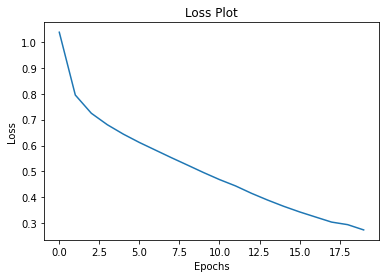

In [30]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [31]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [32]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> the giraffe is standing under a umbrella <end>
Prediction Caption: a large elephant is standing in a sandy area with trees in the corner <end>


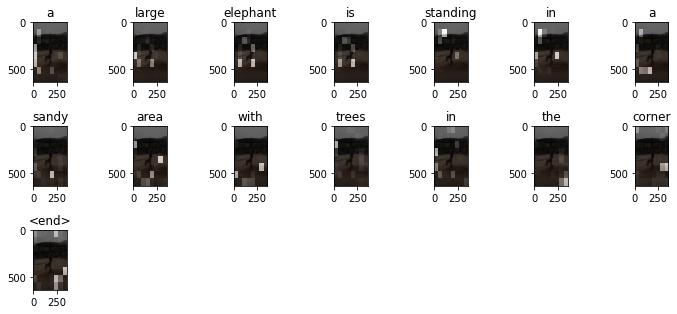

In [33]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


## Try it on your own images
For fun, below we've provided a method you can use to caption your own images with the model we've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


Prediction Caption: man in front of a big podium <end>


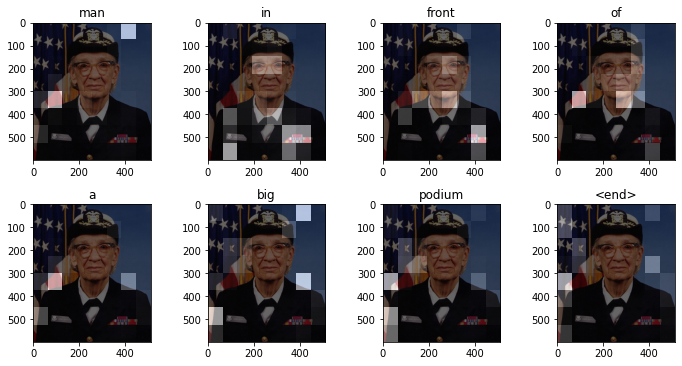

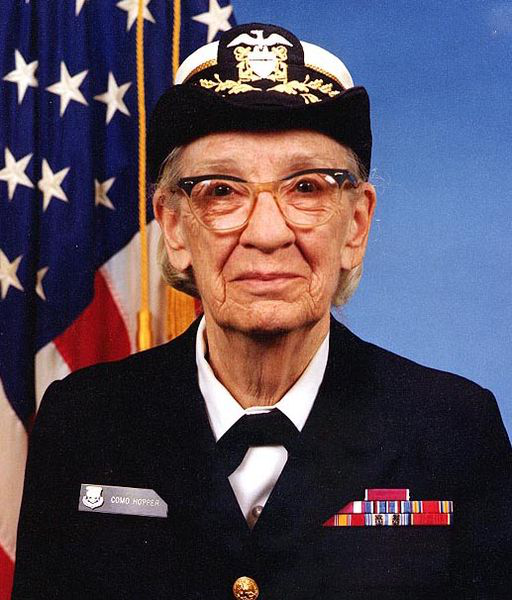

In [34]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

# Next steps

Congrats! You've just trained an image captioning model with attention. Next, take a look at this example [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb). It uses a similar architecture to translate between Spanish and English sentences. You can also experiment with training the code in this notebook on a different dataset.